In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "/home/bradhakrishnan/ECE276A_PR2/code")
data_base_path= "/home/bradhakrishnan/ECE276A_PR2/data/"

In [89]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.linalg import expm
import jax
import matplotlib.pyplot as plt
import load_data 

jax.config.update("jax_enable_x64", True)
dataset_idx =20

encoder_data= np.load(data_base_path+"Encoders20.npz")
imu_data= np.load(data_base_path+'Imu20.npz')

In [90]:
imu_angular = imu_data['angular_velocity']
imu_linear = imu_data['linear_acceleration']
imu_ts = imu_data['time_stamps']

# DATA format of encoder: [FR, FL, RR, RL]
encoder_counts= encoder_data["counts"]
encoder_ts= encoder_data["time_stamps"]

(encoder_counts, encoder_ts,
lidar_angle_min, lidar_angle_max, lidar_angle_increment,
lidar_range_min, lidar_range_max, lidar_ranges, lidar_stamps,
imu_angular, imu_linear, imu_ts,
disp_stamps, rgb_stamps) = load_data.load_dataset(20)

In [5]:
def velocity_calculator(encoder_data, encoder_ts):
    #skipping the 0th index
    del_ts= encoder_ts[1:] - encoder_ts[:-1]
    VL = 0.5*jnp.sum(encoder_data[[0, 2], 1:], axis=0)*0.0022/del_ts
    VR = 0.5*np.sum(encoder_data[[1, 3], 1:], axis=0)*0.0022/del_ts
    robo_vel = (VL+VR)/2
    return robo_vel
    
robo_vel=velocity_calculator(encoder_counts, encoder_ts)


In [6]:
def twist_creator(lin_vel, ang_vel):
    # Create a 4x4 matrix of zeros
    twist = np.zeros((4, 4))
    
    # Set the last column to lin_vel (with a zero appended at the end)
    vel_x= lin_vel
    vel_y= 0
    vel_z=0
    twist[0:3, 3] = np.array([vel_x, vel_y, vel_z])
    
    # Set the element at first row, second column to -ang_vel[2]
    twist[0, 1] = -ang_vel[2]
    
    # Set the element at second row, first column to the third element of lin_vel
    twist[1, 0] = ang_vel[2]
    
    return twist

In [7]:
def time_sync(time_stamp_1, time_stamp_2):
    ts_synced = {}
    for ts in time_stamp_1:
        ts_synced[ts] = np.argmin(np.abs(ts-time_stamp_2))
    return ts_synced

imu_sync_map= time_sync(encoder_ts, imu_ts)
lidar_sync_map = time_sync(encoder_ts, lidar_stamps)

In [8]:
def motion_model(prev_pose, lin_vel, angular_vel,del_T):
    twist= twist_creator(lin_vel,angular_vel)
    pred_T= prev_pose@expm(del_T* twist)
    return pred_T
    

In [9]:
T_0= jnp.eye(4)
encoder_poses= [T_0]
del_ts= encoder_ts[1:] - encoder_ts[:-1]
for ii in range(0,encoder_counts.shape[-1]-1):
    ang_vel= imu_angular[:,imu_sync_map[encoder_ts[ii]]]
    lin_vel= robo_vel[ii]
    del_T= del_ts[ii]
    encoder_poses.append(motion_model(encoder_poses[ii],lin_vel, ang_vel, del_T))
encoder_poses= np.array(encoder_poses)

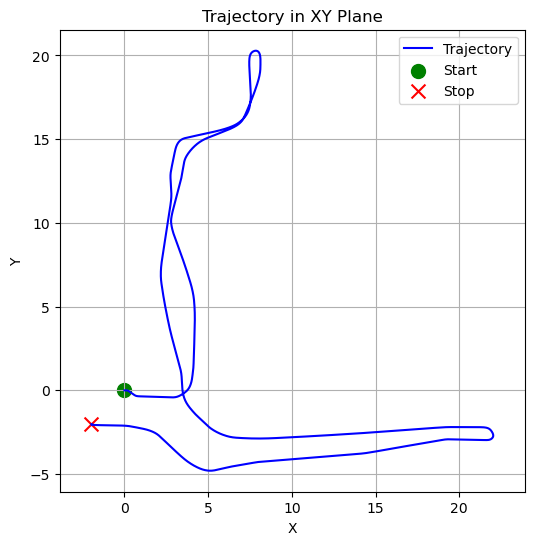

In [10]:

import matplotlib.pyplot as plt

def plot_trajectory(poses, additional_poses=None, title="Trajectory in XY Plane"):
    """
    Plots the trajectory of a sequence of poses in the XY plane.

    Parameters:
    - poses: A list or array of transformation matrices (4x4).
    - additional_poses: An optional list or array of transformation matrices (4x4) for the second trajectory to be plotted in orange.
    - title: Title for the plot (default: "Trajectory in XY Plane").
    """
    xy_positions = np.array([[pose[0, 3], pose[1, 3]] for pose in poses])
    
    plt.figure(figsize=(6, 6))
    
    # Plot the primary trajectory
    plt.plot(xy_positions[:, 0], xy_positions[:, 1], label='Trajectory', color='blue')
    plt.scatter(xy_positions[0, 0], xy_positions[0, 1], color='green', label='Start', s=100, marker='o')
    plt.scatter(xy_positions[-1, 0], xy_positions[-1, 1], color='red', label='Stop', s=100, marker='x')

    if additional_poses is not None:
        additional_xy_positions = np.array([[pose[0, 3], pose[1, 3]] for pose in additional_poses])
        plt.plot(additional_xy_positions[:, 0], additional_xy_positions[:, 1], label='Additional Trajectory', color='orange')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.grid(True)
    plt.axis('equal')  # Ensure equal scaling on both axes.
    plt.legend()
    plt.show()

plot_trajectory(encoder_poses)

In [11]:
def get_lidar_pc(lidar_raw_vals,  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment):
    lidar_angles= np.linspace(lidar_angle_min, lidar_angle_max, int((lidar_angle_max - lidar_angle_min) / lidar_angle_increment) + 1)
    lidar_val_mask = np.where((lidar_raw_vals > lidar_range_min) & (lidar_raw_vals < lidar_range_max), True, False)
    lidar_raw_vals_masked = lidar_raw_vals[lidar_val_mask]
    lidar_angles_masked = lidar_angles[lidar_val_mask]
    lidar_x = lidar_raw_vals_masked * np.cos(lidar_angles_masked) 
    lidar_y = lidar_raw_vals_masked * np.sin(lidar_angles_masked)
    lidar_z = np.zeros(lidar_raw_vals_masked.shape[0])
    return np.column_stack((lidar_x,lidar_y,lidar_z))

In [12]:
# pc=get_lidar_pc(lidar_ranges[:,0],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])

In [12]:
import ICP_stuff
from tqdm import tqdm

prev_pose= T_0
accumulated_pose= T_0
lidarToBodyPose = ICP_stuff.get_pose(np.identity(3), np.array([0.13323,0,0.51435]))
trajectory= []
for idx in tqdm(range(encoder_ts.shape[0]-1)):
    # Time t data
    enc_ts_t= encoder_ts[idx]
    lidar_pc_at_t = get_lidar_pc(lidar_ranges[:,lidar_sync_map[enc_ts_t]],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    
    # Time T+1 data
    enc_ts_t1 = encoder_ts[idx+1]
    lidar_pc_at_t1= get_lidar_pc(lidar_ranges[:,lidar_sync_map[enc_ts_t1]],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    
    # motion model
    del_T = enc_ts_t1- enc_ts_t
    motion_model_pose = motion_model(prev_pose, lin_vel=robo_vel[ii], angular_vel=imu_angular[:,imu_sync_map[encoder_ts[ii]]], del_T=del_T  )
    icp_pose= ICP_stuff.ICP(lidar_pc_at_t1,lidar_pc_at_t, motion_model_pose)
    
    accumulated_pose= accumulated_pose@icp_pose
    trajectory.append(accumulated_pose)


  0%|          | 8/4955 [00:03<34:54,  2.36it/s]  


KeyboardInterrupt: 

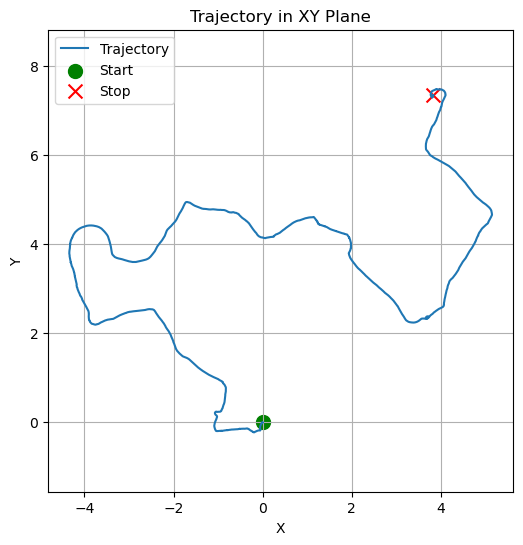

In [85]:
plot_trajectory(trajectory)

In [12]:
import ICP_stuff
from tqdm import tqdm
accumulated_pose = np.identity(4)
icp_traj = []
lidar_body_pose = ICP_stuff.get_pose(np.identity(3), np.array([0.13323,0,0.51435]))

for idx in tqdm(range(encoder_ts.shape[-1]-1)):
    enc_ts_at_t = encoder_ts[idx]
    enc_ts_at_t1 = encoder_ts[idx+1]
    encoder_pred_poses = encoder_poses[idx]

    # LTDAW stuff at time t
    lidar_range_val_at_t = lidar_ranges[:, lidar_sync_map[enc_ts_at_t]]
    lidar_pc_at_t = get_lidar_pc(lidar_range_val_at_t, lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    pose_at_t = encoder_poses[idx] @ lidar_body_pose

    # LTDAW stuff at time t+1
    lidar_range_val_at_t1 = lidar_ranges[:, lidar_sync_map[enc_ts_at_t1]]  
    lidar_pc_at_t1 = get_lidar_pc(lidar_range_val_at_t1,lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    pose_at_t1 = encoder_poses[idx+1] @ lidar_body_pose

    init_pose_for_ICP = np.linalg.inv(pose_at_t) @ pose_at_t1

    icp_estimated_pose = ICP_stuff.ICP(lidar_pc_at_t, lidar_pc_at_t1, init_pose_for_ICP)

    accumulated_pose = accumulated_pose @ icp_estimated_pose
    icp_traj.append(accumulated_pose)

icp_traj = np.array(icp_traj)

  0%|          | 7/4955 [00:00<01:19, 62.44it/s]

8.230143308803347
8.277542870032136
8.279685636698256
8.279690222525902
8.172724741520117
8.154334147445738
8.155198342037936
8.088564238122709
8.082798705720363
8.083037845006473
7.59703104965572
7.593459725066716
7.593511041584078
8.086711012974412
8.117956692456232
8.125893911009495
8.12589925877397
7.873179649595701
7.8874906683544825
7.88616893263763
7.886088592037456
8.278448968303783
8.275222733731562
8.27317950152866
7.604162625390931
7.605768722109431
7.605788158990512
7.863943568012275
7.853522925427887
7.852933573207454
8.13127008378257
8.119267256902287
8.119098773173825
8.019034200553051
8.025971474498396
8.030339736778222
8.130503963622111
8.109155700833146
8.109182628818193
7.788180876093142
7.812146401514328
7.812679869033808
8.744153022034213
8.836197011422247
8.8344076746388
8.834159307912572
8.067560313065911


  0%|          | 23/4955 [00:00<01:09, 71.44it/s]

8.081293396542184
8.086701349236504
8.089701122253057
8.090122220328801
8.207953287266449
8.177613915190749
8.185033816127035
8.186047073549588
7.444243806036842
7.414759647931055
7.414546772592064
7.60272782471996
7.591899830437029
7.590706508420158
8.006865802209893
8.046222142595672
8.045175318355666
7.849156514797489
7.846787214090466
7.84865006404202
8.17246040358879
8.187925424825593
8.19094874156793
8.191200231585329
8.087096936794001
8.081127104966658
8.081989274600605
8.02914481082206
8.04203185534916
8.041698063594257
8.368675425417399
8.297100179910606
8.297115742911764
8.277606566522554
8.177063737038864
8.177112970467231
8.525587136368555
8.366670476822268
8.354676914078516
8.354484917736396
8.819031576266287
8.72798880086035
8.726707095957316
8.438848918278723
8.39181887770281
8.39161424663186
8.44242641139043
8.445780915676462
8.447978349637133
8.4484834156418


  1%|          | 39/4955 [00:00<01:06, 74.06it/s]

8.001682758663886
8.032416890813126
8.032949242663697
7.7671881122532564
7.815014697042568
7.818840723672594
8.080433761840748
8.11466107158024
8.114580292517644
8.567406782212178
8.551393691538014
8.551747512275583
8.37898175153132
8.376309528079386
8.376304872010655
8.561420760114943
8.56210393954435
8.559806395208838
8.559475091114447
8.121584009635272
8.114094622137962
8.114374277470048
7.682106484832949
7.619217360044356
7.620273742477314
7.929175683994467
7.961641560097211
7.961894016164682
7.638119410306535
7.626904317192443
7.626491139548265
7.626287364749977
7.619423351357575
7.620771208868485
7.625626741851036
8.163777331174398
8.202011468154902
8.205739897496036
8.206290499716646
8.593959714256908
8.629480148574801
8.634691159483467
7.81064445401784
7.819986536244862
7.822490232310336
8.14709439118197
8.162226343435165
8.162256575786436
7.7405586143677425
7.743719105964075
7.743717535760156


  1%|          | 55/4955 [00:00<01:05, 74.46it/s]

8.388143438481343
8.398593544747744
8.39884327373015
8.553186747362759
8.552597295989075
8.554132368293356
7.126391778511343
7.1253895189874275
7.125238970910356
7.689272611805546
7.687150519512377
7.819396506506874
7.837481880027686
7.837724729547446
8.261697527214928
8.280488433463397
8.28151198338416
7.925668054135264
7.96554470533045
7.96553754880078
7.794573477994808
7.808060799798751
7.808571636276214
7.839936451457621
7.874108697705153
7.87344493453355
8.432171620456424
8.441184459823589
8.442444935159905
8.442510645796833
8.428924150915796
8.45831320003391
8.459172858028573
8.195713590360281
8.177990449116262
8.1810999833907
8.182100687528033
7.9102542638852835
7.773984943174906
7.775975342854311
7.7765197165429685
8.036677986441186
8.028975909096173
8.029144304653705
8.029151803224467
7.802426215132584
7.821014614026727
7.823229780702055


  1%|▏         | 71/4955 [00:00<01:05, 74.07it/s]

7.813990538512627
7.80860233056813
7.8083914684292655
8.26562967864919
8.288054584509776
8.299212909696596
7.583408952497347
7.559717981678423
7.5599220563003495
7.559936781606631
7.868037589571168
7.84094576906302
7.838456161269827
7.540890317457451
7.558318084985481
7.558381172693427
8.15305530978284
8.170741044924402
8.170857071032675
8.170876946201115
7.794632783196051
7.793306831332157
7.795976736989386
7.796201795614976
8.44438179810954
8.438250976837654
8.437907810758219
8.223490834368526
8.23003377353482
8.229643835949044
8.126615880593427
8.14351358549867
8.14947448447771
8.149938732580095
8.164705694847296
8.161584603275706
8.16186715080326
7.07380161377141
7.083627596420863
7.083617982156614
7.627654663437051
7.629713063812836
7.6296924170344695
8.345158667259284
8.334002868076997
8.336095224252023
7.5111218150459935
7.501529082610146
7.501483976600556
7.905032330940117
7.988999596499479


  2%|▏         | 87/4955 [00:01<01:04, 75.44it/s]

7.996237507744059
7.9970681586035255
7.695395538762417
7.691251207735916
7.691840348220456
7.390440531316648
7.377628290664257
7.375235500636856
7.374494763519731
8.207460378532396
8.172803724947503
8.172204512571684
8.832441640070684
8.779714889995507
8.773481703591045
7.8058858490496
7.798127827053602
7.798279167877934
0.056184873384157064
1.3973903525349022e-12
8.337390835922745
8.334932655997715
8.33477216064561
8.147463753150962
8.12001309236567
8.119198631646944
8.119086525277378
8.494505594047268
8.52715016351756
8.526062549712835
7.538323308026652
7.558222517857695
7.558878461684784
7.560132870640204
7.56013935310322
8.166653166490615
8.142263130578186
8.143350296096646
7.3704540232681515
7.382364917783555
7.382590918541384
7.382614178371657
7.775639764643848
7.755266593628042
7.754105886036432
7.753689713810239
7.612877172642448
7.5049861579096335
7.5174185542468965
8.284395810386314
8.230118667381582
8.236394526645231


  2%|▏         | 103/4955 [00:01<01:04, 75.42it/s]

8.238461158540513
7.869796114057754
7.880867123603131
7.881082754614216
8.08582009960763
8.111245588414558
8.11165525283377
8.000283901522899
8.009752025289846
8.009794834769995
7.75324949844603
7.754382372453918
7.7543036744919025
7.911483470749918
7.91159332648373
7.91142071695818
8.184605978596139
8.190256075213906
8.19049028469013
7.28413704480502
7.2757173506075485
7.275343683370769
8.496279610155195
8.487720157430669
8.484482447373612
8.051635070427473
8.064302941958177
8.065618118297476
7.540196645594666
7.5531332144159204
7.5536415975647575
8.633104115225972
8.606873820261644
8.607933089393057
7.721164308279417
7.687144276476846
7.687150594715748
7.851802119517199
7.827272833007287
7.827665614690471
8.352294564111057
8.375409355322065
8.379665715464627
8.379676335353377
8.180796987296047
8.19224517040083
8.192118252050639


  2%|▏         | 119/4955 [00:01<01:03, 76.08it/s]

7.799584597280774
7.827778049063748
7.827764304722256
7.390034246970951
7.3961971791080865
7.396429480310571
7.724563707241868
7.738027722061099
7.737986916970322
7.903055976419416
7.938772106996709
7.937247887772439
7.992289813123066
7.982822975001663
7.982760109532436
7.940913888990885
7.918366797569902
7.918231232313668
8.145388814859624
8.13609774703199
8.135842745313246
8.008224487060192
8.020234163898863
8.02012915278343
8.27487241312301
8.263656956528436
8.265266505493736
8.475969033759474
8.40486657542576
8.402361711876635
8.402225130164702
7.788511925199678
7.787286882055646
7.786783476330439
8.119527902964895
8.151221923550233
8.153163245737815
8.082779815652094
8.08293059301376
8.083275556301926
8.083451640469285
7.559913383406993
7.557327777691455
7.557339421443388
7.447419214810333
7.445622902603849
7.445205495919933
7.617174128457369
7.626994745608467
7.626971648204686


  3%|▎         | 135/4955 [00:01<01:05, 73.67it/s]

9.051437893794818
9.038947731533218
9.0390045014232
8.706189271577756
8.78283719147407
8.783929340008985
8.783935532437123
7.484010947750448
7.472593275310491
7.474149609820094
7.474378282847052
8.130786134577416
8.112331935960864
8.114521729450413
8.116630907022174
8.087178714252143
8.062246166504654
8.06190920681809
7.668515139841935
7.6201751809283635
7.620354022259651
7.382740763684254
7.3204432245416475
7.317788381615327
7.726975778172165
7.699032143965301
7.699541270608985
7.699660998878063
8.522995510144735
8.54629293838527
8.547153353915501
7.175108863207646
7.160489639124776
7.159990383431949
7.878496705024715
7.883307237332985
7.883632487846807
7.302177735752853
7.269155719211632
7.2706827712421855
8.459111020440506
8.470293379951041
8.471726300137567
8.167107512560458
8.181026038462475
8.183358263753387
7.678033006175126
7.682988143433838
7.68502018645215


  3%|▎         | 151/4955 [00:02<01:06, 72.07it/s]

7.902300671588736
7.915827405681636
7.916628503275128
7.916942118677105
7.814584191584732
7.8412231703715864
7.842776261832215
8.020929469307896
8.042237333352404
8.042365436649
8.369959193323677
8.398930088560927
8.399323461235987
7.995386452585378
8.02347391072279
8.025726732194713
8.01704158504711
8.02517404261107
8.026210409166037
8.026974825694442
8.541159526250615
8.594958961127185
8.594956920814084
7.615505590926085
7.6270401303128885
7.628914172181876
7.762637866113166
7.796158039497436
7.7951466065054555
8.615588773738027
8.649797083442774
8.651838181930927
8.26619581347257
8.300750995055322
8.306555051051852
8.400915565734744
8.426152563172558
8.426315793604225
7.7153070814311855
7.738618093936028
7.73611858121325
7.735955821313857
8.112852669675984
8.154375690453346
8.155330471806465
8.15558804148882
8.726181179653025


  3%|▎         | 159/4955 [00:02<01:06, 72.59it/s]

8.720536649440243
8.721254450437925
8.722266917242871
7.89125527057427
7.9095055715718665
7.909655763150221
7.9551422952387725
7.979995167854566
7.981075070664762
7.589180894644192
7.583031769590706
7.582604282411338
7.305124917065836
7.306936474237565
7.307370684021223
7.466602801549152
7.473766455937672
7.473281462365532
7.473131018947739
7.212423891568838
7.19423701156842
7.194428657619942
7.62929406074954
7.614989628392379
7.613890479154723
7.613743243258725
7.80848448579456
7.840205788738764
7.844799263993615
8.189364673891106
8.189104297804302
8.189391559659994
8.067166872292574
8.115459434433486
8.117083908754672
8.091760434305098
8.097596828581194
8.097737708635668
7.812139531151422
7.8219778495634795
7.823130324242801
8.257435357099343
8.234472104933822
8.233953587048571
7.822422451056598
7.743018230425775
7.742248633659611
7.742143448935031
7.810949982414829
7.812360450462052
7.811296287112038


  4%|▎         | 175/4955 [00:02<01:03, 75.15it/s]

8.14305347442004
8.143781103535021
8.144948949871594
8.145068184590713
8.46167637008013
8.480337764784839
8.480329918829042
8.430831306480922
8.451623997668685
8.451783434876633
0.11050375061556475
1.9158011074220402e-12
7.782422795636471
7.794957321709393
7.797104673880325
7.690455833298265
7.64116476921615
7.6412297922965315
0.01223002573762793
3.9106174994420856e-12
8.6644250397243
8.67919892734191
8.678899854882559
8.678814826429855
8.157401698595176
8.231634221525983
8.237569945526117
8.239806885789184
8.348354629872771
8.366257509254433
8.366086996784409
7.950952165473888
7.928205699108137
7.928039881001274
7.927906898902503
7.8038604266483285
7.823571798589768
7.824280418882985
8.102025222960531
8.120715682066292
8.12162832512988
7.975199192788413
7.997638704710089
7.997742885341862
8.700586568955076
8.762191500136568
8.76894013645357
8.771119498535803
7.724370389576839
7.714418980637027
7.7148817995162275


  4%|▍         | 199/4955 [00:02<01:02, 76.19it/s]

8.06930057217208
8.084563036137222
8.08359872527916
7.723729684108315
7.73502163853364
7.735528880670673
7.492537411093619
7.502608305188538
7.503249219810776
8.002224573961026
8.03710620066418
8.041645819008213
7.692918375447578
7.690348526013347
7.689501683449027
7.689219954904623
8.540137999804983
8.53451364590623
8.534382137040883
8.373108626215583
8.375564037897224
8.37659207202027
8.024398915784348
8.05619127222133
8.059035084962984
8.08424730177817
8.087728086868049
8.087631361960455
8.08754793133194
8.523910156326565
8.55385624832292
8.557225377512223
8.557813577680976
8.863343500539418
8.827545098727075
8.822317729023535
7.605835671818217
7.617903679023275
7.619917570048057
8.457497612904842
8.463908941607247
8.463743076493154
8.146605800620613
8.154568551962939
8.156547066050225
8.050510605882597
8.040634319993684
8.042258951186351
8.36163262924832
8.364064035873628
8.364013744353777


  4%|▍         | 215/4955 [00:02<01:01, 77.63it/s]

8.513087189273818
8.503749015489477
8.503600928023099
7.5208676424522585
7.535699451344356
7.53501960485362
7.534909392397828
8.294815977896759
8.354816511146165
8.348987558802197
7.971754567463477
7.958867167744511
7.959558699129723
7.9595681752310155
8.472566936220787
8.47859532241845
8.478572833712596
0.04134166601579527
1.8011463625806079e-12
8.516382913968815
8.52721109280759
8.526808010419549
8.108959449946411
8.133526668119329
8.135115881019434
8.190210052299724
8.182612343219358
8.184295172772789
8.185036268847416
8.598999845520442
8.595203503942843
8.59508914324319
8.040076746251517
7.987786715771265
7.987795775264884
8.337278295075443
8.331704542237787
7.644499416480599
7.610258616645261
7.609950736350919
8.103243925388263
8.158197888791008
8.157405578260203
8.164190485387701
8.233237394503721
8.233153965196097
7.747184512805856
7.751263958544785
7.7508346207427765


  5%|▍         | 223/4955 [00:02<01:03, 74.05it/s]

8.4635696091799
8.467950681337175
8.46854004187188
8.468626734458942
8.083576625844929
8.091532045211583
8.090912934391929
8.310713705307794
8.356336319651378
8.35685013574722
8.264164989898209
8.281503423727152
8.288477144473273
8.289978580615697
7.869116112687789
7.854461253279176
7.855688335280543
7.889554722374243
7.919485728929692
7.919344870019149
8.11607142919084
8.137086050237025
8.13922773813831
8.13924159757533
8.232594793899555
8.221233174996765
8.221300270630199
7.7420131567218355
7.699982040720378
7.703055737736788
7.837104073308719
7.853478424120846
7.855154666117236
7.855161643196693
8.064812539384688
8.072963608620096
8.072357761372885
7.946582142365283
7.970839518420986
7.97276809571816
8.442871504360898
8.461255328092562
8.461251638210737
8.456599107879898
8.45496450470646


  5%|▍         | 239/4955 [00:03<01:03, 74.08it/s]

8.35308386094436
8.334050698904175
8.332562084073517
8.453032025686985
8.508211394372317
8.508858164102877
8.508916607733372
8.156409008199773
8.149646519447737
8.150332613678941
8.150819177065271
8.321897690585818
8.307911409714595
8.304248027638877
7.8829402056353
7.832481019147907
7.832452119345027
7.76379904919364
7.7645294177499435
7.764556596463644
7.307409240394678
7.308600798464922
7.985497867130542
8.018034325007669
8.019175438720755
7.748966693690303
7.702219958574512
7.701853397524555
8.467992107985395
8.477596104459064
8.477459829153489
7.949894348128607
7.964848420566871
7.968515231060993
7.96852328129887
7.46276703625189
7.4931262551938875
7.492352587303233
7.492337891397922
7.592373388826786
7.5914525166994755
7.591590509892141
7.778768701425694
7.85256562047701
7.85726312001897
7.857604661922533
7.430828990221649
7.422856184104319
7.424833634726383
7.8856800658741575
7.894114616827014


  5%|▌         | 255/4955 [00:03<01:02, 75.39it/s]

7.894392018420554
7.67082564928079
7.686518080580996
7.686899499650114
8.141443462113255
8.156986829207277
8.17101431381555
8.17157215267347
7.740573282534626
7.738196849709566
7.738073241902769
8.518792821747468
8.568866058588517
8.574752709477254
8.576345526806197
8.24621041242622
8.264012365359232
8.264140182805196
7.601743848411861
7.58725755664781
7.587069283642457
7.88055445263292
7.8534889666396355
7.854161482952093
0.140108285116332
2.8753031550131506e-12
7.717309995146649
7.776364752208996
7.777006553316233
8.32955190139189
8.35813904845389
8.361648987657713
8.09463110193716
8.10562238845755
8.106627414743524
8.58505622686873
8.610445988558936
8.61576558561376
8.616210743269441
8.617560967648135
7.782657593819066
7.6713407029970435
7.671629586134381
7.57628091669384
7.5354517649488395
7.5352698437204655
8.230306322299223
8.287769788971264
8.290328184040897


  5%|▌         | 271/4955 [00:03<01:02, 74.73it/s]

8.115539098654683
8.122404450540973
8.122835179524909
8.29657732825401
8.327759797707941
8.327407401118489
8.327356105947116
7.654713531115843
7.672370708551531
7.672313337542708
7.748814220063665
7.747494810398597
7.74835287791397
8.388406423529918
8.393690522526963
8.394587865148965
8.262497852415532
8.292587109582563
8.291930460465512
8.336823940851982
8.331807656988143
8.331970000530621
7.859440070232328
7.853405966159405
7.8540234012038495
8.504726500302457
8.522499965577817
8.525867932861138
8.52591454206757
7.751844217178769
7.768824900928939
7.769965935768495
7.770256221101363
7.615036337818465
7.5976408838568315
7.5973473352524925
8.567085492683143
8.580282955580978
8.581804941668276
7.939459484831949
7.966265128058917
7.965475524367759
8.288321904699455
8.308518677661962
8.309907203125782
8.310397867474151
8.302711851489505
8.334080777260368
8.334096895385763
8.017498344564862


  6%|▌         | 287/4955 [00:03<01:04, 71.98it/s]

8.007438131503395
8.007633095809924
7.79602727905997
7.842607453209207
7.849877725410339
7.73276095636993
7.737124669308216
7.737146761259507
7.737193345925627
8.33171826442592
8.362818082061539
8.363250828969566
7.517293656117142
7.520935102439771
7.520766261268977
8.125261145764654
8.14629133365314
8.14924828565472
8.055587714850605
8.04752129988998
8.047416670517007
8.047375584415335
7.719060510436693
7.748354356491843
7.749712586978186
8.083413720332544
8.10003454462765
8.104219529133296
8.104513205829956
7.502037361661078
7.513043924677703
7.51589678787784
7.517294095479007
7.7887030456880435
7.774537276766823
7.774612419736634
7.887996972255256
7.888592732528553
7.889128387073444
8.288996814300372
8.371739467963646
8.376828639744492
8.377095319832009
8.365492795138028
8.37969513410826
8.380138101583768


  6%|▌         | 303/4955 [00:04<01:03, 73.18it/s]

7.4723042446713865
7.4751605690673895
7.474868100306683
6.8959562556380565
6.920273010384346
6.919908329400771
7.498691416549816
7.480782441996729
7.4789432823677275
8.234336509919846
8.231232489220181
8.230508022908085
8.687271766521587
8.766690299365258
8.767817355754268
8.326281237418836
8.301610508467146
8.303295603388513
8.303616161553862
8.513604869030408
8.568325969863091
8.568260788027633
8.001011927586966
8.003122052678542
8.002752403877704
7.978640181455971
7.971553250514672
7.971375106979689
8.021364564699843
8.01902827188232
8.018650362439312
7.748928205672675
7.721351904705251
7.722949652489044
8.15550135726598
8.141495316553012
8.143076304224362
7.982438972927723
8.065951787942236
8.067296308586947
7.737510753790738
7.7543928713104595
7.758191316948149
7.802858997039028
7.814828193019854
7.814834819969035
7.814835716890166


  6%|▋         | 319/4955 [00:04<01:02, 74.34it/s]

7.769458231108389
7.766966839457341
7.774905388631547
7.77696458323651
7.942735515846101
7.9442942187030265
7.944581752587602
8.029551397558135
8.037977148396735
8.03806434435322
7.586485796588903
7.580868597550791
7.581374669792153
8.588084072127687
8.598787895859763
8.606399981615755
7.841671827140942
7.820046058898053
7.8200898645915204
8.472815874294758
8.47330877871494
8.478746795337848
7.218575142759011
7.225382550308762
7.226677583129024
7.7228296987702265
7.736207660944921
7.736155280221859
7.8494092658522305
7.79934572626767
7.801011914879108
7.80158582973932
7.6459134057871
7.6495807015020265
7.649471923931391
7.764954161815744
7.755344484005476
7.75457285615969
7.754437313080474
8.692611784495481
8.726063373384868
8.727855198140459
7.7754686764148735
7.796962926068014
7.796965936204359
7.558527462952933
7.582792779399604
7.589273150524645
7.868214431908428
7.820624904629279
7.824516545977549


  7%|▋         | 335/4955 [00:04<01:01, 75.30it/s]

8.070944851952405
8.02334781402271
8.023956143630153
8.024053256122354
8.56665346119971
8.56449920245792
8.566213302671123
8.441499759711505
8.47048145938956
8.470445863089607
8.464005795135428
8.532084715819266
8.532209610691151
7.916163552260747
7.9236478310427945
7.924762313434522
8.287694345804972
8.244903742628937
8.253410054294076
8.254034947581728
7.931494570836332
7.935681198710998
7.935727081013031
7.993562933882673
7.993454888589998
7.993083821500858
7.993063098437105
8.620523659574399
8.632266488853656
8.632332244047289
8.139990858673315
8.157670955591959
8.160254244012098
8.160367121605658
7.653542682917397
7.648107061684589
7.6480606657037775
8.015587514634854
8.01122091284253
8.010810666458145
0.13960953512007446
1.6063614544275675e-12
7.835485520271609
7.847125248633249
7.852623436836744
7.852889539880312
7.996027519937425
8.032261193859643
8.032203492850503
8.36341015832906
8.35852799348807


  7%|▋         | 343/4955 [00:04<01:01, 75.50it/s]

8.358589905583848
7.931454605503787
7.907480242382847
7.907057535638135
7.790995793377513
7.793750404021616
7.793549221407927
7.5947883334794986
7.594560021366934
7.594538272914265
8.436242069514009
8.448242124951296
8.448288262221059
8.057955566283383
8.077538396161163
8.076092746451588
8.220639209353587
8.251103232232087
8.251128477572026
8.137893139047598
8.158033291219407
8.163057468123515
7.886063898614867
7.870442165557531
7.874485026679871
7.87457276464486
8.70730559769034
8.726359647371593
8.734803276767424
8.73582082607222
8.736367468988215
7.853623310001753
7.851124941553149
7.851720614803389
7.85173978665068
8.065300387337926
8.086842734585142
8.083149329630293
8.082724754578184
8.082716037091306
7.633158812913349
7.630068516828303
7.630763443005248
7.430698394553111
7.471225727079727
7.470107181609589
7.401368214207294
7.394957431892026
7.396031258850732
7.955777209312213


  7%|▋         | 359/4955 [00:04<01:02, 73.01it/s]

8.016986784048663
8.017550882378472
8.848861470199548
8.88302495897376
8.883493754136037
8.496327801802337
8.512955439589323
8.512161722846834
8.979268877543308
8.981467460949975
8.980760247056566
8.980750708389422
7.905556540289414
7.930701185918228
7.930799418207194
7.479663429213353
7.469502580629836
7.470006894729583
8.359420336332173
8.421360526045177
8.43294925037457
8.435261360770518
8.435994718621556
8.791471068801345
8.800610034719002
8.802053306541325
8.802324527601364
7.699300632637168
7.6812350466405395
7.682504671996474
7.930832843687721
7.93426850657057
7.934262988418233
7.6115999456065655
7.633558556203441
7.634783428660448
8.035761995944396
7.9949064615878305
7.998392501099851
8.042576128669802
8.05634233248548
8.05645553545799
7.3435128344848675
7.396009101110789
7.397079764308177
7.398976063126549
7.788044008854693
7.803874053306139
7.8039339178433735
7.865588576223635


  8%|▊         | 375/4955 [00:05<01:01, 74.22it/s]

7.861225206579993
7.861286729922378
7.690343089380045
7.686630502348181
7.685670364495289
7.685492354617887
8.459741263595355
8.48973318363211
8.495562786992807
8.49598256926792
7.657318213012422
7.677445587932397
7.678064025447266
7.66025405686867
7.645775439167241
7.646587726139277
7.855993340699994
7.855354423923389
7.857349686731489
8.497748642763039
8.51539028599218
8.520355127312989
8.385149661568017
8.432817857168162
8.432583794871192
7.929904551653472
7.964760252493061
7.966099889854639
7.910409474670023
7.913137547428541
7.9119993408381095
8.296483290408204
8.248193900026244
8.247861718642257
8.247862012413268
8.061170372013644
8.053612213246208
8.053609736366356
7.607630275413266
7.604870723019879
7.608964680096736
7.610260568266751
7.834349350415217
7.875874946377274
7.879912728972499
7.880150622367052
7.945301920792095
7.926664188945171
7.923808838842155


  8%|▊         | 391/4955 [00:05<01:02, 72.69it/s]

7.92258643894887
8.344925957607924
8.356114117574144
8.356395551753929
8.244950721904004
8.267197028676014
8.267190036852746
8.267544987727593
8.302858905688069
8.309904345798884
8.310467383774029
7.901054238866984
7.865328355796648
7.865746056242168
7.8644577337473685
7.852806576191875
7.853242641808616
8.556748595810003
8.566260818284315
8.570525954897846
8.57064007893112
7.8414132204426705
7.824481626190406
8.639621192125926
8.437397384564095
8.437236497692238
8.437217954770741
8.754991218499928
8.457836914057125
8.457929720703266
8.957410642442435
8.581412029524218
8.587161753785502
8.588104939226145
8.318935799677867
7.903984202586065
7.902909039593435
7.902902522277936
9.531087722040624
9.10880346248929
9.114100318952943
9.115047679759675
10.036997716684288
10.107613296526099
10.10577166141921
10.262493273978679
10.231828473268374
10.232236650461878
10.592876212641595
10.509881198641333


  8%|▊         | 407/4955 [00:05<01:07, 67.19it/s]

10.512520766774669
10.512665874492779
12.419417593043178
12.22626405094079
12.227664356665025
12.228047124483595
12.340661292907306
12.540169298698697
12.548139713404366
12.549926241696578
12.519483788680585
12.27991247788633
12.280333062627099
11.339705640727368
11.24585503102935
11.246571490570854
11.246614402446923
11.84314979860772
11.650662227952587
11.6463893858305
11.64602563698915
11.645936990233457
14.370300697061758
14.45716050521877
14.461540448004513
14.463684610874534
14.464570317733198
11.64850325795117
11.567319324207263
11.565960447041661
11.565911563821196
11.944246877286485
11.90485626778909
11.90441355578235
11.904426421791122
11.904440988337258
12.53948976735196
12.643470497986486
12.665142520200991
12.668706511058192
12.670822463942388
11.523309149232302
11.516388004677296
11.520564661670427
12.023898940812817
11.972293771890428
11.971997818349339
11.9719905634534
11.97199074295818
11.22063541595966
11.228694482677524
11.227129924471502
11.227084523776057


  8%|▊         | 414/4955 [00:05<01:12, 62.64it/s]

10.144796251227405
10.068828007564754
10.068066820555279
10.06805788320887
10.354536288432516
10.442709334786816
10.442484934821287
12.161889397213281
12.296968709989827
12.295010960702928
12.294714233485582
10.923134205964548
10.855930896963162
10.856863416187483
12.238919756236411
12.056528152951842
12.054138097817741
12.053257336175784
12.05235170209016
12.275873681150173
11.931361858375734
11.90667446982762
11.909252926066976
11.910780104861157
14.655364371865815
13.970674343866218
13.89667843827894
13.816347177680791
13.799272008863452
13.795501789663046
13.791943036758683
13.791028882728664
13.973837968463847
13.700442283219944
13.68827466862901
13.681734045283875
13.679549655402687
13.678803487670717
13.678437746349548
6.475384349577378
5.847479948458678
5.921668671994366
5.949805621132001
5.970197889200328
5.958256689500627
5.781428002500741
4.9211563898574875
4.6722867710310325
4.669686579626914
11.357656030514383
11.379570992277314
11.384711207130996
11.387098109947482
11.388

  9%|▊         | 428/4955 [00:05<01:20, 56.36it/s]

13.087970531528178
12.955190457305743
12.95235060074044
12.944668704804775
12.943335172209121
12.943055567429571
12.942759297749761
12.942305001695235
12.9422012074495
12.892534154870884
12.845923505465912
12.849354466781236
12.850150031190342
12.850466967012528
15.064119744803174
15.235124875974838
15.251820889845888
15.259685441762905
15.262467901121187
15.262789257255113
12.839963939390495
12.488216541159405
12.414617294072121
12.402812835565452
12.399355786509705
12.398699484946894
12.398564726419767
12.398517683685817
11.869471366757125
11.780301881685816
11.779675865979044
12.178804603927858
11.779869625475245
11.668187869483866
11.617301333330975
11.609330084442247
11.608136474832857
11.126619900416689
11.007092537365882
11.007328319126682
11.007348143430482
12.749252726355996
12.432748584649438
12.41840523428543
12.416456890840427
11.29573244375623
11.238330280520152
11.256278146567091
11.258399678438952
11.861582632356322
11.56200265157684
11.528263117680918
11.516178456797878

  9%|▉         | 434/4955 [00:06<01:19, 56.80it/s]

12.014593867408667
11.979137133762478
11.982002163114998
11.982823167893265
11.983136267871673
10.218222222256584
10.098827916381236
10.089977180390541
10.089752688145294
10.089661885289223
11.259881651103523
11.052249767056873
11.055964437477812
11.056362212865935
14.108427006761028
13.81911295906804
13.78674402459847
13.779136694778813
13.774518890585385
13.773834918349806
11.376123910074245
11.375626150148783
11.37696880141959
11.377264377585657
10.519333461638205
10.243807101811385
10.19980948733975
10.19440127079361
10.19127395552346
10.191247749317752
12.329582148031239
12.271251266678572
12.266265853461647
12.265774747152625
13.194272562837153
13.223284429053159
13.215155547251932
10.962792075536012
10.654715901753022
10.659070537533614
10.659622400645826
13.551671827019547
13.555567135707378
13.568357139692871
13.576930418584208
13.580487322697035
13.58081133323691
12.248117730972876
12.095002331978135
12.09354508441995
13.058384933601037
12.82765273160561
12.828140838862293
10

  9%|▉         | 449/4955 [00:06<01:21, 55.58it/s]

11.945059565061516
11.883948635736855
11.868456592728439
11.864422224062167
11.864167269176335
11.86415284605701
10.981390561875365
10.73535255692721
10.711058581537412
10.710301629483206
13.23866903765008
13.08078425152556
13.08858827827431
13.096441811701965
13.10481673163163
13.105837356124741
13.108319301130784
13.111109797197624
13.113286512806603
12.837053537553764
12.64173850390544
12.591748840244716
12.569777494804573
12.55791765348544
12.553943801625339
13.989453896212083
14.031756903817424
14.04473363933835
14.04747519643549
13.199437183815077
13.102398666954997
13.092457219646297
13.08979740254885
13.089012717093798
13.088867396338316
11.762663260476169
11.680984161490976
11.680233760746871
11.680070704765388
11.530099782439162
11.55398431637159
11.56932149714216
11.575666161274345
11.577299451132973
11.58369249291389
11.585796704488121
11.589116779061161
11.59227760058802
11.60565366837363
11.61056786823918
11.61101270345887
13.86512861354704
13.913579095315807
13.917131423

  9%|▉         | 455/4955 [00:06<01:24, 53.13it/s]

12.53697741621332
12.356095038721389
12.347563769628646
12.346972142403086
12.345964221532983
12.345458056873783
12.34542223340575
12.34542237630462
11.507055144594613
11.453782615974047
11.46360854706197
11.47434440412212
11.47921170723345
11.481179574461757
12.160092288577436
12.082937609169374
12.083619650016564
12.08441199587053
12.085220569972392
12.085869560131021
12.086263655002913
12.08639321405227
13.289021268154373
13.328897393054117
13.325502095612045
13.323504904636582
13.323570525099097
13.323631146209165
12.075440077373964
12.029629863393048
12.060467075091383
12.085036410577338
12.099447272303122
12.100816647645635
12.101044828734073
13.092308294090916
13.072868162817983
13.072433399572745
12.016978483088096
11.84518022219402
11.845429158332275
11.84549186880961
12.76375773938381
12.643026125457595
12.68903036352551
12.708388422287944
12.722624613116356
12.729018204459013
12.730840290249365
12.731274548131045
12.731676408695913
12.888051995610294
12.817033720087531
12.78

  9%|▉         | 468/4955 [00:06<01:25, 52.39it/s]

11.811226520485334
11.811962171328245
11.814534189842202
11.81585462933668
11.81740635051732
11.818189944770086
11.818811744183126
11.819954449562292
11.821145132648796
11.82131458246051
11.82144062642029
11.82151453170017
11.657610320310743
11.485415276216115
11.476092890852222
11.475305060768028
11.475077070173068
11.146147209187495
11.143627998865473
11.143286688506054
11.143244610875325
10.680030624873229
10.546180875400815
10.540504585381527
10.540162791980258
10.757432534460214
10.681170191104396
10.681411787313458
11.915419783166207
11.975364105241267
11.975278260419742
11.975261268471233
11.946294504422667
11.748447469750747
11.742159414818989
11.742084691658135
11.16846703393028
10.703505770385116
10.689459617935697
10.689539104221621
10.689805091461913
12.376303679551047
12.065122961387596
12.039452336574776
12.03357433724847
12.031781044440079
12.03137652670328
12.030705305239627
12.03066822086061
11.481106181913717
11.2348140550341
11.229289727323842
11.229222885724045
11.7

 10%|▉         | 474/4955 [00:06<01:29, 50.01it/s]

11.30362520034398
11.302734530648705
11.302441393792275
12.738658637774991
12.4203872737959
12.41351440733456
12.408544354942734
12.408142476013577
11.182634267959902
11.119451576320397
11.119571796737215
11.119929393875031
11.119950267289791
11.672980548217307
11.624178436435082
11.622411957461768
11.619738377656393
11.619414174848275
11.619302673231559
11.619202023624833
11.619150468524072
11.619126179812685
12.03815999441474
11.797471278382574
11.771124460745597
11.76295679983965
11.761724498230823
11.761366498921149
11.435967975674757
11.339750228714614
11.331014648442217
11.330058621682632
11.673977481183822
11.372051408744063
11.359990999320068
11.357576349571264
11.357099421864753
12.380686844955905
12.26147064450457
12.252475610075464
12.2514777871992
12.251314070331787
13.169290833025052
12.901832238448144
12.90182409465829
12.901843741620445
12.901945464117455
11.096154835006711
10.946585864537974
10.939036286391083
10.929254614218356
10.92533065739417


 10%|▉         | 485/4955 [00:07<01:34, 47.37it/s]

10.925868842541957
10.925914991082806
10.982808379379591
10.745947025087716
10.749393721083061
11.535383230805714
11.484225458049973
11.484827570546539
11.486555841782945
11.486748731157531
11.48821674147764
11.488310851882078
10.64344330638541
10.509520240266735
10.479820512727
10.477276578896895
10.473511637830008
10.4695096536536
10.468788981787561
11.188716120510623
10.958056688874755
10.887603058595039
10.864063984272232
10.860197544287463
10.859011066381186
10.858931279777613
10.122348783324039
10.076402795721076
10.064681393876903
10.061067475463451
10.059763582751316
10.586311730600947
10.58798197221655
10.587155076824168
10.585523808402005
10.583067273399081
10.57482643178691
10.573322573505896
10.572811145824364
10.572083114037437
10.571263869718997
10.57105078485636
10.570841351793593
11.045326131446
11.047176899749184
11.056226416982081
11.059801598925738
11.063050756062596
11.063911625318708
11.712037394661927
11.705661043682195
11.710371182950102
11.711975845138255
11.712

 10%|█         | 496/4955 [00:07<01:35, 46.88it/s]

11.910675888840164
11.88050319915786
11.876588001188441
11.87684258257802
11.876888712142346
9.945915790643426
9.901408541712733
9.909121486876558
9.913264796392681
9.917175170121334
9.92231808264043
9.923354479621786
9.924402705702544
9.924875515966313
11.393536361803228
11.3351391176835
11.34767772384403
11.35399537705505
11.354357663341133
11.051869977696436
11.032661168744387
11.031938221508323
10.892237699289435
10.75050397794874
10.754467619892417
10.755796626126333
10.756018338643141
10.756033766827816
11.545533208890518
11.487388941865415
11.488162367772134
11.488872655645299
11.489405738892982
11.489523255716268
11.490125720347331
11.491011764771853
11.491117004574603
10.118582387100691
10.03256354109799
10.028791406652932
10.026510770379012
10.026459210048863
10.578427995043498
10.469779788055668
10.467786515423045
10.46737569498012
10.46732194283064
9.757218245927525
9.702895729399241
9.707916619983802
9.710068901101547
9.711234853276633
9.711419262650173
9.711687329731234
1

 10%|█         | 509/4955 [00:07<01:26, 51.62it/s]

11.204677157833862
11.203344442876404
11.203302755177972
11.21203626344067
11.222842972902564
11.222426856885683
11.222505478269213
11.22253524558691
11.222555814385817
9.688933878781864
9.663275137918077
9.65430043228455
9.651951444010614
9.651139299375345
9.65100568747414
9.572299169223093
9.501024923066497
9.497568805429264
9.496023186863052
9.495956527686097
9.496094024161398
9.496168632617781
9.496222012160835
10.080718442348648
9.988140172256644
9.976829441320227
9.97136320982807
9.969677225555735
9.970143555514316
9.971036171444869
9.971411208088796
9.96686097280231
9.972065147356634
9.973226087495082
9.973297144801204
10.56065295815166
10.557167097140148
10.561398848074735
10.563610403899528
10.563859444676673
10.086174720423813
9.966763041037858
9.97572407787208
9.97798932819251
9.978117482988809
10.191957048714228
10.207657869876694
10.20693229026294
10.206999937183674
11.525716795060461
11.540277145617573
11.556233185265661
11.562332327910834
11.564269991082393
11.2717090386

 11%|█         | 524/4955 [00:07<01:13, 60.04it/s]

13.117028950757682
13.115658995948044
12.504895985301138
12.577094968577732
12.571128064678248
12.56967361489212
10.881675669521973
10.62099700809017
10.624862110663145
10.62552323385986
10.625638818241953
9.529226395668278
9.310277208407607
9.28174825842143
9.21599865383892
9.190105101024804
9.188777562318261
9.678352319313738
9.663605842274668
9.637494096964405
9.628806261305058
9.626721654793272
9.626081387731704
9.846098114459815
9.716024296479603
9.729889433042104
9.730947715255649
9.731529452021999
9.414260289987086
9.427469380389248
9.442031572674505
9.451078737975251
9.460581026048231
9.467731269530207
9.471785662908301
9.609472584908142
9.585516306005195
9.588114844310807
10.324139691040472
10.408870356679746
10.409795637913419
9.105840099835351
9.105456642520167
9.101405382648512
9.101154337831442
8.5512735814903
8.55232755933195
8.549048885315116
8.548575726494287
8.548528878012913
9.160365240210957
9.060446415444872
9.05832885792978
9.05791431736845
9.057745389034078
9.0577

 11%|█         | 531/4955 [00:07<01:14, 59.75it/s]

9.476306233879225
9.423381844332738
9.421210830726558
9.421238941359828
9.090519031039186
9.116974824774097
9.119696380310288
9.121079186840873
9.417135493627956
9.336285467809757
9.335320332305113
9.335444970283913
9.335485842153759
9.70463333204637
9.66254583799364
9.657215084318889
9.651172374138055
9.64850455642203
9.645345595559975
9.636666135213355
9.625487364547473
9.62641849259482
9.62712741042445
9.627264717417622
9.61627946931195
9.554950110551676
9.525995700183575
9.51842090734825
9.51737407908418
9.799367284905557
9.75053427139041
9.76544789734023
9.771834183248387
9.774333952611997
9.774512022567748
10.863872700236966
10.955511007825816
11.020018092736715
11.18003392376331
11.222692576895705
11.242403777552738
11.247951718701756
11.842236589914094
11.801702404745146
11.805331996047268
11.806835240978174
11.807433032079963
11.807496161484673
15.423162447257925
14.12103641709338
13.90867927756476
13.69815580515258
13.435238280578998
13.111340499910671
13.042924940795348
13.0

 11%|█         | 544/4955 [00:08<01:15, 58.13it/s]

11.510958576497835
11.51067091653685
11.9191235830008
11.927404063948337
11.926859890785998
11.926826614940522
11.926810141522704
10.396340583432746
10.297862176275306
10.302570591189479
10.400578147539484
10.332654183026978
10.330482241218196
10.32951133189597
10.32928755593656
10.383300320580272
10.357218271759018
10.356353714089039
10.355839730190056
10.908665773452608
10.841907266302924
10.832533400936693
10.826955726925167
10.824542074068741
10.823291843389429
10.822663926999503
10.822034041911351
10.821740243409899
9.853414256420319
9.644941648355623
9.639980740638181
9.640761741375512
9.64180600030241
9.64233429490988
9.642376729538595
9.642467865108783
10.079671796030732
10.01343522921127
10.008597342716065
9.112104077638293
8.89798390165057
8.886654549090913
8.885036339738697
8.884592219919346
9.438280109121639
9.407636060100426
9.408783133642888
9.408984837787361
9.84398543453052
9.632985300383911
9.605917992463702
9.602390207356091
9.59451708236357
9.593810130712953
9.593646

 11%|█         | 556/4955 [00:08<01:24, 51.78it/s]

15.701229626261279
13.775022052058015
12.848005976421858
12.436360653629382
12.435277203966969
12.439515565565156
12.447237156649807
12.45457058577959
12.457432292627272
12.460050517536226
12.02430064519956
8.900562002593663
8.625605873251391
7.788375961607344
7.331949595738639
7.281191294129584
7.282255179218868
7.2827977027347846
7.283846058551713
7.284576595585918
7.2853133187845565
7.285905561584435
7.286264143030023
7.28663738862673
7.290386810378836
7.293646023608373
7.294001824653214
10.482393098903717
10.330030402942365
10.310249576911499
10.310567958559588
10.311652086736656
10.312482249544747
10.312629363181323
9.859654196157669
9.73526069688853
9.724726868563444
9.713799834363709
9.710133859170499
9.709213988781048
9.683219695922226
9.676510251015621
9.684724338333858
9.686892014386903
9.68946926162016
9.689705115013584
9.528607231804134
9.517537197376631
9.520984340165326
9.522847251577577
9.523797000004322
9.523942335092764
9.524000626078536
10.397792329626979
10.292425834

 11%|█▏        | 562/4955 [00:08<01:27, 50.27it/s]

10.354160258610353
10.36273731384777
10.362648624654756
9.715677763512508
9.58321319512098
9.554014489200497
9.55088924671197
9.550713706083602
9.831981393394368
9.708195554990631
9.678722167119899
9.675801302345542
10.467421736949401
10.305605806129702
10.314761637321862
10.318512131096666
10.318860680459899
10.319124803357921
11.610477982829693
11.614118904565592
11.61484698487897
11.616722128743861
11.617428088333028
11.618261006121088
11.619658588347143
11.62069885584675
11.621605056029196
11.622699779130556
11.624341719153707
11.62442798729142
9.233338773270152
9.009037053504048
8.995876448013734
8.993314253362218
8.991688887543578
8.991185113425233
8.92434062668311
8.840473836099324
8.792115277993975
8.776962753263932
8.769923043165214
8.76840431787845
9.16222874168888
9.034825728223385
9.025043450555609
9.019441296073868
9.00250528752645
8.993852576503327
8.992339685651622
10.289285521040181
10.238949631881656
10.240769104966132
10.241069332112422
11.149492330074963
10.960439190

 12%|█▏        | 573/4955 [00:08<01:31, 47.63it/s]

10.956487756335317
10.956793484256401
11.277614246136523
11.125926477921817
11.108290463106801
11.096997461395603
11.09171948593914
11.090162564833948
11.0899353608215
10.918337075815804
10.728268244585477
10.735768942705416
10.738738706028045
10.740252139461415
10.740610210397735
15.784206522015989
16.293371070768885
16.325854641684387
16.334564579754687
16.337393777057592
16.339806028182593
16.341506891880748
9.803050733489792
9.692317739233658
9.658558424220736
9.646085491604055
9.641573786724313
9.640914273079286
16.32653355137375
15.550323275301084
14.982229128599375
14.515672918963372
14.368264619076038
14.311254675416553
14.30123214340742
14.300029095979495
14.299482222349123
10.577790222269666
10.567470156162988
10.572955848051233
10.573631037595948
9.478565817798643
9.41601229181181
9.431007650876687
9.435245760732808
9.436755151206182
8.733570106740615
6.0556221123672564
5.7598187419092834
5.717331049882405
5.692953907541565
5.688227898224924
5.685854032072448
5.6834151798127

 12%|█▏        | 578/4955 [00:08<01:34, 46.42it/s]

10.121266370330668
10.115848389087123
10.115327700024917
9.652444294042782
9.567217339694974
9.57798203110573
9.579014799069883
10.712192801780661
10.719768056404643
10.725704334374884
10.728043412589994
10.729200059289461
10.73033375404439
10.73057942214044
10.449570548299155
10.29051062930979
10.243930675826988
10.239573426381078
10.239128516416706
10.238686595665412
10.442575939121397
10.434683501745104
10.436606244944315
10.435811940862031
10.429363121015239
10.412675177825818
10.409001161579187
10.410968290632532
10.412275363528256
10.41311121325849
10.413220315445086
12.875670486426928
11.972038237813372
11.690320784066195
11.642866537633608
11.649515348777816
11.66134642724284
11.6724009282115
11.684913065119462
11.692866654173077
11.693410464050782
10.315736246448889
10.303673324318703
10.299360940773035
10.299218913780168
10.299268774451615
10.29928405437521
9.549522290896215
6.3761023395426335
6.340454724490183
6.329797310320644
6.284077423578051
6.268902108628735
6.265132474

 12%|█▏        | 588/4955 [00:09<01:41, 43.08it/s]

10.133178124280128
10.019004296959176
10.019565318781293
10.02007572833383
9.782917856369455
9.696237850390773
9.69645420251862
9.696473899471934
10.164246190893225
10.119174798242977
10.132293236178093
10.135872567914943
10.137096563618083
8.512937622322962
8.490055919210674
8.489995097542552
8.490663741618107
8.490787354107585
8.490865826740558
9.601336904324748
9.543180896918857
9.537176309700037
9.53573203654915
9.535582395853622
10.430561092998392
10.411994108652646
10.426711468190321
10.431148493888049
10.433249866760296
10.433760849576586
10.391334097942735
10.330430452285068
10.319751960964851
10.319054668009459
10.3193613669465
10.319401416671589
10.013015569288214
10.03656347887565
10.03207132691768
10.026391604754242
10.02484637444627
10.024502136307527
11.228303000183566
11.243103533778116
11.249436804255271
11.24978203189699
11.284178658706391


 12%|█▏        | 599/4955 [00:09<01:36, 45.31it/s]

11.283689408022369
11.344973735049454
11.35870650989559
11.360600764110409
11.360917254620212
12.202904896412093
12.165059788810176
12.20781675595128
12.22715830726781
12.227687710841028
8.880905664165564
8.841917177627858
8.843626969612263
10.302940200750145
10.425329807638214
10.451423127776264
10.458654083518308
10.461390434898462
11.000941726806587
11.004797318137863
11.006334228650845
9.93064357950437
9.948987537592423
9.960333192520377
9.966101098866055
9.966681701254075
14.664436917655493
13.926727870211018
13.924056315145336
13.923864315032926
13.923802609141088
10.12839263969843
6.655395779823124
6.638106561845213
6.6358405351013
6.63501537594419
10.262108619351473
10.353484394137055
10.3538081143981
10.353855650425295
9.518887145144097
9.509564359393174
9.513680493356045
9.516429526142511
9.516632884899641
10.437396426831105
10.36301463007238


 12%|█▏        | 610/4955 [00:09<01:30, 47.81it/s]

10.379770668755338
10.393284715935255
10.398416621666303
10.400186144954837
10.400490507293277
10.386171429037491
10.375971005199467
10.378688782364142
9.604364280231419
9.551680426824582
9.550718080274272
9.550702069807326
9.238232693862884
9.240578179375836
9.242211321088336
9.242338276102242
10.710069234889009
10.67442465134652
10.708485863403949
10.728122676486318
10.730761241974346
10.570481786226328
10.51135396938098
10.534905365361283
10.536992905725551
18.024485401811816
16.89860601367681
17.521885889851372
18.067656226833677
18.25347854099377
18.33797587198326
18.343500257259805
9.299164991839232
5.82979359562912
5.835335820186983
12.008919930241206
12.01732607400562
12.056634384238599
12.061984628290942
12.800564757636527
12.815254435498206
12.907144466180831
12.926023889616777
12.928561733749962


 13%|█▎        | 620/4955 [00:09<01:36, 45.16it/s]

10.985957466756975
11.023068835443496
11.02532568632429
11.025768891254339
10.485937804776515
10.397310748926635
10.383852084620818
10.379175080956934
10.378565302388658
14.265984849231879
13.589692021798712
13.638906340595323
13.658984623430758
13.672732420838466
13.673525668547748
13.67397000623231
8.737718559444723
8.753301873809452
8.752798063540832
8.75311934225659
10.329282577700921
6.539446076069653
6.546919481141838
6.548733795231225
8.887601223072483
8.759945315380538
8.759697910325485
8.759701269284154
10.756274968614038
11.162148615443567
11.317184145431362
11.373163098340592
11.38161659742055
11.39487982802083
11.398773710157236
11.399624003643982
10.193570191612494
10.063757611753779
10.064745885692478
10.065017929191836
11.310087179401087
11.63280441767467
11.767321506393818
11.828542896249246
11.842819739887865
11.850232926295153
11.852494442311503
11.854362672177006
10.530607408402705


 13%|█▎        | 626/4955 [00:09<01:30, 47.78it/s]

10.514974141783998
10.51525030988919
9.80366427703073
9.715436459804435
9.716013449827035
13.813387447239418
12.441612049421517
12.451248067482931
12.453588975164985
12.45390515686272
9.977783722008612
9.901600952096313
9.89979273489518
9.90031165974821
9.901143812189463
9.90121644428439
10.498274891975292
6.563088685564177
6.554596191640201
6.553977103777111
11.870409188823055
11.91222114244367
11.910155550667586
13.131524984764386
12.358063618533837
12.365877851518048
12.368304076859612
12.36945293772438
9.821475816967459
9.661992975920718
9.666224343228166
9.667431353248226
9.667948085005216
10.247847887078382
6.399947646372869
6.394596468874134
6.394433132823877
10.661780626301809
10.601432810128507
10.655227918986803
10.668035922291018
10.673935194715023
10.674713860701862
12.891345940971656
11.821342253839994


 13%|█▎        | 636/4955 [00:10<01:31, 47.32it/s]

11.826356967490064
11.827694411710397
10.436894018310023
6.3170578171729
6.3037997704949
6.302421796517688
6.302019130656826
10.456747962713694
10.411248055898875
10.417619135442159
10.418218409530617
8.65083033330481
8.67281443314554
8.679867889080189
8.680242360694827
12.098079222754684
11.196247808327866
11.215647535771975
11.226823902327759
11.229617864376973
11.229931805229983
9.455403503593793
6.03450742071187
6.02290165013409
6.022298992625497
11.111520757087025
11.35531476011073
11.393527344608751
11.405330970306759
11.40607641505071
8.895789343195254
8.817705874518769
8.814563709312267
11.84640737579388
10.899447860609502
10.901162668589553
10.90165337161038
9.202040123096584
5.620936899141198
5.615972366251663
5.615888099106396
5.615866657797033
8.178047097587426
8.027822847585865
8.025431549783567


 13%|█▎        | 647/4955 [00:10<01:36, 44.63it/s]

8.025638690832837
8.520173138379898
8.46534866939186
8.468141549092941
8.468690061592234
8.468725311756302
12.842971857540281
11.65658620077656
11.660510333331587
11.66361483082334
11.663740535138277
10.167393115664463
10.296641903526263
10.344776285324933
10.355361833610683
10.35549638217237
9.279638788156534
5.857781605951329
5.854064612375444
5.854072566665198
5.854075895898817
9.364112788909788
9.387985991896812
9.386674978824399
11.390774374412993
10.514450330104594
10.518955339894047
10.519607399082663
10.520149397402275
10.520428144004573
10.520489233766032
10.520988369008903
9.061084496828514
5.658084665343349
5.656978931851593
5.6568303176677315
5.656779581221288
10.94228800510143
10.914737170594249


 13%|█▎        | 652/4955 [00:10<01:43, 41.55it/s]

10.942371222978855
10.96317973736939
10.965192320813351
10.965580371647603
12.034739522678581
10.987065623022042
10.97263092772194
10.969306191935623
10.968656712083995
10.96778222074548
10.967714375790301
10.96770312070879
8.269373487246625
8.123879755942237
8.114826522736893
8.114084807425716
8.113622823543917
9.291162915828465
6.164324166349813
6.164720386623945
6.164799345664548
6.164881012435214
8.975769981343213
8.756145632976278
8.742852410259971
8.7426209858098
11.987899197266493
11.094112726277022
11.078616175466713
11.078159443133588
11.07809243798706
11.078090876433395
9.344281496164612
6.046142780807648
6.04714607734471
8.255170177572603
8.230873317737789
8.233387513570955
8.234259500352433
7.836614933465709
7.711338117682993


 13%|█▎        | 663/4955 [00:10<01:34, 45.26it/s]

7.711533434756067
7.711680590591918
8.144072058795592
8.098314319263588
8.10152654262614
8.101784984817005
11.088986901236996
10.143012758093246
10.135726700700912
10.134954703849246
9.157320569929922
5.719478162128793
5.718985079467424
8.018604621939044
7.910297375148334
7.910752960302544
8.580018504441508
8.392416945079459
8.39585425199387
8.396547769794518
11.177818930586884
10.173120613952062
10.150371955402385
10.14762204287646
10.147369348330889
9.418769640215077
5.895058215047931
5.895017440163359
12.14600107588658
11.086914475419228
11.072658409997722
11.069094196570873
11.068796411268858
11.068694258984966
11.068687906437509
9.429508774056679
9.41143112008083
9.423457494334293
9.424355923221519
9.424410492525716
8.554088002535764
8.43776636472142
8.434927994053648
8.435027248741765
8.435209348950757
7.973867837375473
7.9344401295860205


 14%|█▎        | 678/4955 [00:11<01:15, 56.93it/s]

7.93169878548369
7.931203745072863
7.501897361786056
7.524639153228444
7.524025867532727
8.284517627995942
8.08725461320529
8.08586092893333
8.085621999699871
8.085554917163996
8.504437581780348
8.43871578803143
8.438561775547246
10.050222097170897
5.8074855689797715
5.8099559215135415
5.810039361795235
14.648831533225884
13.089648513569474
13.097468738061265
13.099195362533038
8.30126049647378
8.067925061801265
8.077940658362545
8.082231133670685
8.084538311459077
8.084743449809782
7.820952873205348
7.635043583150935
7.634431769057249
7.634699394352574
7.634862206007028
7.635024115017254
10.446635069791418
6.506187310314653
6.5025977236227375
6.502206849170465
11.773585046917862
10.468860301348773
10.429776402122666
10.421394072553797
10.41961042191436
10.419405844993989
10.32783195912345
6.4132520655911165
6.4159095906042545
6.416187847580317
12.027543439527122
10.753880634984032
10.73804890604024
10.734141031439513
10.733417060686264
10.73331830470949
10.733316836201453
7.5155572785

 14%|█▍        | 692/4955 [00:11<01:08, 61.81it/s]

12.509329178886702
11.205436171212202
11.174074616769353
11.17077999354645
11.16996033141466
7.91480089430668
7.807726368315274
7.8053647207327455
7.804861317551013
7.804325858201519
8.819106976019233
8.749502631443626
8.74775151628573
8.747279289442673
9.544534762262831
5.446756899506181
5.446168627402161
5.446052219606187
11.195215076207853
10.249403551761125
10.209443177363298
10.203999666114068
10.202409899123115
10.202030178488972
8.385481447272262
7.925785139619034
7.922889411307226
7.92280144290244
7.922786767413703
10.083268827895619
5.613421907726879
5.612658472769282
5.6126473687285605
7.924668849883549
7.7782165897226765
7.7774159854905776
7.777356670304984
10.954995018885112
10.189531879787662
10.130198296286377
10.118652164583164
10.117160345240647
10.116975179050208
8.347760638316904
7.844616129050684
7.837215223526492
7.836199890471336
7.835859954359356
7.835854449155491
8.161853577730538
7.998540391799217
7.998710185654394
7.998902401606562
7.998970586453518
7.999035391

 14%|█▍        | 706/4955 [00:11<01:06, 63.79it/s]

7.802714850999372
8.226192463659334
7.97327369830184
7.969466519685522
7.969087777515421
7.969032066825208
7.968975585092853
9.901967261509164
5.1848509331842845
5.185199597516947
5.185569698847573
10.923321288164406
9.659684648145289
9.615783718195885
9.614638533299626
9.614566942728278
9.028314748581211
8.777021830685044
8.760452925165858
8.759285706034522
8.759033250185519
8.565725025174713
8.18780388988715
8.168814800427288
8.16742149746884
8.167378446902934
10.401174257362012
5.568046180493237
5.569581442239414
5.5695874452479455
8.271165753670038
7.957736667057526
7.951498812019789
7.950532935094495
7.950112833482377
11.577351952169888
10.312475079193792
10.283862934442986
10.282713459422398
10.282108545156575
9.213592690816888
8.850078806661703
8.823668402218093
8.822492956586956
8.822463017248634
10.600242348001036
5.738753613228081
5.71196381743499
5.710787210059413
5.710746750715947
9.210191183538981
8.809282117173565
8.751256099761804
8.742661021913463
8.740208900479068
8.73

 15%|█▍        | 720/4955 [00:11<01:08, 61.70it/s]

9.662726572832698
9.426486911239085
9.384607262657983
9.381635864567642
9.38160209956299
9.792568439577376
9.733241949700087
9.733286547744456
9.734215047376301
9.734744508425305
9.735397307229881
9.735696783854602
10.969023694279581
5.67420036745791
5.64933551448477
5.64634281735931
5.646261332796697
9.630484731171975
9.287937495572782
9.27325566317593
9.272401417786984
9.271579893017918
9.27139563570999
10.546409768264152
10.060739835640407
9.996364261842196
9.992296623784537
11.28214196032182
11.212118845753805
11.21649107357323
11.219349438818389
11.221086906917694
11.221278174701396
11.020999764320857
10.884009324286826
10.833019712223376
10.827427298853797
10.810077162558287
10.807970101143752
10.807928932347755
14.078581427512825
12.420905425460388
12.420439952677391
12.121253442326225
11.692697116639957
11.755041475431927
11.773352445996178
11.779649303948226
11.781471793047654
11.781858648740883
12.421432748636239
12.215206028924378
12.216738173397749
12.217161548966114
15.269

 15%|█▍        | 727/4955 [00:11<01:09, 60.84it/s]

12.567418367833788
12.52391079329551
12.537619633752948
12.537829713318558
12.358980644915514
12.29093784766345
12.294354414592723
12.294406415202847
12.363508596722355
12.353607337798387
12.3898156695533
12.392153155333165
12.392452977398223
13.589143439762154
13.357232328292621
13.366547595978332
13.36795194012155
11.99559584164977
11.978707285314627
11.980605434512258
11.980709727142528
12.381029301623357
12.325172776353018
12.333099840687268
12.33337077118281
11.69026609069145
11.694385549221806
11.709359116771992
11.710708543591615
11.323643762907526
11.218071648955064
11.21544723572881
12.391318658022838
12.147486864244712
12.15982429962521
12.160530510345492
12.03859209243437
11.722085251358951
11.710253245640253
11.90599024792735
11.677849211385848
11.681338355131984
11.682637024941595
11.683943691014862
11.684072995909844
11.694634069624644
11.164372450903485
11.157367599065854
11.156774251843267
11.156002477118264
11.155541517874601
12.210388520014767
12.14406112120361
12.151

 15%|█▍        | 741/4955 [00:12<01:10, 59.42it/s]

12.180044532071435
13.344170831250963
12.745325210745241
12.719184838571689
12.73513832160663
12.73950088440889
12.739553576254627
16.34614203770771
14.619253104824864
14.37149799115995
14.24629743878392
14.273388890490775
14.295263376023646
14.299002246165886
14.299148481200422
15.43201842089061
15.053425981156025
15.041622142693367
14.737594342199257
14.432975396975595
14.428452174262755
14.427891229487924
13.349133478947898
12.909660315241384
12.89862287382065
12.898192918511663
14.010455675530768
13.7545063961171
13.74326018262228
13.74303421273784
14.712147932180976
14.487493147282319
14.456575088684222
14.426914260579178
14.412656649611895
14.39804701514585
14.422178373076852
14.523882019213318
14.535122566245938
14.535359653220535
13.350236990571656
13.194971678011576
13.205336762976696
13.210292849426104
13.215094347388554
13.218654399738135
13.220954649770572
13.222200992036623
13.222321289867901
15.044036148033108
14.903702036130174
14.899149138413136
15.787723120037134
15.56

 15%|█▌        | 756/4955 [00:12<01:05, 64.43it/s]

15.80034719707908
14.955917801380847
14.945393869503244
14.930883302862016
14.919318523370666
14.917824180806344
14.918155090394723
14.265437641648047
14.22533741085931
14.206154521790628
14.211013103685405
14.213668368698594
15.384687278549366
15.254320806488199
15.270615533136878
15.281055078275214
15.282492803168834
14.63226406104002
14.516723733050249
14.518172949966292
13.70849668507666
13.657756280342491
13.692842551236875
13.709977669554664
13.711920094931072
14.702474138910441
14.793129847254832
14.79441868085515
15.695533748296443
15.800813520176089
15.824673401190221
15.83197000751475
15.832276384508058
15.781425446359695
15.793178247853199
15.795355749145127
15.795948860690752
14.742770351244118
14.864415548214254
14.89577089148988
14.899190550459455
14.899450938217234
15.173427405816042
15.230115204182514
15.2570320217955
15.259622004169934
15.261044247220891
15.261097072357199
15.082741556851982
15.18622142952487
15.194462123007531
15.195179236598674
15.195311243608584
15.

 16%|█▌        | 772/4955 [00:12<01:02, 66.95it/s]

12.20143107408223
12.179360663264966
12.19372970039058
12.199155127754143
12.199210821348212
21.04574486599828
14.926452511278049
12.878790734215302
12.573600239279708
12.55290506563794
12.515753136485241
12.415660406912938
12.351982785723896
12.3444664040032
12.343604883398973
12.343574844393597
12.34356963649283
26.48678482926237
21.92510597106709
20.483824663843322
20.13735926315548
20.028343518421643
20.004109809755818
19.99945984380503
12.486114519112496
12.15946884429944
12.144839436249708
12.1299992094986
12.120222340425377
12.115148957736155
12.11291433699887
12.11289114645362
13.81163376086749
13.473759113692005
13.455226572812727
13.4549763743778
12.892832634120298
12.8166703193479
12.810943672127317
12.810061193899289
11.615660064421473
11.484447796427554
11.479768585867
11.393412491353697
11.090647234821809
11.090263218108356
11.674343150027916
11.567049136691251
11.558817103543234
11.558636439943855
13.32613482006846
13.102248605344887
13.095733779212079
13.095605697323926

 16%|█▌        | 779/4955 [00:12<01:06, 62.48it/s]

14.34256526921747
14.327648211875655
14.323930212004822
14.323503466026075
14.320720435592232
14.320473307601837
16.3557361179021
16.246686163783785
16.242767802959193
19.237079263808887
12.56700144522888
11.851402493779416
11.677737226388547
11.267198546051201
11.186466803444999
11.135418647676332
11.068518782973925
11.026633260380738
11.022066285595997
11.01973370756675
11.018449901973623
12.377278096383385
12.36373013127105
12.35833005815142
21.753217994495742
19.139614769680453
17.732601089396482
17.35569868063754
17.291466541955238
17.284444208836888
11.391417978265535
11.362228638417667
11.361377504123224
14.75539225912556
14.505792879062646
14.44731639400075
14.429519744296801
14.428376949095412
15.604393063502087
15.580699116711845
15.578351493799762
15.478684816190423
15.163619756329224
15.176567872002606
15.176717160612442
15.432524491620171
15.340550426581373
15.32921799558368
15.329142772870597
15.555067926313669
15.40457651136265
15.413470614816202
15.414203320893908
15.16

 16%|█▌        | 803/4955 [00:12<00:57, 72.71it/s]

13.33024829747724
12.981469583390544
12.959296646028283
12.955996889931441
12.740970315986118
12.590196521635562
12.588099556199488
12.587708798385375
11.74820431998302
11.69551480887812
11.695631865394812
15.029822355319387
14.704876801573814
14.70973360997321
14.710012288044744
15.078925339171153
14.962440018200219
14.947208864785015
14.944138298241192
14.942735159628633
14.76405193424268
14.582141389645079
14.531586752748826
14.515229873081877
14.511882639012866
14.511748089683318
15.143254605858163
15.004472202189058
14.988627778215406
14.977946247180956
14.970807391231094
14.967965926040073
14.965857058689664
14.96331715897604
14.957831907174805
14.98419377434007
14.752819147209685
14.751344754933111
14.75091871252177
13.215633720684771
13.227114657460902
13.225944067744123
13.336289681373108
12.692426092978412
12.568368325493323
12.576359078290418
12.576883555823768
12.895556325473475
12.52959055670983
12.532244976676868
11.542576072684533
11.121447313838404
11.107705721292298
11

 16%|█▋        | 811/4955 [00:13<00:56, 73.47it/s]

15.149747847805731
14.825286707935007
14.808056508806489
14.790921402147289
14.78743220566278
14.57196825717772
14.31823950983619
14.309851837604672
14.309698025879502
13.558911255839174
13.467472745575328
13.473522552067424
13.478367810566173
13.305009454043887
12.47622218333552
12.466028274531421
12.464964203560987
12.464137505254072
12.464090950448389
12.2927033675493
11.823800676864028
11.810487370924282
11.801904151096187
11.785643473878824
11.770084597719348
11.765816207006573
11.76251558398851
11.755656229270407
11.752107831867674
11.748563470268838
13.21153153663122
12.690111293033615
12.690174956554234
12.36242178899429
12.340817206149751
12.353572949783167
12.354990100416112
11.768070733284162
11.841165333653683
11.840992699634286
13.687625769054945
13.11766281972131
13.059706539730398
13.05811336801776
12.54619522230935
12.140024206848238
12.123880439650376
12.119361203983665
12.111469456217627
12.11128983313332
12.111276800166833
12.106131009027475
12.048574340089534
12.118

 17%|█▋        | 826/4955 [00:13<01:03, 64.93it/s]

13.26630003208376
13.26421565973121
13.264181100789564
19.21900287475214
16.07650469180674
14.984488882203305
14.394046645725686
14.302661976582229
14.323267148614685
14.330440108711937
14.330737045823529
13.567778419529724
13.35815246969974
13.366091725485113
13.367541110730055
13.368381021315981
13.368432228616529
13.091851473361253
12.445651507091968
12.399131485931647
12.328216576655809
12.27924905184549
12.265731658016168
12.261489636000384
12.26077469686225
12.753507257230229
12.760599675627159
12.767496118919937
12.77460985055921
12.299506332836831
12.291310707205826
12.289723003890884
12.289675675808002
12.289665713247368
11.992327361504783
12.025220824987674
12.03685104438657
12.037309582417887
13.323084040403089
13.182915039619239
13.178148019119554
13.176900520451472
13.176504462196814
13.176088610611366
13.176024098559642
12.302169490595407
12.357524422619154
12.368475268202207
12.368917230041621
12.396569857358912
12.222161887449063
12.22234677124762
12.226309205004405
12.

 17%|█▋        | 842/4955 [00:13<00:58, 70.24it/s]

10.897169250185446
10.897208031509447
10.897246452733906
11.658810171703548
11.441767540708534
11.433102183349684
11.424659727882414
11.4240067967682
12.016405114559078
11.879641676826697
11.900824422245119
11.901933772999074
11.967681054653557
11.591196685117382
11.512012222953821
11.506821511179444
11.506299106211713
10.906646883244932
10.829004207659388
10.827488113820507
10.827422634257621
11.982236136701232
11.645844391994867
11.625259754345798
11.621908516490109
11.62154556583901
10.200975084513466
9.822965149370551
9.818347492814409
9.817894024157543
11.005904516868291
10.837527543631463
10.837903628554383
11.574985020664897
11.448634731256941
11.448522201763648
12.503892148132842
12.577606164414656
12.636323064905266
12.650932310238643
12.658189266969556
12.659458446819126
12.662783299000886
11.467945779989197
11.420789907367688
11.426066543672054
11.427304501962572
10.87979932924068
10.730070213240886
10.729367227204584
10.728877017901699
10.72884429997179
10.728836444849858
1

 17%|█▋        | 850/4955 [00:13<00:58, 69.91it/s]

10.462336319807937
10.339256088732036
10.330656120973238
10.325228428355574
10.322433677737784
10.322257843114933
9.812534041971304
9.535238933018027
9.535424187349816
11.020602833969908
10.908519619008711
10.935604886917176
10.953490785766114
10.964901996996304
10.969944976648335
10.970083144758345
10.42067473885265
10.069701465209398
10.07139084094291
10.071504564035157
10.331950479238827
10.110813022519924
10.097744842454084
10.100063439204856
10.108351146122125
10.11403555355354
10.114634912123321
9.846821284401106
9.804684620446999
9.804247753409564
10.247654872815879
9.944314959263654
9.941224993193092
9.941005387585058
10.923469513289454
10.453333454761935
10.432154796997926
10.429944113700355
10.42978977798293
9.508673494088939
9.375490882820525
9.37580385377145
9.637952940832946
9.164653158009436
9.152679608839023
9.147859091864827
9.147230345157825
9.147189093199854
10.059861011343308
10.034202287550261
10.052216867860803
10.060021735218147
10.061372805024561
10.0615072373695

 17%|█▋        | 865/4955 [00:13<01:02, 65.62it/s]

10.922282451531466
10.926108978576032
10.83863918339432
10.782748735331495
10.783368249947738
10.783751027459871
10.820520584196302
10.886488770168096
10.889176747926097
10.889288850265254
10.355494515415913
10.06630988798872
10.069010907715162
10.069279427602364
9.222859515935383
9.117630337468903
9.110606844148837
9.105454858461126
9.105325913375147
9.482925226543896
9.380249368918385
9.383486550585294
9.38400406777203
9.70245527919168
9.619795763985898
9.615859927687293
9.615609611605713
11.248033891044944
9.435676167635245
9.42242277878601
9.422306829872062
9.42229559119706
9.422290282222136
9.422283436339239
8.827369369636124
8.780232039542408
8.78398268991488
8.784998379737141
9.132704928973173
9.025084552771826
9.021191966717439
9.020951504282959
9.02093969265465
9.02090771570279
10.094235535587753
8.093088977097068
8.092549124471102
9.292842079711935
9.11133010078769
9.11466327981027
9.114920808717427
8.712747266720932
8.595354002630657


 18%|█▊        | 879/4955 [00:14<01:06, 60.97it/s]

8.58892330144301
8.587957839783389
9.280778581137803
9.053184621374434
9.036910179581
9.035352907238718
9.035222983091035
9.827741069974344
9.767598341738086
9.766138992052563
9.619844095137072
9.590664046463608
9.588841764526109
9.58849093834694
8.848783430204499
8.841840546052913
8.843252859353907
8.845903117310755
10.381713995979707
10.235949215741169
10.23625816317022
10.236324870452679
10.057714978375738
9.864999519008954
9.862064033061648
9.86181424264235
9.861675129833799
10.50569968596723
10.209509862615835
10.1988127711424
10.197935909920547
9.587927117338655
9.483642461281836
9.475399644943288
9.474325372698434
10.394011489863594
9.903482694336107
9.889995941488102
9.88945134321252
10.370698851288253
10.008819502888098
10.002488903724405
10.002192138394626
10.911092481237873
10.50543096633264
10.48923614007481
10.487683154386005
10.487526846555927


 18%|█▊        | 894/4955 [00:14<01:02, 64.62it/s]

9.340025411609599
9.166278790068084
9.163228244831988
9.16285363694612
9.868756363719552
9.51377404472829
9.500680792498907
9.499788212982459
10.429791546210001
10.072898767301567
10.063142740396447
10.062316153895303
10.06190629405706
10.061881664711695
11.20197753421003
10.37080978581578
10.331733628220604
10.32342290642162
10.322587619992998
10.322465641696361
10.922643277409357
10.588893507581858
10.574177415189274
10.574314560017163
10.574393656034704
9.456727800247261
9.284051436662427
9.282658552769917
9.28254329668081
9.167197003750648
9.111494923916066
9.109804463310756
9.109595255898357
8.556238786273536
8.449576151760343
8.447839205249215
8.447588199827456
8.447548232298956
9.565632420417158
9.478177709273726
9.482374228339413
9.4835551946581
9.29108792361521
9.24605552292974
9.24541546761824
9.24541960541703
9.24542125329334
9.245430874209976
9.771011749157985
9.42328522237652
9.426642822215472
9.42751479730946
9.427574016777143
8.901012614640003
8.789285775464752
8.7838739

 18%|█▊        | 901/4955 [00:14<01:05, 61.57it/s]

10.282674312074494
10.27408229387857
10.268054284886155
10.267864589169402
9.056776453411466
8.942961203369148
8.946308587303783
8.947292496179754
8.947499047763191
10.913909861993513
9.713315400835327
9.656356406590184
9.622297388125638
9.549336263212071
9.105967010035462
9.012585203957656
9.007443053390077
9.007046355235545
12.214132509170302
11.657040502775274
11.640671985764618
11.619826897709869
11.620743216255192
11.619151609728341
11.4798275377335
11.225822930757111
11.206134427220455
11.20537478434001
11.20535849813335
11.205309518060162
9.157373546184404
8.660161758661596
8.649311881660406
8.648280847128115
9.498534358959967
9.160600043160596
9.150165535510913
9.149779376637454
9.149719764093618
9.149686621061543
10.77692125953356
10.440374146345512
10.34954103985875
10.338156415535654
10.335545155252206
13.49854365005815
13.53910015223354
13.540978067094013
13.54158124592621
13.541633991339776
11.210147638111296
11.020625650975521
11.022479090092475
11.022615172913348
11.4015

 19%|█▊        | 918/4955 [00:14<00:58, 69.14it/s]

10.139753464554616
10.138820796978678
10.138764070442035
10.138728991594755
8.743797726410289
8.679803275017147
8.681090084498988
8.681274804021752
10.15310854204414
9.869927767073586
9.868003302355588
9.867959168136604
8.927482617461955
8.840521961046575
8.839784487938248
9.924493952459624
9.74456390002219
9.744220317013735
8.649050979050177
8.59858277731107
8.598723591813732
10.17985889296229
9.778732148804052
9.779592299064229
9.779732150121259
9.779781309526799
9.015849110622694
8.952831072799851
8.9522269276768
8.952412140831271
8.95246202387797
11.37630520995916
11.20622438445439
11.210944740935318
11.211737990313585
9.54202915144444
9.39743165001168
9.396626497570734
9.396503738250797
9.396447843176086
9.396412913498708
9.25942717783202
9.082863790827304
9.082058597325736
9.081999070577936
9.282736865475707
9.17497071157358
9.178419340837031
9.17934401776237
9.753252935097564
9.547411265488236
9.549759397089659
9.549892034190886
10.020283986233029
9.936507096533333
9.94274716053

 19%|█▉        | 936/4955 [00:14<00:52, 76.76it/s]

8.86220278100234
8.702391329419871
8.7022002629344
8.799825411963484
8.698199676295044
8.694544172604695
8.69450921680287
8.694519375587888
8.992148766522535
8.974857208421508
8.973217732548271
8.97302732225003
8.872093575633095
8.82677758199067
8.823160744057134
8.82262518885753
8.822448967240065
9.545244773261242
9.445579660405793
9.453428927463232
9.455573840012715
9.455889481788446
9.532046499283926
9.25963585779244
9.259401972931105
9.47680657114296
9.194469611969836
9.198489039890728
9.199869011459537
9.200061913801223
9.550627138828617
9.199622397441717
9.197392666080706
9.197211051949406
8.922536101724809
8.794270842311844
8.79281080238368
8.79274017048808
10.167219246780213
9.91222535244528
9.896308186457079
9.895039115704503
9.894954255285281
8.724035352647345
8.508956944937498
8.503601002909429
8.503925123945166
8.503956882205358
10.092465587134011
9.804933530498523
9.806912489406544
9.80726209897795
9.80729166260349
9.345944182240551
9.279942479678668
9.274754368508765
9.27

 19%|█▉        | 954/4955 [00:15<00:49, 80.40it/s]

9.492296131078128
9.492266783143965
9.826877264296417
9.424466410581797
9.42446917120548
9.051787760850324
9.08653670298174
9.086142311585647
10.094662983234034
9.665082615568636
9.665308575779264
9.665469189731311
9.665526949953168
9.85944090724787
9.82368004005443
9.822826169777407
9.822699270319244
9.630172290092439
9.266549749048998
9.267324172854597
9.267911932036235
9.904783312575468
9.747027613801917
9.747852039198392
9.747988000656687
10.115948906275676
9.907837143601734
9.90827373558243
9.908519807072691
9.319321043522311
9.145990196378072
9.144493244085858
9.144343846698774
10.102072512416228
9.707471855023607
9.709403753984764
9.709692690057336
9.544153305577858
9.509954295736582
9.509980563330826
10.232882362950072
9.954222099091588
9.951709720717298
9.951371915666595
9.951334875156347
9.951319031320171
9.81886271180575
9.597082646399606
9.597089671138283
9.597161585957485
10.18678406621251
9.850913635397545
9.851863224876292
9.852008964871246
9.141465480818166
9.0868828049

 20%|█▉        | 972/4955 [00:15<00:48, 81.84it/s]

10.223285735754295
9.97269541724382
9.96833754738309
9.96865127807104
9.968667503654
10.360733059486584
9.980283001872948
9.960533564066443
9.961595530425232
9.961891552565433
9.961997694295228
9.96201813212932
10.273943674946583
10.04309687657656
10.03868944172533
10.038359053050721
10.038328204766334
11.788548478804866
11.701701075452158
11.71574745649668
11.719063248647473
11.719450496582978
11.719594874169154
12.057381159311866
12.016851217581314
12.018560461762
10.634562821903637
10.173641350846744
10.169967770779175
10.169313653949132
10.7717795539751
10.710510340161491
10.710904570429634
10.710956621997038
10.71097848591137
10.71100938408766
11.10767979704143
10.90397483142669
10.904652976108608
10.906111666442687
10.906473409983805
9.870887791029599
9.791209361347304
9.791386046761579
10.894487268731035
10.752128481792447
10.754165679367496
10.754968486938145
10.754995889886233
14.803055214142391
13.203302710636507
13.220736563532618
13.222229044156766
13.222547736909387
12.609

 20%|██        | 991/4955 [00:15<00:46, 85.05it/s]

9.672710760684197
9.479957651293358
9.482193363944864
9.482241847115674
10.211231698802113
10.065204105511205
10.058581748414012
10.057936995471483
10.057848983702222
10.758346541725512
10.410083947549788
10.41223007846255
9.874376222883129
9.660292755373964
9.660264794185746
10.710630956818257
10.251502165754411
10.251685728389042
10.598941196378043
10.360116854831631
10.362679160559068
11.268512174083492
10.735444017620758
10.736277062550041
10.73637020798488
10.367924274823691
10.182839832322465
10.186023126153653
10.186991807289356
10.18702589101259
10.663900116039839
10.472147232129128
10.472101154644212
10.472102072130374
11.272089662690608
11.0600896080338
11.059838832882303
11.79398370674198
11.575966692287917
11.575916254016686
11.575973465125738
11.575986499261987
9.976062399979988
9.9517200511701
9.962151792234067
9.963547552509052
10.582572483454687
10.496806652434326
10.496806382556574
10.496808084481668
10.239985249060236
10.145782319784532
10.145435554303646
10.145741411

 20%|██        | 1008/4955 [00:15<00:50, 77.66it/s]

10.624629153232528
11.168439839805188
10.93164130233174
10.939725280086025
10.941372234064326
10.36640435082996
10.218066540624529
10.213035332056112
10.212098545932381
10.211770735316613
10.211700000668824
11.833069676796317
11.366512817351168
11.345690349746311
11.347329012159687
11.347978640031853
11.004452146714991
10.491301439401074
10.47320529782727
10.474094733482648
10.474323465622852
10.474379121121366
11.49727807176178
11.322294281601526
11.273470401329325
11.264873889938004
11.262860340818616
11.262392255580847
11.038660594744218
10.899248816345658
10.901212465939196
10.90231620182782
10.902721639998694
10.902838331963286
10.832795770375213
10.647686867249437
10.64458864759359
10.644515312109789
10.644509164139658
11.707730638650233
11.642524371407633
11.642176689696957
11.642322855543277
11.642367195349841
10.668711565265937
10.353926689402133
10.338259862578361
10.336603825730005
10.336475939186833
10.793236752715249
10.602999943966536
10.608280350101516
10.609858387965284

 21%|██        | 1016/4955 [00:15<00:52, 75.22it/s]

10.263676470712333
9.941448896737498
9.920846906119465
9.91836246693983
9.918052314752986
10.25903232150527
10.05361390872131
10.04747201754543
10.047170429619744
10.047161239609398
10.672927534813361
10.446141689546291
10.43833806881193
10.438023320568025
10.438007916838542
10.51770649819813
10.408109786481518
10.407064456572305
10.407225466446315
10.407276407779287
10.407294537648447
10.41217949598779
10.01733600991832
10.018943814547002
10.02162484033648
10.021690009161773
9.976290906666776
9.773014078979955
9.765556246340246
9.765965638036537
9.766127267824174
9.76617814843215
11.35903627459676
11.117599971556192
11.024280247672031
11.003766425429216
11.001751935594893
11.001884622874492
11.001978679727022
11.001983466230977
10.454525247517363
10.25184878036994
10.23949035374427
10.238256023155952
10.238120458849217
10.238061369535231
11.133587185969622
10.832264462481024
10.814715635673547
10.812076212363753
10.811912365600655
10.60564255293352
10.56960925976
10.576628492077441
10

 21%|██        | 1032/4955 [00:16<00:57, 68.42it/s]

10.684550348037352
10.459598962206568
10.438993827427641
10.435875223919012
10.917977629749046
10.645172175379939
10.61918834859463
10.601992434619833
10.597506325530912
10.597056365046864
10.597056663954689
11.190786729171705
11.03073358894225
10.943069225556265
10.976475237120912
10.983477870833465
10.984784761188504
10.919645722858645
10.783036030092886
10.725910362814375
10.711628531868925
10.7103354984844
11.77922162812464
11.718477539389754
11.712717234527894
11.711619063230753
11.711465018204606
11.307545999640203
11.215850046753783
11.197102008234111
11.181236387163423
11.172371822494469
11.162701164462142
11.156458755972047
11.155492856825038
11.155015618864908
11.7349194733881
11.708578606097628
11.70820668240524
11.707936411159707
10.882855170464527
10.788137474254373
10.741690946375249
10.724429775637498
10.717512901982413
10.71662024795743
10.716546850450287
11.802702637659412
11.624135278327053
11.61819096498753
11.619343564496411
11.619749187276526
11.619927806484883
12.

 21%|██        | 1046/4955 [00:16<00:58, 66.42it/s]

11.126822060622397
11.124911505302187
11.124759702479487
11.400837808452753
11.032752126588214
10.997749755385705
10.993109416301731
10.992236030257263
10.991883267655366
11.04312756447266
10.720461593475576
10.678610909175761
10.658651753630188
10.657438910530256
10.520959821145
10.431370025933472
10.367466596020982
10.363546073672232
10.362349639398705
10.362192059408809
11.48091617110688
11.437847016278976
11.438263189230772
11.437426886610464
11.437409779534692
11.439139679327218
11.440181717811548
11.440390229431266
11.441028877796244
11.440610964885412
11.439381043197628
11.439117204208937
11.439888228887929
11.440163205876042
11.648582461875682
11.511617309416343
11.48971261014918
11.483948022337293
11.481966774674898
11.481799994439925
10.874268930486235
10.639328444874415
10.609219819165281
10.608020087059803
10.607796993055288
9.662649815861084
9.245510463203653
9.200445369382143
9.196603814603417
9.196455306265808
10.459601484798108
10.367986053336352
10.383980349571562
10.3

 21%|██▏       | 1062/4955 [00:16<00:56, 69.41it/s]

9.03926256612396
9.04697202310896
9.048749397629926
9.635834979655083
9.372870825248762
9.357300258488335
9.356368355379452
9.35632127955781
9.356321000524614
9.356319622276622
9.05830403737816
8.818679992878714
8.817510450989204
8.817292423757825
8.81728320056803
10.459759140398218
9.805517203368389
9.780723701402605
9.783494830559189
9.78426270800669
9.78433382803744
9.784367184020418
9.495527592319142
9.31152917374621
9.311248245727839
9.886227004296638
9.5649483845149
9.568317004619583
9.570369344474909
9.571185456234456
9.571450338250349
9.57152130451787
9.286281550757739
9.210503492042179
9.212151314863982
9.212232742573047
10.023055216363407
9.963881140357373
9.964525613601012
9.965365791998819
9.965654370208544
12.591794345354277
11.791175039352336
10.902873170486727
10.872856601533579
10.898437482175648
10.906777387425647
10.907304724024943
11.343384797308103
10.838422166320768
10.643968408715557
10.15390635619842
9.975244713426546
9.938205160876041
9.926155478163864
9.9246182

 22%|██▏       | 1070/4955 [00:16<00:54, 71.63it/s]

10.22953596501516
9.781776354923089
9.756928174100123
9.7545896817225
9.754416723548106
9.372733336233761
9.2584789158783
9.252054956716044
9.251560359224856
9.251522103030563
10.732579004299332
10.515564444109744
10.513276280253262
10.513978215246077
10.514217836969596
9.353276613440055
8.986862195247003
8.981246660022272
8.979917979944297
8.979490320806903
9.397111886751953
9.35952556859636
9.36761126319675
9.370466121919847
9.371102363725075
9.371217348492245
9.371359914704529
9.371726668970451
9.371873759748361
9.90478056700296
9.781673005775534
9.781554154267425
9.04734797592329
8.972557013984723
8.970558975735122
8.97064649487238
8.970825339983843
8.970873889571418
9.409531551637436
9.160981492743772
9.136724900008037
9.13454898827724
9.134355131875356
9.422427609140229
9.128005231138669
9.139040969547345
9.14186390782923
9.143072819488957
9.144450990289165
9.144969315691757
9.145538191502917
9.145715156732393
9.43989410249069
9.346072947314376
9.343421788358913
9.342985203559936

 22%|██▏       | 1086/4955 [00:16<00:52, 73.33it/s]

9.450159974043546
9.449276169446449
9.77182706971147
9.616266836285389
9.613044715606783
9.61289808313315
9.612891741571609
9.612883449877756
9.612883815788873
9.867995013639991
9.851686782912473
9.851382849547136
9.851327596557974
9.851271290960419
10.178630326176624
9.766746698164756
9.755758878883963
9.754859341986478
9.754718182771644
9.150115916832135
9.05788169415813
9.060477445459139
9.061443798260454
9.64332227989469
9.2146922170418
9.171428933609294
9.165266416365721
9.162828053298576
9.161724138797052
9.161533369947556
9.350069638850533
9.3256349006991
9.339452922952532
9.343602987386042
9.345361333403087
10.122590515134547
9.639896926218583
9.587587174675278
9.576422389008695
9.575488940551958
9.575346922410171
8.928319428794268
8.790526430003755
8.789040202495412
8.788883154922495
9.838610263334143
9.605445473411788
9.599442625627832
9.599338458340007
9.59932711539672
9.821146235000345
9.5727602954959
9.561945826665339
9.557773484036423
9.5571268027895
10.136161319538491
9.

 22%|██▏       | 1102/4955 [00:17<00:53, 71.65it/s]

10.08115109935068
10.081134544785446
9.576494647152728
9.34875010951202
9.343504055534446
9.342985737208958
9.34296079912325
9.342956075864418
10.960972460229717
10.616819891027374
10.580384182574171
10.557041350021489
10.553804940431556
10.552945713893251
10.442115299833883
10.407732555611553
10.283742215496728
10.222022299658454
10.205972575067204
10.18500785937136
10.182892862717061
10.182478804035975
9.854720944312568
9.464290603696654
9.443920649293311
9.441207585024788
9.440900716960417
9.685305098088888
9.524060015424517
9.519150406075736
9.519152874415706
9.519169311232876
10.598017202730011
10.315073137935187
10.29826908599115
10.298133123748883
10.298278413555947
9.661804375368146
9.636105426048438
9.633828419877027
9.633635851049359
9.633616642138543
10.11121856097833
9.741362764614768
9.726906852275572
9.725851452357947
9.725785257478316
9.72577177640667
9.725755990975653
9.55493630882791
9.381630735381117
9.3733748430017
9.373046226736246
10.514595575540913
10.239295591100

 23%|██▎       | 1117/4955 [00:17<00:58, 65.99it/s]

10.071465140882667
9.541424275299489
9.49876630185767
9.491854745542161
9.490967392272937
9.490877444660633
9.55567615317468
9.347771898321877
9.332618430055192
9.330697155326119
9.329897291240187
10.413979089644222
9.861638575690955
9.710161211249382
9.67936826568803
9.676552835357015
9.675434675171246
9.675132618062598
9.038594619649007
8.854444884940811
8.831920921344366
8.828937416692208
8.828710180219367
8.82868156725714
10.09512687729465
9.764862376961302
9.679561251963829
9.661966107125245
9.652842825608209
9.64647220870139
9.645604244768828
9.645509105188264
9.16219625256988
8.934366263243007
8.893696627562623
8.89071280228782
8.889391800503086
10.03037019291174
9.508089708908575
9.444035001884746
9.440114279981419
9.44018147262314
9.440242008121302
9.627483115432394
9.48396522016809
9.454617641959006
9.448936284120915
9.448165610078632
9.448123228373108
10.136973070070383
9.828608961229044
9.797481750593809
9.794430533711092
9.791130655613255
9.790243007931233
9.79021861989485

 23%|██▎       | 1124/4955 [00:17<00:59, 64.16it/s]

10.25680867259926
10.256525686663831
10.256326484875025
10.256269219792959
10.25617385374118
9.201327885896855
8.886008095873837
8.866081770880827
8.86600656813905
8.866423937306475
8.86647130658966
10.589429838896727
10.465879347934973
10.459003894118823
10.454225980201077
10.451018953830323
10.448257905709934
10.447273329195252
10.446695195978194
9.195067854087426
9.047721645287886
9.030833228292776
9.025392518361663
9.025399196331767
9.025515632546945
9.025531585544059
9.916301573195156
9.525084090883777
9.486266424712444
9.484693622080805
9.485217062900144
9.743611977250907
9.532222381400576
9.500800517304448
9.496996715614461
9.496828291799778
9.496813396138393
9.981540752786437
9.804595017026177
9.802724841454612
9.802827831059895
9.803362155856869
9.803441860978706
9.803501689397205
9.803579384191202
9.803635357382696
9.803656129244327
10.130523646804612
9.896422941543
9.853133335393345
9.850348008818575
9.850183332162802
9.850133245730362
9.850047086489557
9.915292240214534
9.6

 23%|██▎       | 1138/4955 [00:17<01:02, 61.28it/s]

10.489724318708125
10.491158074870519
10.493865654353648
10.495695043502119
10.496485776484054
10.496561639459872
10.496637600017944
10.496787444926818
9.46806122869196
9.393699302471143
9.36511243051582
9.353540713451634
9.349921655984307
9.347720864848146
9.34751310952474
9.795614984582253
9.489223786216492
9.475599982855691
9.472278440968793
9.470819201958072
9.470261947588229
9.69587350444245
9.62677744520393
9.616570345829382
9.606897333485605
9.59553371296148
9.59237800964662
9.585204256318175
9.584049021668148
9.58379419417368
10.98032411972399
10.727794564339593
10.721382673578862
10.719529598675374
10.717240978358618
10.716363944979319
10.713853764640113
10.712786573406369
9.386641278327136
9.254138370726185
9.248866382681452
9.248031882802898
9.248016026414708
10.430459357666074
10.224802113505548
10.224391287756035
10.225705791701797
10.226792712819073
10.227575945846999
10.227725582377287
9.643207909672928
9.532292060272681
9.543214087455844
9.551498365600844
9.554980809297

 23%|██▎       | 1152/4955 [00:17<01:01, 61.34it/s]

10.22122946999072
10.04697508880043
10.016729781756325
10.006866876775149
10.00388799142822
10.00356609184157
10.083742671560623
9.724351079355129
9.68033042310346
9.679205289489786
9.680226949498099
9.680299492901995
9.523173366705104
9.444908346852163
9.44797625431072
9.448197857175131
11.277019025786403
11.083855517285016
11.057556630809058
11.052963273562234
11.051780839710737
11.05125368429956
10.249934131465714
9.982333976281357
9.963403414535975
9.955913121505697
9.962248147044379
9.964293170418468
9.964748491884029
10.071295744705356
10.03173441112147
10.03176053975314
10.031779142658493
10.345449328308575
10.216511421332449
10.225775215592424
10.234153176016795
10.236915088499352
10.237902881979185
9.778125700777192
9.673021759509766
9.659683441083757
9.657813119374534
9.657350735518039
9.657148444693291
9.656808558378607
10.433763770124605
10.393329466671332
10.365581336497184
10.360440449117952
10.361052412050135
10.362487922211487
10.362795464566307
10.363163103487475
10.36

 24%|██▎       | 1167/4955 [00:18<00:59, 63.75it/s]

9.928200014250312
9.66719335146419
9.53893695721041
9.536201272671034
9.53558436654896
9.535637599980372
9.53566423421595
10.68261853059673
10.572261323053713
10.570608144940213
10.570185279329852
10.570155200379077
9.470284229329799
9.456029188506205
9.445069284807897
9.441480602748703
9.441149385841177
9.504958411257572
9.309637554159373
9.307375184555797
9.300241822574502
9.28772108471648
9.285378432181552
9.285977516653524
9.286790794816117
9.287603553756796
9.287865626662132
9.471282248279895
9.27316589428117
9.269376078464052
9.270693189083332
9.271171775206307
9.271669843991237
9.271888446832476
9.27197892586353
9.032747087503797
9.034684833857657
9.036053251579487
9.502804184498448
9.347911651031858
9.341985411647077
9.34008074875236
9.339813316972528
9.339755922460082
8.957120927464807
8.89205009320032
8.88866547680052
8.887376922891946
8.887308608630134
8.88724016432116
9.178272636351668
9.127716968994978
9.109260088054981
9.104341426938479
9.099105765374752
9.097658366336336

 24%|██▎       | 1174/4955 [00:18<01:00, 62.52it/s]

9.787722475924657
9.79002433926247
9.79076082137253
8.888327528592287
8.781590214488975
8.77543174406392
8.771154499262583
8.771148016012237
8.773756319845953
8.774255606985637
8.774557831158077
8.774708854373205
9.446138683270373
9.404908093247606
9.369115745311378
9.361266615125993
9.359879735816786
9.359459472119614
9.49959795458712
9.378347539033872
9.378197882084244
9.378179950213905
9.835953480985593
9.807287525113798
9.813076166625663
9.815471843788352
9.817315821636026
9.819026831601041
9.822807247864834
9.49529716503713
9.465318755098824
9.459042557252348
9.45781976540254
9.457220505656533
9.456960607378083
9.208460030306728
9.096697759157026
9.094825107702228
9.092486052175847
9.09197537299205
9.091856290054531
9.091737535818798
9.727411659858525
9.793678111273618
9.793044998319024
9.792238523591319
9.791704208730483
9.790507300661169
9.790116200577408
9.790100928114596
9.790048642962923
9.592359828214484
9.52693624183653
9.47583587516027
9.435521644583083
9.414994289412654
9

 24%|██▍       | 1188/4955 [00:18<01:02, 59.85it/s]

8.997824399169785
8.995318621263536
8.97591455185059
8.95830018298275
8.93812487964479
8.930697315385578
8.9288331774918
8.928602552774244
9.3362701556694
9.270725536380262
9.259185894202563
9.258792588642997
9.345929831000905
9.20827650935119
9.218366689456268
9.220070684501955
8.568530743200242
8.498996166814683
8.503941063170108
8.51135852556146
8.512270695187446
8.512754696267677
8.407582730690114
8.206920026936512
8.209422227484849
8.211267572394082
8.211872661869457
8.212857922433823
8.213165997176468
8.213266543927077
8.98362714755709
8.95887242422192
8.928530877175298
8.867741591648183
8.820564785811381
8.80942458632084
8.80769580764585
8.807526112968564
8.807458186424046
8.982585786711118
8.816830167538871
8.81372484240264
8.814125482848892
8.814226891811359
8.504563049862508
8.412049955113293
8.364282975943137
8.34445821072709
8.333269206998711
8.330521468458397
8.330044158706112
8.330018505173921
8.094320056412128
7.925153395425017
7.906189689280364
7.904488451313806
7.90434

 24%|██▍       | 1201/4955 [00:18<01:06, 56.63it/s]

8.771978123499096
12.225369747348017
11.638113399918712
11.604808230274227
11.590930330986623
11.588455274383069
11.587980240436206
9.420673265462028
9.235720787560592
9.187784125863026
9.184171725915238
9.183884766129571
9.183989027990204
9.184105390627408
12.146672731638724
9.731902232663012
9.719360824690316
9.719493486392373
9.720087978574703
9.720399518140788
12.34759002793168
9.999520019133369
9.99857569009717
9.998804480602981
9.999093218065038
8.527494103113542
8.445247459346323
8.44599743804637
8.446531562096897
8.44682180438555
8.446941293574113
8.447058736359278
8.334690983010937
8.309895968327226
8.30441456516316
8.303463209022219
8.303195241061346
8.303060678976873
8.30302582641944
9.145470669346771
9.050445268477683
9.056137191473395
9.060635682219866
9.06303976525413
9.064345921740111
9.06658952699701
9.067475046502697
9.069854480475502
9.070073065798473
9.435757060584365
9.249296116354865
9.262794253561097
9.268839098398661
9.269087584610014
8.762686511421665
8.57490768

 24%|██▍       | 1213/4955 [00:19<01:08, 54.29it/s]

8.895933742921171
8.886257748292898
8.8822952696081
8.881446258269456
8.881479599936586
8.881492536967862
8.672996056777697
8.621949902405468
8.634781227299813
8.647236082512677
8.654928330097706
8.657029659017685
8.661743959499884
8.665732637748736
8.670657549280637
8.672987344250373
8.673478037080635
8.673513616040955
9.044454244757254
9.056011150364387
9.071540291960693
9.083716123000691
9.08847147015928
9.088565344732029
8.522975116791667
8.364801411218707
8.356417429962072
8.358431279051098
8.358669448944056
12.203065999971173
11.65712373711158
11.655540132204685
11.654986554777793
8.896422909960958
8.669299552802904
8.629958286291268
8.621068649318115
8.619500432343072
8.619028274756783
8.618742992651693
8.811479204377616
8.804418893312448
8.806441598509014
8.808463714345805
8.808582241039481
8.808699417169514
9.43526469153094
9.380080303594138
9.387287220439795
9.389735808169915
9.38225204902473
9.378395174346535
9.387318971395011
9.395135549028602
9.40032562716942
9.40469447756

 25%|██▍       | 1219/4955 [00:19<01:09, 53.90it/s]

11.282339740822826
10.055020543728826
9.955907637452352
9.946547981911309
9.860760910040375
9.792683228161412
9.809112839773727
9.82874445382825
9.84010548029826
9.848504265406326
9.84945347886695
9.849750458621713
9.253430503695274
9.289779703024038
9.293443788414407
9.29381196306694
9.106113000183036
8.60142475807816
8.540547555876076
8.532044098924347
8.528279034841226
8.527552151006326
8.527172789325412
8.526125195912536
8.602247690281764
8.56405440535691
8.559505055562678
8.558580801534665
8.555978314073789
8.555114439262184
9.037869555745374
8.916818141183494
8.886295068379631
8.885957321810736
8.88682507589687
8.887293135006878
8.887484517428526
8.887504412393284
8.891714323160798
8.909988907241875
8.913120068047771
8.91388537031723
8.914585397706894
9.677065588195127
9.52224617657677
9.531956675899519
9.54558740306411
9.555531272483261
9.560706034854853
9.561861351873777
9.562824127997942
9.562889864785395
9.498176196725417
9.38825767338739
9.344592303993636
9.326246988495662
9

 25%|██▍       | 1231/4955 [00:19<01:16, 48.96it/s]

9.186336681037947
8.904774939260392
8.760496446329533
8.7735971978393
8.794755757423136
8.806590146239508
8.809788096309322
8.810145942362581
9.80076633781867
9.56930798534686
9.52650085154973
9.512519868717323
9.508287883673368
9.506736233706409
9.506146318611044
10.478260096654166
9.535273226411077
9.349757656348382
9.295844660470568
9.304276683909201
9.312723148614264
9.325851371108229
9.338822320430296
9.351190385589913
9.3583154500211
9.364028332915414
9.369371689340191
9.374485463690762
9.37586848263161
9.376111387104757
12.04673471646741
11.36230868688436
11.17116521371904
11.007102564387198
10.922705788759899
10.889656355932004
10.879790822670733
10.87763281465382
10.87702429566767
10.87544778557282
10.874355595014803
10.873158094548923
10.871674046008568
10.871418714420134
10.8713555313661
9.333377894705212
9.147972246740007
9.136777855399433
9.133999181478977
9.133433093861655
9.133256805492168
10.097551383017775
9.952651438941285
9.904825583301502
9.88146460523756
9.87501852

 25%|██▌       | 1241/4955 [00:19<01:17, 47.65it/s]

9.153950503703769
9.15229091358598
9.152251119240379
9.152355358455146
9.152654129526546
9.152732312073898
9.194892063526288
9.115726219000138
9.11133041304349
9.1093594728056
9.107376885713874
9.10653593847612
9.10591072669111
9.105404541921684
9.105173159526817
9.465797949251392
9.330794747736954
9.323616516740811
9.324850545301153
9.325372772460387
9.32550685469851
8.536294125177896
8.484244991840528
8.463238698105833
8.458216407736861
8.457041396012963
8.456208521028696
8.45589782061764
9.898012886148512
9.822659642809047
9.812345429778608
9.811166768264751
9.81206110628867
9.812371133104334
9.812374108882269
9.690917626096152
9.602874744551148
9.6250541552865
9.629440809092323
9.629639548891674
9.878100931297233
9.706534892947335
9.692984534333808
9.687279403626077
9.678444802295871
9.673538358404452
9.67337351783355
9.674147072513062
9.674373085566703
9.674471729893694
9.290901670942642
9.100325908959142
9.111067545176551
9.118120257018862
9.128226210612127
9.137308739489526
9.14

 25%|██▌       | 1256/4955 [00:19<01:03, 58.42it/s]

9.391762032585877
9.387115638936406
9.386228414975292
9.386115567877017
9.179229766727628
9.138889779334932
9.13503110943015
9.13482217049971
9.134802136456834
9.837905063379893
9.644780005748226
9.64583298245109
9.646785373493508
9.647117898486893
9.647506103691212
9.43751341075306
9.290648766341473
9.290990289619515
9.01505104692447
8.909742145614047
8.913457362819177
8.91557530798296
8.916101325050002
8.91628596416679
9.054794245154298
8.94487070836113
8.95029307992973
8.952635182419133
9.140399451245642
8.928396908726484
8.926220177335274
8.925291662910068
8.9252628848006
9.623978221248095
9.349289484688795
9.341426765634408
9.338876575896542
9.336221368499938
9.335190023685161
9.334418381271194
9.158495723725322
9.073023712604362
9.076098052179049
9.077234728105502
9.077450776505723
9.886718715872453
9.873154047410438
9.8902135681688
9.895886953803224
9.899588252814697
9.901006163255044
8.978666773611439
8.840450553348536
8.847638358842797
8.851948614669961
8.853459954294728
8.854

 26%|██▌       | 1271/4955 [00:20<00:57, 64.21it/s]

9.852593085292977
9.672032425432768
9.63189783036405
9.626608008062709
9.625827838376779
9.625806860277379
9.62580773234982
10.239330715467934
9.978993496881394
9.924631234989189
9.924120542247724
9.924544670550398
9.924762194427293
9.647275532105134
9.48625509689583
9.476406435820877
9.473735945810564
9.472310674135809
9.472182673278002
9.041680613044981
8.841344472237704
8.84019220234246
8.840428038850167
8.840570392717808
8.840658042988004
10.515970461455218
10.324195087858865
10.328668621979416
10.332189535322867
10.332567649331486
9.817917950528248
9.634915192307215
9.630660107212481
9.629742394526456
9.629514157573322
8.522992742373518
8.505960875873996
8.507126319634581
8.507729742520613
8.507801497985767
8.507877733066696
9.347765259626714
9.225836582833299
9.22342053498074
9.222835579123135
9.222653632667278
9.949687958675947
9.872250454928572
9.869832774308456
9.869776634762166
9.306558775588133
9.08003498480476
9.071898475021502
9.070763758123308
9.070106879504827
9.06989297

 26%|██▌       | 1278/4955 [00:20<00:57, 64.31it/s]

9.218511830783187
9.58865583169112
9.458497695580983
9.458046980854267
9.457381491448862
9.45734355772082
9.438427777763915
9.31472376919814
9.317044704340894
9.319008386198448
9.319198122378511
10.355497313762314
10.278017245815985
10.275575376651204
10.273311653051946
10.273172744066834
9.663110927245244
9.470890625178894
9.46561077157158
9.464949614300522
10.080079971330644
9.829749804306603
9.824198720914424
9.825926449726385
9.827981459024569
9.828383594298625
9.828431277584032
11.583811869300956
11.449031334229652
11.512873751352632
11.569991838831164
11.596393140527052
11.608682182095693
11.60956200777212
10.460201494791498
10.374254037185098
10.373116119839754
10.372976514379214
10.063308818264428
9.725612066885466
9.725508128506883
9.725271150461097
9.921689812954627
9.724155271193947
9.712975419300957
9.712439970232015
9.712399211281099
9.71252546752661
9.71255150564216
9.685876946496776
9.657033325531582
9.655066111927978
9.65490850544099
9.654899292648327
10.316225718455026

 26%|██▌       | 1292/4955 [00:20<01:03, 57.42it/s]

10.1799749528084
10.180572745398806
10.181038369686817
10.335707136612967
10.286796688038581
10.280456318932288
10.279278258624814
10.279033491843197
10.279015357551955
10.27897072858362
10.278927853519992
10.079208019405439
9.976915332098724
9.966022516614382
9.964350105859465
9.963701549637701
9.963190027257463
9.446602672964758
9.34933483848316
9.336705548089455
9.336219066511546
9.336837105364332
9.337698170092853
9.337901248741058
9.338291632145838
10.487863253765754
10.394612746736037
10.36749022231529
10.368706345556634
10.370964330197118
10.372417649838425
10.372880484696196
10.241388939426212
10.064698773519607
10.027931698756973
10.004938727790083
9.997646797428668
9.994523685868229
9.991515609059322
9.98969246596368
9.988728799416258
9.773650665460414
9.681486778108859
9.618949478822572
9.59149380990167
9.584427744091387
9.583257320418078
9.582994967710036
9.582929710207388
9.582735492613212
10.208691942794717
10.022718005913235
10.00649744099432
9.991275143705561
9.98200042

 26%|██▌       | 1298/4955 [00:20<01:09, 52.41it/s]

10.35422309012602
10.394057365685764
10.383831687835176
10.378570761023415
10.376349943795766
10.374084170520804
10.373296714487836
10.372695717089051
10.412918880927904
10.224367824045313
10.22342185928807
9.909999837799527
9.748774277203449
9.702273947577769
9.679062027004429
9.666254286096951
9.661002679499031
9.65950743241741
9.659362560888304
10.252497096063077
10.266163368434086
10.257456427176095
10.256235235870392
10.255267807181998
10.254505155530795
10.253760166150727
10.251939740614077
10.250915499635312
10.25083339417769
10.967598846632061
10.798506056830774
10.79076981682308
10.787165782028806
10.783912201181831
10.782476321835984
10.781802727565495
10.781310857016393
10.780670672768403
10.815147714556357
10.5923838991409
10.59089880699901
10.590590291900064
9.593500895945152
9.537352409795554
9.48894082582149
9.46972103306813
9.466496412983359
9.466210387527298
9.4012332357044
9.413618478389196
9.402468434240822
9.395893911488928
9.392694106120953
9.391620839249788
9.3912

 26%|██▋       | 1310/4955 [00:20<01:11, 51.09it/s]

8.972707481386308
9.61892082282515
9.653023274381964
9.647119097745257
9.643687483159406
9.637969729722208
9.636629216700591
9.636029945563937
9.979662238098369
9.701090335322753
9.678949473290164
9.66846391829156
9.665502131801121
9.664581720033658
11.496472034587303
11.342471917534157
11.286133936136647
11.251719561444128
11.232272811768357
11.219869685198677
11.21157383082279
11.208947369259384
11.209340409358402
11.210189444327565
11.210795111046313
11.211263156620795
11.211348789956956
11.211776494152428
11.211840254644525
11.21225014786081
11.212275796886075
9.4620532924049
9.370486527800553
9.369662696155368
9.36953852950026
9.36975380267247
9.370072198723221
9.370162843868307
9.370283627705952
10.046518747700228
10.03125685540945
10.029963513954101
10.029690266592537
10.02947590805725
10.02933854681385
10.029325495898599
10.029319782505405
10.029321691429562
9.706965612194985
9.670967639207802
9.666695799519106
9.666104524548185
9.665999156330727
8.847874921111611
8.78690655278

 27%|██▋       | 1324/4955 [00:21<01:03, 57.11it/s]

9.733231177296705
9.6516650254562
9.631417146842635
9.628859502494624
9.627572380579668
9.626711247172882
9.626025562209708
9.625422462229018
9.306129924526235
9.27734251875038
9.274668566943008
9.273694534267053
9.273390536698704
9.273325149760037
9.526073392214577
9.459507918667907
9.450835440716101
9.45028613467599
9.450200041419837
9.450194683270073
9.450192005949123
9.576896754846521
9.53308236757813
9.526661417604092
9.526504134081726
9.769802374259207
9.775328050160487
9.775417637269918
9.634682513462028
9.66709786241326
9.665180960525907
9.664103338123482
9.663820648104764
9.673711724378965
9.681094379982554
9.68312763671271
10.338830581845176
10.18471494517511
10.177362890826263
10.178549287286938
10.18013927951075
10.1808197886788
10.841981262856377
10.838340992291549
10.853919918336151
10.867601281546218
10.875123813372843
10.877430802243508
10.879588059143
8.483527122903334
8.457160780197183
8.449676382379916
8.447976651771075
8.447821511813396
10.213701159311194
10.1969986

 27%|██▋       | 1336/4955 [00:21<01:02, 57.86it/s]

9.602416583287884
9.548475020321492
9.569035427088773
9.587579425715372
9.59801734315974
9.605104118427473
9.608561536735436
9.217981242256517
9.04380057582298
9.042564187615566
9.042528686298049
9.042550983170363
10.020667601500922
9.74126351329587
9.738165945189717
9.737599400604395
10.63543500832331
10.473196854711698
10.47359078116099
9.971907741424223
9.781075154828677
9.78537548825027
9.78664506070063
9.786881876293346
9.787939748680643
9.788180193638977
9.788186585469296
10.559517143520086
10.387567380317382
10.387347432040372
10.387410702225413
10.387474817024387
10.38749798089437
11.554413326787433
11.456803157759975
11.449284393515775
11.449298138017035
11.45084886570397
11.452292159236395
11.452684100308847
10.926256922162922
10.974576972104538
10.973129737942411
10.973278466161416
10.973409173337664
10.973418288277363
20.00998749454513
15.789282533656543
15.815797581311624
15.827686888468723
15.83707915009919
15.842048991425447
15.842588015881114
18.642378658283025
10.77794

 27%|██▋       | 1349/4955 [00:21<01:02, 57.72it/s]

11.74344498230434
11.749029404176117
11.751946803029814
11.754825666327662
10.864027338796166
10.851368118646953
10.850476518615128
8.924017775735493
8.807311139308062
8.808069351261194
8.809315411488637
8.809761703097934
9.162633060711531
9.099817390514154
9.0986025402731
9.237003057256478
9.095708074305328
9.087529242307316
9.086351907012565
9.08595629802865
9.085910041168098
9.085867190192065
9.085833751463518
9.08581408619855
10.894941283455848
11.057799682131492
11.065884649928972
11.068040934405786
11.069471058221493
9.142392695060089
9.147188799127111
9.15282113131238
9.154455218537176
10.029956081987333
10.066400872992757
10.157585197517445
10.23224527930098
10.297513152096753
10.330628748930156
10.362248181303503
10.38179071426432
10.389603683334812
8.342875350377795
8.234897147982116
8.23324059607886
8.233762083605216
8.233978223446373
7.954708130094894
7.929392248755271
7.947814990889598
7.963649473925048
7.970536815915184
7.972179353592517
7.973780994511225
8.14086346690874

 27%|██▋       | 1355/4955 [00:21<01:08, 52.62it/s]

8.676715579167572
8.693408879106194
8.703221672745315
8.705985177962708
8.707076339172357
8.708092523691608
8.310178163202975
8.220627036509326
8.231206644809564
8.243966097968206
8.25146560135838
8.25478851711701
8.256367185782924
8.256382902242871
8.547155481590659
8.516832557423605
8.52331575303585
8.53897999018881
8.546673486952974
8.550294822151528
8.557452726403632
8.570022621882048
8.574795011497443
8.584280157997702
8.590804834042663
8.603885497599052
8.6107023345511
8.611554161292032
8.612026305171826
8.723376231808018
8.688230138726272
8.697301963885366
8.705140378669995
8.708489309262621
8.708616004266347
8.533332143521516
8.462845486191686
8.470051783574597
8.475940210220418
8.479258775772657
8.480326147081541
8.480874287957338
8.459544539799314
8.473621596708828
8.48526029534645
8.49315524103099
8.495649463711148
8.496834630057492
9.706700433834138
9.61811434775556
9.639472174168862
9.654188881119687
9.657786293855388
9.658276472744593
8.515067930393421
8.525522420839533
8

 28%|██▊       | 1367/4955 [00:21<01:06, 54.34it/s]

9.525424544226162
9.525399319222617
9.526556801451047
9.526784772873722
9.526964005023368
9.124026842085614
9.160068464539936
9.170314590092087
9.173776018708985
9.175388748530859
9.176484098919627
9.764721477170557
9.749830319940372
9.782665377023882
9.79351819711913
9.793742017634962
9.793859826551397
9.594496650802984
9.58960350525503
9.591309393365332
9.591759649701665
9.383082296424252
9.298335642617868
9.29669094459355
9.29723701594239
9.298528563934298
9.299280934457817
9.2992921371287
8.676894058995689
8.679851438195682
8.693623701903421
8.701159925448115
8.703753161182263
8.705381530203917
8.706378567660657
8.706820919479842
8.707646362949237
8.707997532998764
9.309552997152206
9.271119506525675
9.274175714212154
9.27491506375928
9.274964868201675
9.450285705719146
9.41691588219605
9.415323098356147
9.415216202086862
11.340538727672651
11.600033335101827
11.605972673528875
11.607010182956838
10.290699388880695
10.258748008879135
10.274666729683185
10.279165336693751
8.94126628

 28%|██▊       | 1380/4955 [00:22<01:07, 53.21it/s]

10.03342283020736
10.087282362270098
10.091037656798335
10.091895306167187
10.092454308758846
9.234514998243622
9.285895499976338
9.300749045325567
9.303887563665095
9.305053621601855
8.387589290500825
8.320024776664784
8.308163379103124
8.306442639638567
8.306109819963197
8.637086653606804
8.609617543518095
8.612947420243042
8.6139511504375
8.613965071209364
18.55774331021297
15.261974078029226
14.908709020471173
14.72763229248218
14.614734146946795
14.562415983840523
14.490899400667343
14.470813699256595
14.460882140104651
14.456520978216457
14.4548455152614
18.310401633450294
11.356218893369444
10.828451009897979
10.669185461272683
10.653032467501168
10.653291751613173
10.635473031765933
10.626481740206717
10.622611360299928
10.619113702046903
10.6182373383662
10.617830181712876
10.617780474280142
10.617696075546876
8.685817862722104
8.636328918220237
8.627833589412978
8.62574577113752
8.625022960029586
8.623160158457292
8.622919896682467
9.027156176413913
8.93788427510599
8.8083794

 28%|██▊       | 1393/4955 [00:22<01:06, 53.82it/s]

9.395776588456826
9.395894842435597
9.396177303860833
8.188431943889766
8.13722265285392
8.121725364247617
8.116832071263573
8.113149586458972
8.110316147986204
8.10850822378961
8.108388228858919
8.10807111893694
8.107776609677995
8.152302292117135
8.129873923892909
8.12084532936819
8.115576773026381
8.11467845118989
8.114287998806434
8.114237202740163
8.114212884034037
8.14429114024201
7.762504072638601
7.763029029558922
7.76309830905896
7.928043257925642
7.709324705066834
7.666652860121804
7.660534932841829
7.656062247114951
7.655649797039517
7.830565736484829
7.599181694445383
7.596040505773328
7.595617195813685
7.59522916274147
7.5951625838213594
7.619351883732108
7.273287230760787
7.268221188544366
7.268869734503805
7.268916864279248
7.864663293617023
7.4458943713100085
7.425369854846865
7.422974186753779
7.422789535832996
8.21668399679034
8.060399654296155
7.954377960250087
7.9446881667421625
7.943530674918362
7.942727508953412
7.8947451621699205
7.886340895401345
7.8920407662572

 28%|██▊       | 1405/4955 [00:22<01:05, 54.45it/s]

8.885071517292449
8.890097014750657
8.894437556575571
8.898786312038137
8.901504314211893
8.902430698104073
8.902887026024029
8.903122041872408
8.903187343850675
8.903262033542646
8.1499333940605
8.07254673170447
8.066283679848006
8.062616716877042
8.060993009941336
8.060033188261732
8.059406648755385
8.05817715596546
8.056376880509026
8.055178743561495
8.053940981144304
8.053564200070694
8.052637789304846
8.052588260774092
8.406527832434197
8.3231806167285
8.313208853430183
8.302173287734412
8.285718812311577
8.265658244064525
8.242082381589139
8.229018468619373
8.216150644767042
8.214512068558681
8.173506542171975
8.160132689295306
8.157857093794659
8.156622713893652
8.202101637136352
7.985808304988109
7.955239765454008
7.948330429048838
7.945658711432072
7.944486358120029
8.067367925378196
7.965595713194386
7.923418182540415
7.876062396102239
7.8573504577287725
7.850008518359756
7.843886288047839
7.843043647612347
7.84288858278664
8.03045030666516
7.775206759590127
7.76681311392944


 28%|██▊       | 1411/4955 [00:22<01:09, 51.34it/s]

8.604289308399306
8.502938525268444
8.474341880340667
8.44914765128839
8.439278899468952
8.435629521382427
8.434495981978115
8.433646974291817
8.401552529301371
8.335741321241693
8.300221030022868
8.248408480406098
8.159315177940371
8.049844972255775
8.029535350981229
8.02205128955623
8.021295891666103
8.021022900125924
8.537996817317108
8.474178208711876
8.474716925032137
8.472423091409082
8.470270334580421
8.468797564358493
8.468360128361091
7.961121636745073
7.705303678025349
7.685915396941436
7.683587643374026
7.683164202773565
7.6806475647731585
7.680397618686335
8.321239953753723
8.280565907971129
8.27936662538579
8.279380410625674
8.279267641085868
8.278974545164287
8.278826108548285
8.278819207399437
8.27877735008483
8.390582962564514
7.940069202236545
7.776565919847206
7.755479316140674
7.746468198770815
7.745159869279049
8.563602323888576
8.229571056204547
8.197365741047918
8.193888847128026
8.193426066539713
7.994892737618721
7.7213454272267
7.697080952007145
7.6951256572475

 29%|██▊       | 1424/4955 [00:22<01:02, 56.17it/s]

8.479755606402401
8.414222283574986
8.39190229152727
8.390348831251439
8.389500589295949
8.38881220632257
8.388713448730151
8.839086656807076
8.684308484368568
8.66239744667124
8.657621979037916
8.655450469369692
8.655004249751075
8.654480727082309
9.00410062296081
8.873335180030729
8.869196162213273
8.86810172137693
8.867842634599612
10.021369831525966
9.880184808839898
9.88271627633355
9.889368121393911
9.892014912674568
9.892099696020537
8.588733897708227
8.425466399089887
8.236271176668136
8.199323712745342
8.190716964795145
8.188197662514948
8.164482856843302
7.974914987927697
7.968489098552533
7.967126572076665
8.19820211836515
8.206426212230731
8.207522194445255
8.207616861483086
8.412561743549386
8.128479136777127
8.129819701758198
8.130015952570835
8.130143587504548
8.593517695036198
8.381920559532215
8.381821951726224
8.38299949312293
8.383239106977955
8.737903997333209
8.716440151155174
8.71629274855623
8.716284425712711
8.138768739963965
8.0306370272091
8.032897253628647
8.

 29%|██▉       | 1439/4955 [00:23<00:57, 61.40it/s]

8.566877496783537
8.57168955943229
8.574109972673677
8.574248314250998
8.574773936501348
8.395966670851928
8.29009958855887
8.2904694935497
8.771124032803034
8.73912478845011
8.739716469719195
8.739796127850664
9.405395792273904
9.161992368124817
9.163330188813395
9.164515664039325
9.165446249902821
9.166302851758203
9.165714705315343
9.165769780263949
9.165865366979158
8.364409536553442
8.272343540705693
8.2708997482279
8.270931976136815
8.196391164095399
8.193211193014083
8.193522420913881
8.193588615857433
8.402302469009154
8.296816706100996
8.297183273510237
8.297233919268649
8.532092988842836
8.467558288470322
8.466662871283697
8.466754477633549
8.466826250983885
8.46683464340361
8.455029090252312
8.237737218742021
8.23699671855653
8.236935619124072
8.238202153235823
8.239478166380048
8.241161921261602
8.242130544922016
8.242256919729213
8.242422980284745
8.0723467105794
8.05987327499438
8.060426082934196
8.060470679612106
8.491446413638602
8.418627505632791
8.417885262103173
8.41

 29%|██▉       | 1453/4955 [00:23<00:53, 64.98it/s]

8.666435112670051
8.668781330250436
9.124602216010835
9.046528064092632
9.036427413966525
9.036233981595682
9.036257926372187
8.315883804915007
8.200297836818072
8.194401599270147
8.19441314898721
8.194428969355085
8.89781934975801
8.753293168619944
8.752617289521803
8.752130112225483
8.752120262314403
8.7521009785188
8.752052100668209
8.647478948091736
8.581475715825727
8.583103130952507
8.583267635269735
8.786227814859597
8.602618245960695
8.598749918111343
8.597157184692657
8.596787107726808
8.779394979578928
8.712287881636158
8.703570769670877
8.702222768386079
8.701750231585944
8.701633887266334
9.26136454210554
9.199358983801766
9.19849704411469
9.198281527208884
9.198276370860054
9.198268562946755
9.022326920933292
8.8378414673274
8.837881195764083
9.47404461200955
9.414523131708744
9.413446728794202
9.413057867097692
8.966819859480282
8.83211805083477
8.824432100653565
8.821247615399535
8.818748012010797
8.817810653405076
8.835213274214205
8.79152862884531
8.777480256379182
8.7

 29%|██▉       | 1460/4955 [00:23<00:58, 59.94it/s]

11.487953666598559
11.765594789521657
12.124227822006379
12.343450227188502
12.531783084033371
12.69424743831419
12.904680163817773
13.106462923889556
13.276926306062652
13.354601297312891
13.390166664507918
13.397744099147275
13.398617198835066
15.147204212419688
13.402912863411975
13.38425458372539
13.382381126295849
13.381072160139366
13.380614951000693
13.38053589233977
15.374972060928844
10.196677340880576
10.19690228218575
10.197008758904824
9.371787724262216
9.213776516541653
9.210783818531315
9.21324483183682
9.213705982001045
9.346556961550931
9.198539106276144
9.203929335915998
9.206035468912093
9.206501018231666
9.206779567869969
9.37099637683365
9.278345077037528
9.271888915456616
9.269739888690772
9.269606441020901
9.008660991155594
8.90187551027586
8.899253289613839
8.897194034933232
8.896638644232503
8.894101057928065
8.893791368680603
8.893727928166182
9.122182256524937
9.033188242615104
9.032035743319245
9.031033911042202
9.029212885685647
9.028099436371217
9.028048834

 30%|██▉       | 1473/4955 [00:23<01:07, 51.26it/s]

9.579611001492765
9.579618658747798
9.695693450438537
9.43003505437234
9.419521165858685
9.417975037722599
9.417479962600432
9.417460196379867
9.963860728596174
9.754361060563962
9.739326578138849
9.736474625276898
9.734096836445008
9.733859787407054
9.733838851783645
10.081146178556805
9.837034872468898
9.803040984792164
9.798414022581117
9.796948995077624
9.796464416888949
9.796446737774918
10.298722956877043
10.194128205749045
10.193426861252433
10.898474241459976
10.796723010779385
10.795789920154013
10.295911331786353
10.234671850658827
10.23348914856474
10.23244138787281
11.354111825065534
11.302912541889832
11.307996008493982
11.308259733229303
10.200724519318783
10.184241104695449
10.183906493524251
10.137759233039361
9.996017797240324
9.996267349682032
9.996576011311632


 30%|██▉       | 1479/4955 [00:23<01:07, 51.34it/s]

10.055131607628837
9.993103162188095
9.99014019130934
9.989550592381669
9.988716847488673
9.988603343212015
10.418769422339441
10.394895268607113
10.388461679730053
10.38706943261786
10.386607982526346
9.894569822810174
9.92922511902096
9.932068973151395
9.932613726080803
10.287262182653432
10.296275870154929
10.295029916145687
10.294916111260688
10.42460868560385
10.29915832749433
10.260895573719381
10.246670151520146
10.24221596905072
10.238861512009823
10.238477608289616
10.281542675614002
10.218926627031818
10.2178504535949
10.217839658290378
9.972994471142949
9.821153280573935
9.775389287329341
9.769328259991735
9.767461470425207
9.766759125132994
11.415325803610465
11.252456013549386
11.213390189126953
11.202736516286523
11.200614658902794
11.199958711911883
11.19983655169059
9.490010647377185
9.213447228154688
9.157664658919156
9.131647793978573
9.121632929488202
9.12123416296241
9.910663215584048
9.831936056017954
9.830790523858482
9.830711009456369


 30%|███       | 1491/4955 [00:24<01:08, 50.65it/s]

9.881850393520892
9.946474329654379
9.956606617487086
9.95746734315518
9.061807273169553
8.928835041797194
8.91440810363175
8.912350551586247
8.912015512203984
9.17883472006175
8.86664461233915
8.829746301592795
8.825930551574809
8.825631060692618
8.825512619155427
9.595017042981878
9.426639840229367
9.404978063355255
9.400778907190595
9.398988960957428
9.398733815509857
9.114254167332716
8.904637444659807
8.879238794502607
8.876656330384606
8.876169281358202
8.876113511268375
10.018063021965816
9.749373746979769
9.726266161929107
9.723965462398509
9.723869499042447
9.254935444661442
8.917830895762304
8.897617250632354
8.894465974206014
8.893942657673517
8.893788157673416
8.995994036059052
8.665538871017718
8.63872948274
8.633538160312943
8.632602591585158
8.632335359678553
8.632271534567508
9.524132771772559
9.089366576508674
9.048882493483106
9.039150150952608
9.037644474134357
9.037283069025765
9.037216467653293
9.25752979683465
9.227814795536755
9.209133639773494
9.203559090930018


 30%|███       | 1503/4955 [00:24<01:09, 49.87it/s]

9.381083826547354
9.373687947292854
9.372327804330421
9.72557362163003
9.66580816379478
9.666718889260068
9.66711906933475
9.667222118084055
9.667718335490601
9.66888948865348
9.670109628345628
9.670301077504252
9.771133971755212
9.648039919292888
9.619256855591875
9.610643278607874
9.609797091822651
9.609008823232077
10.075159276346945
9.840609931768206
9.802564128303036
9.797833153872235
9.797233607511172
9.79603281894737
9.795675697009003
17.28337947297973
13.763977955083416
13.76210694161104
13.762086154269863
13.762205054542193
13.762219428784084
15.725441397673146
10.47608500974607
10.504917011577557
10.516109742501593
10.518890545846622
11.810732616688831
11.608361987366688
11.529242202090868
11.520339379748268
11.519621978660252
11.520006824850814
11.559545370942141
11.42159707738885
11.384684571286545
11.37951123574848
11.37918183945538
9.89742632414487
9.82607530813994
9.829782538649603
9.83303805732972
9.83678154807221
9.838006683854292
10.746120995046272
11.228264720931232


 31%|███       | 1515/4955 [00:24<01:04, 53.17it/s]

9.134382127318254
9.134168775701593
10.316703307637002
10.076835657691099
10.076302430986347
10.076001938506288
11.223641465647034
11.025919446611537
10.957807116973843
10.927743103288034
10.911142841883432
10.90545349884222
10.904694299213268
10.904239445192204
10.118385762105383
9.908472815716017
9.898716130113083
9.897195715026404
9.897007464609633
11.212325888608817
10.511063899410738
10.213320882346371
10.147360266367322
10.140865144437289
10.14009524719615
11.32013013677587
11.10069253021288
11.021584519798509
10.978744305720339
10.961817121896889
10.95778850421952
10.95305786932023
10.952368734703601
10.952295464569893
10.829511539616295
10.529337787674603
10.529146500334122
10.258114935349923
9.48051498268081
9.43694837057344
9.427351307237583
9.42385282577439
9.423272578822264
9.422876052823245
10.182540114244414
10.048049071072969
10.072310476277142
10.079655024491696
10.081594492690531
15.423822898228588
14.075901568713032
14.838303800629962
15.150978734586868
15.31582699978

 31%|███       | 1521/4955 [00:24<01:04, 53.49it/s]

15.927830234337424
15.147142637052223
15.255087662742284
15.284038291350035
15.2960204603163
15.298471095195477
15.300424295366053
15.300659022751484
16.07595394748156
12.062654554614674
11.438457816140996
9.833896636264416
9.700424747240668
9.682302634905671
9.67943791717692
9.678850712695752
9.678805197888293
9.669389179256264
9.401171069913186
9.41400515080267
9.416454436603466
10.261161209913213
10.038054707626529
10.055987946322109
10.060163710256187
10.060599759096526
18.634453957864416
16.178909336691422
16.066820727416
16.084049710581894
16.09248172254022
16.09344371883194
16.094069147135553
16.094184440324398
16.094518633437815
17.199448149555487
12.845603864944625
12.335254881713112
11.928892449932832
11.00411738248922
10.940507984009669
10.93755233160083
10.937399995439524
13.768796023993755
13.503722580131663
13.515007653342096
13.517001544159944
13.518208075466042
13.803061728375312
13.496069158984982
13.334063793199743
13.27361007752151
13.249595429842199
13.2414479950999

 31%|███       | 1536/4955 [00:24<00:55, 61.21it/s]

13.218843027476037
13.219083550633137
12.124725704654203
11.239491898778626
11.244211316508895
11.248344654844182
11.249006842620119
12.421520167481992
11.061786971313378
11.064366738434478
12.147895424372471
11.512530290264985
11.451366997042863
11.447433052508856
11.446718139558012
15.50927456708191
15.245931754834146
15.211327857629247
15.198923221380433
15.198539429949417
14.509498408824616
13.251381595974614
13.209943427347689
13.199454498585581
13.198487917912173
11.614979398368618
11.181450293728926
11.177100607018339
11.176843384853235
11.176828299785829
11.165147099583507
10.99379964395625
10.97414677692891
10.971584404739255
10.971482592754445
10.991053652275113
10.969498016322987
10.955244766425261
10.953917659203647
13.650894917129765
13.466421241078068
13.461331834456681
13.452762950967841
13.373008036487253
12.671196188591356
12.524474253193443
12.496225439834422
12.493106456646785
13.395552533816886
13.392583052601294
13.371694270979955
13.36728575213871
27.6679336785302

 31%|███▏      | 1551/4955 [00:25<00:53, 63.43it/s]

14.951507168632716
14.093710956537837
14.098949539159111
14.10003624977201
14.101051546429895
14.10166937640545
14.101796964758812
12.073578432469787
11.247103098919563
11.237310993511471
11.236637722083419
11.522646726987073
11.213430054814854
11.223692544059606
11.226563013048537
11.22764569867633
11.22825243888589
12.18367761488878
12.09557886631285
12.09381412497677
12.093694788656947
11.68682106289689
11.40507181238721
11.389135965624632
11.384921196958967
11.38375289021431
11.383367907785477
11.382979246803796
14.553394412332006
14.137497500219936
14.048484647887568
14.03224494084354
14.030687186238715
15.213025616127739
15.027064343875816
15.006784647041847
15.004993200564211
15.00425580429394
15.003980915716504
13.659361574165047
13.803151134644027
13.82434716315623
13.829651157621328
13.82987725030687
13.30452984881138
12.990284064202093
13.0205587130621
13.023651940870431
13.024138221222504
13.031187676014143
11.849893513611281
11.824644952953719
11.819501071237516
13.8533483

 32%|███▏      | 1566/4955 [00:25<00:52, 64.02it/s]

17.91839298432587
17.9213157113098
17.922186220618052
13.272300450658832
13.23712381634024
13.229879769351301
13.228528001461264
12.920065407308533
12.13451281677726
11.377761879278232
11.346851120280188
11.355726871514182
11.37047767897049
11.396993003712133
11.42086311960827
11.424154519258135
11.424832827446329
13.315087108517375
13.165980187370188
13.162345326231105
13.16121488275754
11.95362411343668
11.750192328742084
11.75051471590592
12.22967558395963
11.688930687191338
11.65540114100413
11.645735115361692
11.64227636017036
11.64120039486977
11.640423677730574
13.029436681282565
12.01229748370045
11.859305272037883
11.824902451403695
11.817795836277341
11.817506637376924
13.772041466532121
13.61397699309205
13.610507268261374
13.61389293181939
13.615032818177983
13.615244312455049
13.615316173400785
13.298895421597177
12.97365006808757
12.986068898893919
12.989837288445605
12.990270075539556
13.25193031402775
13.007942737301816
12.954999939278368
12.91675592564268
12.9033650557

 32%|███▏      | 1581/4955 [00:25<00:51, 65.97it/s]

12.915603944971526
12.886655418716405
12.88839158151733
12.88875678456239
11.519727835224927
11.182720572124527
11.183925429877359
11.184644700678557
11.96059427466966
10.836413368591796
10.786013402378984
10.779844626089037
10.779719309673553
10.779945350681087
10.780207118907965
10.780425268074685
10.780515485743951
14.343946979173035
13.51685901386034
13.483900162161593
13.481488999844105
13.480844883369432
13.48078032645243
12.75775987688009
12.61289614909024
12.610314085202292
12.609971882648285
11.579635880526164
11.068674726775663
11.064766542901733
11.063178920216446
11.0625194487339
11.062387898982
11.470575827546913
11.044732631562553
11.035724847139777
11.034812279850772
11.03462231203202
12.785658880306123
12.38755789933887
12.396490879208908
12.397121748220416
12.5914449615866
12.378330246504943
12.379884272710466
20.752344443900483
17.812114543551406
17.763563575125357
17.74460262619796
17.740901797587224
17.735465782708832
17.730143420087284
17.728586383195903
17.7279660

 32%|███▏      | 1588/4955 [00:25<00:52, 64.49it/s]

12.143772337638362
12.026033206463815
12.028659986353649
12.0290324960133
12.06564944025175
11.996783629440639
11.997520345062016
12.740659604502477
12.557719804999564
12.545686575339346
12.54287164977864
11.545214038438242
11.554410106649406
11.556692633230144
11.557601896071827
11.558369743335252
11.559055196377404
11.559289621554147
11.384173809012957
11.326346386066637
11.338659477726651
11.34353725374494
11.343821723451935
29.691386177483125
25.498501291125553
25.322435765603096
25.29855094965555
25.296047954688692
25.29541284393873
25.295352104265618
19.374780756031644
12.226958626062125
12.011993880553948
11.982908091970746
11.979931244489126
11.979485291741444
16.23446526864796
16.32437381421894
16.342754254989497
16.34665218776409
16.349062066984793
19.797958928286388
19.714270218813812
19.70094833675732
19.700828869408383
19.700858474973785
16.012019180819376
15.690057331442004
15.693656124493376
10.465317402785065
10.215484782632565
10.206258381022664
10.205370301282233
10.2

 32%|███▏      | 1602/4955 [00:25<00:52, 63.61it/s]

10.387977554479477
10.168225946303146
10.132801564790014
10.126053471311906
10.124102019077155
10.123860992309472
10.363382936245744
10.14504061611612
10.143255571953322
10.142967244449551
10.903398407957813
10.507037961452957
10.50662666073579
10.506641456701269
15.696795044043338
15.726255756523706
15.743115522620393
15.748297105884376
15.751121682985993
15.752320748512254
15.752583595110767
17.012097430512846
17.061856642786836
17.061820498053315
17.061612396505687
13.001668068120406
12.983092429058688
12.999144325960287
13.003410556300944
13.003779044140815
13.004289302566029
12.271957557870405
12.223071557533618
12.223166476447425
11.77630410725709
11.518491982195847
11.530771270103028
11.532950189387439
10.987856242185803
10.981267865775212
10.980988514256145
10.981017092565713
11.861724527533637
12.069823408800659
12.069809407668611
12.070304648809547
12.070344860099091
10.682611585645319
10.316482984243276
10.303406002627534
10.302678947351765
10.30262317645112
10.4891504346460

 33%|███▎      | 1616/4955 [00:26<00:54, 61.57it/s]

13.73712035076784
13.735852526817615
13.73668040644348
13.738433044020837
13.738712368387635
17.591017062374256
11.219121499954277
11.15337219710844
11.14770982836093
11.147472563346104
11.147452771313144
11.147451997811341
10.74188292479722
10.171134037205583
10.171722334940181
10.172053968419076
9.707398390961007
9.74220357665571
9.743036285685712
18.077330311821495
14.437022241652915
14.422949338121247
14.439671996812034
14.443646921205948
14.446319655808907
14.44639364667208
16.778363117319103
11.240708534906627
11.153120581248432
11.152132752650513
11.15226972079028
11.152438681680898
9.881441669715773
9.298805616602305
9.292103778282733
9.291275947859091
20.810405881882215
17.173338612753312
17.51242169675528
17.683360807634404
17.824195029517412
18.04214053104806
18.40007430019787
18.700366537318196
18.855224932436087
18.94313118651766
18.956573865587167
18.980557006661652
19.00360221257153
19.009982984300148
19.019227999392026
17.286769467507018
11.388580950603618
11.2877599167

 33%|███▎      | 1630/4955 [00:26<00:52, 63.89it/s]

11.978556970070382
13.812371232687685
13.79986059060359
13.791385568088716
13.788348240826082
13.788195421878466
18.100419172065255
14.979310540898936
14.871293082394416
14.862393086792142
14.86116956646001
14.861000484951601
18.81372131877412
18.703937223042384
18.75101723505845
18.776151357249265
18.77955196064711
18.779898462745575
17.771780258742723
11.488105587628077
11.38837014292897
11.375850260455387
11.373837123818904
11.37265571608557
11.372285993867576
15.446795901133392
14.80083819186576
14.787031765308909
14.778483664375655
14.774216641352396
14.773488110391998
15.048209612198747
12.644250368264949
12.585512130063073
12.583283491827402
12.583052677405085
12.582981053426508
12.58298089780691
9.587837214423551
9.49476928378829
9.494736436650799
17.127450647541735
11.35111588941335
11.266539612876356
11.261679693574903
11.26122333478963
11.261184546744184
9.416890638067814
9.181439974134305
9.178962413900122
9.179089935152135
9.179138615996049
15.215758124688065
12.4444407273

 33%|███▎      | 1637/4955 [00:26<00:51, 64.16it/s]

9.168317459054256
8.802926452610755
8.806404193963793
8.808349774656616
8.808767110481554
8.808973434996958
8.809101415073153
15.191895156628467
12.91549279547517
12.894786879186906
12.894225202667343
12.894042998838614
16.135301878495692
10.57431934097507
10.495274788049688
10.491332107053307
10.491253353744165
9.143156314705951
8.749013704287801
8.748074860175306
8.748464267389908
10.400828936022863
9.468656811043118
9.402509702015895
9.392524893288707
9.390802362017581
14.824070247384762
12.74244972598555
12.73190590694432
12.712902854655614
12.700184032885467
12.688840092610612
12.676192587583566
12.624677419748764
12.532162421912012
12.426847188137396
12.377676315214432
12.365221406449415
12.364245886701367
10.116500392160429
9.623858579300382
9.595864057815003
9.589611541911639
9.588801981621348
9.588529713143894
9.58842958222518
14.34715616784798
10.187363001191608
10.056310389818893
10.042136054012683
10.04016108527552
10.038955594409334
13.23213042596758
11.959323202574764
11.

 33%|███▎      | 1651/4955 [00:26<00:55, 59.95it/s]

9.425361856697457
9.423851770664424
9.423258924118725
9.422933674028009
14.158932411549973
10.971459978059428
10.887825793131142
10.871161884150649
10.86365366964925
10.860731647105823
10.859861874521611
10.85883466134121
9.398021054804527
9.13071723856458
9.12379376390243
9.122823365433348
10.16477300992488
9.758639761027341
9.722953134005893
9.719019842262036
9.71854860466959
9.717897890876158
9.588657682590771
9.488789121263226
9.474797264376761
9.472088605651857
9.470257213769322
9.46960858260336
9.914996784534814
9.467105190087963
9.435190452930513
9.431754787323388
9.431557882249116
10.176547685354024
10.070861369730874
10.061051634806338
10.06003085345418
10.059996639202678
14.871435218275051
13.155796962793193
13.083683736923945
13.069458116741297
13.058516333283942
13.052823640714184
13.04881650713034
13.044156882121342
13.043949864414003
9.98275260567275
9.579632217307164
9.57191671964054
9.570197252208462
9.56985364319361
9.569683365477568
9.619328480600487
9.516468780158835

 34%|███▎      | 1664/4955 [00:26<00:58, 56.21it/s]

13.177564979769125
14.30735849631844
11.388114343838398
11.155263691732499
11.036441271292023
10.922168060179555
10.45690327364655
10.185244880748385
10.186660494795765
10.190527924695083
10.191224922982126
10.191672280241432
10.191741510468743
10.191747070182165
9.195514918157576
8.931972958377695
8.928180316305617
8.928040746264967
8.928030026381794
8.928027841618977
8.928035807833545
15.299844821076192
14.371709538252446
13.5261344399584
13.166289393031942
13.080828839492044
13.065966347935792
13.062199571643639
13.062173858541765
13.062968564740721
13.06370166570115
13.063808808278154
10.001576997866568
9.906270380417672
9.905472603082417
13.814456865225512
10.871651845458985
10.701396515050337
10.604002624635987
10.51177232960325
10.100136163060004
9.797209379164485
9.79976567027753
9.804189867931951
9.805160152416295
16.84715232293046
15.153199926814011
13.98292930262324
13.763881077293247
13.723401281547801
13.707527749055172
13.703902329050784
13.702482065646105
13.701814116219

 34%|███▎      | 1671/4955 [00:27<00:56, 58.11it/s]

10.721058260369436
10.612433527209172
10.579232134587688
10.572012471484978
10.569098673186076
10.568040724851393
10.567242354655306
10.567017759039325
9.87945978258935
9.771097344292873
9.786061070573398
9.788989909328013
9.790258834603668
9.29117050250021
9.189650704746661
9.192604408803136
9.193422969837599
9.194071641253153
9.194201852835791
9.353936606806865
9.247004793445043
9.245438800280162
9.245778678313345
9.245935464605259
9.476867554286319
9.417043580341367
9.414088541965754
9.41241116778707
9.41192304668596
18.724476342239345
15.899361121357462
14.5924279333813
14.257778645684681
14.13729570807526
14.01562121004774
13.801893377444411
13.710221008219325
13.672805022355007
13.66144654186111
13.65433589598596
13.653098458375617
13.653039548391469
13.653025435850903
17.01579423076091
13.094139302171545
11.533877578504605
11.317509306416039
11.14268551452252
11.089366669113932
11.07675885635876
11.070474479188945
11.069727350589002
11.069302361392193
11.06669143060348
11.065797

 34%|███▍      | 1677/4955 [00:27<01:14, 44.06it/s]

10.328553510417185
10.334532815603584
10.337935634963983
10.348706543812952
10.354653584316395
10.357358850537548
10.357987555284915
18.387549665327573
15.931415207608419
14.807905689395124
14.222016689653628
14.067502392734875
14.016456287900361
13.995386373794267
13.991215206038696
13.99070107458428
13.99055372579054
13.990466056506317
13.990126409252566
13.98994364603447
13.989918428801008
13.989881797743548
13.989596712725579
13.98849456779646
13.987999378876669
13.987839504326447
13.987804676269446
10.478207201556383
10.337856734546676
10.33898136058178
10.338980812186353
10.338613397175198
10.338403539110018
10.338353190353587
10.338325475095537
10.338202154225765
10.33814459899934
10.337902961445783
10.337513221727953
10.337093752742877
10.336315701567793
10.336149379293104
10.33552281346655
10.335317962898701
10.089384698962236
9.721291752953633
9.627918452963364
9.618863743344722
9.617410768978614
9.617128610203565
9.789346033098802
9.132072993704266
9.130568182961792
9.130445

 34%|███▍      | 1692/4955 [00:27<01:01, 53.35it/s]

12.121507782182649
12.120723073969444
12.119429342041293
12.118703935482962
13.702912269779416
11.309878984016782
11.179614378296112
11.144645221682689
11.136112896037547
11.133928403279175
11.133342093206087
11.13307351023662
14.15865797286197
13.33402226357983
13.32912624802693
13.326211105143695
13.323206866414454
13.322462141204845
9.7136915215054
9.6120280438159
9.617313939819619
9.619462302317302
9.620552408820632
9.621022211604162
9.763573089125515
9.72981606064097
9.728491926287958
9.727782330658687
9.72783126801727
9.530816104985641
9.379954645922634
9.380139197731294
9.380493233371807
9.380638374903498
9.452267550983313
9.261587377325176
9.259763783824816
9.25970916377882
9.483614029184595
9.393747223782318
9.393622462030727
10.309122212621006
10.134006304279158
10.150834863026429
10.164138102443424
10.174662323280574
10.183143980244967
10.18623476918787
10.190122386871408
10.191483436428069
12.801465457136192
10.879952089422407
10.720336950422237
10.640877436609335
10.618155

 34%|███▍      | 1704/4955 [00:27<01:04, 50.21it/s]

12.210129608146744
12.210008638390082
12.210149108989569
12.210168257401314
12.639491803771548
10.601616157314558
10.265335467740943
10.039123701572361
9.784714573481802
9.748734239900731
9.77299020770013
9.786833724531931
9.794613264059123
9.799516146495186
9.802879313207992
9.804820126327215
9.805815018590652
9.806295593773434
9.806563780792969
13.012090332979472
12.428259027000717
12.308921419129387
12.254931057614517
12.228442844634342
12.213387873824157
12.207279847194712
12.205165394883476
12.204330434709792
12.203852131558712
12.203775687798341
9.637404942231317
9.373701644015533
9.374895577429523
9.37540895800076
10.023228222305274
9.858837227610586
9.83414316340906
9.804508544883497
9.788466964953965
9.789084164027233
9.79178501457736
9.79596056754512
9.799040368040199
9.798798906643317
9.79839070378446
9.797466172381062
9.794744497142602
9.791038449553842
9.790391973542262
9.790212227829198
9.790088480529894
9.790055279091469
9.79001961259463
10.607137757408545
10.31116071410

 35%|███▍      | 1710/4955 [00:27<01:10, 46.25it/s]

11.852126424314983
11.856575785423953
11.857079502258348
11.857607221302915
11.858224819791534
11.858817530391109
11.859500314924697
11.660538203666498
10.586471413605402
10.567033379725821
10.58169208636612
10.585813214298756
10.587528486417046
10.587977818521427
10.667165654942881
10.316092687929759
10.22772236252818
10.167374348690295
10.146395535570985
10.140076431818123
10.138692099747178
10.138432895361733
10.13840778707488
10.138220835949095
10.138118617992708
10.137984144190746
10.137931773754497
10.137907112058468
26.90770537566056
20.819413722627395
18.026688576884737
16.88999305251174
16.62086304672713
16.490535984921372
16.450793733432555
16.443587461599346
16.44335293118248
16.44569290776048
16.44903382639544
16.450368279580854
16.451586245992306
16.45201939553604
16.452319136579433
16.452789875449326
16.452815265705027
10.156619166562418
9.955423895563772
9.950143609879438
9.94902354572464
9.948785813041287
9.948749828004988
10.674087045279212
10.510676536593255
10.464955

 35%|███▍      | 1722/4955 [00:28<01:04, 50.02it/s]

12.037300442322238
11.424641672268352
11.263880456181187
11.175909188965102
11.053964462946796
11.009629635924437
10.984566494519912
10.969212789958977
10.964179408189649
10.962215751372486
10.798210312723103
10.754721242402127
10.75470995230928
10.755372982558377
10.756373146568192
10.756637601521643
11.007290147762987
10.716904811229888
10.600169711602259
10.576630876583785
10.566302565035748
10.564064757822251
10.563685203484267
11.040491014285092
10.937300563970577
10.944107834107026
10.94587349263445
10.94613949528382
47.71339776832733
29.126049239656723
21.493943275217745
19.362191468826907
18.211165305724975
18.239927186042575
18.27541814930321
18.28993224529821
18.295813386496576
10.998410761527774
10.688847887916065
10.702701312670966
10.705400605581964
10.70563295335876
57.00532284620363
37.27714604288231
29.880060655963465
26.703816475929006
25.660555986776558
24.921294727138353
24.692294971783213
24.61886796377427
24.596684077921093
24.589016377076902
24.58624564097188
24.5

 35%|███▍      | 1734/4955 [00:28<01:05, 49.26it/s]

16.751889289811935
16.75075019038183
55.08967448229903
38.16109573716444
30.753760523941246
27.151258778361402
25.25041614631517
24.76850060575417
24.61856263051969
24.492537763199785
24.350532241584705
24.264094057333292
24.232080748301165
24.223607207081976
24.218744189056288
24.215287173869104
13.134597107019628
12.227615224433354
11.947625393903799
11.907318814949017
11.899255329882475
11.89462503443632
11.894286236914727
11.893910875636125
13.71318932027244
13.509442591660102
13.493129529978619
13.492881386625049
13.49381433163682
13.494794548723103
13.495358048672898
13.496310585309471
12.526442713831925
12.015296188246477
12.005042739725607
12.00369100348417
11.931410364256745
12.129222261383873
12.327944199177072
12.460978374237705
12.65384829041735
12.747506721612442
12.780170246879328
12.81077636678301
12.817367049857666
12.824548258844498
12.839356514898444
12.841222769177435
11.975646276420505
11.663283506203555
11.666876199888371
11.667531591604014
11.66762330250183
13.381

 35%|███▌      | 1740/4955 [00:28<01:07, 47.43it/s]

12.64202905174006
12.598903400468917
12.49055348674096
12.408422039403376
12.38701162674116
12.382080236851145
12.380777594849654
12.506556409928725
11.62555139059041
11.492365346764515
11.48752834314097
11.488083959480432
11.488244978962262
10.98251108214991
11.018450652967324
11.046468429329604
11.059935866965695
28.52130751843624
21.141300712185597
18.65838572901846
16.930694891238186
16.395088883712212
16.088666950858265
15.916666799491855
15.783186416713864
15.58408529551361
15.516152056269643
15.498559948445942
15.486045281444053
15.479001215652529
15.472419064067832
15.465980782189037
15.458586714990492
15.452714436528302
15.446237384869338
15.440979054829267
15.435859845328475
15.435756731840268
31.9049521658082
23.733835576971057
20.419438135490125
18.782970735065202
17.99376663169574
16.86919689516524
16.376907973420764
16.275730907553104
16.259749425374576
16.2572736687611
16.255957217972263
10.352021015300927
10.249630609767234
10.296286091776537
10.300735387535529
10.30130

 35%|███▌      | 1753/4955 [00:28<01:07, 47.66it/s]

15.090735354677445
14.459507145224451
14.583780805850335
14.67938627424747
14.706835686542286
14.71016228150278
15.565256495572573
14.951218551763521
14.956745713290399
14.959070377420097
14.960149773621811
14.96030789075406
14.084061758260052
13.530835680172686
13.518681064028199
13.445935220597846
13.365763524256156
13.416547392333104
13.462490143787537
13.494912615602878
13.501779469725331
13.503844563998758
13.85952098975359
12.984974694700552
12.364309260684092
11.913374004956452
11.877549254887953
11.86516300437945
11.861923540394542
11.857351241003267
11.855208063051528
11.854763049169039
11.85458418482704
13.283485460022598
12.796904417382901
12.909504531951583
12.948855087876943
12.98042877191462
13.011264284942373
13.02831391185698
13.053931113199333
13.092294201548235
13.148348670137969
13.228957197485826
13.306209422381338
13.371312381189714
13.404547908446261
13.39620757579359
13.356602047829938
13.314690000034094
13.289616865073043
13.290950958250535
13.29763410843442
13.

 36%|███▌      | 1763/4955 [00:29<01:08, 46.65it/s]

13.943440399643071
13.900076078712509
13.972794273906544
13.999792898448664
14.01341709553378
15.506500483005334
14.883462157441247
14.899819071513766
14.907743704249686
14.909591960416382
14.910269611570158
12.761732938215129
12.639422216407976
12.625153550302013
12.512777518689632
12.219241040794923
12.237567110945262
12.313188597767185
12.330940453391333
12.332307390571827
13.54244464650215
12.832093859149651
12.589282062245037
12.160949062626411
12.124716163203
12.116394935587433
12.107830741328417
12.09980541310567
12.099401616156769
15.598170826003438
13.166514502241702
13.211955639104023
13.069707988366442
12.856367073412176
12.712833793122012
12.715671884995935
12.754995783061926
12.773924820561495
12.7783233986362
12.784697116931518
14.638828342479224
13.878977956090626
13.852223257351618
13.845919516347436
13.84487757479199
13.844298337214603
13.844243435316598
12.844254740404466
12.083797733352755
11.840233905258849
11.832085188162267
11.924964822389
11.977587499512369
12.05

 36%|███▌      | 1768/4955 [00:29<01:13, 43.57it/s]

12.578368839783057
12.273039235932616
12.33421743536544
12.354251053221379
12.371271212940947
12.380038913676138
12.38975670580555
12.398585155191142
12.407444568522678
12.415789097884486
12.41603823452132
13.256830293853428
13.137838155792426
13.127356330578769
13.125963922815266
15.063361474550975
14.228831693472294
13.806700048975133
13.819200604523527
13.978590568020037
14.078141922191605
14.15484976018303
14.253247438843506
14.373517180423537
14.486776549667262
14.524489046396564
14.54829490293324
14.554753494159586
14.556001601035494
17.65212027345232
17.254452389654585
16.575204467454306
16.15151195362565
15.629741217601474
15.392285203627402
15.298950016648117
15.249011748594905
15.236920469238854
15.23511598935873
15.234372380145812
13.255876219097914
13.912315270587492
14.554263094552827
14.904246705427997
15.185108523600855
15.350054304517617
15.423131272272297
15.47078148377211
15.500259905605876
15.52631522282365
15.527541915955888
12.345911710530892
12.53001980176095
12.6

 36%|███▌      | 1778/4955 [00:29<01:15, 41.92it/s]

11.08008162607662
10.82080922178557
10.787216949548359
10.775745805074338
10.766138925175676
10.762553495869277
10.759005468449228
10.758491280467886
10.284540521604063
10.135929894248221
10.052636189979635
10.034703142729837
10.024283955187581
10.020713002685623
10.017866328528113
10.015260853572364
10.014450228184137
13.836586697078072
12.777235584547455
12.671431380163307
12.371924096834988
12.261490902322876
12.144938856990542
12.026068938292362
11.927745489544446
11.889529426598788
11.884058510648012
16.36609434495513
15.409947447179643
15.1915589072907
14.844412940555724
14.424118766005604
14.25892363458015
14.090421657096385
13.885781988584968
13.872070480009876
13.867943752764909
13.866952133186707
13.866697013721364
13.866524990136885
13.866381690312048
13.866257487141679
11.08959583911789
11.031341521275195
11.043560442738443
11.057323993082896
11.067231883218934
11.078742548212801
11.087280993570433
11.093368710129912
11.097396093601908
11.10128821083017
11.101377637858947
1

 36%|███▌      | 1783/4955 [00:29<01:19, 39.72it/s]

13.172095369615079
13.09355980930633
12.999870766674015
12.910608507387638
12.839754610605578
12.803166798652965
12.790289525066978
12.782090920122528
12.779666791967312
12.76222768404636
12.754877088260795
12.753700552366293
12.7970662257333
12.40263273511707
12.262667517330051
12.116991911552832
11.95445952652484
11.863723594400259
11.840447236792325
11.839627235711724
12.874467246124109
12.279296034224869
11.287229744403934
11.614568698101287
11.782631772716814
11.831182949918489
11.839657523708981
11.847407140644922
11.849830356139874
11.85125147706302
32.705285697617725
24.943871674716174
22.501980660180244
21.715363203177915
21.631226944228857
21.652694295320874
21.66409731844314
21.67173326318226
21.67684247147246
21.679072328975316
21.680761639793523
21.682198968622572
21.683012584338293
21.683439475300382
21.683749315920274
21.683835495855323
43.743510204280916
37.25118549336335
34.97898729542783
34.07485834991071
33.78162926973468
33.58457015666171
33.438191053364726
33.40136

 36%|███▌      | 1792/4955 [00:29<01:21, 38.71it/s]

9.244889966390184
12.385680363498171
11.855349374246869
11.749204216118258
11.642453254016887
11.367378222704819
11.16272565057595
11.092213815078694
11.064536861321137
11.058104526492302
11.055270200042507
11.054702858284543
10.510148169322104
10.370282477647438
10.368158891954819
10.363909347528288
10.36192996007327
10.359512815346328
10.453554269827569
10.200743671688846
10.166309802296837
10.14301690456411
10.133636733151867
10.130739107440782
10.130382859359592
11.931863552597392
10.571077145708976
10.604635945013342
10.66465803870094
10.716105577728749
10.741993569209747
10.76498694938975
10.774295975805577
10.772448602603012
10.76553573787455
10.770894861166369
10.783788851802667
10.794740714825732
10.798280636676267
10.802592314633396
10.808847598276857
10.810542694226353
10.81071047015664
10.925522289796184
10.46976015245565
9.966950951116841
9.710428020115042
9.650076685069987
9.636576391197195
9.636299044845172
9.637495582169919
9.637883260138299
9.638079640538091
8.69730956

 36%|███▋      | 1803/4955 [00:30<01:17, 40.56it/s]

8.336384352709894
8.153986432063073
8.157377621243523
8.16115969615187
8.162194468602099
8.163046021888526
8.163818779035147
8.165032378102612
8.165492275367201
8.165999530217416
8.166688256118746
8.166835718923089
8.088214242834884
7.900083197494316
7.774159599140079
7.73207005202322
7.728874176507664
7.728733811107162
8.584123430000048
8.172279574154933
8.135674326399062
8.128624314411995
8.125848149246497
8.125095798869612
8.125030957814424
8.124987023206215
8.12486671744507
8.12486882675603
8.559094070715362
8.393712409918155
8.325023441143609
8.289542074113749
8.265218979439526
8.256448412434594
8.253124860731837
8.250576708000622
8.248864715750116
8.24737319696842
8.246808632916014
8.2468846621827
8.246985982365487
8.247142187252404
8.247224098949928
8.247246809949985
8.247351669954341
8.247410922050683
8.247556090385237
8.247642340078805
8.247740660925817
8.247893833748362
8.24807807221704
8.248277979213622
8.248512455302897
8.248866390149512
8.249181241144079
8.2492933768638
8.

 37%|███▋      | 1820/4955 [00:30<00:52, 59.44it/s]

7.649076468327619
7.648516772217924
8.269198703896006
7.995606297386635
7.990552435817746
7.989617959310301
7.98864439284217
7.9881393343471725
7.987477516878344
7.987271757514563
7.842376925782385
7.526342698525633
7.523681473938471
7.681709807978135
7.649841158386865
7.649245094557438
7.951186873973535
7.769329873596431
7.771187891417382
7.772193551783819
7.354936721187759
7.3271737813033235
7.331416425488783
7.332175000028865
8.499572541653365
8.129271030094127
8.130157782256232
8.13045962260113
8.130728210096862
8.130831242390846
7.482571869877095
7.46570964470244
7.466289800323047
7.43035762290715
7.389020767615168
7.388080873857998
7.388021651942244
7.3880473083756275
7.5340985775229665
7.558967864593567
7.55957267825257
8.062190208502825
7.821661383625331
7.821445373833592
7.821576267017065
7.821641003627816
7.55207296297994
7.55342550880388
7.55186336235827
7.551817525133388
8.404340060303648
8.23473727402552
8.234867092522258
8.234961800775462
7.845236799548559
7.8415581902407

 37%|███▋      | 1827/4955 [00:30<00:54, 57.12it/s]

7.644657850300359
7.602121202835822
7.604078221573781
7.60465893665774
14.3682480173866
11.281255073243404
11.285945769335573
11.299074168876313
11.313536660676675
11.32240816000466
11.323522834042937
11.327960773567053
11.33067369655225
11.331062663497146
7.775776494583056
7.761338283968451
7.773469477978468
7.782989776124162
7.790110186679562
7.796201752282855
7.798195568835611
7.798473222948999
7.799517718775882
7.8011601018107575
7.802173376381653
7.943091100616658
7.584819322192141
7.5845780671157375
7.584376178327792
7.748776920598189
7.756327872366881
7.781796460069576
7.7951901597952915
7.8012947883922426
7.8090155731542366
7.8126776700650495
11.96874298843474
11.020415620268901
11.008206339203957
11.008637656607426
11.011906111487104
11.014796136290911
11.01745447799589
11.019109763978364
11.021431463857446
11.021853105350257
7.728536934792944
7.596127030275856
7.594597328096811
7.594398158991156
7.920377845398642
7.75457763071725
7.732505362326005
7.721582773506056
7.71870127

 37%|███▋      | 1839/4955 [00:30<00:54, 57.28it/s]

7.464843207863452
8.320892139788135
7.975707458459792
7.97531077519942
7.975296787852935
7.981839869721169
7.858757656803901
7.850851763519541
7.846994429444594
7.846459091556283
7.846391034757764
7.846287108196959
7.846282244162077
8.275997778958924
7.746858886193315
7.740151682471584
7.738659779144266
7.7382632673781115
7.630629011881748
7.543039008044408
7.533441786722741
7.52695945825198
7.525349861555993
7.524957720567895
7.835151676238043
7.570781983050678
7.573960005148923
7.5756908326871315
7.578326544840398
7.580799386445878
7.582145874683129
7.913965952455218
7.7742722436186575
7.776368934676675
7.77665783315928
7.777077553813878
7.777206384408407
7.763343422971038
7.651224142592252
7.648182266758935
7.650116647693957
7.651752942405677
7.652167554257549
7.652313681520983
7.526579816812919
7.45929343927779
7.449043207085824
7.445990651824873
7.444935913946586
7.443977356497364
7.4430465555199135
7.442971317322774
7.7989190056037625
7.586741577368357
7.585917982255312
7.5862282

 37%|███▋      | 1852/4955 [00:30<00:52, 59.65it/s]

8.059163005891618
8.058559129043907
8.058206274560378
7.983107720224959
7.803278110676333
7.792570738156193
7.7865066809009065
7.784765931273306
7.783711168773448
7.783674824334723
7.783717737704597
7.783822648139903
7.783879330939318
7.894336832770813
7.894836650332658
7.887931841530397
7.885389430453883
7.884051521607104
7.883807969733706
8.197871686957424
7.996587016641182
7.995488502754427
7.995243902813177
7.995148181657479
8.191237511877157
8.110327449350546
8.10357509692333
8.101670092238503
8.100882131127555
8.10085383219971
8.089857652364486
7.955107712768193
7.951278615519778
7.950268994771562
7.949608373802546
7.949424717161775
7.949357569756602
7.897458519225577
7.8919117246764126
7.890677129978821
7.890491168107547
8.111657031487741
8.024973457367636
7.9861042829692215
7.965538743421282
7.960027251574311
7.955656477710616
7.954314684335319
7.953217312753774
7.551482737480342
7.473565232249742
7.463098254918098
7.457915913382993
7.456968445802909
7.455876789034944
7.4556152

 38%|███▊      | 1859/4955 [00:30<00:54, 56.35it/s]

7.661439897748589
7.660447726546663
8.980321980688103
8.95748924578933
8.997689727674297
9.009014353562812
9.015243832702673
9.017869450192045
7.524010240029178
7.492375454920996
7.489455103953727
7.4890112898101835
8.12843596857375
7.82530860018746
7.829426505340981
7.841285552269182
7.8481563005778705
7.850175743403741
7.85101659106567
7.727667505166437
7.698031485426114
7.697194382618702
7.697052676104516
7.696984123405764
7.696960737578158
8.115974553970808
7.9004517983184215
7.893744531539585
7.888472062397858
7.88706347309728
7.88665233648801
7.927328258771566
7.837531603612623
7.835821187647824
7.836035397881226
7.836161639943199
8.23560555976054
8.012967300091958
8.005573466284515
8.002658249067803
8.000146598750018
7.998881052910389
7.998541003701781
7.997870310895215
7.997587227967652
7.967731979056143
7.912857398717463
7.913805532841321
7.91580771070624
7.9159917511838245
7.916129160433217
8.504466229146338
8.351252048852
8.343617744460634
8.342208601746172
8.342007887836418

 38%|███▊      | 1871/4955 [00:31<01:02, 48.97it/s]

8.342249100683595
7.578989390595064
7.567894692232531
7.577581003274617
7.585511742632316
7.587954962546533
7.588230261717229
9.135749962434446
8.75860407944727
8.757225311235224
8.756017625845445
8.754716067137188
8.754176260451434
8.754100520675712
8.088997943320994
8.040614640805373
8.038620879266723
8.038583026449025
8.038615149273598
8.038626995991194
8.038630420190565
8.059241384329546
7.737888626690681
7.738913807231271
7.740914652834805
7.7415687648269715
7.743210867347207
7.744060356267813
7.744150823587828
7.891984737089816
7.851171133790819
7.848994141145147
7.848563208903201
7.848431836818955
8.449009905608055
8.046082434655492
8.041468359889038
8.042014125596532
8.042712504476349
8.043031635765495
8.043123716782691
8.043141636586704
6.957773658654494
6.928555013225691
6.930440805286985
6.93136389637958
6.931418976891589
7.846562519014027
7.593485230225945
7.585201011736447
7.5842318986866335
7.585408310981158
7.585817887026787
7.586306295130129
7.586375725690235
7.72596074

 38%|███▊      | 1882/4955 [00:31<01:04, 48.01it/s]

7.67140354979845
7.672179618672761
7.673128563561636
8.33719264684901
8.099291045708807
8.100328056172504
8.10282470865085
8.103764517352268
8.104218982511085
7.32197513509739
7.33235620295883
7.332879358844667
7.333365866620718
7.334454402292442
7.335798289163119
7.336794275214629
7.3371865011491835
7.337282863263123
7.79754208607982
7.566959891812355
7.552965958172264
7.5505372786719
7.549988662393164
7.549525694772673
7.54933957844289
7.397655448650921
7.393222280817552
7.388671448102973
7.388409491784623
7.388533846658676
7.388592103365554
7.388598843018207
7.896433262794
7.512674008042481
7.511855526114939
7.512601464762995
7.512839604054214
7.539293481889413
7.517414351942977
7.52406427094442
7.527958482509275
7.529534829274885
7.52988537986548
8.359295816995768
8.044972143507685
8.042433872324091
8.041438081108153
8.041959351572201
8.043194488574681
8.043265916819067
7.476079708658893
7.452226681137995
7.455438703353457
7.4564543712641775
7.456626666287213
8.246489639369624
7.98

 38%|███▊      | 1888/4955 [00:31<01:01, 50.21it/s]

7.946136715699522
7.947814455582732
7.948275162789418
8.535813143046852
7.96883548445514
7.924032974820394
7.912887345509533
7.9096691879269825
7.908840421702947
7.908540744476158
7.8680676390304916
7.724177697509004
7.70780101030158
7.704651766874377
7.704430831838282
7.704433193999341
7.704434201993493
8.169388877331379
7.850359469142823
7.852425200720831
7.854588505224948
7.855684360796518
7.8559112259503365
7.856037753734807
8.068580456619076
7.907272562888812
7.89300972964989
7.890688197972689
7.8903351838250675
8.590033878186489
8.198590672363064
8.211461509674942
8.217099770257189
8.220313106802694
8.221563432554513
8.221930476688803
8.824188106960987
8.807387549777822
8.803755243281119
8.801778333942638
8.799862506880519
8.798457098802212
8.79684900029109
8.796405871418868
8.796267756149033
8.687045936277915
8.158321905544236
8.15952931683669
8.160040470339881
8.160105067345084
7.667738919502122
7.563882507986465
7.565223756263475
8.692339156284085
8.541801415911634
8.553390030

 38%|███▊      | 1900/4955 [00:31<00:58, 52.61it/s]

8.318984375666716
8.318575772541472
8.318243887330425
8.318211849503616
8.90804652261528
8.885118747858243
8.878095359543554
8.87592670163733
8.874365583367002
8.873530691014883
8.872985315095262
8.401727184565697
8.197951586577092
8.202053344735145
8.205507867114298
8.207986365000366
8.209570175752624
8.209941666509401
8.588960177575135
8.561283849432492
8.54725674725212
8.538527983271774
8.533152656391703
8.530110241307593
8.5297692398667
8.582979707161968
8.504351018306401
8.506769429239558
8.508391208989575
8.508523833591903
8.171929621137618
8.034086076046737
8.007066054172384
7.999810717807526
7.997059100576772
7.996475342694401
8.293810242408785
8.058708587437614
8.058943446295743
8.05897824025616
8.320435560241116
8.28806557294878
8.262908706732983
8.25404556378465
8.249934358713883
8.247948650983357
8.24769004175797
8.638856067410774
8.453119403660256
8.46409017726522
8.468855240777028
8.468996181710333
8.571538559057052
8.546195763539085
8.538555554912111
8.534611470802838
8.

 39%|███▊      | 1913/4955 [00:32<00:55, 54.50it/s]

8.530072505631443
8.501621607002212
8.492736548535948
8.491040841739638
8.489884124872246
8.48929085106635
8.707917346087395
8.31348199094818
8.310451283584662
8.309980260058826
8.309715717205101
8.309275503694941
8.309139455420226
8.309072043599716
8.472559287310823
8.240151665013817
8.212114995705225
8.209315950534466
8.208954106438288
9.353602223231471
9.237907306312614
9.222671463031485
9.218993581323822
9.217054780924585
9.216913289136006
8.76520290649912
8.73622233342273
8.732371553957497
8.73149679748063
8.731338374624217
8.73131030195999
9.161719809494587
9.1221153680944
9.124471742511616
9.126370997710715
9.127085010368607
9.085776005085197
8.9375254207633
8.935509533500749
9.702894394478598
9.35304499599972
9.311549283494234
9.30012057523653
9.297801665161975
9.297537782842806
9.37708202420776
9.368585011200267
9.360033724225895
9.356420836458302
9.354109807160963
9.353567679221307
9.353411373305873
9.353300375194337
8.671150914199782
8.626598240984386
8.640628860000305
8.645

 39%|███▉      | 1926/4955 [00:32<00:52, 57.86it/s]

8.7207556307752
8.718774714911163
8.718205230385285
9.325502278362459
9.244498812930658
9.240027368682808
9.1994666977746
9.187865191418094
9.187837627257036
9.18893838578461
9.189774854514013
9.190246149805684
9.190345869138035
9.283929764040137
8.688505183173012
8.659897269551358
8.655976322811547
8.653556399967885
8.652816961394286
9.024707230387106
8.858361692713043
8.879530104540667
8.889733507621136
8.890237980150811
9.8735235482723
9.428443349544374
9.206301304436167
9.164547306944218
9.156905758116952
9.155571692706355
9.461900062781885
9.283772994798145
9.258628735719846
9.235195415861122
9.223927263963834
9.203460513548784
9.187648549409243
9.18257397183303
9.179882510917007
9.179260222865791
8.63541036469148
8.410374471996521
8.391080256419656
8.38984792311599
8.389183577994636
9.412324458484527
9.09697179557913
9.057316843211265
9.050549702869805
9.049868275125418
9.049819031608024
9.491882921985885
9.147770909307468
9.121547704443898
9.119763387325902
11.098138527376056
10

 39%|███▉      | 1932/4955 [00:32<00:52, 57.68it/s]

10.254018320522917
10.276389395023244
10.288559062741069
10.293646762581215
10.295675259937008
10.296895790543596
10.29710911369018
10.373543765768398
10.508380730045857
10.53023648174137
10.53268973340332
9.795576420302151
9.647508425895786
9.670011280575256
9.677718799971952
9.68096444412784
9.684078556526991
9.685931511921815
9.689323552018326
9.691071405881459
9.693222900889936
11.723970074979036
11.740133281711406
11.748125978857168
11.751247446174009
11.752369616062927
9.827360439334846
9.84707006636365
9.88749609778513
9.908693341328323
9.916411414337055
9.924146948567165
9.92438127844266
10.53640905294952
10.151781988516158
10.052395049248725
10.0130260472644
9.980179087116847
9.958064728751314
9.947133120639084
9.941731018346548
9.937901047267113
9.93139678574796
9.930575061835711
10.468474261078939
10.371014240030323
10.385272858829515
10.398958587172704
10.409528461212096
10.417720730261408
10.42173626622217
10.423192583623948
10.424375747161024
11.1942353400798
11.023738874

 39%|███▉      | 1944/4955 [00:32<01:09, 43.35it/s]

9.894636175205726
9.890035937774641
9.893061029003324
9.896392942620972
9.89934243688895
9.90057713329542
9.901806051419115
9.903092462564366
9.903688287226379
9.904276901406575
9.971880371655066
9.581197516926752
9.538233309410652
9.536639095754722
9.536117339922296
9.536022911524306
9.570597514175809
9.46340495476095
9.446602049823948
9.447558766788665
9.45052428944852
9.452858038595298
9.454065287481859
9.454621515611024
10.73640718699346
10.457549718050153
10.30870198129207
10.222986361958032
10.181802379902207
10.174679082231197
10.173500079312817
10.303625260113527
9.938344025827403
9.914327369072268
9.904070274938785
9.897288927240485
9.893410812621482
9.891636855463275
9.890722178775299
9.888994090830813
9.888081540190054
9.88802390004856
11.132624379247495
10.933268881975593
10.913198382590435
10.82401946376264
10.745502874663064
10.691699779324956
10.684848006951341
10.682820681181383
10.68174435233681
10.681585619057206
11.792751350283543
11.480352573460546
11.53075697295808

 39%|███▉      | 1949/4955 [00:32<01:07, 44.79it/s]

10.953732021988039
10.307042746130247
10.223989968949216
10.216831070312079
10.214887814999624
10.214555181317465
10.214366183076917
11.498861030108419
11.476089167268587
11.553825251834752
11.574387533202184
11.576905963842473
11.578833145242731
11.578954461645624
10.776656300849924
10.72619019577183
10.729961171672361
10.73005389837656
10.331152429431828
10.137405649989876
10.136864428214214
10.14551474464587
10.149006252002184
10.151457635274173
10.153523020348896
10.15452136528311
10.429320400653413
9.399995483052535
9.392683006135883
9.392026977314575
9.39196399885932
10.659208521947694
9.914077316901517
9.86596570733191
9.861280281306746
9.86355009141924
9.865426386996257
11.516274394919296
11.435586679797947
11.435406114263612
11.38748143654184
11.412575840722338
11.418775253193512
11.419360369800915
11.419467417436868
11.5288475113885
11.211560112163784
11.015109771360638
10.972452328048323
10.969590858193248
11.88187057848856
11.91637634029092
11.949155255486762
11.95799279116

 40%|███▉      | 1963/4955 [00:33<00:56, 53.32it/s]

10.833851330172582
10.828215573053772
10.824652265131688
10.822589126846848
10.611225320067513
9.98737194292282
9.983997718660847
9.982994316523481
9.982567779926537
9.832129806243325
9.703390836533472
9.677766570522039
9.676999797205784
9.676974607525095
9.676954920006464
11.870533914704142
11.833879775394053
11.83003245462335
11.829476691713685
11.829424801133786
11.223034686755069
11.262534511887264
11.274412163751501
11.27734422494698
11.278862443001914
11.279992718123928
11.281317931897522
11.872302744160354
11.534272372636437
11.532515727750107
11.532470165971636
11.907705034308897
11.356588541918647
11.371196545855348
11.374776880793256
11.374948614354693
11.52884452423083
11.22639313806455
11.231859713435378
11.232803497799118
12.14234702924146
12.18505538778062
12.187877518515148
12.189297327468491
12.189459084110641
12.18954241977223
10.765922944679254
10.090735841228465
10.092637338474752
10.093366115394707
11.033371389348211
10.669154455611118
10.668899536533356
10.67040523

 40%|███▉      | 1976/4955 [00:33<00:51, 57.57it/s]

11.474711804164418
11.474662581739622
11.443422573714045
11.463252882382859
11.489130931933715
11.491241127354002
11.492006877720774
11.806124317983642
11.714433533680692
11.68550451249148
11.674372863594918
11.671425502178804
11.67080518144101
11.67060730425441
10.02495858566592
9.726965509604192
9.723795349268494
9.724775943792537
9.72501340582661
9.725137605182738
11.96878737226223
11.972078262393548
11.981892410314476
11.984815231845328
11.985565514895615
11.986758407648047
11.987309834045657
11.987491157436832
11.529021519512794
11.179879726080653
11.186781832527327
11.18960173352929
11.19040109226671
11.798126431231793
11.763140725202712
11.762171521895755
11.761878803140938
11.761679713714543
11.761657767029417
12.70032320322558
12.02012305781356
12.076353806178348
12.091763243254958
12.092939290782097
13.301491198756285
13.311581728630546
13.28530193002326
13.268571724092755
13.262466929593952
13.261277341670425
13.261079005607833
13.439647589312777
12.812777309165126
12.505312

 40%|████      | 1988/4955 [00:33<00:56, 52.40it/s]

12.99954123643776
12.77573342515249
12.783235471098475
12.784569669456046
12.784842796947974
12.842729115735096
12.629553584659874
12.618021456283376
12.633374765067217
12.636428190704228
12.636992867416255
12.447631633979661
11.39766781243745
11.31634816137578
11.310302067519602
11.309102670114687
13.407544570635533
13.288965825303178
13.315497007344991
13.319961597678924
13.320092372069507
13.484005280004823
12.989680960527746
12.68537604007588
12.638394420979022
12.625630111509567
12.616259144737763
12.615770513672073
12.275264282179819
12.064316532603105
12.06980544657914
12.070807861095798
12.070877157487717
13.118407861532253
12.962681113961457
12.949571421989386
12.940079623058454
12.93154085419642
12.919544435868811
12.906340608558759
12.844829566648432
12.500514467517977
12.433581096765554
12.429906052603943
12.429815308880404
13.39211673206443
13.26356565842019
13.27845687017484
13.28329652677175
13.28369034460179
12.291388946780538
12.31897533921219
12.327248484618373
12.330

 40%|████      | 1994/4955 [00:33<01:01, 48.30it/s]

11.42735018434341
11.426093459719965
11.425758313242689
11.425467847562377
11.4252335711453
11.425224126017728
11.5424703153433
11.119236797974333
11.118899405016757
11.11889268067339
12.14719632049648
11.957816064077726
11.955992714983076
11.959040313927083
11.959473963868064
11.959542690539466
12.655649130982738
12.402463815940262
12.055504843594226
11.9463641815009
11.931122661171198
11.930723052573004
12.303829892883211
12.26770499909011
12.28863723287513
12.307007700717056
12.310631723515291
12.310983956952619
12.311630071414404
11.629100013655858
11.529226592701121
11.380209355701897
11.32749419254099
11.307664255341948
11.306823101980443
11.306752095209244
10.808965719328093
10.643270342773736
10.64333619174759
10.643403573782207
11.386841747995884
11.01214056312517
10.56986564086331
10.507652729706008
10.498676128443803
10.495522274051005
10.495428146122594
11.580691867943147
11.163903378061036
11.166002833530124
11.166224963078102
11.272370047702694
11.29252314764043


 40%|████      | 2004/4955 [00:33<01:04, 45.42it/s]

11.296347145452348
11.297727692305713
11.298150005768466
11.298179296599148
10.794690660217686
10.675407897172132
10.684459160569606
10.690151340518204
10.695518694389767
10.69870232922166
10.69898541250615
10.595777376738774
10.580757901042782
10.595319746120715
10.598979705830018
10.601429550978342
10.602319380395564
10.602333882125588
10.670166080009789
10.579244056109982
10.596963665370602
10.5980470963269
12.45062145372857
12.398980444766892
12.42417754413582
12.435845108664473
12.439964693771612
11.260140080510594
11.281498816295464
11.297262252987503
11.30781025643893
11.32706116525252
11.34160673338491
11.348578965796527
11.3506292512653
11.350952060962701
10.783630602193924
10.547263708138292
10.555061687934792
10.558558122553356
10.559555897565843
10.56029065976706
10.56036636346995
9.481705316431722
9.483803586370376
9.498755198317882
9.505676714993395
9.508187028476904
9.50850877133913
12.752994149780653
12.999336750215491
13.086082041274853
13.133037535403574
13.1489053134

 41%|████      | 2014/4955 [00:34<01:02, 47.31it/s]

9.209269448150735
9.00200936251813
9.001867214748525
9.005472231451332
9.007350088918841
9.00802143300266
9.008102358367356
10.984510618217387
10.597136473747359
10.61261146392907
10.617218784214792
10.617446342994276
9.953494985784857
9.775558464122561
9.781771284929093
9.788957303582569
9.790110975354864
9.790154018672347
9.795894193063557
9.660295247727783
9.663764696813868
9.66476655553508
9.66535508220237
9.665534344031244
10.155024914221752
9.836085611055244
9.817056266789617
9.815783605610918
9.816325075053186
9.816673698255622
9.816882248290879
9.816899277688892
10.822089907123942
10.739386974696812
10.769252874969421
10.78972289952678
10.794438917229638
10.794961711499102
9.916940098978559
9.852059772682583
9.890582421382756
9.908950232559484
9.917436917772381
9.921764414927612
9.926162076339178
9.92653872168223
9.824738929975293
9.760951620595225
9.773703258645206
9.784125674413952
9.78964833820363
9.791526720514536
9.578457439743163
9.282428187093306
9.25254210683961
9.25463

 41%|████      | 2024/4955 [00:34<01:04, 45.51it/s]

10.755967920173955
10.807182365306018
10.823576073505333
10.832135054428242
10.832816822563604
10.833242161049526
10.130529636778189
10.048374011629667
10.098166605093219
10.109383115807336
10.11284720887254
10.113383442290072
10.070242050641104
10.169334761828397
10.229468739822746
10.254841062512096
10.266209330964028
10.27523029829586
10.278704677255401
10.278813772531437
9.777136604322028
9.847689673636156
9.898429357037976
9.916344864468048
9.921877226505082
9.927122231610149
9.929905412405876
10.27541006158922
10.192398674710283
10.307023876415629
10.359069612953526
10.405035706013189
10.418610506589157
10.419641538565394
9.606929254801344
9.522555209044238
9.540342974461584
9.545028574373784
9.545441660959412
9.338414620428878
9.293702173201925
9.382550568691526
9.429638236254792
9.445494699572672
9.451885204317913
9.452868323254416
8.735843970414457
8.756632811155463
8.796262929214386
8.81114041065089
8.818074121534517
8.818527803394025
8.818806273610399
10.205287095589142
10.0

 41%|████      | 2029/4955 [00:34<01:09, 42.02it/s]

10.115326192726961
10.11775597750747
10.118042178633559
8.64104403466904
8.598438544532975
8.60537290809403
8.613499513651291
8.617638381562475
8.619724920829784
8.620928692656728
8.62183837622441
8.622689143612233
8.622746791640528
8.979251500978727
8.854870185492297
8.878029399796066
8.880567503995305
8.883881252207994
8.88533404615972
8.886797777211408
9.132732257743186
9.085469341871837
9.11492715172364
9.122149908258226
9.126753456576182
9.127523178642251
8.73217020344713
8.609967791212409
8.610284180445731
8.610741315061965
8.610823793416333
9.624033813244042
9.497641257767782
9.505572505805777
9.512873669662154
9.51368585683112
9.51376967794544
10.021993704665402
9.896202090137688
9.910315260931855
9.91250837737153
9.913920289564592
9.914259400174188
9.642445628391386
9.556584275264596
9.555725352118381
10.347113329016562
10.202962296865321
10.201758775467704


 41%|████      | 2040/4955 [00:34<01:05, 44.61it/s]

10.19991915695072
10.198513659107775
10.198352508224438
10.238804588591975
10.136710757837855
10.136403722381296
10.136378533439826
9.488043001765583
9.290400857106778
9.30153004200211
9.307967069127944
9.311261352761413
9.312508393797668
9.312602658699621
9.022373364883045
8.874957039762476
8.860598961403186
8.859800366569104
8.860171874525061
8.860258292097843
9.706528990572945
9.636720730720162
9.630221211079464
9.6292324293748
9.628703661462717
9.71934307651367
9.570866166586978
9.56962985566164
9.568877061861773
9.568809697755519
9.568535623405953
9.56843842453414
9.444673577083606
9.37393987437299
9.371668416977357
9.370492504971477
9.37028935573418
9.370274679914832
9.84526145856745
9.761160156057619
9.761565879704525
9.761663750209097
9.596294793244216
9.578714140432053
9.575513940563654
9.574144049032647
9.573883263614754
8.908372099386728
8.847834868755026
8.840661541700337
8.839914019582501
8.839776328462097
8.839663189131922
8.83955152561577
8.839521370809052
9.716195768671

 41%|████▏     | 2051/4955 [00:34<01:01, 47.44it/s]

9.747724484634677
9.75031311275491
9.75234966243801
9.752937489261859
9.752994038003761
9.753637126538663
9.753831803848543
9.874851178694422
9.852529031279222
9.849555480671656
9.849403067111302
9.849167978209154
10.481059281091685
10.372312489474572
10.379062460194607
10.3816805228642
10.384156318840663
10.385320017598989
10.385489027896472
10.136512345426691
9.960859961612393
9.960698369048677
10.249113573981642
10.30942156278945
10.309216914613984
9.267116892900722
9.230681866016273
9.239603762191367
9.246912539464581
9.24974108839032
9.25167341975272
9.253266599285348
9.253789610510069
9.255076303342225
9.25592748015292
9.256009889361987
9.247502093391514
9.172503153300108
9.172585606572813
9.17708136365954
9.18433807129309
9.194978556953187
9.204063984641461
9.206365048757213
9.208770854346017
9.21097728191681
9.213006039586968
9.216011041747032
9.216594354534514
9.818890552268726
9.64565386696231
9.63898775668374
9.631372676480272
9.628378618675333
9.627869338144418
10.000541044

 42%|████▏     | 2061/4955 [00:35<00:59, 48.26it/s]

9.192676330373635
9.192820245266425
9.196303096605147
9.196945066829242
9.557315892491767
9.358421291967478
9.361816372168963
9.363259317485518
9.372883362054788
9.390606810820072
9.404841152865526
9.416547008117165
9.426671445659183
9.432477385574682
9.436433748705364
9.440699710679912
9.707522581056544
9.702699737868706
9.71393306398398
9.716825941681368
9.717943123842968
9.718662706863562
9.719028443115093
9.719170532427315
9.88143612411827
9.73071413472083
9.748694021377737
9.76426396625692
9.775052975562849
9.780150973453498
9.783800423194908
9.785710484556574
9.786184594170148
8.863399269809392
8.809285961574474
8.814516845171962
8.81704068818709
8.81861738889603
8.819845892781927
8.8206007008678
8.592980247944212
8.620006961013756
8.620179856437836
8.62031034617683
8.620433195171787
8.620736743046105
8.620860463019675
9.549360151739773
9.517716369350342
9.518031159025035
9.526016462544536
9.532837106353469
9.537698940454646
9.54066673778954
9.541771331331221
9.54238034367933
8.9

 42%|████▏     | 2074/4955 [00:35<00:52, 54.79it/s]

8.802538665304676
8.802665091563274
8.802872814653995
9.547885625118354
9.421493465496043
9.426384419861453
9.430801936556776
9.432701320692857
8.81001793495745
8.833723325419738
8.832912842261322
8.833170459072921
8.833362894409252
8.833476849476032
8.833719607555624
8.833910110146068
8.833970581155349
8.83400884148936
8.410926772286354
8.412572507313808
8.415731568311326
8.41678127128746
9.26240098226145
9.322775357525067
9.327191063468646
9.198184984777189
9.247616890380371
9.246815305152776
9.63781806134482
9.624826648781141
9.619142677507579
9.616287473976229
9.615604343040568
9.614869279519732
9.43523425837137
9.411742245193567
9.419750000529827
9.421871392864924
9.422094519184707
8.899633253645273
8.832188608898626
8.803080645767674
8.793342299135398
8.789808508099028
8.787911116866358
8.787383220521196
8.786856842797746
8.786799583860255
9.004976771437567
8.953772130816246
8.94973161010477
8.947395221714816
8.946062477342718
8.945689921168764
8.944954818622927
9.09481625780754


 42%|████▏     | 2087/4955 [00:35<00:48, 58.60it/s]

8.884801080345621
8.88171110493402
8.880850572424535
9.135538477517844
8.970620039584098
8.969131490839162
8.969984340713424
8.970629904380864
8.971666155027783
8.972786172229329
8.817673564349843
8.735328816600516
8.727824187254413
8.726804569062022
8.726714838371223
8.726699112044656
8.726705121709111
8.726704010551412
8.726757321867709
9.08972750248466
9.06550030143439
9.039160539698937
9.030137916966016
9.027673049606804
9.027577331547398
8.574905539892693
8.521305847943104
8.510780030893567
8.50766229621656
8.50625087328112
9.00846223376558
9.030023107039277
9.026562526773388
9.025335969835822
9.02462067957621
9.024371922861906
9.023111914455713
9.022098537553534
9.020944925419123
8.737629755154842
8.688269582054176
8.678194168647213
8.676603969718077
8.676192088329142
9.290244357222303
9.303332638875759
9.300409827324913
9.300078334989676
15.780630000500746
13.794011456295296
13.723387071267744
13.704919891689249
13.7071999440174
13.709679750051905
13.71102339540484
13.7118054078

 42%|████▏     | 2101/4955 [00:35<00:45, 62.85it/s]

8.159043970391629
8.155286174737748
8.155451739258279
8.15559286687368
8.155631640710748
9.319355662029203
9.286641595657345
9.287538016804307
9.288538629896133
9.290088439823613
9.290529413826306
9.291013812968929
8.383074749149737
8.331646740730868
8.331133841349827
8.618466142147984
8.487951080944066
8.492638177886501
8.49497552394062
8.61320292627271
8.573558611570663
8.573996593398236
8.574176762610985
8.574280368097158
8.574356143896129
8.574438631576868
8.133911651782839
8.115153794542294
8.117038136556836
8.118060173428349
8.118237570542922
8.442898819078527
8.429366217291676
8.422235676463973
8.421531450246901
8.421479618684403
9.340770628927256
9.331101568136093
9.332316707856668
9.332817409998238
9.333211136908584
8.599921360889597
8.448624148592481
8.448073896936044
8.447734266662001
9.466921929357976
9.423897741447398
9.428260448091892
9.432212155655865
9.434493406891788
9.435406513302352
9.436450103569875
9.436842247461453
9.437003151702342
9.437030876427919
9.53073276926

 43%|████▎     | 2116/4955 [00:35<00:41, 68.89it/s]

9.789555061835877
9.735361091857492
9.740160316830693
9.748921153877422
9.750803905427274
10.758219397741858
10.727497312468142
10.726889222537665
10.726770416897212
10.123121233438148
10.051865208833615
10.059410545073371
10.065535598090037
10.071987684170054
10.07283652972406
10.073214522192337
10.543559207004906
10.478669932330678
10.463182965911518
10.460515017253604
10.460206752009471
9.73994337602657
9.699118958271114
9.690844704033758
9.690118825806294
9.689464597537743
9.689205576522925
9.689128872989684
9.800375813709412
9.647591004047715
9.628914729701616
9.627269326230879
9.62684866249982
9.626591120033982
9.702152410398336
9.498715955843757
9.49735896975605
9.498025733457508
9.498244029620619
9.689069948151438
9.691790778629944
9.690412136367605
10.018725757976796
10.031923927913505
10.033690912560346
10.97979205345636
10.991487807681182
10.991577574877976
9.91226553397752
9.485816305084903
9.367217137086406
9.352274699248618
9.34897634460508
9.348661669433376
8.36862221110

 43%|████▎     | 2132/4955 [00:36<00:39, 71.99it/s]

7.913307355711688
7.913852771970072
10.613024268155757
9.859356799938151
9.880398899001221
9.883134653166302
11.021783136777188
10.84763973395183
10.786825698746824
10.761285848247386
10.758615491680708
10.758229526236613
10.72557143523976
10.376789572776076
10.110110559161651
10.09857278750889
10.097212963729813
10.097026043257795
10.455798202823313
9.826985900168893
9.832433547566795
9.834783759726086
9.834954703493363
10.627239919239077
10.56190991427805
10.561095134626278
10.56104852664567
9.02092255841719
8.637751146447588
8.637866612637165
11.265220869020872
11.139095306447842
11.139298095119079
11.13964734544293
11.13968939266234
11.139724698513069
10.169702968814974
10.111674746260423
10.142458643645975
10.149990660227136
10.150868573439267
11.285880781194315
10.952721217507637
10.956280992000924
10.956693122970577
11.356440878124019
11.034305404269437
10.992341079124822
10.988403932743987
10.987516746233197
10.843115094458968
10.667765112335328
10.656516684462396
10.6552732167

 43%|████▎     | 2140/4955 [00:36<00:40, 69.37it/s]

9.585026200426931
9.580597980639872
9.58012039087861
11.312385290763025
10.81004198166967
10.832096404415184
10.835802481531065
10.83648360289805
10.837129461139646
11.300664845222059
11.24484007180973
11.251150995378604
11.25178088548084
9.140975054368296
9.018208300625192
9.017390923184767
9.017345214669621
9.371160159862173
9.212950214434759
9.192514141644754
9.187380600502669
11.583758150144893
11.198553251693475
11.174325453426913
11.170374453980275
11.169554234639104
11.169212985925647
14.055198774261402
13.199955821886249
11.893986694655531
11.869677696140457
11.879508713794579
11.880940434613217
11.881095225840138
13.937532952412568
11.432801152546766
11.415632839352464
11.415937030212891
11.415987411036234
11.416010490377497
10.803180475410175
9.803141760473093
9.78317463215806
9.781605123910097
9.781405684994912
11.847558078143782
10.851420256581108
10.77756003690698
10.769916975242797
10.769269274864282
10.769014542539903
11.473967679181724
11.07679289338669
11.0689917720773

 43%|████▎     | 2154/4955 [00:36<00:44, 62.38it/s]

9.62740705994451
11.158632083926147
9.97976507131478
9.934643513308611
9.919171060479563
9.900581828182457
9.890414617661294
9.875495190187063
9.85736786798092
9.856196535688321
11.844549583981278
11.113684229186902
11.102445062426447
11.10011063692296
11.09993848029546
11.099015879893352
11.097231513333629
11.097077233239848
12.011473835280633
11.294510104671485
11.296352151650646
11.321444440961747
11.092883027819777
11.089487311592748
11.088595461626529
11.088350707380927
11.86633658034479
11.698815096279773
11.69943108701837
11.699470386074442
12.113038063545499
11.940052615868264
11.933724300374685
11.933414520805012
11.933404746592224
11.81698526373361
11.080618202831069
11.08597149635104
11.088782774260356
11.089352909656554
11.9237197025067
11.676071018468907
11.664831869910289
11.660799799627334
11.659522645406593
11.669404480187264
10.533440077900272
10.486120209834565
10.453243064167125
10.447089372761747
10.446083710312479
10.44618239084591
10.613973359289739
10.33279247201

 44%|████▍     | 2169/4955 [00:36<00:41, 66.63it/s]

12.167793423123278
12.167925237810984
12.740371276414335
12.366940806974705
12.363131586317632
12.362913583466614
11.58699955579884
11.423860512944902
11.42393388851767
12.539142274654417
11.976251228981656
11.97648945377596
12.357103582110197
12.090838325686338
12.102201923606657
12.118725417376767
12.120843799324025
12.121001763895052
11.221314294302013
10.991680484754887
10.992381818532099
10.99264243307907
10.99267072743669
12.84659336463715
12.407746709865485
12.380154605775132
12.379060546168438
12.379006365124903
13.38527883931905
13.306722038098169
13.301502895751469
13.29620145641432
13.294214736006086
13.293946149499654
13.050733109077285
12.447787558741197
12.41021230052532
12.39953473580255
12.398834165148429
12.664076419439512
12.380061281079024
12.389589903853404
12.390070264844304
12.39008494037725
11.415393792632976
11.354329319104297
11.354787886584564
11.354877069083686
13.001392966111062
12.169405585751203
12.17109616134077
12.171438760682083
13.919090361239906
13.73

 44%|████▍     | 2183/4955 [00:36<00:42, 65.13it/s]

12.442923196173965
12.44374420968973
13.857090150173201
13.587991522375347
13.544928810782721
13.537102546995818
13.531148154638025
13.529778133893553
13.529774632084699
14.325617706671492
13.953722819631164
13.912847046158442
13.90404646182365
13.903864867044996
13.903625821089518
12.770242266354131
12.389198824762646
12.387951004947723
12.388113586616047
11.99087422285254
11.524388388324006
11.526270408279274
11.526525640198733
12.270625142144677
12.232466615749114
12.257439392372996
12.25977955045721
12.260020939019498
12.734217749058722
12.510216590020118
12.542790982922169
12.547248787979186
12.54859596663951
12.54874268281432
11.887265087272226
11.8944543322443
11.91150397371901
11.912217760886522
12.205656983649714
11.950644418662034
11.954404255798153
11.490011611689196
11.027269041918988
11.031327265262279
11.031445539783245
11.94833948589536
11.36918558667314
11.368333222655439
11.368223331893736
12.36414689997481
11.92402046742544
11.925159432842154
11.925381238519734
11.321

 44%|████▍     | 2199/4955 [00:37<00:39, 70.62it/s]

11.455696481401677
11.175605629735545
11.177244921958394
15.477368371499782
15.532254106776758
15.539152311983637
12.005886142091434
11.601560419144548
11.604556635362052
11.605140938547535
13.002838778260813
12.547159331437246
12.544658989245846
12.544659852939626
14.266895077564795
13.852683867586155
13.853294932205305
13.853892544011762
13.854010196455604
13.85403909665131
13.65970592856304
13.509825450545863
13.504844407426507
13.504098742430392
14.207469008345546
13.913009301987993
13.891300833059036
13.890114721600945
13.889895515931897
13.661356971305304
13.52050795802135
13.522148535659525
13.522255101619509
13.717187751505318
13.523961140339992
13.527953545517416
13.528524208380713
14.39075526906974
14.20579453312147
14.205556249975263
14.66060810541446
14.700686482580132
14.738915179735281
14.742099424395523
14.743589000309274
14.7439469432253
12.76979675976021
12.498520927317653
12.480962570425188
12.479481874175692
13.830729313227895
13.532734103966064
13.542710926694815
13

 45%|████▍     | 2215/4955 [00:37<00:37, 73.51it/s]

14.090332440932645
13.949022829018592
13.927616397467531
13.925157328738566
13.042901245072377
12.619889435126964
12.578998626215386
12.57786784142305
12.577647339377624
14.740701114584827
14.389950363337242
14.36883212012647
14.366056117177092
14.365771583801532
16.0497885965355
15.656862607711226
15.624416865167102
15.619933478508777
15.619413584598233
13.176739997280787
13.027199978497698
13.044214660981677
13.045984642473247
14.050774779534795
13.94694122792306
13.93793729494217
13.936985214264059
13.936572515175595
13.257032165058188
12.867032609375508
12.831473002955276
12.825892761061084
12.825208823441482
12.825103614786839
12.90795218473902
12.814078862732135
12.818351128343096
12.819140739220352
13.122311775016605
12.992333776244807
12.989664016336633
12.988738680555576
12.988656103044136
16.673282650767646
16.6394899142337
16.631621284765295
16.62121375559034
16.613802082073967
16.612459257390963
13.60885811423508
13.236401258545778
13.192440057083777
13.188482334641478
13.1

 45%|████▍     | 2223/4955 [00:37<00:37, 71.95it/s]

12.773000773823084
12.772661997028234
12.77265113543498
11.795420785139534
11.994976904309942
11.981280437253877
11.973370469423607
11.971509248095458
11.971470674774057
12.511347209854168
11.702208703211141
11.696131703863928
11.695841359872887
13.350023794239675
13.366235620358951
13.361946616542623
13.360985331419766
12.253301173715089
11.919804619066698
11.914611559558049
11.914107292014467
11.914023992585703
11.913930889665105
13.632979653550247
13.559034149345791
13.531552768103149
13.51711900882092
13.505285833276444
13.50313548517973
13.50238459629708
13.502157283886742
13.806070380479996
13.604851955797487
13.597654855289392
13.594334906965129
13.593565050026685
13.593352510807925
13.593274111722328
11.96664793139514
11.963247417802643
11.970817854719668
11.97274612962698
11.973369594991205
12.38759347488434
12.247666784129377
12.248399410999456
12.643233097461597
12.292345790065475
12.29143297566203
12.29165032942307
12.291716953428722
12.291762726143503
13.421037525710554
13

 45%|████▌     | 2239/4955 [00:37<00:40, 66.86it/s]

13.21546066824596
13.2170654501243
13.217522835217485
13.217901551296919
13.218269302209173
12.546814007455776
12.564699763690806
12.556378170135215
12.553991350540812
12.553531954167564
12.553329046287372
12.552920123662949
13.814625819192717
13.424785035810551
13.423730625953043
13.423765226896876
14.758395045570962
14.655015615885867
14.653935113425902
14.653836686118275
14.653589398915692
14.653008187784682
14.6522441606751
14.651774203927738
14.651493355029597
14.651255587599014
14.651080900041041
12.274192877046815
12.301746594590066
12.302778399133022
12.30319071300342
12.303332389636157
12.303363401371971
11.48832733629564
11.293597624798856
11.289100488993029
11.288960895298032
11.288951209446868
11.329037223808646
11.418544129585564
11.41214768580135
11.41184380743286
11.411213756755437
14.21493510844564
14.06093792786416
14.05198136844956
14.051779411254797
11.996395178548912
11.748737468364897
11.739665767492268
11.737551883193369
11.736832370305848
11.735159531624678
11.66

 46%|████▌     | 2255/4955 [00:37<00:38, 70.99it/s]

12.892900816776404
12.918366096069935
12.911021601704713
12.909456219482234
12.90905591432129
12.908735562030724
11.820883239553776
11.725417481560743
11.729285064406586
11.729912642400151
12.640992729770067
12.425367578082994
12.42264086387229
12.422499925087969
12.422503436299891
12.422504058942398
12.170079543203293
11.92284359775806
11.923661420033296
11.923907036726394
12.639581077269547
12.541115131771193
12.541661479446784
12.541712410285664
11.154486346647793
11.076654627382105
11.07508619199039
11.074882627561857
11.284648771024619
11.168012471031556
11.165446666266464
11.165222662141948
12.412158565471845
12.1788089830253
12.180250539422348
12.180436858643777
11.876896214984008
11.694094449708821
11.69635258640838
11.6964273505513
11.379210463008214
10.976628103969329
10.976638560626792
10.976643593066646
11.291794169330766
11.197447818914856
11.200242658031502
11.201051688696772
11.201931218800679
11.202257908106136
11.226978782929983
11.013374724066555
11.009128229673545
11

 46%|████▌     | 2271/4955 [00:38<00:37, 70.91it/s]

12.822631608000156
12.61182278097735
12.504363459911005
12.490216618374715
12.487442688738463
12.48713922016257
11.45586578890012
11.295260190870202
11.300239322251345
11.30205262751384
11.723024601358023
11.350782382844613
11.3277645359058
11.324193289979824
14.826197801718664
14.017734375874632
14.00660831811857
14.005938497407245
14.005760729228339
13.25616526906004
11.640775472104696
11.494297236443376
11.01215295647266
10.954289338041272
10.947415187702852
12.34687886331059
12.355045979101025
12.363480996768676
12.364626327348507
11.629665307841723
11.353904381658136
11.349668486310613
11.349406150186299
12.403776699954584
12.41859712886345
12.419690630486201
11.569752745180814
11.123794291512183
11.10465971059015
11.10317070253393
11.102994942748843
11.402146683859304
11.288922069022927
11.285647415194667
11.285533481709594
10.411409417104373
10.082967556122348
10.084709730504853
10.084847012431798
10.688753843235116
10.358324362108469
10.352423812894884
10.351728638320573
10.351

 46%|████▌     | 2288/4955 [00:38<00:34, 76.21it/s]

10.269306668412181
10.141234319037281
10.136544417848176
10.13574954162628
10.135589758553389
10.856593289083666
10.55775802034248
10.561076215159499
10.563537428131585
10.56381959767863
9.897577560108312
9.785063240573798
9.788933763204898
9.789385139256138
9.789402166897641
10.199889685315213
9.68873321040292
9.675811793230487
9.674867449911455
11.38201768501215
10.882461177745066
10.870263330441258
10.869297020723877
10.869008453675885
10.868976220649799
10.17729144785192
9.574489323031639
9.55434938454995
9.553672240462745
9.553530934212754
11.404072996191028
11.085893061554692
11.051298565073708
11.049778736474673
11.049643534889782
10.916929837630722
10.857935007916852
10.857555342215225
10.943641382331029
10.651097310602111
10.647027902849818
10.647295725792327
11.859410613522078
10.961503097018554
10.950115845314658
10.950412428810287
10.950436447814184
11.470574664854029
10.452176106290466
10.398739919190644
10.394914203441964
10.394344668290366
10.529989463659309
10.082602418

 47%|████▋     | 2308/4955 [00:38<00:31, 83.28it/s]

10.488140713207969
10.164258416639512
10.158183845546514
10.157966097088885
11.018059580924236
10.734333574944706
10.718917775081863
10.716470981931476
10.716290703012316
11.556349454026776
11.326299342260324
11.314438236205158
11.313682544981065
10.490359346243528
9.867333513230765
9.863627862860191
9.863848161584077
11.446927563574413
11.283710742129298
11.283696897323647
11.283694948507698
10.474810816120998
10.237855581006281
10.234980343794774
10.234552407649973
11.206351570156325
10.694389645903396
10.69172902894348
10.691723048941252
10.743788178709863
9.953939134801294
9.941583924646473
9.941115956622415
9.941092897963056
11.559505818579089
10.772564516742111
10.743157338309164
10.739632138677266
10.7391260891847
10.758514138677638
10.624773983665659
10.62274287990695
10.622662170078046
10.734730066556615
10.173731612613128
10.174939982672235
10.175890519056768
10.175931274674818
10.737690389054015
10.190827400616428
10.190179666929765
10.190186999465764
10.33460289510571
10.14

 47%|████▋     | 2317/4955 [00:38<00:31, 82.71it/s]

9.93768806287189
9.937271556202578
9.937053735129904
9.42314915872635
9.331173725898633
9.333344874146402
9.334283805528258
9.334363034766087
10.18255841539382
9.797122716459015
9.795577582619396
9.795441627270304
9.795319886942629
10.77710777616924
10.499741056078165
10.501829821230459
10.502292242822278
10.50233564032425
10.307556370094234
10.064347023910116
10.061246392497909
10.061240421940157
10.061241754333587
10.184832811094209
10.003026039511818
10.009156806938826
10.009585299486217
11.934139138007295
11.598518732632488
11.62496211224936
11.627032801015265
11.309489517538076
11.112760464925374
11.104613074056218
11.103218025983342
11.102878433826014
11.136373429627605
10.702840180721033
10.679634845654586
10.676476896742283
11.700782108874844
11.640002909766226
11.63939038685936
10.192346402759657
9.79223437074301
9.794427714315265
9.794621923958747
9.891792431204475
9.785334526018822
9.780428064160336
9.780076329742112
9.779886350764059
9.779731100117907
10.25172950167714
9.90

 47%|████▋     | 2335/4955 [00:38<00:32, 81.37it/s]

13.106084528810928
13.190400163409274
13.195265847124496
13.195607897839412
13.195818424065218
10.19658892507643
10.085099528063617
10.082796236507914
10.082491794317473
9.860970700668782
9.39626568684125
9.39306638579754
9.39357755460281
9.393720697673597
9.927779762779556
9.574592987196375
9.566505058968682
9.567479359218503
9.567673140133866
9.567748067486018
10.168639358963794
9.779729351810591
9.778591698696971
9.778695223167007
9.778757386443825
10.013354430833283
9.688107282754807
9.686083121418012
9.685533161315318
10.140981016203389
9.785028629717363
9.77488890533932
9.774044770100197
11.483222199736751
10.884700835783267
10.876880150157309
10.874322808645392
10.87344247282693
12.111188763316093
11.09043511625023
11.06349029617458
11.061629868284975
11.061447560548944
9.955679524497672
9.489553787282944
9.48922306178008
9.489260655009785
9.489271490203896
10.525517958368432
10.117703442672582
10.093892409801848
10.092242875627889
10.092003687453492
10.019479057233916
9.7336937

 47%|████▋     | 2353/4955 [00:39<00:30, 84.62it/s]

9.39879188807394
9.399549636102773
9.247717181408643
9.032391883772737
9.03274795907426
9.773870678947045
9.757515848713503
9.754919069537419
9.754443684211719
10.463558299134831
10.037209401434623
10.036711789209285
10.036843045434747
9.364010889131052
9.283630691671725
9.284086108267445
9.455817291942513
9.21763516485603
9.220576677355085
9.220910894646199
10.036962743552706
9.908546003314907
9.904765102862989
9.90371322382505
9.277100100835241
9.151605081824409
9.152760940095224
9.153195528027496
9.768403918926595
9.617743043092425
9.617410989033207
9.617290695791333
9.603466799587391
9.171864667651775
9.152278274624308
9.150303837389494
10.635350807689225
10.26889089598885
10.258684850874147
10.258212998141175
10.423652128900546
10.193966273237262
10.191405401234011
10.191059724704466
10.809977252388034
10.510297063654871
10.49815729698625
10.4973909523512
10.27239896759806
9.642915441600039
9.662261553998192
9.666677428418872
9.6671538739905
11.018674332323304
10.510445975018394
1

 48%|████▊     | 2371/4955 [00:39<00:30, 84.35it/s]

10.336409765620811
10.357939429505008
10.380472195771295
10.381926872186213
10.18029663869541
10.138738704917863
10.146054298275521
10.147787186459027
9.975144874892225
9.626545715372085
9.623575191527213
9.623481255072178
11.358963032524272
11.250550735365815
11.238917637897394
11.2334373694428
11.231084354254618
10.356848636720654
10.217892437133575
10.222734367465826
10.224134028458844
10.224348294272033
10.683301185192693
10.4633011352111
10.456849811859012
10.456378731733206
10.455663459542377
10.455513272108597
9.760191603865895
9.631519031810274
9.63294485383235
9.333585816431452
9.050713548683987
9.05136837759935
9.783251373609247
9.60732417398536
9.603624728704538
9.603341094396066
9.603082367498835
9.602924176414083
9.640236469537223
9.402397121415486
9.39280601496858
9.391828193830975
8.915532964392508
8.861868961254258
8.864655895319718
9.037899487862687
8.897844358783711
8.897644606072614
8.897570218397677
9.346502628904329
9.224923698764414
9.224877717653357
9.22488504385

 48%|████▊     | 2389/4955 [00:39<00:30, 83.60it/s]

9.111966186642453
8.869972768140887
8.86743202303984
8.86630338123867
8.866283368341607
8.866262667389119
9.861279244319654
9.539611686036665
9.525405470012938
9.523575974953456
11.133146932920752
10.829824660480874
10.823831978548544
10.823588675892275
10.823509705680816
10.256821868316939
9.930788619176225
9.943008282934702
9.944173897542683
9.141569406984278
8.804908573692838
8.801757086021855
8.801531466172712
9.955424898143173
9.677116129338376
9.667264853891927
9.666175600508
12.176048123574892
11.72404428467307
11.745030337205705
11.748917615649866
11.749238090464706
10.451932665310109
10.38283803010734
10.390711446275898
10.392246359915482
10.39273653465036
10.393114666413178
11.985989486713237
11.576877077738796
11.598135123049227
11.599114259164928
9.326012251032077
8.964437846482161
8.954307830900994
8.952956944426028
8.952860292460734
9.25957174149426
9.024638908863132
9.020484276563408
9.020226367660651
10.09619764834527
9.871195316501826
9.870358316357883
9.86994871449705

 49%|████▊     | 2407/4955 [00:39<00:31, 81.37it/s]

9.526900398519963
9.512774832328116
9.517553250534476
9.518037449573466
8.891486780073215
8.761185188488682
8.760288248548864
8.760349555038232
8.7605222511652
9.163873622287126
9.17621942957982
9.177019990335744
9.17721991053822
8.89178274725434
8.69652677249735
8.697626369201522
8.697894402580946
9.133880022521911
9.037120119667968
9.02986560549199
9.029813409841697
8.815108131561953
8.675919124353427
8.675821637779217
8.675804957657824
8.67579367374029
8.759719239941315
8.517104558757406
8.519402421130202
8.519625686498284
8.519696860835705
9.470521480786335
9.033166282879396
9.018705359879505
9.017575976608404
10.650616468875906
10.532566699518823
10.419607545913173
10.424441531605153
10.42561193420444
10.425846905401144
11.565239558442254
11.22150128319559
11.188216957511658
11.185015288231615
11.18440116503765
11.18425883487885
11.036405012450103
10.800937571153531
10.73990316112218
10.737275421853308
10.736883645232158
11.032436601499068
10.858969269585344
10.822680865566838
10.

 49%|████▉     | 2425/4955 [00:40<00:30, 82.44it/s]

9.97818885758289
10.368562233041217
9.912903203421457
9.774627970763866
9.768386696888012
9.768195210282105
10.090054483147851
9.720394899412467
9.650104464944699
9.646015569172611
9.645546593315128
11.704828061270355
11.389037507582543
11.386225264430887
11.386124156960857
11.38606113818252
9.721701898428222
9.349012187871779
9.327591145150654
9.324432278138438
9.324034156529738
9.323927524937414
9.628805788188242
8.90953485423002
8.900212848730877
8.899792620465101
9.480906109588897
9.042667804400255
9.033322071257832
9.032714779462482
8.788835839506644
8.478942587266658
8.47757761932301
8.477323927311676
8.72620131373506
8.700674830743917
8.700977320157083
8.57810728270421
8.502322215316376
8.504516267273232
8.50481234879578
8.504923407447883
8.831153661704034
8.7431109609464
8.742608189533296
8.742652685017777
11.147492100879248
11.132463750262719
11.131329535747303
10.544218554586937
9.083067600009183
9.058876946730237
9.059001035568022
9.059005581557507
9.530578908759715
9.138695

 49%|████▉     | 2443/4955 [00:40<00:30, 82.14it/s]

8.886742754276241
8.887054487232257
8.532077750456729
8.499278325838512
8.500399958384055
8.501122012152706
8.501323383951908
8.713482640915743
8.563610341435247
8.560820814011779
8.560815040682701
8.560824593214212
8.830179708768313
8.805701123584615
8.796448754901581
8.794821274147782
8.794349269311166
8.638719573218733
8.504061776512156
8.507364676616413
8.50765588078206
8.962455168782142
8.580121075513107
8.559118043066139
8.556934337392446
9.494904237319556
9.31651661442062
9.314797597603508
9.31466802617674
9.353761979203249
9.106459919061447
9.097254745911336
9.095469528777002
9.095019095341378
9.656198185394928
9.377318858960344
9.401008904755926
9.405586509986271
9.405695269866928
8.07771481504859
8.013297256205043
8.017407850435731
8.018896066093212
8.019163762843046
9.210695709473482
8.925350089724358
8.907768852360304
8.904613792283698
8.904487955352979
9.489891878150654
9.182148090821382
9.211579624124063
9.21572144481753
9.254174904573777
8.968029453752619
8.9411312200754

 49%|████▉     | 2452/4955 [00:40<00:32, 76.24it/s]

9.28492832003829
9.20555012105764
9.199202442684616
9.198659608338614
9.198587202215766
9.953126700390284
9.587571824442506
9.53756100726986
9.52397214347199
9.52285156003191
9.522779883271124
9.739141305708934
9.148334946207601
9.114407034291474
9.111146812909471
9.109993930218469
9.10945047800105
9.109303987761773
10.050525621166756
9.896607487889128
9.88247409931855
9.880835455763414
9.880447025230655
9.880427951900725
9.88042339926443
10.53719099036291
10.352196242151566
10.328399909297364
10.324465420551054
10.323907433687275
9.274405050642082
9.013709044199185
8.969721000057874
8.954799383814702
8.947047181553407
8.944944671728454
8.943552840055915
9.27312359253472
9.033180737169262
9.015577139237267
9.013317196564017
9.013079059779546
9.012941956072295
9.269795432735059
8.559209292627774
8.550353767740766
8.549200276609172
8.549102102790233
10.914402386357594
10.787895041777354
10.752253659301633
10.364275395127748
10.282487832915598
10.282173403778375
10.28246976747026
10.28252

 50%|████▉     | 2469/4955 [00:40<00:31, 78.59it/s]

10.508646175088122
10.509394768574762
10.509820392455069
10.509942865056155
10.509983932182381
9.641953077867566
9.43341059121454
9.433334695796127
9.204500912491316
8.954893905955672
8.954148135008941
8.954207488359652
10.763577165198686
10.450090360655333
10.412272152553449
10.407419612522727
10.406252526721884
10.405871005339154
10.546619745446726
10.38475039974136
10.372583658847145
10.371332939181292
10.46139040000564
9.796168625969539
9.77759768619074
9.776778226142927
9.776752830490832
10.563238405574506
9.975501090047906
9.95024048443226
9.947990814671396
9.947938606650148
11.474187933137827
10.794255748310906
10.779114628732668
10.778480524392581
10.778421728146377
10.075821174018696
9.79749633418806
9.780039342548882
9.778481028523455
11.05866877207998
10.889930260566
10.890081131340072
10.890162298233713
10.890192937771914
10.260340697305233
10.103835222267296
10.100088970863986
10.100180712754803
9.75009179397853
9.539092826215748
9.536350751524214
9.536323338492345
10.1677

 50%|█████     | 2486/4955 [00:40<00:31, 77.34it/s]

9.904602504860822
9.907368664830823
9.908126301390313
10.426712567447893
10.357843885854079
10.34603119294766
10.344912383187236
8.88998627852444
8.637541172857034
8.623786253704946
8.621169516045747
8.620147528275897
8.620074447074973
8.773964417402972
8.691478984040014
8.686397243652076
8.684646952412209
8.68422883540035
8.68418463063311
8.366566425178467
8.246183824145309
8.243687360713913
8.24357268755394
9.325524618536772
8.653076076486988
8.632932547182897
8.63439169880185
8.634880968612
8.634939734375155
11.37880699713783
11.278920010823928
11.184049349251652
11.181488942518797
11.18147993435208
11.181489096199147
10.02073413857591
9.803964935691376
9.551898078841614
9.52845645624199
9.526631311353167
10.020034047973049
9.909303629009614
9.875047296087349
9.806703596366521
9.790173442084436
9.788792945508519
9.788530452089276
11.883233147519602
11.652167289236125
11.629827235472504
11.62844790557053
11.451187011148436
11.087689440562453
11.061493784654502
11.059235185761953
9.56

 50%|█████     | 2502/4955 [00:41<00:32, 74.49it/s]

14.856256132954268
10.784505310766194
10.547818616836624
10.540595588150783
10.540282897742069
10.540197390048103
10.19843388890494
9.702761163326485
9.678271952299735
9.674946401997023
9.6741670977496
9.47418895216116
9.309445265083117
9.312174029430956
9.313064912365117
9.313151511231746
8.885383643416723
8.470083283913654
8.456831843560582
8.45578813091467
8.455779362459865
8.944330961934774
8.450719955083127
8.450143350897346
8.45154212394549
8.451668980797225
10.063982521895115
9.423243458645624
9.37266281317503
9.36996817141169
9.361853592050014
10.933789699807878
10.629906196466312
10.605499980494852
10.609025268209187
10.610161479235487
10.610709860225398
15.964672615187682
15.464341742826871
15.516074884447814
15.525433111647132
15.52720023572207
10.155316056664066
9.83080266811185
9.826154595427234
9.826097023575128
9.826085328753342
16.146547653646277
15.462728215079387
15.505452933302344
15.547070588530726
15.554540983432103
15.557946543654031
15.240756770340965
15.17201668

 51%|█████     | 2519/4955 [00:41<00:31, 78.50it/s]

11.130106747727957
11.767693096787644
11.18319611108338
11.152697294417296
11.151677561090473
10.965370206751643
10.768378736475867
10.753213786126043
10.751715813574558
10.751473935945658
10.751334041081712
10.909174394017473
10.48834765484662
10.471202225809439
10.469976970611203
11.294330204562254
10.887477159725046
10.859635099079856
10.857930618684346
10.857817816924008
11.139662217945475
10.733722908519642
10.712071698962712
10.708879597311805
10.708622654024534
10.623087122485495
10.221122717494694
10.188820321893282
10.187381398903304
10.187364245270823
11.75180867432454
11.028498879562644
11.004869235869444
11.003822470685275
11.003909152799462
11.003920243454559
10.913707362902322
10.638128872195082
10.619744094144519
10.617782586599496
10.617525979187786
11.190796980852188
11.013788802944752
10.998321559708902
10.996566059809297
10.860043799437307
10.73490457371519
10.74047242523236
10.741790137278578
11.230749825629008
11.167010602969203
11.169638334008495
11.16982818228922

 51%|█████     | 2535/4955 [00:41<00:30, 78.36it/s]

10.072880714808733
10.076869959908372
10.07771374051697
10.077789010061734
10.130032903199153
10.133594666725326
10.13466456489763
10.135263920781924
10.135466336353046
10.193889976756024
9.83681892235644
9.836754566259586
9.836731133347232
9.836726986352428
11.945503717702579
11.724089640083188
11.727896307764073
11.728619728701052
9.83732837039364
9.464732990617428
9.456969498490999
9.45666314365473
9.456564072128119
9.456534557889501
11.227054216428687
11.044331097840754
11.067517052436834
11.072966181220425
11.073621921079134
11.074096780194477
11.290910487578614
11.03875821040512
11.056756396718148
11.061792950659436
11.062853616637316
10.306410993099545
10.041360113399861
10.02309638737584
10.020874364356601
10.020415720770245
10.020268005174088
10.589623626167215
10.08914887418229
10.088654224233586
10.089244315142386
10.089318622921922
13.897720483698926
12.857064277545696
12.844876791519482
12.843937979692203
12.843743948985288
13.103891796259248
11.495036950238998
11.49553515

 51%|█████▏    | 2543/4955 [00:41<00:31, 75.68it/s]

12.663898380187122
12.450487996826858
12.318073014657227
12.297421828952459
12.295458933977017
12.295400888780629
11.238101358179316
11.023028780869398
10.94592181784203
10.929873586810384
10.928273729639479
10.92809677021543
11.739109208025992
11.374248761158082
11.357054406430766
11.35380845497144
11.353096964449893
11.352853765060356
10.968963422006976
10.668057602109116
10.655529236044664
10.654639824887036
11.037326072198294
10.84072236654093
10.829605099564569
10.82790166520778
10.827314379522553
10.827011079705958
10.851457069141425
10.630664435112008
10.618331622174066
10.61782743631795
10.617468894384636
11.439709720756856
10.957614257872855
10.917858480426204
10.91303643612861
10.912016132126253
10.911502567431937
11.102212182698775
10.810775115583558
10.778954712107963
10.775718752856788
10.775687115414744
12.249646233681114
12.078625288558348
12.018752492970144
12.011105208918467
12.005862092431043
12.005199933726125
12.004937096422733
12.004564909958994
11.616932441025115


 52%|█████▏    | 2559/4955 [00:41<00:34, 69.62it/s]

10.26672990917267
10.24851671917975
10.245729957646358
10.245464583561152
10.814434946230488
10.683061375393446
10.59834619760677
10.51669073919129
10.48996594154475
10.484012650898576
10.483392911368295
10.835410998017457
10.563093365754245
10.512118412964782
10.508023239813173
10.507408491689393
10.50732410227187
10.507214599341797
13.1747241649342
12.344538548775587
12.344017198313814
12.343043323234706
12.342957835752937
10.482816038852858
10.363086406847874
10.329356311766684
10.326399043220412
10.325999116623334
10.2955150471462
10.024818916376798
9.985957134730846
9.979802317428032
9.978275870258976
12.05989726445643
10.285530056814858
10.285910127235946
10.286325891832108
10.286344347618622
11.164212395807509
11.035009989227024
10.90798589836809
10.820052164226865
10.801357784843777
10.800272358173444
10.800175264387015
10.59704390288522
10.49398358646754
10.455003111948436
10.433805577716178
10.430816993068522
10.430623212963406
11.014512520612115
10.91593210917125
10.89477850

 52%|█████▏    | 2576/4955 [00:42<00:32, 73.41it/s]

10.970151487914329
10.970117331094883
10.826045459638065
10.501524964387574
10.473487062891742
10.471990865660986
10.471763102960212
11.305161087204473
11.09066314826125
10.827824843037167
10.694716337243012
10.68308048129818
10.681670764317737
10.373571429412458
10.236211859384206
10.185830061722061
10.151628945566046
10.14271378752387
10.141315775322234
10.140842019064316
10.140793179786844
10.68310136335123
10.420215669035931
10.41894174801967
9.93354157895669
9.894885987932687
9.894907449395783
9.895251288831581
9.895421302990309
9.895442100122025
10.507724996378853
10.264152545278325
10.259109427380396
10.4718159970779
10.327491997605522
10.318081869633765
10.317689794845233
10.410010591182878
10.203972860129344
10.201073168929003
10.20076728661257
10.200476557635302
10.200396991373033
9.945014150159205
9.815324420395148
9.813346110138962
9.812979035835458
9.812895188498537
10.994446297983924
10.555156159682964
10.4978285562436
10.494173955315254
10.493859574022412
10.410719158847

 52%|█████▏    | 2594/4955 [00:42<00:30, 78.68it/s]

10.15194256644904
10.140819731616713
10.139863413947287
13.925695439940219
13.06770222923884
13.030320142555459
13.018873238890041
13.01794046597756
13.017793186873655
13.017760353842016
12.588609969361537
10.327956516052259
10.328216455461053
10.717590182880727
10.44421881103273
10.426610074152002
10.419011180783068
10.410567374570668
10.409304793138181
10.409115000210488
10.85146617126178
10.69201511044556
10.689902026664791
10.689697941815623
10.34104644713191
10.169777483650577
10.175790436787738
10.176661710024913
10.176861188225727
10.17725649947573
10.17739993728861
10.177978810915675
10.17842172846307
9.517665235850929
9.28304586370421
9.279812783284832
9.279530590289898
10.464100055592048
10.125402093403743
10.124477416888567
10.124439883218534
10.124424256831139
10.356792404355403
10.203575925196576
10.19167340977543
10.18792413752159
10.187384765214306
11.04289750193746
10.830683700061833
10.816543737463151
10.813676659878071
10.813271764596958
9.803307330355935
9.4573828962

 53%|█████▎    | 2610/4955 [00:42<00:30, 76.16it/s]

11.540679042609042
11.181813959454386
11.12919233793835
11.117059560105128
11.112702659947823
11.111418682996218
11.106982283770332
11.103884687924676
11.102948490657253
10.687799625473433
10.522787007925203
10.491515653084361
10.489159067746016
10.489100436318884
10.664142626022862
10.29192937397681
10.270473202311646
10.268555013076298
10.267916860601108
10.26774394144795
10.26767202907328
10.610271412848249
10.362648940533099
10.36034999141192
10.360246105506835
10.658410939737294
10.520975152136394
10.514091154452148
10.513161044820396
10.512644482949947
9.642446875999006
9.51935472961734
9.519884281834532
10.846253732335395
10.698402725640774
10.696133650573243
10.695237377941387
10.695114104768269
9.647729652510549
9.520527488211142
9.519940235656115
9.519910197647636
10.543612481118398
10.356048986287501
10.32127158975915
10.317687814014832
10.317191732279428
10.317070499550994
9.860853867423089
9.762659108732633
9.756995189633253
9.756469629677678
9.756175182467928
10.423543124

 53%|█████▎    | 2618/4955 [00:42<00:31, 73.42it/s]

13.449717798125267
10.739277380778747
10.739054380551945
10.7390945313408
10.422554322995929
10.284290342790014
10.276924250278793
10.275025880073674
10.274444029631653
10.274150243197958
10.274110869678669
10.439600038815648
10.335217888143962
10.332867655644591
10.33253725172889
10.155104638173142
9.966537970768602
9.949979644183749
9.94917216594446
9.949085122368244
9.863579487527943
9.813601172063219
9.810704249556105
9.810269780630993
9.810256971147961
10.532539462226644
10.493166349098335
10.510965714391741
10.523861153915139
10.525308476666126
10.528627329849488
10.528697618914839
9.349764111310677
9.33168796328268
9.336585566855288
9.337526019107436
9.337774388778788
9.339184796012901
9.339443321033405
14.692736435663718
13.561539662492155
13.561241016351687
13.560414844745052
13.560285584042852
13.162624735288489
10.545357202653856
10.544724470350104
10.544592540240743
10.544507488865744
13.706750367073147
12.90736743022639
12.913582708624862
12.916211883704014
12.916765496740

 53%|█████▎    | 2634/4955 [00:42<00:33, 70.15it/s]

13.595778793984264
13.082455668163968
13.077845342729436
13.07355420924987
13.072302510665832
13.071336915823855
13.07125731908952
12.534967481786772
10.130352086234927
10.04713355069904
10.042267579827858
10.040822059743839
10.040622634354872
10.084261928485997
9.94700511295454
9.913558805778067
9.89474915726995
9.884951101319174
9.879583515837073
9.878277159551672
9.877699322716108
9.877643596658089
9.733146663515086
9.710395755867872
9.678576216685045
9.640908311793602
9.621719643402725
9.61778716442268
9.617491512885632
12.80724207281542
12.316258817358602
12.278249037043446
12.267224848393193
12.263259241429626
12.26177187167593
12.2615096130691
12.459614698819909
10.544804044669204
10.357059067599236
10.335841050317557
10.331883553818699
10.331644000536764
10.331594225480671
9.888635649457248
9.8051675943035
9.810644506099603
9.811679718457128
9.962385958618682
9.830501374151709
9.812450193687795
9.807714068929911
9.804035833439764
9.803343730069853
12.270966990283537
11.96785221

 53%|█████▎    | 2642/4955 [00:43<00:39, 58.62it/s]

9.753534758130476
9.751665508680315
9.751665825181313
9.751675688221878
9.751690308457825
9.576826425965525
9.524426219087795
9.501332789723053
9.491365125719867
9.483440446991825
9.481639550605227
9.481279496070345
9.48075115793594
9.480221714355205
9.4801975580151
9.480193790845117
15.075199913170946
14.154068066107746
13.790095917165878
13.439511231006271
13.378426686358225
13.36981198781406
13.369499794476006
13.368900021474499
13.36897130983545
13.369000173212761
13.47287622637057
10.318208067848062
9.789610561419284
9.710454689611565
9.770545775462967
9.796951060028274
9.810270613153914
9.819274618905496
9.827737491434243
10.053828395089749
9.612946914865274
9.599304274467588
9.598490692991218
9.598338428858856
9.83771908568922
9.475939003503704
9.48056781666066
9.482966178830228
9.48351332509079
9.483742591944045
15.397431194283971
14.459473263056436
14.037077181693725
13.982435057570251
13.996684036413043
14.018938338075507
14.025258882937296
14.033780784281422
14.0379648659286

 53%|█████▎    | 2649/4955 [00:43<00:45, 50.54it/s]

16.90125805869193
15.199589338891812
14.785569796500106
14.742073698771772
14.761978187386617
14.787505976391293
14.831039159662902
14.848382721393389
14.858285930935107
14.863769932250577
14.868487329962932
14.872531009506089
14.889029720385869
14.903157899385185
14.906698384261539
14.907007536594692
14.528167234194434
11.278474591304489
10.539554273124635
10.392392854278832
10.42162955511397
10.433033026716082
10.434198749733355
10.926359952720187
10.388309938498276
10.329019874710943
10.320875910101106
10.320845555491733
10.320884978520146
9.925495990642943
9.884469046741199
9.874091447621772
9.873528277396748
15.907919902424826
15.289617185844975
15.217669145268255
15.256074423225261
15.334275773337621
15.383207955931423
15.430205130618447
15.468830634258968
15.47882325333793
15.488005788820177
15.493933526164573
15.494360196275837
13.539951028401301
9.986513959482105
9.7867759320389
9.762041290195839
9.760193175222604
9.760115871812861
9.757765011440785
9.733766403731721
9.7255890

 54%|█████▎    | 2655/4955 [00:43<00:53, 43.07it/s]

10.749186956300566
10.52270425677511
10.537671002548151
10.546135764781964
10.549217828824514
10.549548765959708
11.171759247566063
11.14732113111646
11.138893663125245
11.124957285602036
11.109997924335765
11.10830150944471
11.107282089934408
11.10686366549486
17.718070864971388
15.768963238674608
15.474732205907095
15.259484574021071
15.048678968284861
14.989992251937
14.980997130460526
14.97679767982737
14.974751939023395
14.973633590379611
14.97351775978752
13.229495133080917
9.893226441214509
9.846498943327006
9.852186217489807
9.860443423171008
9.871659652498098
9.879652962241554
9.874964255112515
9.838468206965455
9.803895230019275
9.808906034962083
9.814001307728027
9.818650248814379
9.820302980955406
9.82145688918759
9.82246194644333
9.823655499608158
9.823897756033137
9.823959040844912
10.57953059414649
10.305211064880996
10.30523181348462
9.487994583981205
9.32724510050892
9.327213613030422
10.169175254725587
9.894956882385689
9.89592884324735
9.896446823076735
10.3243364943

 54%|█████▍    | 2665/4955 [00:43<00:57, 39.84it/s]

10.085872146216737
10.05251968159406
10.030119384237516
10.027466335671727
10.026950791368076
10.024946820419256
10.482887468769224
10.10053214112569
10.100232840559261
10.099612500550721
10.099516783130703
10.093346084627823
10.085132162040106
10.085092052640295
10.750935900264881
10.614995970252162
10.62345613297372
10.626772093803574
10.628531554315018
10.629337905320764
10.630507975489559
10.630817607016898
10.631049809304248
10.6312028018165
10.054349012881207
9.950377250420514
9.952563077797771
9.957305367726367
9.958293424010815
12.382095874807437
11.973497779782758
12.074486853893845
12.125606518155362
12.166814788939831
12.174643175001986
12.17657834791521
12.180493849760259
12.186067836775315
12.18641846105633
12.189389595340373
12.18977097856499
12.194340077753903
10.711773390697662
10.573852388350598
10.62367301790075
10.658082932171826
10.663942781713342
10.668499494053934
10.669373493009115
10.998669055402171
10.733686657377206


 54%|█████▍    | 2670/4955 [00:43<00:59, 38.58it/s]

10.750538871555404
10.761796633611088
10.766997663690896
10.770071015363126
10.774060759731192
10.776343435662938
10.781520048251751
10.783805076635726
10.784166797886225
10.785904556919391
10.84662933168134
10.771068461200349
10.844913743521625
10.860049042758341
10.862116011509125
10.86293046054874
11.10157082149009
10.9077402820478
10.907426615559656
10.907407893596066
10.907394314649737
10.907397337270401
11.786833348898531
11.76118297571238
11.766686593008625
11.768076803754067
11.251158078132626
11.152762177427931
11.15733148365904
11.158897964558395
11.160421939292162
11.161483046383562
11.16376623735841
11.16680424410385
11.169329249676633
11.17093019202115
11.173186688888386
11.175327782314561
11.177266816730782
11.45063710325958
11.42520612368731
11.495775700006282
11.53607361167205
11.580722400941415
11.627509111961729
11.669431434810752
11.715063503439977
11.778710842752346
11.824923267119974
11.877330608749038
11.91296621889833
11.936345907146979
11.944316835196654
11.9458

 54%|█████▍    | 2678/4955 [00:44<01:04, 35.43it/s]

11.316776623535217
11.31695066209136
11.31703329101596
12.036293123714144
12.08543336575552
12.097016302237039
12.09981280425383
12.102503638092308
13.578882700854875
13.60577741451023
14.136488924805818
14.402811392292929
14.528508164838007
14.600180418510229
14.645171910429628
14.661632695353637
14.67133159277138
14.675992754515988
14.677865322352392
12.80834181512305
12.849859395383852
12.847327051678203
16.739977464319253
15.785474497303234
15.72024483589836
15.699196501137388
15.698591873043885
15.70262520648005
15.709622377137674
15.718511479227189
15.720469891128438
15.72066627140533
15.12083711255235
12.386644023085095
12.440001852326631
12.4957272210452
12.529795807959598
12.55887670928829
12.57556463650636
12.586407269335565
12.59374511363811
12.597131037303303
12.599931439736263
12.603279893807414
12.607156924812806
12.607338343102448
10.906366813192243
10.654132910945894
10.659705094071622
10.66348046807351
10.66485117282841
10.665199989057733
10.665301412470875
11.58492140

 54%|█████▍    | 2686/4955 [00:44<01:01, 36.67it/s]

11.58505266484714
11.517253578036375
11.519006800753413
11.520103320507292
11.520125373652249
11.281442737343864
11.285101237026193
11.307525489793388
11.337010756128127
11.35854973500345
11.379129965965353
11.397243274543163
11.408648322801213
11.409986046001926
13.019859518968342
13.015909961557952
13.07137636062285
13.237706581813903
13.335442206294395
13.37088746043499
13.386899350815021
13.388299161185117
13.550375812312303
13.589495688610171
13.640297782645852
13.706740691015563
13.731580844444565
13.742049005780714
13.742536457897508
11.723924606770591
11.65793607365592
11.664285913299455
11.66504687588795
11.66555665736252
11.66589563756703
11.972013254044262
11.855956839217287
11.844361350016346
11.84050706391361
11.839280915621671
11.83417246325891
11.832949534852457
11.833264331082894
11.833344631351231
11.833376629071903
13.188595433337577
13.026347298306856
13.012275972878419
13.00941870860823
13.008650869129296
13.008644015296511
10.802506258409107
10.799911670543054
10.7

 54%|█████▍    | 2696/4955 [00:44<00:54, 41.16it/s]

12.599252708157243
12.619635759138486
12.630794491024734
12.630831066352505
11.136847287550522
11.05240662825651
11.051519664636412
11.051217589316527
11.051198682361793
11.642693817938818
11.32605304508985
11.333335507481118
11.336499804105468
11.33704538214339
11.364982472215509
11.174974101924672
11.243466738971314
11.33082972052468
11.43984239375298
11.4891662949051
11.498563095790526
11.498860228796481
13.067495906907066
12.95075962237897
12.94823084220001
12.94799111024259
11.760748370505851
11.85176543755194
11.880478010084706
11.888953067629664
11.890082675374485
11.891112887765857
11.681191364227672
11.531285286837836
11.568756157201703
11.580061219660255
11.582980737561808
11.588471203935569
11.591805809353755
11.59198835292312
14.04118163302602
14.303563791734131
14.435084912189385
14.508386675074378
14.55874631663124
14.567964042295323
14.570963713393109
14.571199591656969
11.071490657240602
10.945834417587024
10.955014684892124
10.958792965035897
10.961398777973706
10.9622

 55%|█████▍    | 2701/4955 [00:44<00:55, 40.92it/s]

10.442722607630856
10.446659584620713
10.450763089250701
10.452323116558194
10.452563106916179
10.4526722793833
11.698365931412233
11.72283167448182
11.728611204626198
11.730648823625552
11.731420573849958
11.731442783810726
11.026197477875652
11.023299860531328
11.022974366639868
11.024545091373437
11.02791512801375
11.030592869517235
11.032140067833012
11.033199453651015
11.033951214521448
11.03398813990055
12.945139729658669
12.652541624798596
12.617485943753813
12.612327145764253
12.611394739465997
12.60885296297365
12.608759199024908
10.620598818613752
10.548596445494955
10.555320381870697
10.557314075045408
10.557525443971302
16.218004000300077
15.18742133452275
15.326409169189816
15.419134761554824
15.448469062116779
15.458518051649893
15.463356923674601
15.464015053181805
14.992166477402591
13.242200981085393
13.14911275869873
13.122903451612633
13.074407576651467
13.045457572873898
13.020515599932148
13.005997754487918
13.005317022634195
13.00658176738371
13.007649567809004
13

 55%|█████▍    | 2712/4955 [00:44<00:54, 40.89it/s]

19.5270791525291
19.576854043722268
19.635861708330545
19.693758187012396
19.826923540513025
19.90120663633819
20.0020428000312
20.042978356003623
20.08409362320428
20.106141862323764
20.11019467206804
20.11205548872635
11.153607716606604
10.752884813443002
10.753001924958696
11.662847326047938
11.597703373621735
11.629696206438979
11.63476749992478
11.638487052418581
11.638591627143914
11.183896281761827
10.973170808550629
10.973291470314695
24.786318627368647
17.350215521306943
16.579234034261784
16.808739951327862
16.97011834972306
17.092371048271552
17.161739373113214
17.18018620289716
17.185299647958747
17.187092491754928
17.187672172732753
24.583381119108296
19.644964431842688
18.915751805590787
18.746784589882154
18.758712738540837
18.781403573585102
18.80404371467724
18.8107814240002
18.819628390808326
18.820408733409582
22.395620141741254
15.974422526387922
15.527086441779108
15.527713986533339
15.622423825918576
15.721583988241486
15.75970610885107
15.768806495999131
15.77803

 55%|█████▍    | 2722/4955 [00:45<00:52, 42.43it/s]

11.547462012458325
11.283242708530388
11.277022370291885
11.276084244547913
21.823169824323344
15.41884004081943
15.215823330421564
15.290162409357453
15.363888078442
15.480292663456265
15.531680063103874
15.5645683988094
15.568151882031204
15.570242803805138
12.579697290016338
12.23235653375501
12.393353220553337
12.464885479404051
12.472464300104058
31.293281934516937
25.03397625346321
24.356130816939135
24.50048641037796
24.68511011768376
24.81508403674998
24.874090181068496
24.905353628449472
24.919023504137897
24.9284881917901
24.931675062202967
10.864922635226627
10.350921521020467
10.288046024637536
10.273315936363318
10.270724162857142
10.26926322557404
10.26851914101383
10.268445979843367
21.48436288647798
15.249455168721084
15.014757356625005
15.144237328985774
15.24467974545421
15.321496611004694
15.403855582206731
15.43556916509446
15.445929874212487
15.448981289487389
15.449543124922876
10.669877852405385
10.306162683210712
10.307128844956157
10.308109021975822
10.30827579

 55%|█████▌    | 2727/4955 [00:45<00:57, 38.88it/s]

18.985620467275456
18.98887152467747
18.991054511120005
18.992060985791966
18.993185674512127
20.568675271072408
14.459125201536953
14.35258059014836
14.48904806572765
14.561847805769121
14.63711322970288
14.709516748622693
14.74013771425302
14.751961260191086
14.763424640815133
14.76842666965392
14.769220996039838
10.764729144709943
10.27381775828422
10.281571789411233
10.288572499022845
10.291551959747181
10.29190148735136
10.305768848631153
10.089440073991032
10.085078576994217
10.086388412711797
10.087306309147102
19.704211545862705
16.44929821719565
15.928856661604133
15.970325164994472
16.092990441956402
16.164293456702055
16.2006346189631
16.218715212522483
16.22947244770596
16.234783133269964
19.1750980089714
12.888431304269638
12.709858452185735
12.65477650833456
12.726222565806662
12.764801518261034
12.79283570555495
12.800521699131881
12.800995842184474
20.977685804360966
16.710950972144744
16.264812055511854
16.241728799512828
16.302477219109587
16.336518368044377
16.354068

 55%|█████▌    | 2736/4955 [00:45<00:59, 37.08it/s]

14.713751485933637
14.639127147888773
14.778458370460463
14.854799351237542
14.921218087064581
14.977886515533179
15.020820063492579
15.061115117116524
15.083275981255161
15.113866485774148
15.151033895384025
15.182275181871184
15.201180497350986
15.229844609427992
15.248171691364846
15.263806540289165
15.287583298114766
15.298097430395574
15.306468241629476
15.308296093199784
15.309974707171383
21.18181637128354
16.96322220555608
16.851816030864782
16.819180871323056
16.884816004290514
16.96886546292631
17.014060702862437
17.04485164849605
17.070624275199812
17.07614101930298
17.07696765018066
17.077988618821617
20.318032530256787
13.002848493188008
13.021838646623955
13.054674076770906
13.088220042833132
13.167074674187031
13.216600749012088
13.24115351871006
13.25463994726304
13.260373585838384
13.26194661304405
13.263191490773037
19.768912359401256
15.634770465719146
15.653845558271312
15.671572043469261
15.737207850095578
15.79401916266634
15.824453650080564
15.838171094026084
15.

 55%|█████▌    | 2742/4955 [00:45<00:53, 41.48it/s]

15.885229433776793
15.914267255579341
15.933532776561137
15.95149074656031
15.954412767806168
15.955373887546761
9.364287027293447
9.270116829765858
9.266615059503668
9.266342816242219
10.000892828249615
9.778423470240886
9.76449371336639
9.762469253878159
9.76234543524272
9.762301738395163
20.32886332984079
12.315509823216953
12.369418243605274
12.431509292969048
12.481462330672029
12.532815618661598
12.600067038131716
12.652198566211325
12.699943808799935
12.728592172883275
12.738405344501917
12.738863109533474
19.266860315851186
15.616967523950358
15.626924848473092
15.636549340093588
15.642452345083449
15.644079091995348
15.649103993378617
15.653076700732424
15.655025359192058
19.699689001030624
11.780067150361702
11.835940814375688
11.894734128263991
11.973529502365375
12.03988835820424
12.074982059780101
12.087931360096928
12.096731796343411
12.102265303358816
20.632317209362952
16.8346707303343
16.860187859786265
16.876808875416973
16.88869496832879
16.894439336919113
16.8985509

 56%|█████▌    | 2753/4955 [00:45<00:47, 46.04it/s]

12.135311051337276
12.137645604099273
12.138761628967252
8.517556277136839
8.344932422536157
8.342991845996249
8.343293100207346
8.343346730172229
8.343381695759042
8.548740820624493
8.423999225009739
8.428368469493154
8.429386351876527
8.430104174197773
8.430364229384281
8.430481064897027
20.71377669051688
16.045482457891747
16.018052443346853
16.077527766212405
16.13194440291043
16.16863461394547
16.209940035820658
16.237373427286894
16.258001370649215
16.27091679695503
16.27556471227377
16.278621067173315
18.099737106895795
11.962009147162323
11.857071472890887
11.862402711530724
11.956467209672073
12.019120747454119
12.053477102242285
12.081602428466443
12.100580956695893
12.113247944958669
12.121789307939336
12.123398515054433
12.123702997812744
19.095909473952993
15.08055055138278
15.124297735118814
15.147431653510004
15.183090759027502
15.211445186841575
15.241786131468437
15.285055215155435
15.314322246378724
15.331262358632078
15.337824285198195
15.34005323529381
15.3455628439

 56%|█████▌    | 2764/4955 [00:46<00:45, 48.04it/s]

8.700832931327003
8.70943504560066
8.71083685607076
15.221331487684482
13.066114072538959
13.0298654950088
12.935817683197971
12.916310747227616
12.92538819785257
12.932026035492125
12.935396079224233
12.936561576629192
12.937640399898761
12.938243871190757
16.658870924706907
10.968933174966992
10.945361801859534
10.967518205352137
11.00890693453541
11.060733637846909
11.094585427216124
11.12447947278475
11.137030801917232
11.139362902528354
16.63922093785207
13.521460868019277
13.58411454547637
13.630468450397487
13.659972558468796
13.672750544752693
13.692712618397998
13.7089141837749
13.720432519511437
13.733168619824081
13.73957663449729
13.741156180980166
13.74133966366386
16.27956931385561
9.473185138576921
9.517093097730797
9.552401707108709
9.578883447435658
9.600552504470283
9.609355453113649
9.612947613933027
9.613343796673737
9.61484201783582
16.158251999410293
12.653502070074335
12.606122634240837
12.584996692074556
12.564412078379938
12.54835524751275
12.54323468602091
16.

 56%|█████▌    | 2776/4955 [00:46<00:43, 49.54it/s]

11.508017188291618
11.507165157937493
11.507110164215282
15.840692357286086
8.910053629965876
8.765611209143572
8.69490327069335
8.66609693973443
8.655704230217427
8.646850345764069
8.638627612145434
8.631836666157588
8.627060287445964
8.622953604917633
8.620180871321445
8.617818544423612
14.633042632006422
11.880752339751194
11.856678056924842
11.850645984315012
11.848627804298172
11.847095953973941
11.846207277999007
11.845624605105943
11.844759400261108
11.844364649660644
15.480077767865456
9.085674757400476
8.965619345873021
8.906037366944048
8.871903611437643
8.8475965598229
8.82720139554022
8.80830055867012
8.785623616922628
8.77694954071065
8.76846427749482
8.76782601156662
14.440398799229735
11.827940384810805
11.776668551304208
11.747508201259151
11.734805498950966
11.729746021724537
11.727559196867842
11.726814224682759
11.725484413805713
11.722577113199693
11.722418472794324
15.708528645169135
8.687360924887145
8.633366392322689
8.566769831573975
8.493693847362637
8.45505393

 56%|█████▋    | 2788/4955 [00:46<00:41, 52.68it/s]

11.85707422680517
11.770203361314184
11.740894399647082
11.721979741295351
11.707852073742547
11.700548957554675
11.699494256938266
16.060774790609415
9.132499063898079
8.945181747665288
8.795155789385717
8.735731159493913
8.694221320367259
8.679044151951235
8.674628922740784
15.68302652926027
12.374884960641552
12.267504004745874
12.211491217224184
12.189988892569097
12.18079750170008
12.178862163235943
12.17708855318235
12.176730671356212
15.355147700514248
8.806121204382402
8.688654341387343
8.618778195256402
8.586578094855165
8.571780132866737
8.563977522418433
8.559141621027731
15.204322146567108
12.192640742027518
12.109301013049151
12.083207420076532
12.070485819403727
12.064786634013904
12.064222003561675
14.605143858717746
8.368283342399648
8.27086484899407
8.225154041709775
8.207133918028422
8.196750535459193
8.193758161281988
8.19119663051568
8.186888641282781
8.18624100696207
16.756821756435038
13.252602040150437
13.088126847084283
13.030489420540077
13.017798626354733
13.0

 57%|█████▋    | 2803/4955 [00:46<00:34, 62.79it/s]

8.560358821330492
8.563843615774259
15.866778643666972
12.813452834082955
12.80902063994205
12.806740128372356
12.805124067125613
12.804249713207852
12.80413145115645
14.258250284170106
8.289708434825132
8.289104096049659
15.227035596023942
12.37674122651562
12.370684293355595
12.369536801430593
9.18897396744304
9.047952640051577
9.047882019264758
9.047895959970502
9.047903659101936
8.84067623846442
8.781434683122537
8.77503014328941
8.774341974750971
8.773994544970009
8.77387339713991
14.776703078414638
8.272997117695873
8.28652378868568
8.289000330527298
16.36789597001622
13.354057105050028
13.373029025196505
13.381819341206352
13.384617758245652
13.385923981912843
9.252581152042243
9.082703775371098
9.079409824258809
9.079064827449702
8.737013815100092
8.63321166345494
8.632994120945266
8.632996312258255
14.88621307661943
8.506112384470129
8.529018828073816
8.534375933795456
8.53482419152569
8.536061179487605
14.617834421383344
12.128342217608406
12.127830632266905
12.12786818677236

 57%|█████▋    | 2811/4955 [00:46<00:33, 63.83it/s]

13.516617406124194
14.342252941798101
9.218936694383395
9.191970234634184
9.204446015089385
9.210278324421298
9.210426532841508
15.135678043078261
12.960608650799095
12.989368865932377
13.010676155827142
13.01736399796649
13.018743924442518
9.22152777073445
8.911630650842657
8.907614746725299
8.907597369484428
10.872434725299673
10.145149262863432
9.934023609763576
9.913916609097711
9.90961116727263
16.450609884264075
11.5289639766089
11.4512926790349
11.437950404830785
11.4372904745944
11.437168546529112
18.111050143917957
16.334818832237545
16.224700644988694
16.148000846921974
15.391610307629271
15.069519703879319
15.06222621387668
15.065432395236533
15.066719282938822
15.067002623680729
15.067072570684479
17.46770039249433
11.602408786817723
11.585906845964736
11.597129938756236
11.601652129382417
11.607626682686586
11.608547149752939
11.609008338571497
11.609054585541138
17.909926474231966
15.353568073477202
15.268843947015304
15.20911435754024
15.182781838251554
15.11132678674843

 57%|█████▋    | 2825/4955 [00:47<00:39, 53.41it/s]

13.829137310708504
12.08013883476284
12.027581900942785
12.05265286034399
12.066745275404681
12.069874878446525
12.069962196030456
19.95698686309595
17.673413100962065
16.291273418656225
16.1958844366488
16.23383732054507
16.2624813803479
16.265508903124186
16.2658167496319
16.266075285327787
17.41594867136716
12.993465055867102
11.858718142686621
11.802230961585703
11.827245278349672
11.837001851727518
11.847684113140325
11.850061467402478
11.852406096334292
11.853523347848618
11.853573232772437
16.272201808396453
14.764639156332066
14.774513942685555
14.78140809023108
14.770834929343836
14.759630944807462
14.75018752107318
14.74114881640419
14.730511244082738
14.714807700435543
14.631535421242129
13.899433066610502
13.729352848283376
13.712539190562454
13.710740938861292
13.710681987990856
12.046322626124027
11.320660595324284
11.328882146000302
11.331086611344627
11.331521886279926
20.283720599984008
15.02125176870807
14.14201416018975
12.954292614782782
12.926164685494768
12.932089

 57%|█████▋    | 2837/4955 [00:47<00:38, 54.45it/s]

11.62051805511909
11.621336034299366
11.621363302007383
12.68085076156603
12.25967803588145
12.156474079892076
12.148852115496396
12.147883631218331
18.95503748496973
16.720395454541304
15.680002848369003
15.582163822277355
15.58794756930967
15.600627775195484
15.630648493710574
15.635028604159302
15.637224913779121
12.313053524726726
11.505592024815265
11.308051907691489
11.291088294198632
11.290228316339949
16.8469876492151
11.480488770418976
11.421857039415766
11.4337807490754
11.436990514440087
11.437934243322918
11.440924678821323
11.441284440740151
11.441405215687865
12.339620763207485
11.949047582210948
11.904046311640442
11.896065283685253
11.895684497935566
19.218815719164944
15.892558401842908
15.850168139074228
15.808868815880558
15.791687590852643
15.790744614093159
15.790671090548688
11.966527560520417
11.474804239914356
11.287326802356787
11.256338337559093
11.253434290733942
11.781004721019064
10.589194474502518
10.55938536077083
10.557915228789396
16.49474428986435
11.6

 57%|█████▋    | 2843/4955 [00:47<00:38, 55.15it/s]

16.9278174751322
11.949827403190024
11.876761837318636
11.866021145733772
11.860056455211554
11.854717019378203
11.847566177605913
11.846554603406293
11.84651142350511
12.076219709709001
11.246886990083556
11.199017459461242
11.195354478117746
11.491534060091464
10.355064642454186
10.324781272665412
10.32383763600802
19.252947034958396
16.253888735863555
15.903707287337445
15.740607375976793
15.710043804833472
15.695430207925881
15.688889345170164
15.68929813540981
15.689334770332005
16.613811087750964
11.685565201680742
11.528300847099242
11.48623197426895
11.468621667664515
11.457164950648883
11.456800497245286
11.456682700632033
11.892095456208402
10.674152236273125
10.573040877816343
10.564017978795398
10.563607272773462
11.321628434404465
10.384176804727494
10.32579711422294
10.322189231792361
10.322063841899016
11.837726655875365
11.616135460198404
11.595762776471897
11.593726610006266
11.593548375075411
11.920744700453696
10.946012628085374
10.833380752630744
10.823027368090813


 58%|█████▊    | 2859/4955 [00:47<00:32, 63.59it/s]

10.096740866911725
10.0562396463671
10.053479147898894
10.053253132028605
11.431498387850258
10.837527861238783
10.804537378241196
10.80353663702199
12.788896925573095
12.00488779290691
11.90748142560837
11.896512055870774
11.893099609776373
10.944958466910265
10.550086372568554
10.539768069211364
10.53898098688747
11.461917908672326
10.925922694953524
10.83979026297803
10.829493334984036
10.827963783639913
10.827257935580409
11.164978971199332
10.621251864143483
10.569728995714947
10.561336352661066
10.560775641816656
17.576396252602265
15.451740725454636
15.362728924870439
15.335351940946232
15.32575825090231
15.323782996116273
15.323704749716894
13.458632120455606
13.259869438062033
13.250903145383766
13.250383277903747
13.25033493805724
11.612953618399217
11.077953704784719
11.015016076047978
11.001304027110905
10.99950848629908
11.735480652261545
11.224801985301578
11.169212555895228
11.162457092654776
11.161721969208582
11.39915557067641
10.99041882093463
10.97721889624075
10.958

 58%|█████▊    | 2873/4955 [00:47<00:34, 61.16it/s]

16.77877711859292
14.807502890140375
14.771826765106809
14.76164308531007
14.760374920281151
14.759758117572854
14.759662105466965
14.759402252361172
14.780607917333661
11.644600498549648
11.590338610587724
11.586585324357953
11.586089513466849
11.58605810454683
9.81018157309731
9.46714151732351
9.466447089923111
9.465856008495447
9.465655295398058
9.46513820733177
9.465114978459845
9.465103004146664
15.857559315678964
13.747824326442968
13.721316639493228
13.72271338086004
13.723185111914573
10.467151768760106
9.745353980683477
9.63964198669236
9.622908021644674
9.621760671098063
14.99308016776604
11.539883712839384
11.473857180327618
11.460934253805613
11.457685627885207
11.457440450234401
11.457442485141701
18.735431510283874
16.336050510502
15.773019247909875
14.099929414808878
14.026252591550527
14.029718495110718
14.030379324671749
14.03045370826987
8.992961442365292
8.868318472357219
8.867858611291044
8.86783888262285
8.86783486590695
10.502828253526143
9.284661937590801
9.23244

 58%|█████▊    | 2888/4955 [00:48<00:33, 62.49it/s]

8.738941562773142
8.738952143948815
9.726466936609658
9.01243696847381
9.011134298729703
9.011395852816861
9.011419237999057
9.712882715641236
9.34436239803377
9.343673097220256
9.343611566869164
10.071912641823603
9.438505564483814
9.440290603014757
9.440509461826618
9.185298490773558
8.972984593237097
8.975763416982913
8.975893416660703
9.632604873959071
9.513561191139404
9.516758080937274
9.516927972965892
15.617466192038751
13.782331017856272
13.053902338806331
11.965370101222288
11.973053272517932
11.979059380187241
11.979188361675224
18.025668243121565
16.388101392919644
14.864301783981507
14.814102637438854
14.823537312808881
14.835085533708309
14.836434375396163
14.841099714413343
14.841417763197343
9.279921569225154
9.116231831624765
9.116683928163955
9.116765624476518
15.811699691494422
13.877514287274405
12.47288972573702
12.355201055145217
12.36822610030738
12.369967890476444
12.37024918580238
9.044858307162551
8.872662274466615
8.873573610209881
8.873704913021236
15.903071

 58%|█████▊    | 2895/4955 [00:48<00:33, 60.63it/s]

12.353451263550923
14.787601971446067
13.866288431728906
13.41992314610377
12.072501965303594
12.036603091629264
12.040336630769712
12.040424560407887
8.752392076406707
8.61420990357275
8.613350055545304
9.519010364903314
8.814980793264521
8.76539105469887
8.763777672550521
8.763566664895407
9.585857226094344
9.321225680602558
9.305248844108508
9.30486616937625
9.730584897436657
9.404951480936408
9.336082147571204
9.33278271262203
9.331732781709853
9.875240240989175
9.273432368120657
9.25906261408919
9.257667906176508
9.257541771207038
9.003969896759937
8.80234148830981
8.799767340859852
8.596353135351247
8.542327727660858
8.541119301689537
8.541082705138773
8.607780739687927
8.43476313200675
8.426096606997898
8.426001051255906
9.12639258853774
8.721173556813568
8.70894653157716
8.708369063594674
8.70834134769577
11.84717787226316
10.850706198391961
10.516325726326105
10.506164000908285
10.505537944289259
9.237653412994554
8.895871111292404
8.889721706597667
8.889057867598673
13.407403

 59%|█████▉    | 2913/4955 [00:48<00:28, 71.82it/s]

14.814789159962295
14.829629785630974
14.849786143863202
14.851053799878573
10.143573984099387
9.697690990489829
9.685669669969416
9.684088091230045
9.683662146864258
9.26119388648596
9.045914581370647
9.039792911448943
9.039677532522383
9.039641214750631
10.531149800448215
10.342980872952495
10.341676942406497
9.605458345464712
9.396553890497557
9.387664489801013
9.386057112351903
9.385904732714243
9.912694555711116
9.762051195110121
9.761580243966039
9.761513085740187
9.915750039355716
9.680819044434271
9.678817371977686
9.678784391807987
10.001145993210372
9.54312195128967
9.527295952591052
9.527032174429266
9.716237597432324
9.356089430661594
9.352940639422325
9.352345896356088
9.352305694407702
11.641574437922435
10.149081377318977
10.149930877289433
10.150031210121186
10.512798119513562
10.125928041343078
10.123147563862716
10.123015924658088
10.123000981174748
10.443775621059249
10.000828180359875
9.992996499647004
9.992786860705415
12.354677630254496
12.154196729744461
12.15549

 59%|█████▉    | 2929/4955 [00:48<00:28, 71.13it/s]

10.448405169156416
10.448042215635406
10.447852107177575
12.475284165559964
11.44610434517165
11.446467617530008
11.446911499039462
11.447234184137939
11.447264066088428
11.44727215004026
14.488782172204326
14.094469804315063
14.143505451229071
14.151097892084698
14.152229183006732
10.59980846101955
10.071642922380569
10.060788244691
10.060282550173191
10.060253706482152
10.477683008641863
10.004830748345102
9.994558937411707
9.993496287730869
9.993112622777325
10.64135228214549
10.331989054391535
10.305698047213149
10.30412456451729
10.303914238329837
10.568940362187684
10.194453346712491
10.049255941212467
10.027931069264804
10.026740334871576
10.026627521807058
11.543714503024077
10.859478820818897
10.819990565040893
10.81929141581318
10.81924635090746
10.462100250816999
9.754371685658999
9.729318589464935
9.726776546833392
9.72672396342221
9.981961510850184
9.405178811008044
9.40096990829356
9.400904271748601
10.653982352599753
10.292356369092289
10.285186132084153
10.2849910940657

 59%|█████▉    | 2946/4955 [00:48<00:27, 72.32it/s]

10.360082010070641
9.876042901039952
9.862015506980057
9.860247365987622
9.860046873427732
10.861796546499455
10.335841723756086
10.320464513238797
10.318326136087505
10.31793781876021
10.911758919049909
10.684605008094682
10.648751719721009
10.646274380997223
10.646194210556093
11.042213415384895
10.623463399019244
10.579411037928931
10.573809303403195
10.571906746040334
10.571829861425266
10.587766526629439
10.026629475506653
9.998800283383144
9.998276733039212
9.998216938734082
11.813069981712264
11.397991265450433
11.333397956418882
11.32341497292268
11.318277556743457
11.317844728074625
11.913304851583867
11.574810638333418
11.499446317078835
11.495510469237757
11.495330725595167
11.495275729914162
12.780985477969576
10.925605582215505
10.84966006920942
10.848556854763057
10.848551326090435
13.4613147981783
13.420343889217499
13.419401805003368
13.418292377726864
13.418213892899857
13.418193621709797
10.488415873127579
9.943954030059118
9.919976673260233
9.91906234758001
9.9190122

 60%|█████▉    | 2963/4955 [00:49<00:26, 74.29it/s]

10.579295720225025
10.578065955922401
11.5641040517296
11.432992074844703
11.251272002187662
11.192021147628871
11.186170877408687
11.18549579803219
11.18535725524034
11.55199079834432
11.298575204230174
11.255485205084305
11.254654050622946
11.018209819108122
10.720166657559638
10.612692854250732
10.59866636788379
10.597195694888175
11.501170541363837
11.253842336133197
11.24961958934999
11.249222828684438
11.45495033200746
10.982580823680419
10.97028746725734
10.969488273251741
12.8149153162403
12.547017213179267
12.536376648646856
12.535524617074504
12.535456004722594
11.489067593697232
11.05115551590916
11.038363719034644
11.037947468644527
9.895525339310375
9.409789472356579
9.407979292534293
9.408010652844494
10.044493460421412
9.553874703969838
9.551659285658474
9.981980934747934
9.619533335931546
9.61910527411924
9.619074361783554
11.053553200867036
10.633386851421307
10.626570498306666
10.626335808571056
12.216168121872165
10.335104292563999
10.335170273352341
10.3351743066177

 60%|█████▉    | 2971/4955 [00:49<00:27, 70.91it/s]

11.528332439358405
12.838021929959055
10.686655185092002
10.685798049105875
10.685786986961748
10.685786677283236
15.082562084655557
14.92175461709385
14.925196333985014
14.92551525826366
11.546091437955562
11.303638184834107
11.285982410520049
11.28448525440561
11.284469612564145
11.881473544020832
11.440724401688147
11.404158681810337
11.400141874534253
11.39961133818374
12.600872532525878
10.464108295400095
10.463426890059148
10.463452694884543
16.069372450488615
16.52223952618966
16.58161791095095
16.592497989477895
16.62607578830003
16.77612549258732
16.828736016739267
16.83770437570741
16.837853047210324
16.90355369485195
16.92846758227584
16.950786339478277
16.95254928102531
11.217291672915485
11.031210745080848
11.027769822226595
11.0276646214115
12.044530150371266
11.581330422731224
11.540751004552064
11.532544332447596
11.532164539095495
9.919378792016811
9.281272134987319
9.264355756829762
9.263599807243658
10.833854174537962
10.442154095634415
10.435374564764317
10.43576936

 60%|██████    | 2987/4955 [00:49<00:27, 72.40it/s]

11.119761929521506
11.119728843483593
14.32751614220313
13.867317386414966
13.867444800529427
13.867456577956641
10.570860343066132
10.325686588213344
10.326516032970275
10.308486422163021
10.230433045788331
10.234560492995211
10.234603403755175
13.980513348568
11.593487927501581
11.588737798727632
11.588348862717368
9.805350303449826
9.540492754882688
9.538588960432978
9.538476485662526
9.538394374833459
14.59083165084078
14.452522200796032
14.452534744491675
10.518766188499772
10.177668294694858
10.172006563883691
10.171162090938534
10.171132328003093
10.519544747345222
10.28111623849484
10.281677707736497
10.28237273490521
10.282510561968458
10.282614866987359
10.18262684900363
9.846741658477226
9.843208672738816
9.843106762608588
10.989732403448315
10.81296234915196
10.81103423574421
10.810989488535668
10.886293996166412
10.794447852229522
10.798461410753767
10.798548582042631
10.197410847346696
9.93589112946643
9.933562351545282
9.933557241676368
13.769343004297237
11.686408736038

 61%|██████    | 3004/4955 [00:49<00:25, 76.65it/s]

10.446677192567847
10.446695853962517
10.446697238325099
11.118687218190386
10.927162588767793
10.926421663483598
10.836017513541293
10.296064767166664
10.293770610980376
10.277111347449532
9.924954564395243
9.92547343026563
9.925518011987643
10.369913628900777
10.24281742272457
10.242453472626195
10.24227013169969
10.242261189441052
10.936086618747042
10.622422454959185
10.623620768958787
10.624006873169627
10.624171419494337
10.027668241718978
9.850045786279667
9.847163868200862
9.846747546946139
9.846713073265764
10.167235696269191
9.887959935130194
9.88724755784827
10.265263136133202
10.041708820646742
10.041553792192895
10.041548318168267
10.541759441125503
10.25732847741994
10.257047766155381
10.587985850939567
10.115358736026167
10.116288135584643
10.116399607745494
10.644065439787777
10.435480324927143
10.435424598192103
10.435409411056337
10.435397313023033
11.543019452696754
11.35736229619152
11.352046797261043
10.987326054233883
10.597532977699526
10.589948902345213
10.58926

 61%|██████    | 3020/4955 [00:49<00:25, 76.79it/s]

11.102970383509296
11.098915356292581
11.098326006934425
11.097799558479364
11.097664459396889
11.961970900788941
11.791004906645474
11.788920064383582
11.788700932916104
10.369224373110548
10.211847660215707
10.208888277278927
10.208665880741583
11.713259798399395
11.622211001768655
11.619387400275215
11.6193199934023
10.938685136228509
10.856916957821461
10.856928769466588
14.472057979507149
15.053957518238935
15.14306100168615
15.155169275632781
15.15866737999671
10.811720012208891
10.623320645854463
10.636659187908958
10.637109181943288
11.051644092574694
10.84802013955668
10.849080671098564
11.74013215607042
11.5350690732877
11.538132626351798
11.53936345841169
10.274091095329432
10.11855296487213
10.117868708620506
11.21315502581433
10.939981440706195
10.94449382202908
10.945047386155357
10.945295994684296
9.735067507323453
9.60170900460325
9.60120439297717
9.601168619269481
9.944592168013333
9.626381927990408
9.62622857983083
9.626223538156854
11.228121880727283
11.0441264922787

 61%|██████▏   | 3038/4955 [00:50<00:24, 77.94it/s]

12.643517664982687
12.474167737388928
12.47454596263557
10.941110756959933
10.808788861944656
10.805164517477074
10.804814781304309
11.899758999230805
11.752670154613533
11.752884577163165
10.431310866591513
10.197848143957696
10.19882091776324
10.198849565252566
10.522536850070344
10.401135900585352
10.401026116741164
10.401054984014856
10.401115540193583
10.401133815406062
11.023152825848683
10.783909101727449
10.78270510386018
10.70348093106841
10.483726551848436
10.480175013466075
10.48024357975008
14.56074923485989
14.070324138662833
14.122550614968052
14.136757635211575
14.138510560809518
11.121574045780399
10.894816453607987
10.893314738371933
10.893362438558531
10.935370873642594
10.643878547849173
10.656874963799545
10.657819860597815
10.657939920801741
10.776377521581553
10.51399147626791
10.512626759716948
10.874382195777937
10.685615030533619
10.685760905423527
11.012490801041066
10.657649467584948
10.67150395093546
10.674913271438902
10.67498646903908
10.675433620010168
10

 62%|██████▏   | 3056/4955 [00:50<00:23, 81.79it/s]

10.561252188750455
10.558067211119992
10.557092612413705
10.557060262366235
10.411893115166182
10.11655693740526
10.107049628305571
10.106194611969997
11.209109653690863
10.782234743127901
10.77171992803125
10.77016324423668
10.769387876622718
10.348136499336862
10.166620565171089
10.168071084994846
10.168163332998208
10.420590500132416
10.27977156647551
10.279485522660968
10.279145140663351
10.432447800679302
10.259101286061437
10.259271453523006
10.259835462971441
10.259868808394895
11.816233486104771
11.72739327746
11.724507089756601
11.724392732709536
10.557278214757602
10.523851219001397
10.525459961159346
10.525685364807737
10.682930764650719
10.446277862832348
10.440879541318377
10.440206879611655
10.65060465454943
10.309375155803625
10.307571712645908
10.307971548528592
10.308111928074833
10.515279954873261
10.410683580021429
10.420294986519831
10.420906588284343
10.42106988311698
10.483577955793503
10.391222311601146
10.393724507132749
10.39468145296869
10.889917269066245
10.8

 62%|██████▏   | 3074/4955 [00:50<00:23, 81.59it/s]

10.377516162252135
10.121603489367045
10.12369404215698
10.125013358642846
10.125321472949597
10.125393087623674
10.719365909921255
10.539679440977707
10.53897948716586
10.538508957019896
11.061557971423632
10.864050912310521
10.862546825027229
10.862313378468174
10.418640001573868
10.305518990393427
10.305654562384914
10.640297755012819
10.468211546813933
10.466399481643197
10.465850255067195
10.46583604346025
11.336526329554598
11.232924020312382
11.23318786142224
11.233450950355499
11.2334994368554
11.233540818282089
10.405491412669159
10.295890000993811
10.298230609098743
10.299475627398014
10.299699129563
10.258436739737956
10.230696407010743
10.232750146302308
10.23363708672645
10.23376470210795
10.233972069831896
10.932564232035078
10.737136800865832
10.738678234320606
10.740063294250213
10.74033585953988
11.021057210497926
10.827264013451973
10.830848496284798
10.83182144328334
10.832596399051514
10.36576222113839
10.156578653190314
10.153332422599057
10.153021136837044
10.1529

 62%|██████▏   | 3092/4955 [00:50<00:22, 81.95it/s]

9.997645279739897
9.730407113307638
9.732350696179264
9.733119831779074
9.733537876406931
11.106909646210688
10.937386584144425
10.941149455803288
10.941810313315905
10.941896125867025
10.218500273829656
9.92085522174746
9.924410706937802
9.924543752148885
9.350567260139355
9.245186151294893
9.244307875564518
9.244307632246406
9.244328213263762
10.082066757496122
9.842870038962555
9.844024995117483
9.844213449814022
9.844238706565807
10.211057115746993
10.124296777101113
10.12334918750959
10.123228209154938
10.123200942818862
10.06519752768576
9.8118582280951
9.80842718850125
9.80772518789199
9.807632649452344
10.231277497619445
10.085836544673715
10.086807345523933
10.08700691383577
10.087134932456966
9.928324969385733
9.893845843618223
9.893783614598826
9.893647323677845
9.944120230287421
9.805502848510736
9.809613837219185
9.811975420929734
9.812553510763768
9.789099991077205
9.712040742338687
9.71321718600671
9.713416299251913
9.97214031163626
9.88297617615262
9.88266870614651
9.88

 63%|██████▎   | 3101/4955 [00:50<00:22, 83.56it/s]

10.454842258125073
10.454767306928904
10.472612931372193
10.398184767095685
10.395253538553273
10.394900982552745
10.042181440659721
9.787242324207062
9.78469205014331
9.784284368969704
10.056274020866695
9.795363673576997
9.795820296113583
9.796082600383164
9.49106399094779
9.221785569595248
9.219900444226631
10.045584996389834
9.848784367366523
9.852721079506031
9.853806280571032
10.24606092637007
9.788725269430847
9.804207107529564
9.806380347052048
10.528056016520415
10.29556432969789
10.297409889382015
10.297601511824794
10.297690349094978
9.865785163326027
9.650299530027215
9.650609108896955
9.855033892150107
9.573946572245976
9.578744851009489
9.579297303933627
10.144278669318409
9.713172143392473
9.726565273763558
9.72831604553144
10.166643483010949
9.78392996815141
9.791304445723728
9.791425968012657
9.945089120814446
9.807652644304179
9.805661140685324
9.805421472292192
10.193754753248335
10.105376601025533
10.095694021634559
10.093566285712468
10.093110484013486
10.326221527

 63%|██████▎   | 3119/4955 [00:51<00:22, 81.09it/s]

10.064136863229805
9.986895087936437
9.979781023224316
9.97839413554695
9.977942713580928
10.716007123484552
10.66178873351024
10.665485298128404
13.268831711119834
11.533229234713499
11.534764924255816
11.535950748335885
11.536171824529127
13.210372196395154
13.106610398088781
13.107967200829744
13.108178998174433
13.108224665965327
13.108300988030031
10.196294211089526
10.106685150791513
10.102992168351994
10.102610398139177
11.033811352158114
11.010649672814136
11.009472080293898
11.009446378611806
11.009446583378887
10.150152640329813
9.934877395372041
9.931053670415093
9.930591608385383
10.309617729138385
10.057478948041041
10.047409967395566
10.046948315251022
10.512297164121968
10.423655684429942
10.420719755992389
10.42069005265202
10.017465911473781
9.963160972107163
9.959484433043881
9.958848923105132
10.592445686677195
10.4192329841879
10.409255887747939
10.407820657785663
10.407601910925319
9.702892655977621
9.47036139119095
9.467921653018585
9.467763007741333
10.1955863216

 63%|██████▎   | 3137/4955 [00:51<00:22, 80.48it/s]

10.380780129786888
10.423359101617791
10.426952242254005
10.428417438652826
9.970165006037629
9.799665775077084
9.799690879830376
9.799737210673287
9.705943007155039
9.735182012109
9.7353860977304
11.433454100797926
11.406099515970784
11.404200466226815
11.404355538533364
11.404388185914843
9.459145242034346
9.369083873330995
9.378213663461903
9.379046191275604
9.379351958616333
9.767786850079487
9.69067981604379
9.69014979475342
10.064827285284634
9.98614562990468
9.97657529010711
9.973673259285938
9.973244840227142
9.814505968639438
9.666433879722033
9.66236434815424
9.662228420235838
9.544185490990401
9.530735913696109
9.530646345851366
10.044128673358507
9.82151326764059
9.812162987466841
9.808965625898772
9.807845092333158
9.807575058997259
9.807348875345447
9.722102489165078
9.592412528572142
9.585986517725782
9.585530996537193
9.585296086489992
9.950906801115297
9.773070705116872
9.773592048817765
9.773616152245332
9.49844725218806
9.445737466885817
9.448357898537635
9.448474313

 64%|██████▎   | 3155/4955 [00:51<00:22, 80.58it/s]

9.745577510212435
9.910596442478472
9.75533922910928
9.749459903829209
9.748743649215367
9.748653448430836
9.774384573821191
9.56936747885897
9.570956471345799
10.098674459384672
9.99519391752079
9.990094965322928
9.989266348920413
10.2907855594813
10.169928258487342
10.161009930373519
10.156665332004495
10.154719942005348
10.15417263872838
10.152089616220929
10.00026126352626
9.924296007198787
9.92971066709223
9.931821665344263
9.932218860014991
10.395228296616702
10.315593605055584
10.324510314153851
10.325983921306165
10.031448330504604
9.843078931048563
9.851148118817289
9.85380712429087
9.837143653937755
9.77206199128733
9.77880900638803
9.779913045340404
9.780235953501979
10.311245767721035
10.157547973411686
10.159550475859843
10.159964524013006
9.767946258996979
9.704268517883627
9.703694322059443
9.703596063261418
9.531370516348478
9.413312791080902
9.424080534930775
9.428243419337502
9.429016151907817
9.556006773561052
9.372615519179535
9.380535186603236
9.381404911471627
10.

 64%|██████▍   | 3172/4955 [00:51<00:22, 78.78it/s]

9.800631127995878
9.823052872189672
9.652774889555403
9.655535739190228
9.655680927264296
9.411619262668996
9.310559127313724
9.306665684854813
9.305449419628335
9.305375628253003
9.305021488727899
9.304983628769461
10.073448522551487
9.892719288190609
9.897682176705521
9.898090693694185
9.925361288916863
9.880673061729748
9.88117063637899
9.40332386100226
9.287202074790784
9.292935947896105
9.294291292831003
9.294399903394856
9.29474322606021
9.432030670244213
9.423987473247802
9.42651579805625
9.427063249280689
9.427739959107994
10.249094502745429
10.025632017523957
10.022079066590713
10.021544492662871
8.876487995416158
8.840555604534956
8.84284863875837
8.843199509076431
9.047159642230898
8.860726664769068
8.86167728159056
8.861736691452577
9.836637723975421
9.73074570069685
9.726918530253952
9.726563297245313
9.726315378445543
9.893321307910059
9.706748832149177
9.707545619388036
9.465177284963323
9.466325392282215
9.462198592292044
9.461341721952081
9.461028522537244
9.4608123689

 64%|██████▍   | 3188/4955 [00:52<00:23, 76.46it/s]

9.740806547604288
9.739572414945421
9.739413383471472
9.876198570827267
9.666009601665179
9.65723380696302
9.656476305077398
9.656304852529328
9.656188097359571
10.302848044655617
10.211603385468923
10.220814161914731
10.222259714905597
10.222723588135237
9.500388504650667
9.313077666881988
9.310229263250523
9.309811065969402
9.30975588814009
9.309703678036794
9.862705253309606
9.755253956998597
9.75938730103173
9.760496737516789
9.760713860972853
9.348413765055158
9.197136629247234
9.19667029700753
9.196553741109227
9.2880249626292
9.264838128254043
9.266613948836865
9.266999353862364
9.267057144270737
10.303178636454046
10.114545543967091
10.12677479087397
10.131337294483549
10.133954453108213
10.134826683911982
10.135192991970015
9.684599601233664
9.633928268721572
9.640667748051769
9.644764676696166
9.64517228370541
10.167808503628752
10.050247248042318
10.056222688770639
10.058514621297299
10.058753854263191
10.058831288887594
9.716210283177265
9.71218406788325
9.714206395772159
9

 65%|██████▍   | 3205/4955 [00:52<00:22, 77.29it/s]

10.32195685087801
10.327396983606459
10.32902214378752
10.329225917006951
9.242811335090844
9.139618199123252
9.13479927415142
9.134265910168365
9.910235514762395
9.644745127573326
9.650685408633844
9.651459173056036
9.01051813126244
9.016099794523555
9.020305613243718
9.02195019167933
9.022136862725826
9.022478667130905
9.022605473421706
10.396601684424544
10.26282950306678
10.27589635100657
10.279137960631767
9.75086975803359
9.718957433693006
9.727219228823701
9.72846182757619
9.728781326348223
9.728910349537324
9.262747308126505
9.24610316353861
9.246074693445584
10.11585343665115
10.107300955501763
10.119670425725108
10.120755553686582
9.264776155218382
9.203579646109278
9.205932103641025
9.206417346664896
9.199548485781328
9.176026258013465
9.174193628024492
9.1741525656679
9.201307320133179
9.13938816998041
9.143879610716901
9.144864031392194
10.01154145319899
9.99934212883786
10.001495570893121
10.002154045918038
11.305145063769428
11.026899499307625
11.026940832369835
11.02695

 65%|██████▍   | 3214/4955 [00:52<00:22, 78.16it/s]

10.487438515415846
10.416736594994596
10.423449094350563
10.425301730693793
10.217354206605615
10.085180052165612
10.093023021381773
10.094986567432045
10.095105603032486
9.497824895980203
9.482429626352294
9.482176849530692
9.482896690948122
9.910459670381103
9.857608261969776
9.857614722727131
10.17320147184013
10.052779601952352
10.053837685810528
9.397680942113784
9.235724673508127
9.237956415001856
9.23826403900203
9.792966013642268
9.682549295041714
9.689761367930224
9.690123318069626
9.303068135404288
9.260688981585872
9.260079384761378
9.259900001804674
9.144104427907616
9.082265301260076
9.08515344796588
9.085856334718326
9.085929388518561
8.854833234729117
8.85888747025717
8.854905911445337
8.853354098239947
8.853045720830812
9.10873497936522
8.955832673102531
8.953786981066397
8.953480142676046
8.985201863872504
8.87853290894185
8.879324668520008
8.880534364978283
8.88103801036569
9.2097814746977
9.050256889786002
9.050681604080703
9.050766550040816
9.275058829524255
9.28059

 65%|██████▌   | 3230/4955 [00:52<00:22, 75.05it/s]

9.427024300456356
9.42671185915464
9.426658846945699
8.653364437705989
8.636017616781272
8.63186324627307
8.631122901735225
8.631003070249204
9.202923925933346
9.123310445381257
9.120877402951464
9.120831339511348
9.832838604745007
9.762320750462933
9.767466856286525
9.769591568782586
9.769879043700207
9.117430419079039
8.895409360332806
8.886021980709764
8.885118384659114
8.884959024505328
9.314265105844491
9.246649323752548
9.238607356215367
9.237900910148232
9.237865824672738
9.237776322212145
9.237773437714058
12.321321102475723
11.30015582171346
11.285218396480214
11.283333748336744
11.283039759366684
11.964170665861195
11.798159311281673
11.804539280890666
11.808519430819853
11.809703298903699
11.81024649304883
11.81040160329572
9.315905114163673
9.1031276871586
9.0977104135789
9.096746378894013
9.096333640792224
9.096138508248645
8.827551923374292
8.784823871280535
8.783353167364243
8.78326331451887
8.941454788469343
8.839682189848574
8.83251765989636
8.831227052237779
8.8310532

 66%|██████▌   | 3246/4955 [00:52<00:23, 71.22it/s]

9.260104023601695
9.259655019570243
9.066996126994912
8.866935364344549
8.863053352842586
8.862589539486756
8.86236837269425
8.862204956560081
8.86207671929034
9.317892409554347
9.227394705911617
9.222168737976952
9.221825329821911
9.221625987757056
9.221595063694508
9.052458433337343
8.80971816131504
8.81222205665616
8.813743273877545
8.814019688233596
8.81406273684703
8.853953430708964
8.803255292771563
8.805227734636365
8.805361630341398
9.297853228284062
9.115264711856247
9.115357358964243
9.000461847715648
8.895729090950297
8.890694379075143
8.886709627118055
8.885628145721787
8.990037430027447
8.82657787613772
8.824893445779864
8.82467469092277
8.978787676420659
8.848515032885693
8.833074303770932
8.828188073588189
8.82718600331692
8.826434443276408
8.826284118429447
8.825788916166214
8.8257707703406
9.572171281655635
9.276753447243038
9.274475782555092
9.275033072113144
9.27554727470114
9.27575079595463
9.276188085441735
9.276333332872955
9.27634470810376
8.79081938310367
8.6128

 66%|██████▌   | 3262/4955 [00:53<00:23, 71.40it/s]

8.491305925136082
8.24653005461793
8.091190347927142
8.092211125581965
8.092354288827169
8.092627050317189
8.269922115291712
8.104498943183344
8.104348627790907
8.397543326528572
8.272248862251903
8.274023474924942
8.274266678157309
8.422228513985596
8.34771553485449
8.350345182006038
8.350860386358264
8.350969216369538
8.351046932676763
8.392675987343644
8.263652684226923
8.267687886083916
8.269044668597878
9.021116847889315
8.78110695452079
8.780664670038934
8.781220899221779
8.781263599930623
8.781282279412956
8.871654579341156
8.668630513765374
8.670450341316792
8.671067477405227
8.671446981817674
8.671499652742266
9.263763054921544
8.942551587325367
8.944391380966323
8.945617684537575
8.945755746577076
8.86362179214176
8.612039189238683
8.596334218890625
8.595836078355806
8.595875092225612
9.333312576646698
9.036048367138596
9.028523729552104
9.029171107406555
9.029418677453618
9.029443229313731
8.710837805119066
8.542425901327677
8.538135404483032
8.538963552739494
8.539341659153

 66%|██████▌   | 3277/4955 [00:53<00:24, 69.22it/s]

8.793176544391882
8.632076670940942
8.631223107632561
8.630938360760034
8.630978313813523
8.630997075009436
9.073974698603454
9.056777259876107
9.056956871477421
9.057002587672859
8.98134343529807
8.895810995424101
8.899097766724566
8.899845339348788
8.900178767062613
8.900336707794626
8.928425050784291
8.82599684473656
8.823587200160304
8.822708614596465
8.822248517110346
8.821672759214444
8.821365156604607
8.477932978282507
8.387981679121044
8.372622843165217
8.369749495498564
8.369492742551426
8.602213271479275
8.608701946441803
8.61226392152442
8.613436166077314
8.613940156657273
8.613967039301057
8.257759605833122
8.153074015758984
8.13958049265917
8.137653907721324
8.137322270267992
8.432102984425237
8.322029550807999
8.313336837467691
8.311154932821028
8.309356139593078
8.308390131430597
8.308164562508797
8.782369240992494
8.574443311756813
8.575096923064551
8.575599777555134
8.568384849083184
8.520080601720032
8.518552783119837
8.517957433735353
8.517921965352524
8.517654888363

 66%|██████▋   | 3291/4955 [00:53<00:24, 68.26it/s]

8.777397390394365
8.498622010483588
8.366316351886082
8.374782984713592
8.381567767353793
8.381624962870468
8.657114326393039
8.58741856467901
8.583141152512399
8.582662019272405
9.019876917284307
8.8461056084995
8.851579001967607
8.852161815897539
8.852196384482063
9.288486809355794
9.111656453377169
9.054215748928831
9.029609830521887
9.022441913070661
9.022017426530143
8.863827295589871
8.590126360142934
8.585194278971613
8.582674691575855
8.582273983112398
8.581947233974573
8.893367935076535
8.793541036559098
8.781192751076762
8.776358122388867
8.773507707612243
8.771076172262232
8.768297113638113
8.767739853116588
8.767633243741676
9.11468506830037
8.983874377827044
8.984394619793887
8.984672585518117
8.829253675033247
8.675754345224597
8.67945486001345
8.68151313032373
8.68221851224796
8.878027119766596
8.791079175556852
8.792112186883408
8.796132321643318
8.798904683943093
8.799053381187418
9.631024900784826
9.477355866020172
9.475926692194193
9.475406682346534
9.475082387098762

 67%|██████▋   | 3298/4955 [00:53<00:24, 67.14it/s]

8.961147742302783
8.656937394666928
8.665310531745375
8.669931300760824
8.67201229572461
8.672570547043811
8.672780530265435
8.860908697416686
8.758299189592877
8.751678852667428
8.751999685535186
8.75217829160922
9.04330316306635
8.944064100456755
8.942576637261048
8.94212495114156
8.941682228279058
8.761124904764644
8.673858193936198
8.674486410925445
8.674779076929532
8.674795039666034
9.483666182774117
9.236459644273221
9.234292684005956
9.233480141537742
9.233131666600466
8.478243860075192
8.418331034028455
8.407310232204608
8.404239714303529
8.403520406792275
8.403399343871666
9.331523957103535
9.122019427101996
9.125392358559214
9.125966489350404
9.126053485564585
8.754743655473957
8.587843232573682
8.584644170638228
8.58384497789142
8.583615518562043
8.58354380802607
10.233245230893235
10.118166361386908
10.118944082920692
10.118988321173815
8.326300908235934
8.199292683643613
8.19865203718724
8.199677426419179
8.1998135559536
9.043639998448194
8.930570725469867
8.9321467804745

 67%|██████▋   | 3313/4955 [00:53<00:24, 66.48it/s]

8.732790242066734
8.578676354449481
8.58458033177219
8.585259817403315
8.059730140682053
7.90822786651772
7.910481292675376
7.912538274023173
7.912804082914225
9.012459789978106
8.842858964419113
8.851928924735745
8.856928925396506
8.858234680181859
8.858578104653818
8.864752758192484
8.745073923223462
8.745250266988844
8.748363133111102
8.748457186518815
9.332547418274851
8.992298547348632
8.982658276825493
8.985893404633423
8.98626191511542
8.758562137101203
8.715637476058705
8.712169604493912
8.709678318275301
8.709190453781783
8.928253423216074
8.752784181806211
8.74187658101469
8.739718635128096
8.740303814033409
8.741901153392131
8.742371773537919
8.842283280821519
8.74741542160481
8.678170081354533
8.659691537440445
8.652126070755617
8.644894544223042
8.641826747301813
8.639317657029192
8.6374662992096
8.635250346931228
8.634344673602966
8.634097356214527
8.470130909453761
8.370278469215059
8.340797305782342
8.322545358641095
8.30829670263634
8.300937330281656
8.29990166141507
8

 67%|██████▋   | 3327/4955 [00:54<00:27, 58.81it/s]

8.571214505577725
8.56841974037
8.568061843840942
8.568020045574917
8.7115569629151
8.677419182194392
8.671313150492358
8.66520674170153
8.660407929428757
8.655210038180819
8.654265468926685
8.653821471637285
8.65363876594484
8.914025496422614
8.842590359471785
8.845227736981968
8.846879914385367
8.848061595746877
8.848351315388966
8.155947582534498
8.168955767515493
8.160376224645066
8.15409261956274
8.150236969495387
8.148256103309215
8.146694845130304
8.145971383710386
8.710225592789334
8.598183639188935
8.589915281322359
8.585221193013151
8.581697728432928
8.578498522929142
8.576147498334782
8.57330715737216
8.570767198254735
8.5690684082401
8.568869457532895
8.631040159816198
8.538729147998556
8.50876761151662
8.49530056975632
8.481759679413488
8.470167550440124
8.46437737000006
8.462084787481007
8.459359590860982
8.457431510448991
8.456941737380156
8.550481544808758
8.533399770979244
8.525513938925261
8.52306456853233
8.52256881244175
8.522469795068277
8.904584021489333
8.6535439

 67%|██████▋   | 3335/4955 [00:54<00:26, 61.88it/s]

8.79252813724338
8.678177884963542
8.682543327153724
8.683500844498408
8.684688411579812
8.686834027934001
8.687749857468415
9.05078767456737
8.859521476414269
8.858817899890541
8.858670594315294
8.858660327939035
8.657437460027666
8.55167328319699
8.54906299833392
8.548752253991783
9.286325558780057
9.21541697168001
9.226284121419493
9.235655214132521
9.242112399765672
9.245100196819532
9.245246625128683
8.15403222487637
8.09499159748528
8.094886925619939
8.098442180873464
8.099836461913377
8.099925936264313
9.445165928399756
9.214272774067208
9.216260705423466
9.217693044297857
9.217830957906399
9.06901952160137
8.906758496308854
8.905367826418033
8.905931823331912
8.906402034173173
8.906432432048065
8.906451217687707
9.476644376303483
9.25509816397848
9.2696436846664
9.294094791257358
9.304280085261212
9.306451929177632
9.310042582105686
9.313570623499013
9.316149283937364
9.317214970112728
8.505655562780598
8.476812065057203
8.47781779082089
8.47836497500785
8.478433015797975
8.774

 68%|██████▊   | 3349/4955 [00:54<00:27, 59.09it/s]

8.66281098750653
8.663306257664942
8.663343977748799
9.531403083830487
9.3380016366561
9.327545280720868
9.322586615768763
9.32194560654607
8.460714028368102
8.430578475126978
8.436026609703564
8.441299575666953
8.443478030671674
8.444662434754164
8.445172353253835
8.986541621107357
8.871847064407364
8.875540239126561
8.878619329077306
8.8804811776408
8.880668918345433
9.044001045634708
9.030447134965456
9.051816240024646
9.071524818058458
9.077405945705287
9.079500987953951
9.301879130790232
9.06704016580268
9.084652317357227
9.095021642098555
9.101312438550025
9.106356770036426
9.109704543882803
9.112448747351474
8.623622009300878
8.581261338972379
8.58923008470374
8.598061558187993
8.60530014141907
8.608189379643004
8.608319791515331
8.854003898630438
8.676777251121333
8.68234117875813
8.692002620912247
8.69874582246782
8.705579028494327
8.709048607224421
8.71420342270655
8.715582470163005
8.71809482656482
8.71871988994786
8.718990657260434
8.127333151459375
8.111023810619695
8.1139

 68%|██████▊   | 3361/4955 [00:54<00:28, 55.34it/s]

9.728336127666951
9.728748861865533
8.97617702395464
8.9577530529494
8.971512371554226
8.98191742788751
8.986096060617655
8.99079749137761
8.994414994254301
8.998797593298832
9.001219311641265
9.004127034457927
9.005470228222286
9.00578866207217
8.908126808650486
8.8325548882054
8.835714283638886
8.838430407523997
8.839731220668837
8.841363539150288
8.842788269465986
8.843444420548154
8.843955058651375
8.84424311378027
8.477438441821683
8.391639848590524
8.393945157575963
8.39793909257957
8.399809582550233
8.40089949138342
8.401112403328552
9.168574143249176
9.018670226483966
9.02166377279712
9.023997812666657
9.025493010054474
9.026194077043375
9.026439522918814
9.026469020920237
8.137825880013205
8.079436859396893
8.081344673777023
8.082082748476001
8.0826484998257
8.082858953863244
8.083035150440857
8.083287452738976
8.388444193283721
8.316886507702062
8.312112070398532
8.311403268906169
8.311609143297702
8.312035456359224
8.312215061622283
8.312282640170825
8.312388146151552
8.8286

 68%|██████▊   | 3373/4955 [00:54<00:29, 53.38it/s]

8.809938223371008
8.809518584519019
9.420042489445425
9.141140208169311
9.142022688276011
9.142809649260162
9.143173692658758
9.143674648398758
9.143896113787676
9.143917132807204
9.144032317615096
8.598901625792399
8.60491556255628
8.617849274557251
8.626270407214726
8.63010624744852
8.633612394909058
8.635012929137165
8.635150029742457
9.091956761088134
8.79240084075669
8.787297211371602
8.784993788896529
8.785019826297502
8.785048139382702
8.785067064672187
8.65675020315266
8.612511528224612
8.610951631274347
8.613366842298657
8.615724905866397
8.619035061348846
8.619738818506143
8.620098907040193
8.620176348609942
8.721954661941124
8.499082126035798
8.490089252880663
8.486440563036568
8.485480964502583
8.484789867362055
8.483909510377282
8.483129429740757
8.48166453094116
8.480789006321004
8.479918267660523
8.479514005747046
8.479482055143372
8.711935459042168
8.65058765894481
8.650387097726693
8.650604378977487
8.650601374351762
8.650881956134583
8.65099524539681
8.651008486897567

 68%|██████▊   | 3379/4955 [00:55<00:29, 53.80it/s]

8.961615789280096
8.620862312636508
8.626458372138066
8.633080860748974
8.638272886029007
8.639851736949511
8.640849118680563
8.64152365744475
8.641750625867177
8.642329876852841
8.64245900056438
8.642540601266587
8.250634301165732
8.16069534188508
8.157642958169312
8.157454373942643
8.157378976334105
8.157295360879825
8.157316528906936
8.157433011869166
8.157439468900542
8.157460944614433
8.209250814011645
8.093512134737908
8.08903431021022
8.086710666787877
8.085485846655441
8.085484394811825
7.853943138403402
7.862477944499499
7.866122319329794
7.869446059930743
7.871598566024267
7.8737777712259875
7.875369970235088
7.876516467108973
7.87685488018697
8.366830030990515
8.204583722827135
8.194211148398502
8.19006258007146
8.18779012352237
8.18738668374517
8.187250129003619
8.187031127624785
8.048243861133349
8.028297228384476
8.036245836767431
8.043792336184445
8.045181629647594
8.045478445228259
9.091548989774287
8.881373644261332
8.86371348829702
8.860492996917428
8.856430970309424


 68%|██████▊   | 3392/4955 [00:55<00:27, 56.37it/s]

8.275214742692647
8.276486380462263
8.277193274598154
8.277555949786898
8.277984012103804
8.278374263434552
8.278515469290442
8.266406302798842
8.154529061526109
8.148316779016582
8.147606106685615
8.147566913745713
10.364447590507226
10.377663173536085
10.381157105790118
10.402857991404758
10.415012499237424
10.419120994569885
10.420473561359046
10.424063094045891
8.570887435171018
8.463594955015473
8.425386066534923
8.41558964148761
8.41315590892556
8.4129442893719
8.41319076951709
8.413928972768414
8.414429579416028
8.414573232488738
8.578013607755329
8.53649016461467
8.53237848338131
8.528756598689487
8.528181571427002
8.528120537082678
8.528068673479662
8.528050483424895
8.05314996361273
7.945871695890833
7.927547521551821
7.933012988438918
7.937422232537258
7.939618244533696
7.940192115168426
7.940319381860944
7.70012914243163
7.689905436508151
7.688540421431051
7.688981581049234
7.689276430809249
7.689456066244992
7.689474008489685
7.610008356101132
7.570263499343222
7.558544212

 69%|██████▊   | 3404/4955 [00:55<00:27, 55.48it/s]

8.129004249075104
8.139561766888704
8.137486627578921
8.136361588748123
8.135854237614558
8.135551886342718
7.688173877617787
7.614089815410894
7.621303407415559
7.625626486101395
7.629431796901129
7.632837258347669
7.635579710191637
7.63736986686988
7.63811458590274
7.947628595456124
7.964203758188612
7.967274835677534
7.96995907825536
7.970501129051867
7.971044040861777
7.972994732311295
7.973344198891366
8.022423244782738
7.897309048385424
7.88923534394435
7.887530611474639
7.887047987127813
7.886861352301951
7.650320591206594
7.641523162355479
7.635171424066895
7.634589014230308
7.634556028205038
8.165643126419802
8.043322437187907
8.039304729864151
8.039239891463442
8.039634053265562
8.039897525924959
8.039957931336259
8.00356795051454
7.9630791796465275
7.961777488674642
7.96139180102235
7.960915685636626
7.960791648916763
8.552228000267899
8.259742086495624
8.251365312539773
8.253764837085651
8.256621592223992
8.258458740055252
8.259727452625878
8.2610550589493
8.261311316911815

 69%|██████▉   | 3416/4955 [00:55<00:27, 55.29it/s]

9.105819845471512
9.113862378446008
9.120779612600447
9.121730097658517
9.124445820639217
9.126885543182247
8.939683228031187
8.935865422082134
8.995819390873667
9.028199049475166
9.038645762820465
9.039628996209846
9.040783994584691
9.04803945670936
8.827893924165595
8.831646572350328
8.83414824293359
8.834414161813696
8.904373666186693
8.91001729298764
8.909153687826949
8.885739600659441
8.566190705140038
8.533876289305262
8.521446554245058
8.515751912717665
8.513448299410433
8.513400564025588
8.529242091584939
8.484004103933573
8.483832088655209
8.478091061345637
8.478376648934633
8.480173184379552
8.481459162497115
8.481680659732659
8.96699524899897
8.863038702276299
8.855794748581442
8.853175673475395
8.852808046686217
8.85278091269902
8.852764064783065
8.852745618966193
8.852725839119241
8.852680706987647
8.852675667427484
8.988266668533909
8.924858150037668
8.908025726311086
8.904763443430879
8.90252626275424
8.902033603759481
8.901766030566511
8.545536756977441
8.51619677127908

 69%|██████▉   | 3422/4955 [00:55<00:30, 50.63it/s]

11.320737047879756
11.182797357688061
11.121739640878026
11.112905914647913
11.110241110740638
10.315375264686699
10.36587597532551
10.387910641263515
10.401471235545547
10.408773063369313
10.414607485710883
10.41581325461376
10.416191892882122
10.576591104118695
10.687917525275566
10.674235863672989
10.670751928404638
10.66943729446617
10.668681409361508
10.66807481170267
10.667689832578642
9.686772137699565
9.833329156521923
10.027415513449744
10.149688909169406
10.240340973985687
10.315557937156191
10.35842998093349
10.379398343953628
10.38930516655549
10.392481334132558
8.913886600482842
9.008281130811632
9.146750711416539
9.231057712022345
9.280070815246713
9.320197928689666
9.341303591723156
9.352732080002259
9.364477183568644
9.372880576833884
9.37822439165889
9.383215511564918
9.385042010083112
9.388369420615163
9.39371301247138
10.328093151660632
9.875806017070076
9.756501878143073
9.65701502990184
9.599352329787353
9.581843161637684
9.576104075363915
9.573180047296187
9.57257

 69%|██████▉   | 3433/4955 [00:56<00:35, 42.38it/s]

11.764050996950466
11.764661503204408
11.764951733589086
9.148870059609482
9.02709364629653
9.042128314755413
9.053318741104468
9.058283103199903
9.05954131767801
9.554927074050108
9.547987358984752
9.564207246649994
9.575311303101916
9.580043596083797
9.583290336097054
9.585506600401798
9.586007090005076
10.57393956328875
10.27810398257012
10.268814860384492
10.256212876143255
10.255832004930944
10.25610414289141
10.256987669389282
10.25713698482654
9.250511814045927
9.176762934817985
9.16845091647933
9.165838232217808
9.164442698575353
9.163454113944592
9.160523475068036
9.157569451281713
9.154459147877702
9.149318124194078
9.146781156823831
9.146158639902236
9.830535705716478
9.781221495221315
9.787281609901168
9.790841757969787
9.793561508465068
9.794314137582017
12.302386791474358
12.119984873142368
12.174249713926454
12.14081488996209
12.062883346179456
12.046852969338934
12.045216815926569
12.045024901524732
12.044992233264786
12.044981814114525
12.044977434194166
10.43686208259

 69%|██████▉   | 3439/4955 [00:56<00:32, 46.26it/s]

10.200353608762505
10.076982949621609
10.095355692776614
10.09790381898194
10.098108893044714
10.09822132118165
12.672783546231353
11.88141214947843
11.898643619439872
11.901590713214945
11.902532808407218
11.445683439394735
11.52273130110833
11.506276369485834
11.505045904957866
11.50495932427117
11.96155866292655
11.88219294356951
11.877217797770207
11.877097410972146
11.460085966927757
10.758153117801655
10.77194003627302
10.776218283468383
10.78433077986433
10.348328570072335
10.309626795150844
10.308608031571705
10.236880943057203
9.370313439428706
9.346017221937249
9.346091377165244
9.346146551249623
9.455618680241969
9.029716357183785
8.578434274907181
8.467416125123822
8.445205591255853
8.441979290921866
8.441152635393271
10.408592431457102
10.21926196124558
10.217839916572629
8.727622774204438
8.659368550623062
8.656399352266657
8.656147092324996
9.798674255100064
9.092932762500709
8.979419425716214
8.97054981760512
8.96797861005235
10.022300305500092
9.64661325749077
9.375751

 70%|██████▉   | 3452/4955 [00:56<00:28, 52.53it/s]

10.145292457037973
10.04640578400004
10.052155397406253
10.05288192456609
10.393455637555693
9.612525047484155
9.29151259595648
9.263023043104672
9.253526007579707
9.252922545788161
10.063384990834404
9.470005126312632
9.482535513972193
9.483440559201526
11.339675287072863
11.089857714269481
11.077260336058155
11.076901287496796
10.277724287533363
10.142663136151675
10.15797816610926
10.160494355180493
10.161114766860237
10.464176543819448
9.48870831580072
9.435021353183217
9.433935985961721
10.445093198841606
9.664420204429064
9.676273479563775
9.681137601576605
9.682058638080326
10.494774720672549
10.226774492454654
10.229857841300776
10.230507719349314
10.242530201756
9.77605444924311
9.76857639624999
9.768435158791592
9.7680021482802
10.612198614952803
10.789806660698243
10.851800732139402
10.882396474273541
10.886464224462351
10.887289079058078
9.84471568197744
9.752773053234009
9.769678995318307
9.677181905480424
9.413140655960397
9.30449429930993
9.300175070814193
9.300957478784

 70%|██████▉   | 3458/4955 [00:56<00:31, 46.83it/s]

10.7703458695132
11.046401557910855
11.125267242264371
11.151206997778367
11.151589373230209
9.957541690631011
9.987060452746894
10.102063598171064
10.231745903507699
10.328458582147475
10.320252659606268
10.297216245663328
10.290914549629871
10.289420608182088
10.289361185371678
10.28924145858791
10.688426982034231
10.638117152796005
10.608882857367291
10.603047103151528
10.54536826515403
10.431206167911741
10.35684448359418
10.306968240776463
10.300924099673225
10.299784937024377
9.287875328465734
9.167595822409028
9.19978147742501
9.250465454092634
9.268943320900677
9.281543690733873
9.286360221144513
9.288188012543372
9.288710088225232
9.289411085911926
9.29014061276734
9.29044982322446
10.548232969989247
10.343951370144724
10.35355195069122
10.360293876491793
10.369337000964991
10.371483345965789
10.719234181135867
10.56858951251783
10.571803915897284
10.575260509000044
10.575750034002512
11.16138023990605
11.184621665972287
11.189678567626338
11.19018547123529


 70%|██████▉   | 3468/4955 [00:56<00:34, 42.66it/s]

18.017416317729463
14.239006854977482
12.79924526123731
12.6737477695072
12.61822726379998
12.608671759522881
12.607385010613797
12.606396797077263
13.896990387208088
13.629842151944016
13.624925591530877
13.592021300818562
11.946195909809681
11.266247276821792
11.23761488965593
11.235813257766663
10.284788553442576
9.773714184083548
9.765539222943172
9.76543048077557
9.765394757015304
12.277684735663827
11.248229093884824
11.057084372454641
11.033663485064727
11.032052527291931
12.936364526119727
11.563412421347408
11.595509951759727
11.601738493361783
11.60381607330693
11.605032754507933
11.605278698615802
11.696225037018957
10.816361759591409
10.804376063001428
10.803400524104688
10.72497427642108
9.75648761451677
9.774010173339118
9.777776976027912
11.290864826640114
10.661352205899494
10.49620450010354
10.46294716159179
10.455505120364865
10.453241003030364
10.451416105455639
10.36762810806375
10.397865709573566
10.409408931135399
10.058452972031139
10.042639596555986
10.042640695

 70%|███████   | 3480/4955 [00:57<00:31, 46.86it/s]

10.826738883246339
10.203198316493307
10.222124062475789
10.227553737700507
10.22844333562604
10.012450061760878
9.399619622605481
9.283993789801304
9.257460888110366
9.250148350872516
9.249160601394793
11.690057706989684
11.784457578194553
11.798906832923462
11.80273468310909
11.802947028579439
11.803532435563179
13.567953038290693
13.62639431822451
13.627050593532415
10.250141782238021
10.280557911061784
10.280500256938456
11.845644365008253
11.590252576159997
11.592709067215353
11.593213346500121
11.593319898141816
11.593350510792542
12.834225438153663
12.727943986210715
12.738522899830492
12.743253334155085
12.745438485275043
12.746013326654001
14.42140306491677
13.37646496261495
11.507400865494478
11.333305876831659
11.302978950938913
11.295726098143053
11.293135439161471
11.594799287731927
10.519097088632517
10.573868750085374
10.58594443697682
10.587681159173876
10.588547902835629
12.031813217688939
12.109332246648782
12.117188799693814
12.120024034941896
12.120361005524336


 70%|███████   | 3490/4955 [00:57<00:31, 45.83it/s]

15.191066892807315
14.112090600258735
13.58580093166321
11.789216493256617
11.811962374837094
11.828480065551709
11.832732094087442
11.833350581907762
11.833586662102189
15.223675443684856
13.325699403513763
11.05854692520204
11.037676013474174
11.035066759422097
11.033059883043245
11.032601926469042
11.03235112829725
11.03219707036514
10.748883674767146
9.935262772834605
9.941425163975316
9.945356236559167
9.946098631025007
9.946349795687738
9.946695496812218
9.946984617694367
10.878243448981127
9.570044327317177
9.42896344098568
9.421293417809963
9.420900642480184
10.311517726896664
9.629849061982572
9.611848611115002
9.611859003918408
9.612027088557388
9.612076954853508
10.228638278143482
9.016963463880948
8.850743522154433
8.845598860190513
10.642554720554655
10.624015205334754
10.636672602597427
10.638469371173784
10.638634109150678
10.904340885240149
9.450671179498567
9.396512493586846
9.392824290980213
9.392318558705718
9.392029887452237
13.296535620416034
12.119305220397838
10.

 71%|███████   | 3502/4955 [00:57<00:29, 48.47it/s]

14.672347298153944
12.149552270539774
12.165991462460909
12.167796783970587
10.48359789350419
10.526741318756848
10.527503571860082
12.22180309164754
10.502281842571957
10.524961238183488
10.527532303571567
10.891544342790924
10.843610914016587
10.861277849283589
10.865313518602694
10.865946138261952
11.74653694274717
10.505947025329135
10.515295887486005
10.516518185188703
10.516993619955077
10.247221142563326
10.220803766408833
10.221685795545149
10.22179328011681
12.29388379499111
11.818375858330004
11.81784001354691
11.817809642448754
11.81778492197391
11.817761103795629
10.034827671098657
9.993852414225545
10.001784469846406
10.00297838189728
10.00304653025609
9.970049590898697
9.740981507375889
9.73489066529318
9.728275607633627
9.727126241368403
9.726953405829054
9.618846360253452
8.901586567335181
8.918331619345725
8.925797019176564
8.927843840221366
8.928216882824827
8.928540755228507
8.928608270997618
18.70065219905762
14.085054522971564
12.491049540661923
12.452380589007568


 71%|███████   | 3513/4955 [00:57<00:29, 49.09it/s]

21.919050226563385
16.064596753732292
14.40261033654356
14.48618530800659
14.498560893916792
14.503132494028833
14.503308758913239
11.854636167013064
10.466912251377744
10.475757792265778
10.47794405231396
10.478306644646509
10.478603246241928
10.718396098039086
10.506098851627257
10.503792984816643
10.50244983934335
10.502442326368385
9.620809555715663
8.595191674318013
8.5917722076434
8.591420787162571
8.954561733042707
8.664686451629755
8.657530119918498
8.662050801272349
8.666796533714999
8.668820210774804
8.66937988650761
10.330020969157165
8.866947720895025
8.857880212527267
8.857601842196086
8.857584204274747
9.813476506087872
8.95306559734794
8.891239761866164
8.87054970305778
8.865860854460358
8.863534772956026
8.837761299043889
8.833065922846247
8.831928274599012
10.413022370486962
10.12743478865649
10.121652738236861
10.12108118764393
10.12097707782371
10.943969731811386
10.939874503601734
10.941684961745768
10.941774949690048
10.769581897504935
10.523035185117141
10.5171167

 71%|███████   | 3519/4955 [00:57<00:28, 51.07it/s]

11.10275267462848
11.107569333453641
11.108007477125764
11.10804794572286
10.777115691877468
10.58877462729686
10.593269833051274
10.594128750670595
10.594142803054904
10.824917401436272
10.791936916471046
10.792763096380716
10.792943907772603
12.336906035246779
12.063166192889467
12.068478444064734
12.070946840811356
12.071863468389175
12.072201352067337
11.630665401421421
11.723741467371042
11.723988899088095
11.724028732968456
13.176851457443355
11.484899908471775
11.465385086906423
11.465416919256349
12.138452610300382
12.214047889335571
12.221400306369041
12.22236193323096
12.2226302530855
12.688910737068106
11.730392784046423
11.747936676138009
11.750685519734864
11.750835337384604
11.650891450550054
11.236143664305597
11.252547450305972
11.26083487974195
11.263308541958112
11.26350570662421
14.876200663983958
13.469715648391297
13.478153794744706
13.479226108584232
10.621738152884157
10.225424965095723
10.253518865272397
10.256989493490405
12.300320809219459
11.93559553404834
11

 71%|███████▏  | 3531/4955 [00:58<00:26, 53.98it/s]

11.934821105954818
11.972527936543385
11.708576343396125
11.740934874022138
11.745386680063174
11.745472038655492
11.847267162644371
11.535701533837031
11.541901643819358
11.543585711836874
11.544111029430988
11.544257351642628
11.172011460951158
11.134105063579852
11.132122446159194
11.132095492729995
13.176863898349273
13.234981659520832
13.238912052493077
13.23998462505135
13.240210266833486
13.240241875594975
11.043841384122857
10.953558268559904
10.969784466755733
10.97474188685991
10.974972802270187
10.97527326843219
10.975533733454725
11.881844516554535
11.66062787955167
11.66677646398577
11.672405610977854
11.672965099896043
11.973784583449365
11.995833556148291
11.999450667194015
13.206925395674954
12.881063474841657
12.885133251378713
12.886064836924893
10.294492785055844
10.150533529250879
10.176305043143351
10.178558930396747
10.179049532361567
11.765038817278676
11.47936060676145
11.48006316438084
11.48023872960772
11.480267434618577
11.866413944063424
11.757077241445572
1

 72%|███████▏  | 3543/4955 [00:58<00:25, 55.16it/s]

10.990477300548172
10.990587765352846
10.646970477774119
9.946616233409074
9.950349212321383
9.951473548366572
9.951560597007411
13.38454404366421
11.565540497783697
11.521783751703051
11.53471580044752
11.535708902382014
9.686988563141131
8.847167037404288
8.841118502762628
8.841078577886726
8.841077674534258
11.035779599479445
10.878083809273676
10.886706105615634
10.887777268727305
10.887953722664019
11.222543889170968
11.270055036217293
11.26899052120322
11.268957168931458
8.685408255089122
8.446233539884929
8.445035358823098
8.445388757343366
9.915418658460954
9.752577517032893
9.75050498214636
9.750132453285755
9.749864601372998
9.749751043235705
9.74974213619708
10.55717864655301
10.337871284549706
10.318582886825538
10.314678078074916
10.313921323075736
10.313788850647274
9.061832590265485
8.872293394109931
8.869664611542998
8.869414696580279
8.865146756008398
8.864550188068886
8.864463801397797
10.310789893320287
10.125517040615675
10.12320356330531
10.122809230733452


 72%|███████▏  | 3555/4955 [00:58<00:28, 49.56it/s]

10.122517712808433
10.12245815314754
10.122448494306383
10.34526214424882
9.979805959925685
9.973736529949534
9.972786338751085
9.972698431204183
10.144552315118945
10.064281194710844
10.048122094396785
10.0414412639279
10.846069242701034
10.758487706124956
10.763534476916867
10.764332715217748
10.764356637740253
9.342495160288557
8.768648564046517
8.760611425018386
8.760129734136715
11.008130904074097
10.519868071957763
10.51821006395303
10.518375322126047
10.518417724251828
10.518423360680126
9.833065415185567
9.704419079401312
9.69533236730486
9.692632155430498
9.692569210251952
8.676254944306372
8.55185461817445
8.55191559916192
8.55193191700062
11.198575913294984
11.139868824219246
11.029806869499591
11.008245968271762
10.994939821525165
10.989038323035672
10.987171442257424
10.986994308805738
10.986661205094954
10.27621660621786
9.704848813003562
9.68542059182846
9.683897289264266
10.55300039784655
10.349747048116377


 72%|███████▏  | 3567/4955 [00:58<00:26, 51.50it/s]

10.339203195108244
10.338333739978742
10.157686335269446
9.604631895606211
9.584355348214903
9.582452399591357
9.582126672822904
9.581790722283232
10.180229988581129
9.669029333252322
9.688994281835498
9.690801883412618
9.691097991176354
9.691244468511925
10.116787688131655
9.795440791143275
9.792012363869478
9.791626802922256
9.945353760072937
9.715028562953279
9.70912816989205
9.708863363129161
10.1759026061575
9.8536587041017
9.86056053088026
9.862389357376465
9.862529623855785
10.298536917630223
9.99298704437456
9.9983769542912
9.99867143368765
10.368627951281365
10.242239722802672
10.25529796437719
10.257845042416596
10.258014589161458
10.25834917346347
9.547848198513114
9.378720622498358
9.379004637997918
9.569469191906977
9.23424278139243
9.242065957502337
9.24250376134963
9.24258005421401
10.066025216835907
9.86952651294174
9.865747254500263
9.865799136621359
9.86582631933603
9.865830269703046


 72%|███████▏  | 3582/4955 [00:59<00:22, 61.54it/s]

9.204082819928965
9.047387445663965
9.049057061328114
9.049239723808352
9.04932099279895
9.049526445287558
9.95493861983409
9.707334100302567
9.707552366286814
9.707588041524076
8.712227801544984
8.672147423495518
8.671981369427671
8.671954115320926
9.380648099549203
9.079167978724271
9.079005749911754
9.078969308750642
10.128885596690468
10.080794268487782
10.080099121345565
10.07973182072816
10.07959643139763
10.079546154972757
8.82242151262147
8.75978578714501
8.760472136165177
8.760529459926499
9.611282584546103
9.380345645439832
9.381359975671995
9.381524609674159
9.38163195087428
9.25184959464804
9.133342221118776
9.133303384782494
9.768131755133624
9.49327687886774
9.485778257844753
9.485408152385357
9.606971128853163
9.395230468266313
9.392509007630148
9.392470564293468
9.837535733583255
9.814182935642393
9.812597408042041
9.810049360245118
9.785080982181027
9.786167360129781
9.786602647975847
9.916670119354349
9.763565418881683
9.765614116613541
9.765659161949095
9.42223766394

 72%|███████▏  | 3590/4955 [00:59<00:20, 65.35it/s]

9.500953317943358
9.42804743935327
9.427482876911977
9.218212067689606
9.072373160368127
9.069805298168458
9.676060382340436
9.640012732527524
9.642691827287152
9.643023186530247
9.643094338262422
9.77512812620747
9.694047813434434
9.695001193873203
9.695095578898034
9.542964976245443
9.36518450975956
9.362710993831886
9.362222855127488
9.362145825090643
10.576649437451849
10.28779233046658
10.288785832307429
10.288885062924859
9.674069220350447
9.427505227740145
9.416267168615278
9.415605894406259
9.490991992540255
9.359196635332719
9.364539838507802
9.364878387303772
9.570326844465278
9.600636233858136
9.602619204724576
9.60343703342752
9.603525604663687
9.904066064540695
9.663675435819549
9.657699470882838
9.657278468128712
9.581527911680507
9.500427362002197
9.503338050152827
9.503627151040165
10.98419699298007
10.892234551960309
10.899671810532606
10.900709326907656
10.222522294488632
10.084277532018511
10.085071707597374
9.77600557022075
9.406863673401256
9.400157331093876
9.3999

 73%|███████▎  | 3609/4955 [00:59<00:17, 75.85it/s]

9.630107936413427
9.630053623906408
9.630055526038523
9.630058158840848
10.027722105302828
9.950563020968463
9.947836523125035
9.94722079643806
9.947212541111618
9.890393162717736
9.61352028764465
9.624620141119685
9.62613775091503
10.008946680563938
9.75117066245205
9.74948924118666
9.749323323240723
10.957081566094057
10.592140688550343
10.582857165142071
10.581933553047854
10.581893920552409
10.068440365595016
9.766264855905971
9.75886942362694
9.758664195935912
9.758640761665157
11.263100040125988
11.179159243883213
11.180342205798876
11.180515531381182
10.900387551770434
10.681237704422353
10.671946025024278
10.670406549117024
10.66982937353335
9.807285459566232
9.763658232618582
9.767188693347348
9.767661469128736
10.197089993284488
10.169115310000397
10.173471201323217
10.17376287540687
9.434572817708455
9.404621157255242
9.406994707209174
9.407164920660025
9.722744279509412
9.717562498210517
9.720949006987269
9.721247608195863
9.647021704513811
9.487527165259728
9.4849533766577

 73%|███████▎  | 3627/4955 [00:59<00:16, 78.44it/s]

9.852507684774821
9.36827763908528
9.366495748661414
9.366643499138322
10.462606383754812
9.716046527666464
9.67925422365246
9.676663302944561
9.676387806591627
9.676340567834396
10.860606970327568
10.478376748486664
10.476323324994372
10.476304954363922
8.912503922505064
8.71482670353345
8.713691022239676
8.713645643834026
10.238942479428502
10.215031610959382
10.212927368232672
10.212697705173042
8.618925346251684
8.569962470756339
8.569336765079889
8.569212815941018
9.337349771564853
9.007289352026564
9.00919936066725
9.009789822136076
10.393582315118834
9.815286905651085
9.802063667862567
9.801130743814808
9.800876297343503
9.800724189818235
10.991071240968086
10.780495540940894
10.774053737645836
10.773780310861248
10.981545763721915
10.621625988719629
10.541910160365417
10.538342537811193
10.537699289775858
10.537648435739746
10.62448442412082
10.421224033223304
10.410158140616135
10.407838383462696
10.407886247610042
10.407893858922254
10.40789744692325
11.021739627559427
10.612

 74%|███████▎  | 3645/4955 [00:59<00:16, 79.96it/s]

9.810758329929731
9.743401919736582
9.741988028015301
9.741844887924026
8.672083942424514
8.469643670836872
8.466218127410748
8.466149985573942
10.58901674037234
10.36746304742768
10.368819956297562
10.370255556053786
10.696690380187295
10.06983256865796
10.008215953807873
10.004539345608066
10.004360030304753
10.065936810210331
9.791535009038984
9.781118233086655
9.780730136819288
9.780635863585726
9.780583431743352
9.183456369688422
9.068541736828838
9.069227242066503
9.070839402609957
9.071104298364691
10.364655922614574
9.654857854731237
9.63456871228031
9.633219363386452
9.632557787982204
10.442102562447811
10.265292535445532
10.264810214836032
10.26480580848595
10.445920157064624
10.299656630035837
10.291754682354556
10.290927581542938
10.290626098360379
10.549323489847747
10.076249939556101
10.053842654331604
10.050026216371506
10.049870327974741
11.08107074914195
10.711198512733011
10.70190826069704
10.701198336302241
10.005852757131514
9.756479528700982
9.749020828800468
9.748

 74%|███████▍  | 3663/4955 [01:00<00:15, 80.78it/s]

10.509227858287316
10.506971664222299
10.506529300284459
10.314187269467306
9.998779815706607
9.97581156267115
9.973780811857747
9.97323574220872
11.833053919033185
11.247057755027338
11.231615164193492
11.230786819488902
10.519335491470535
10.464643680046402
10.464533150662625
10.464509477663105
10.86161671234948
10.425930627482623
10.340657218228024
10.322198173899743
10.317588458681268
9.701367751004291
9.580839338450215
9.578410680764437
9.578207713504261
9.578098828947189
9.57808895156496
9.087261559835536
8.872067679659192
8.872466012539846
8.872613478338366
8.9859732271863
8.858337754925877
8.860613973970088
10.08753614043199
9.660075866946915
9.659354755062246
9.65938767632317
10.409028516361609
10.117775012025584
10.108197564041392
10.107202551021896
10.397781177952494
10.254586829679063
10.251932845660932
10.251469336418102
10.251388366723447
9.40406586307147
9.159901503191161
9.162676670798383
9.162894008698656
9.163047196146554
9.783451595408764
9.67291322819841
9.675082410

 74%|███████▍  | 3681/4955 [01:00<00:15, 81.63it/s]

10.263682369799398
10.186672077621516
10.186811710209167
9.281118441030399
9.19759887304754
9.198503494312273
9.198620392983111
9.198679201182538
10.056584130196804
9.983361323922907
9.97879383962609
9.978750742269028
9.78520893583133
9.715502178281383
9.715570086534335
9.715579595664341
9.821816326209136
9.73564551199922
9.734007560514302
9.733759910479694
9.733658648995425
9.67147876376621
9.64290629836968
9.643849261357557
9.346071284184974
9.218809692230149
9.219490742315863
9.219810172893581
9.623207362458942
9.166446325563204
9.165376809889189
9.166444660811068
9.166614298908824
9.651927735296777
9.629399537928407
9.635980190405405
9.637347861218604
9.551976994225576
9.491255253423924
9.49060783959278
9.490249400860106
9.02145039561082
8.884143887666701
8.882394242574957
8.882300987603376
9.549513427553675
9.459542062208596
9.460094912587248
9.460214239953613
10.38778776031528
10.194834393536564
10.195930748425212
10.19618702506288
10.19624893108595
10.196292081465755
10.19641866

 74%|███████▍  | 3690/4955 [01:00<00:15, 80.98it/s]

9.214889547217693
9.43601504311567
9.370947408227122
9.370154040909437
9.36996724418459
9.95614775099089
9.728916303097595
9.7270178675946
9.726869322339255
9.305502780538482
9.280430467986315
9.279040908264749
9.278732106078007
9.2786477444348
9.930088970306752
9.780196050965055
9.783362794307449
9.783904495554063
9.784077650443978
9.52178219362959
9.361808964272496
9.365177676912019
9.365739972879574
9.365796077405676
10.465544212658603
10.297225431785726
10.297083179159976
10.297072837656005
10.027068410961547
9.787591599525669
9.789243433758594
9.789352854464076
9.922918823457216
9.807320886812056
9.811745896243215
9.812394127667108
9.494222525806663
9.2990503071758
9.299910034708855
9.30051311241307
9.300687358730832
9.300738063818475
9.304274561703618
9.112329788051323
9.11159781322828
9.111532445617852
9.11152383720508
15.10182731827822
14.61711484871514
14.610289308666003
14.610213278542627
14.61022554404477
11.844380751113304
10.661375479369166
10.65615896194275
10.65555208866

 75%|███████▍  | 3708/4955 [01:00<00:15, 80.89it/s]

11.738342530385005
10.65278030874029
10.651314081060077
10.651245686655871
9.42378669563087
9.457599952722362
9.457499612738427
10.512942925453178
10.37635090328913
10.376464645481816
10.376484081458807
10.376494594457476
9.951852833210534
9.886641482565231
9.891160619142262
9.891662524112544
10.387978689693213
10.370675393539235
10.367120504446541
10.366764773198357
10.455011412473791
10.208490795955013
10.207061095684857
10.207009613604463
10.35617999225504
10.208243491209505
10.210628441912453
10.21071957334217
10.155800205402087
10.020987980392885
10.019882917857299
10.019784366232747
10.01978539723751
9.96624824198577
9.859423731289123
9.865898110861089
9.86765316506515
9.86818015119108
9.694609162942212
9.634330830516756
9.634136935389062
9.63414090552047
9.634154687688461
10.466035098271005
10.340406731650956
10.341429948115014
10.341463637780137
9.711081746106228
9.634519863992711
9.634890366518947
9.634950209311025
9.634966960538927
9.324870043481885
9.176795882414165
9.178898

 75%|███████▌  | 3726/4955 [01:00<00:15, 79.98it/s]

9.674247670167864
9.673721227056241
10.0625511534324
9.894458683267226
9.900783148046273
9.902373703010568
9.902668425214106
11.066362093655634
10.900348406240568
10.901496107520103
10.901559185548587
9.856579001792568
9.825778803278048
9.82546764219051
9.825588469571265
9.64798210044879
9.627788886070116
9.627068791685392
9.626958931345811
10.478453740123618
10.266407441016254
10.26668083250436
10.306111797097188
9.959833981434217
9.952382867982292
9.951470384699869
9.384205776543048
9.413648086272097
9.413984367702536
9.894629161184518
9.812613389887186
9.8222701389798
9.823265974182666
9.823436515491991
10.013372299050477
9.905814062778237
9.906991887514216
9.907353140630843
9.907408321578506
10.02748260346315
9.88425950799357
9.882900688969963
9.882990508847573
9.904050414227184
9.80511280755837
9.802404145239086
9.802025241939862
9.801962343221312
9.801900645196637
9.94455752925004
9.807151274562099
9.809836870720938
9.810386775947297
9.810674904957775
10.01791869937284
9.95448616

 76%|███████▌  | 3743/4955 [01:01<00:15, 75.97it/s]

9.62413590243056
9.624824915028364
9.624887057510124
10.084797815065759
9.98864407080287
9.991385441015261
9.992247629746416
9.99231895627619
9.992430795891778
9.999492869267765
9.702550694395743
9.702141288081076
9.702543882331073
9.550669579665644
9.340625376131836
9.334031649454037
9.333749694467985
9.333711443004063
10.32577792861235
10.101583151508175
10.098252696573393
10.098902076598577
10.098930713698898
9.481993415422433
9.29830910743597
9.298094202854314
9.29824209747835
9.298304568713956
9.814063815831098
9.823831501763257
9.823405777333845
9.823486642882896
9.823496446063567
9.882527963195741
9.709956082472068
9.709113791422855
9.709340703628575
10.013773734624532
9.895530520880468
9.89564307944967
9.89566649525542
10.200248970399262
9.931146733197664
9.932445088092294
9.932621180921124
10.118404691200357
9.99125002348886
9.990364510235203
9.99070531149758
9.990927801859117
9.990965779402213
10.165236970927765
10.020688423783009
10.020769939517962
10.021860455532057
10.0221

 76%|███████▌  | 3760/4955 [01:01<00:15, 79.20it/s]

10.54655694908865
10.273871899823988
10.294616561754601
10.297776786704322
9.8609132449192
9.624405029287711
9.618282960549887
9.617818187731077
9.57183968876321
9.341585820426301
9.342872975029941
9.342944905139987
10.467392136163305
10.176117309537254
10.178993392660825
10.179991254411016
10.180325457310358
10.555625158583084
10.352573637373714
10.347545109330166
10.347642956585767
10.006210853056864
9.70153193174525
9.702075460086139
9.702757831104863
9.70312847570791
9.780566037553882
9.70535763453017
9.705676772333064
9.705783449988555
10.092120377274924
9.969183700645113
9.97562386983579
9.978611083098142
9.979218242635039
10.041505932037985
9.918923877412695
9.918470154308148
9.918429548300555
9.988459793716835
9.794855840975915
9.795736275673915
9.795870994705016
10.399510309795723
10.373871433858763
10.388048431013875
10.389807430009505
9.963088398237034
9.776796046866991
9.77695504618964
10.064946686324674
9.855154564334171
9.858713810845241
9.860553186978855
10.5225917565789

 76%|███████▌  | 3777/4955 [01:01<00:14, 80.48it/s]

9.791340665700483
9.665667994056196
9.668578012085497
9.668974533988038
9.669445186640768
9.946377061563041
9.768081377373768
9.768860876068594
9.769072922961229
9.769111133249904
10.767950959649575
10.55622259499296
10.550934247104284
10.549320984514274
10.549142487398079
9.449350314302684
9.388131302724467
9.387344217216333
9.387306752019764
9.387291181587418
9.581417982906299
9.379535983350163
9.378797473523935
9.378549489588355
9.37847077970826
9.849629383518035
9.647666991223973
9.647960752713507
9.647993703488378
10.2752825257243
10.136953304200329
10.13892575178783
10.139086203511008
9.557188151954715
9.430952965778667
9.435993801747507
9.43671983966301
9.4369503288678
9.988046057990458
9.824180146093667
9.824319729557388
10.214963263393514
9.74244921760325
9.743764847099726
10.07187926546964
9.836528828054064
9.837099615660566
9.837180870813942
9.98052010183409
9.882094318836977
9.883256127249506
10.320666839260735
10.137031056042229
10.136542720809683
10.136556743815923
10.136

 76%|███████▋  | 3786/4955 [01:01<00:15, 77.34it/s]

9.402699472216543
9.404071133995382
9.404216689686448
9.97503546556477
9.809090059339422
9.810977268955924
9.813431126267627
9.813959243663753
9.814116860878247
9.8145306648225
9.819006101670867
9.727951632982807
9.730642341599998
9.731597386697494
9.731663106017571
10.13854366306358
10.010279882820832
10.00961580815903
10.009513520873707
10.131957551626654
10.074167894532447
10.07565230669767
10.076417508031378
10.076603084422343
9.67215933668906
9.41638570838268
9.407854613170812
9.407706870893044
9.407641997351634
9.407597625294807
13.116428977832413
13.168893791980272
13.183007331094041
13.188419208528314
13.188716680148715
9.817220876441034
9.72627126796509
9.726304290176046
9.726386168727212
10.639659119248417
10.49191763438052
10.483784050287193
10.482344310678151
9.343576590010285
9.061526744494683
9.057096186306884
9.056677805577769
9.05657587141474
10.136086791616867
10.01815537025227
10.020170476454815
10.020877007159534
10.020915640061528
9.730984067515774
9.731817476429299

 77%|███████▋  | 3803/4955 [01:01<00:15, 76.64it/s]

9.29835218873637
9.938004459123935
9.559333772891609
9.553708868007114
9.555926947970462
9.556667931823917
10.09230469280417
9.661821779843152
9.646973471885463
9.645957826042569
9.645824052185139
9.645760232461704
9.950534869348024
9.418020551850802
9.412981217930692
9.413476887075372
9.413876593904918
9.413915622203511
10.324233233265598
10.025976856362226
10.020228235776496
10.017662030224322
10.01654833946482
9.419441156038003
9.119967386820875
9.11732366751854
9.117025382639078
9.117017505644377
9.169387293341986
8.918134446963675
8.91807579387746
8.918194496194154
8.918229957420785
9.301201456306629
9.002179841106773
8.983507389994326
8.982652010132519
9.83676613419759
9.78732148685664
9.787318862335148
9.787394008585235
9.787426110845352
9.087411666617376
9.009877164577716
9.008027222610597
9.00765612550736
9.007562595848029
9.451190290843416
9.29767389912687
9.300026207207688
9.30055370349601
8.650391614919299
8.607146836655595
8.604613140427166
8.604504449337657
9.566961866520

 77%|███████▋  | 3820/4955 [01:02<00:14, 77.40it/s]

9.959073904646601
9.818174682523008
9.81318504752511
9.812612173787944
9.81259317668043
10.57690351526345
10.4188217982876
10.412124381220547
10.41163366437834
10.411424736351414
10.411164059518923
9.953287559666151
9.570815726325915
9.53885935872226
9.532649370580494
9.530850013577632
9.530548907858202
9.860398799256973
9.67143819289019
9.668675746858838
9.668193136402257
8.968112772075855
8.57762628520192
8.560900709116915
8.560798977841927
9.514613469291945
9.259019053901508
9.256979123185221
9.256931362778419
9.256924701975134
9.166555579911137
9.131263346049632
9.13122131303474
9.335350015833164
9.06074923860834
9.051028597260567
9.05102991252918
9.051061955658717
9.376258568763005
9.125723740157099
9.120004243798881
9.119553678579004
9.11946789374058
8.647776822899981
8.56378970159722
8.557631307593347
8.556970925900433
8.556913993244175
9.362358516954588
9.149187301839
9.137958564680167
9.13752256488784
9.137501563183463
9.032848920646995
8.602139667028723
8.571688167196982
8.56

 77%|███████▋  | 3837/4955 [01:02<00:13, 80.51it/s]

9.977128036740009
9.975877403708388
9.975670858094368
10.148289710244823
10.095067988613964
10.006855272940884
10.00072940076658
10.001017767678999
10.001092729961009
10.001104921959467
9.912602117798485
9.759088384330179
9.738585837915803
9.738115146270449
9.738093675573857
9.738090566746635
9.810380801314423
9.548488357016303
9.484458478568882
9.486164009904902
9.487136412117367
9.487230554432513
9.61722153542646
9.394877309001572
9.388345995146693
9.387594953181793
9.169871889704732
9.074075656325208
9.073689664106443
9.073687683656644
8.456854091041489
8.252775061200637
8.243544070084486
8.242903409867361
8.242854596739816
8.24273758526006
8.24268985982232
8.636088687846161
8.573951962310618
8.574277145718474
8.634756034266701
8.448987632976724
8.44895355243305
8.333088196438466
8.172811701992439
8.173267693415426
8.397967160373327
8.268740117020798
8.267869288385734
8.589803491020454
8.418507551036189
8.416455842178209
8.416758207178031
8.416881714787207
9.010096743032971
8.805427

 78%|███████▊  | 3855/4955 [01:02<00:12, 84.92it/s]

9.009118766391603
9.009162551417067
9.136444166269635
8.805510051561273
8.803704963143929
8.803625497760468
8.791424958159908
8.626761090570652
8.618710236078147
8.617902144179205
9.211977478648603
8.941784819286898
8.937975777277476
8.937690156857256
9.08751868639795
8.929730973214593
8.929025310914744
8.928976634543709
8.75194166119045
8.516300552492886
8.512328781520619
8.512133177560369
10.231825047710135
10.023175094282836
10.030139086960984
10.030456173101879
9.77687901045085
9.674463848677437
9.673478211484166
9.673576070677862
9.673614832008186
8.7784371608974
8.665920128253871
8.667402492150975
8.66794448260286
8.558010911716948
8.457411290694438
8.46057288803781
8.460908128128075
9.449916370988587
9.372867769323058
9.372876921182002
9.268519210648662
8.923967537375258
8.906665492417858
8.905386665147514
9.190346622230829
9.02474879494984
9.020026408016005
9.019453242217445
9.019387349982672
9.395605023749319
9.169120695153254
9.169498981775751
9.170241641770662
9.170274997532

 78%|███████▊  | 3873/4955 [01:02<00:12, 83.87it/s]

9.232804851599361
9.246118903123092
9.246196595677564
9.24627562516666
8.944039942188699
8.796840459893168
8.796022536520745
8.795824223414922
8.795789480451765
9.36031454814159
9.226882400307606
9.226838147007099
9.37347140945419
9.293977925000801
9.286398500527547
9.285877897039892
9.285741439902218
9.522244376955307
9.320534737480116
9.320667839333657
9.320896166394922
9.32092815439415
9.60582135174537
9.610952370125403
9.611226982483302
9.611614783605948
9.61174848699504
9.611793004477839
9.611866340070073
9.665654103296875
9.626244495363638
9.628906632598403
9.629713133045644
9.629771073750609
9.29212845270739
9.17981279383971
9.179796249410142
9.568785680919849
9.277430339679785
9.27090732625665
9.270848416949246
9.730736129030703
9.402066531567863
9.400983166516387
9.401355086945244
9.40147222648273
9.302473968096235
9.255296203701143
9.255617241225794
9.255730383619996
8.960183966544822
8.846075255083594
8.84669612303303
8.84676413610666
9.26962652033824
9.138364104442775
9.138

 79%|███████▊  | 3891/4955 [01:02<00:12, 82.73it/s]

8.982214305240147
8.982333953846691
8.98239779161215
9.778021210626864
9.621481830640295
9.616353584694187
9.616093843867814
9.616079171434135
9.616071613554675
8.62117624438966
8.514503979131913
8.51492571923658
8.514997739660409
9.010160921744886
8.936041563638472
8.934996827444941
8.934821668063933
9.209032947371902
9.039618243463721
9.039491006535961
9.368536424391326
9.049285964390616
9.051472130984568
9.052066930169616
9.052509856417736
9.052662445828467
9.052763552359128
8.905692341677138
8.622381601105175
8.622401968487745
8.622459022972045
8.622470469230937
9.451094063383298
9.194876034980195
9.192868577853368
9.1924467926343
9.192331637678219
9.618879031924934
9.522850993179045
9.524122451258444
9.5244916103603
9.524548000503525
8.404705259329935
8.312417742880998
8.312257412027545
8.741393965008417
8.58111191666869
8.58147652567121
8.581719335831638
8.818085885531694
8.788344448849529
8.788265550846631
8.788277885702074
9.110365156875943
9.057701571433366
9.055322856553946
9

 79%|███████▉  | 3909/4955 [01:03<00:12, 83.68it/s]

8.924620522455935
8.924751165068944
8.924815314902013
8.737053297838415
8.583304597879838
8.58448984241455
8.584859307012701
8.585146714648367
8.585348389839108
8.960336673834044
8.73084303159277
8.730512227684155
8.73043448812504
9.320224708583028
9.060098330116816
9.05987341463096
8.84478197289133
8.707145577695286
8.707135057293304
8.707160054346625
9.314861553432294
9.041565109340986
9.04083193400005
9.040620055250535
8.905314244995548
8.794951302865853
8.795757600353642
8.796047095509454
8.796151409108614
9.044142397990338
8.886834651502316
8.887060584293575
8.656662652261028
8.455035268923881
8.454969715000656
8.986667767098911
8.789224070395669
8.787036749608252
8.786920845346186
8.897107240205326
8.76230792439132
8.762437281460691
8.907376708087368
8.888697257299478
8.885092469055463
8.884772498740642
8.884459263867825
9.069049627657241
8.915449167708122
8.914519603375602
8.60227677200549
8.455221684182607
8.450809487482834
8.450365794899776
8.450259703786251
8.989646241243635


 79%|███████▉  | 3918/4955 [01:03<00:12, 82.07it/s]

8.546235681124262
8.544833293485745
8.544722604057032
8.646285315572989
8.577030120661798
8.5690083679692
8.56845355370742
9.186105914593352
8.974959730531872
8.969493445967753
8.968465759924964
8.968359961072531
8.795977596493227
8.727881198393355
8.727597752529054
8.727579663747926
9.265970521540122
9.103985643503933
9.101756185229014
9.101877010311394
9.101914247637414
9.243529503349077
9.016585721034737
9.017558075850694
9.01771493361334
9.19615588164779
9.039026382786155
9.039054494429639
9.039431675239548
9.039500748673797
8.491434979922998
8.320053861943281
8.319855256185207
8.320318005512004
8.320355283772
9.658729000399145
9.305526459397097
9.302849454228216
9.30275763035609
9.302750018299069
8.66780981517497
8.491707120137795
8.488492767670785
8.488229956478751
9.302971440545626
9.10861229491967
9.116015953023524
9.117776074134202
9.117899079632812
8.690574783529762
8.600460493431083
8.595764540496923
8.595350220285685
9.324436742558916
9.096913600872364
9.097979401463816
9.0

 79%|███████▉  | 3936/4955 [01:03<00:12, 82.64it/s]

9.456857294682042
9.183449368321728
9.183572721748568
9.806871224011887
9.67145434148076
9.67392895722508
9.6740844701519
9.210235614429418
8.969969297468506
8.96758842542976
8.967233951131346
10.17648576757479
10.129043298276981
10.13041427062185
10.130478150702555
9.211675251398928
8.992327162012675
8.992455437830545
8.816435423028757
8.621533157762677
8.61927039190553
8.619259759883398
9.000020995801206
8.742289689663293
8.73728350745056
8.736725739883145
8.73661822253975
9.295687285907693
9.049482711494672
9.050203987783156
9.050296832575956
9.712692247389317
9.644985260386662
9.65690157060784
9.65818817175133
10.153563338030429
9.799735529069446
9.803303936597526
9.803694071390366
9.803841163286494
9.803968359761917
8.832044794095777
8.743774879044597
8.739651717439228
8.738965725917598
8.823485118308206
8.659260799954456
8.655203286389042
8.654897389362407
10.858350212418
10.889416066004042
10.899413239496518
10.900685525015017
10.900758890912012
8.73686734979839
8.38919108109367

 80%|███████▉  | 3954/4955 [01:03<00:12, 81.96it/s]

11.980155453118922
11.76148041865146
11.75797057108226
11.757899537945981
12.3404530484757
11.155654202211903
11.154881502630726
11.154796601822278
11.154780854664207
8.912167940229846
8.661389020371415
8.661310629122937
8.661430568852946
8.106679637897525
8.074931533047591
8.073758579087201
8.073718879378037
8.805701643312506
8.452786203589456
8.452785488386063
8.452791823488848
8.724840654720987
8.59829187335861
8.59842764664782
8.598464094671211
8.960098213904912
8.647703916487798
8.647189883173667
8.54989318749018
8.314011605876813
8.314626312517998
8.314706306497165
8.964016636139435
8.611455028086507
8.611292848582856
8.611289953372005
10.330082020086742
10.23723425455268
10.238677691312208
9.15999934878293
8.772999286233858
8.769761284732333
8.769604678631264
8.769567868725922
8.673419102287484
8.53080500817206
8.530733109028455
8.778536174238884
8.675870726377042
8.676464150387853
8.676498632593137
8.793771212226815
8.644702947293002
8.643764251910351
8.64379160397193
8.6437993

 80%|████████  | 3972/4955 [01:03<00:12, 81.04it/s]

8.666536917993145
8.666291470009455
9.071384268636352
8.777321567890862
8.77778807431185
8.77826286271647
8.918520054848049
8.727122494051063
8.726760316688631
8.726846796382066
8.725818940893328
8.640243993767786
8.64180923316595
8.642026008946903
8.92043007616272
8.8642487184641
8.865115424307234
8.865245856023442
9.018434391324288
8.886283092716909
8.885884030593632
8.685420722675465
8.627777777909152
8.631063569583148
8.63145211252217
8.87393257915793
8.834150140140764
8.832341247295911
8.83231618079671
8.832315637995977
8.887259155621123
8.772680672159925
8.772349568428297
8.77251854415282
8.782792741941188
8.702216130494497
8.70227528985756
8.702308098635275
9.08751373624101
8.805251308982655
8.807172128985949
8.807777731699396
8.807912137925836
8.807974541561638
10.28693413482668
10.424944961042206
10.473983141042146
10.4825161608674
10.482626597372384
8.432611164745822
8.236641515736704
8.235995664141782
8.235999103241012
8.497227905729904
8.373910543337278
8.374214605947637
9.

 81%|████████  | 3990/4955 [01:04<00:11, 82.37it/s]

9.018297111904587
8.898461346904519
8.89996541151946
8.90004665929153
9.180185203040125
8.947811841692957
8.947601756410108
8.947589293667932
8.824387690537272
8.75032398574341
8.750247690890347
8.837631320039382
8.574869165972471
8.57127019318569
8.571110087345613
8.571085332198583
8.772888828133244
8.756854408581738
8.75724269744132
8.99483370212166
8.891919365628059
8.89195225045398
9.009385457302834
8.69447650426537
8.69144959883364
8.691341362778715
9.057980226362215
8.800345764834482
8.799626297874529
8.799606223145123
8.766262909765967
8.659989060036818
8.655408363726455
8.654960246265063
10.94291975094433
10.852096855456997
10.874970730634466
10.879529816772937
10.880412845776505
8.403641698733956
8.191031242784451
8.191031400902098
8.191031596020657
9.29526019432399
9.02549169984379
9.021704398926847
9.021504878697257
9.021499314607361
9.021498925981465
8.953065631538141
8.958811177780422
8.963851648746733
8.967298979925136
8.967911179330805
8.306463454559015
8.28216944584122


 81%|████████  | 4008/4955 [01:04<00:12, 77.83it/s]

8.76808895022062
8.778439953432857
8.60208907705292
8.601081714117786
8.601058120159278
8.600696746064925
8.49425625399368
8.494603551114203
8.494695891716523
8.49471832634855
9.121844339325712
9.015390891455471
9.019145486791313
9.019993501318925
9.02036509082382
8.44590868972471
8.432179434743365
8.431600525792295
8.43158867961138
8.898652828132725
8.75645208888362
8.756460312896504
8.599131728513484
8.538856440348525
8.538432919022103
8.538405521020685
8.538209627047209
9.334827165760093
9.074525941598647
9.073263694995191
9.073234078821121
8.922943978210604
8.765844717282654
8.762834392374192
8.762446710961058
8.762260902737525
9.122196210515124
8.920847453297991
8.919058453910479
8.919040230438265
8.906342761855658
8.825815676671136
8.826094437395849
9.101644204557577
8.915598189748597
8.920462305814867
8.923803285376081
8.924037550719067
8.738789043067872
8.461866200857784
8.459306369261316
8.459156938742002
8.978228739461596
8.800296570638583
8.796759445114947
8.796450166706483


 81%|████████  | 4016/4955 [01:04<00:13, 67.50it/s]

9.243033586612787
9.119694319341374
9.11968320014413
8.697450987960009
8.639304155771152
8.638986623386318
8.63906349562582
8.6390768917552
9.049471936017541
8.82312423300435
8.793296278351445
8.790971330300177
8.791064526629185
8.79107747141619
8.791081933195988
9.29211700835829
9.193943864557456
9.145126733963115
9.097990052752527
9.072330124341477
9.064500348372622
9.057895107221594
9.055753052160593
9.055470362002344
9.60754845055252
9.483717647478153
9.445923246013848
9.421903050690435
9.410037323189728
9.400490376697112
9.39809574632925
9.397749680979953
9.399599016366427
9.401419152415215
9.401597819604868
9.559321857694439
9.466547883763855
9.425306638154453
9.391741258921796
9.345741306085003
9.30388105688196
9.257557740246321
9.222285661604886
9.217002284205432
9.216520793326204
9.216491476272108
9.054625560563165
8.953750918676711
8.946264597048215
8.942115196442636
8.938371501372725
8.936242866344852
8.936053513603483
8.935937800268281
9.146960660437056
9.077625777429926
9.

 81%|████████  | 4023/4955 [01:04<00:16, 55.73it/s]

8.5878773029444
8.586262262448031
8.581392512461726
8.574548945393104
8.564613643032072
8.557535983489592
8.548142698643948
8.540597710249338
8.536594076836991
8.532941816554713
8.531515474048492
8.530776522637916
8.530332535750038
8.530087530363549
8.530081576655864
11.453472267538112
11.88617933054542
12.026585475818273
12.15331840313874
12.272467663675883
12.36493371999234
12.433675852374945
12.498667674897442
12.557840342275373
12.619639304315942
12.687707881294159
12.770564584703942
12.87649940928213
12.948164483302794
12.988908826644515
13.00423855357587
13.014099260931163
13.015086392863157
13.015657081570465
8.944677603433732
8.80577833778409
8.805909438288609
8.805915523519303
8.805948405962877
8.80595985480412
8.80596457485383
9.471473456777566
9.366741142627749
9.3674198557934
9.368289987053608
9.369001623480818
9.369407490139736
9.368776329315068
9.366436762422776
9.364272964630873
9.364198240114497
9.364034863002267
9.064504530740768
8.950035217591099
8.955692931342798
8.9

 81%|████████▏ | 4036/4955 [01:04<00:16, 55.79it/s]

8.871862248667847
8.870071982935468
8.869951754572693
8.823074832428555
8.732216159332346
8.717466124308466
8.716412206787
8.716248425519062
8.716088640163658
8.71606957127264
9.424827710789014
9.174731176657621
9.167035120577223
9.164588055585956
9.16419036347492
9.164299530716413
9.164321054051932
8.330026743976777
8.189804018694318
8.182565759296494
8.182524563458433
8.182573313209756
8.182589199250305
8.980412945762588
8.814410649154524
8.7885635558846
8.770483256002635
8.757058969745836
8.75455052514538
8.753934749769684
8.754179244628862
9.063502613129609
8.842903383614921
8.844407181363966
8.845274845089214
8.845621926975873
8.845655988641614
9.293219844957175
9.060388321594507
9.059091482679221
9.058897986506285
9.258392362664921
9.127751374496967
9.11927848629203
9.117514731541249
9.117097803216414
9.115834939185735
9.115327343232842
9.11526287447488
8.8323479642795
8.64905747847391
8.650923271386574
8.652086958283382
8.652223672952152
9.289356496142755
9.093648248537416
9.091

 82%|████████▏ | 4049/4955 [01:05<00:15, 57.07it/s]

8.611693566808768
8.614723390595712
8.616051727198872
8.616266817829793
8.617615076476486
8.618965393680877
8.61904769721193
9.836746424407654
9.548291254227594
9.543644681186215
9.54039749557615
9.540043142861881
9.539933704672897
8.41858852710569
8.231013091945464
8.230952628062113
8.23234060519713
8.233686266964135
8.233992458174097
9.361505121753375
9.121294131815805
9.124968575864125
9.125698967080195
9.125813084880242
8.795050921099175
8.704828719879874
8.703790494729754
8.703707913084791
8.702947578400478
8.703001737441245
8.703011897203565
9.426950261097936
8.953435163875668
8.947785124372546
8.949140509764176
8.94948744720852
11.081970227487762
10.714231326672266
10.71643178100988
10.718949969222752
10.720542456868742
10.720928513171483
10.024110515124441
9.598552896858678
9.598215283056334
9.600846970089453
9.60147542891645
9.604673515130088
9.60596798360854
9.606030760895884
9.533762077485394
9.428249401723598
9.428394217758171
9.428411300655087
10.486307489309679
10.1470492

 82%|████████▏ | 4055/4955 [01:05<00:16, 56.04it/s]

10.133470576425358
10.13355500986252
10.133865702945318
10.133880188073228
10.091474464367092
9.817146361026873
9.788123585364344
9.780362470614612
9.777801284917802
9.775566725279585
9.774801281938771
9.774748453664008
10.075785405954143
9.903391846773285
9.899969514086271
9.900309628589572
9.90074039025705
9.900871951233185
9.901022258141646
9.901035278382718
9.923714075894694
9.620771470363351
9.630874790326247
9.63302295449232
9.636566709101718
9.637293067653346
9.63733406354482
10.5274376124834
10.354613679872058
10.36042753520779
10.365275568497708
10.366004170070697
10.495953311158576
10.16614860566381
10.15146235582276
10.165215538862157
10.170190532649556
10.226215076076695
10.00288807660543
9.97199784361965
9.966525200434893
9.966042203367657
9.966039623543002
11.37218721078954
11.100728469936588
11.155751192802944
11.199429220206024
11.222267681828798
11.234602280173243
11.240462340519102
11.243358429541217
9.229017864165332
9.006029134502784
9.013831349541995
9.020113578504

 82%|████████▏ | 4067/4955 [01:05<00:16, 55.42it/s]

10.562957564705052
10.571086338124264
10.573234595278471
10.574645708190014
10.235153477707966
10.103079289487043
10.086525127470852
10.085406700321816
10.085280948827101
10.670247352374709
10.129055146017192
10.124218933778275
10.123351845264576
10.123189419834812
10.12246368763796
10.122433689095079
10.3690045230487
10.2795845161464
10.262363345246783
10.258657683252792
10.257236704426251
17.272755603593655
15.971630729314011
16.010088577233727
16.023887847757866
16.031744710009036
16.038362441409113
16.03980970890375
16.039887926294504
16.420171615026167
11.770788734958257
11.768275664137262
11.767905656834428
11.767684673767356
11.767598360286867
11.767566719818074
11.03985953526347
10.901517622801306
10.917442975200325
10.918896924664129
10.919528556516623
12.649069546575088
12.702165606236555
13.164263602302398
13.56379169301816
13.745456902504554
13.80691017459674
13.837515069949282
13.838843762219836
11.33661958013935
11.030495744095914
11.013681619563155
11.01491071241836
11.0

 82%|████████▏ | 4081/4955 [01:05<00:14, 60.02it/s]

12.286839214591105
12.298069739880285
12.29865636729249
10.478727956379366
10.318027651637374
10.327191162387178
10.331095671709846
10.334511301111661
10.335278107475933
10.336145806849142
11.390706592168382
11.548754406395854
11.603833330382564
11.632249290118537
11.63579770073218
11.293447885283845
11.254371519389053
11.25449885174286
11.0053210599015
10.996967679716647
10.9965369773378
11.72960345826857
11.717999734924835
11.720994426842008
11.721676118439106
11.721745615927404
10.202278097632451
10.168486164631519
10.172293237831644
10.17479710330101
10.175989211148947
11.95431904359127
11.465674327882654
11.51325023216131
11.547362197573626
11.566089252055628
11.572726468001445
11.575611385418608
10.22339082667745
10.058777412499973
10.040169762892885
10.039602986859077
10.039835140038765
10.497357171756944
10.236964089535352
10.238808140409656
10.239749481846271
10.239843552266196
9.741115212548621
9.60916661419807
9.605293902588432
9.605201323938395
11.253082299630336
10.7458673

 83%|████████▎ | 4095/4955 [01:05<00:14, 60.55it/s]

11.12718405841843
11.14087834283859
11.146962738337606
11.14811131855469
11.148635247448077
9.799415176045661
9.74694164748459
9.750208582032267
10.994715660620308
10.757066517812298
10.756655014916092
10.229024558506023
10.247368200693925
10.267191947963067
10.27063353366997
10.271519396284312
12.17663615372281
12.065568409791318
12.14890309035113
12.179672714947591
12.191485254150683
12.196187690416366
10.132025897121196
10.077045675114627
10.088741134465991
10.094928596990451
10.097369631417209
10.097533864795098
10.34886400334371
9.960852760549766
9.955127097700395
9.953380132385009
9.9531720706875
10.632277605463058
10.570519957132543
10.58777277117769
10.592915536770034
10.593173514260506
10.446765408021228
10.27841765581593
10.281144972844977
10.283748697753843
10.284036033154113
9.924790824236256
9.864938437205781
9.884232120127649
9.889523403469463
9.890879795058364
12.19072538129127
12.278210686311219
12.495342246059336
12.67088936485673
12.764530966934814
12.807510429741521


 83%|████████▎ | 4102/4955 [01:06<00:15, 54.69it/s]

10.50239025471399
10.439262583810091
10.439187467278423
10.438438845362395
10.437612310688205
10.437729089518394
10.437772159999149
10.437779360420297
10.25618364027843
9.987233513222353
9.98956391379361
9.991020425016877
9.991187233592463
9.991635148622656
9.991739694491475
10.368076084003231
10.324975162834267
10.335698899389346
10.346629999093327
10.353846439768546
10.356469944937967
10.356637680898938
10.313123362449153
10.075866207036771
10.075663927229105
10.775557319151552
10.534091606086902
10.490334963390167
10.4687718870465
10.45637628257556
10.45094146345167
10.448688437137434
10.447660827473264
10.437562050424841
10.433520864247356
10.433161278482764
11.094912297290005
10.925293020470242
10.935934532987764
10.939700602497535
10.940933056522661
10.941647858562508
9.881407942813457
9.777213550845465
9.735576520011282
9.71983237296271
9.717407928890701
9.716290961948676
10.850340831776688
10.556263421342623
10.556782221209387
10.558468533116539
10.560069133144669
10.5601243846

 83%|████████▎ | 4114/4955 [01:06<00:16, 49.73it/s]

10.602573072735673
10.605196869481873
10.606548351217254
10.607017272304127
10.607201306529863
10.607264114966412
10.533323410385094
10.461609744737629
10.454140790194069
10.453332941633814
10.45398418899478
10.454307341903105
10.586532258784317
10.463326829622481
10.464993213011278
10.465613261568834
10.465716115445908
10.623579238484156
10.657742315051713
10.63734800853595
10.63468298013867
10.632953247725135
10.632072628911574
10.631620371409287
11.011335638535543
11.010780458416509
11.016849809649724
11.017943733913201
11.018278999770493
10.569760991293943
10.440071679249602
10.443189673231721
10.445339324648565
10.44750060556673
10.448290997003138
10.44852541647403
10.448617918589019
10.448869213454648
10.818900686873977
10.790315855454713
10.791121080509164
10.791260685966876
9.71057416953526
9.481569806345792
9.46429784170775
9.460234023273744
9.45793736916146
9.457657492253283
10.016132861627549
9.914638451240965
9.892636972445594
9.890095761840266
9.889517916277674
9.889398565

 83%|████████▎ | 4120/4955 [01:06<00:17, 46.75it/s]

9.918738212054064
9.922646793332728
9.923331598895167
9.7775561598281
9.508583001970992
9.496905608451463
9.502920232244378
9.504233262514104
9.504714096216217
9.505443169419472
9.507265901602008
9.508052348689176
9.508961970695653
10.337470858704606
10.29914050785618
10.296756500750096
10.295865498625847
10.295856419844968
10.295815045827748
10.295751892719984
10.295619413767696
10.295419695425252
10.295278613765081
10.295187643606294
10.295141595300882
10.295018115013361
10.294959424742542
9.302779063281672
8.98735774825062
8.980620731635751
8.978639279121499
9.857171041697214
9.896216279653613
9.933800711317861
9.941777808395395
9.943549817359823
9.945442743464703
9.946330340708755
9.844649675445135
9.569048532857696
9.600975378147199
9.617636596431966
9.625185573249311
10.31295351459885
10.303750835237784
10.304326592598791
9.68937291464559
9.448207260009887
9.448170624675857
9.449315824218665
9.450072365488534
9.450149959104731
9.344997656412662
9.276065339012346
9.271103364627232

 83%|████████▎ | 4131/4955 [01:06<00:17, 47.47it/s]

10.28305796932479
10.283780669384903
10.284151633394234
9.780831271990824
9.776449351962862
9.777363841624497
9.777754787518084
9.777924038745109
9.777949389676607
10.320478210598726
10.226949468310776
10.223369714962253
10.224049321191867
10.22430526803105
10.224367057143635
10.979485200157267
10.806276367448586
10.797941550968478
10.799629028187702
10.799814642121584
10.799922291816864
10.800104133892827
10.164321224258465
9.966296610467822
9.96498167405732
9.968367104205228
9.969963189299477
9.970167826850851
10.537769079933732
10.47666313146021
10.471771223074938
10.471571512426273
11.116919973121334
11.104610055786369
11.111688169386241
11.115047789800348
11.115837950967457
11.116311539561398
11.147891240420627
11.012827734965754
10.989064699109125
10.98270964846806
10.978444365470228
10.976266936016513
10.976113447632592
11.410841113834897
11.27783735509167
11.280290800076848
11.282393203339517
11.283028101832727
11.283097191550958
10.3491216517858
9.944943250251399
9.88891469698

 84%|████████▎ | 4141/4955 [01:06<00:19, 42.68it/s]

9.879364478064428
9.878780976225059
10.771678735553714
10.626014659877193
10.638045942313772
10.64298756955126
10.645083310171728
10.646610829111951
10.648020194791169
10.649454180988016
10.650154584865138
10.004011200151506
9.66563602745994
9.665293232406164
9.665233935846105
11.665744903384887
11.484021212712749
11.515147152695782
11.527183578392924
11.535228174747024
11.540865475894208
11.544196867496467
11.546004376047911
11.547226922382421
11.550048161813628
11.552797792637149
11.553978693839973
11.5547004495637
11.611429083399017
11.31989295712086
11.318896456940962
11.319354992427783
11.319571297117209
11.319602986864837
11.582879473851708
11.532012831822334
11.552199815516113
11.56009102111092
11.562019538398367
11.562802257207405
10.884635227999695
10.286794486420973
10.240507059323612
10.240226553347934
10.240906119023217
10.241272814426399
13.031467653324892
13.118249371885563
13.135695897456424
13.136652303564013
12.223251536028807


 84%|████████▎ | 4146/4955 [01:07<00:19, 40.46it/s]

11.72583749028382
11.757718331049016
11.764488036725183
11.767567029673245
11.77272305469498
11.775149606269483
11.777901440722566
11.7804912126664
11.780983316426767
11.725821121302168
11.47129161380952
11.518891224351123
11.541510526880963
11.561606802702535
11.572471159346616
11.574634040107222
12.82944940738252
12.489320302808238
12.496225428990893
12.500409102698658
12.502227962598164
12.623748412089016
12.018744458496634
11.920707033031604
11.90423108009107
11.896085055138744
11.89275493565042
11.888508929928168
11.887246082232569
11.88811009113461
11.888581745862473
11.88865309595989
12.013904596491798
11.818483309365162
11.825568438230698
11.827531894134017
11.82834085143637
13.036224355638339
11.809070287342236
11.615493125368232
11.591480233002642
11.587673211861713
11.585965703729169
11.585442186522927
11.585023489593954
11.516506539716396
11.134683456038498
10.999893847211759
11.003121317955761
11.008279586774202
11.011531226384527
11.012956568962126
11.013349203646206
11.0

 84%|████████▍ | 4156/4955 [01:07<00:19, 41.91it/s]

11.828692355332237
11.528655739980604
11.548806745886285
11.553732826326957
11.554920086418889
11.556052593680846
11.55620035705389
11.925701493520148
11.9102605157897
11.908953406595254
11.908939698572024
12.602458479325577
12.454485027902273
12.45366100901679
11.774875255321883
11.634885578578023
11.577965554636934
11.591718352667652
11.609848080723129
11.614144943780957
11.614365091767143
11.268646572861998
10.856066226935278
10.848717975412713
10.847843961106642
10.846644803231605
10.846443932537829
11.479918038802934
11.175009937739722
11.183851601124395
11.188951920453167
11.190551060650037
11.19100145486468
11.361666298563948
10.946630200821005
10.947290618586242
10.947608223074278
13.211709184176001
12.904456157863532
12.86073663498258
12.856892268457361
12.856477709150528
12.856095889874519
13.387122315822921
13.01456862864254
12.979491478507967
12.979529768786401
12.97972140955132
12.979876519716061
12.979908989372865
11.878800919430205
11.91261093936365
11.945451913498363
11

 84%|████████▍ | 4161/4955 [01:07<00:19, 39.88it/s]

11.85156785226598
11.556184923527471
11.560532150339867
11.561607080915364
11.56213953791611
13.000219205734236
12.730295722558017
12.705306006490634
12.653576221214372
12.751084990322795
12.812755702671623
12.840717032708577
12.85180870494477
12.857284197502855
12.86209950392099
12.863398865699995
12.86373709455878
14.779599041912554
15.071911290331077
15.212301489277584
15.353195402937065
15.414674959708753
15.43560718531203
15.448160847107157
15.453847668256207
15.455533486338751
15.462364332388534
15.46409880435639
15.464726518829764
13.144197321175803
12.903284041113489
12.931069815514677
12.942063635295307
12.946657028033322
12.948716482088798
13.270872366773684
12.90127099866643
12.893636404437203
12.892913225592412
13.932220351529853
13.962115459887523
13.969235681134109
13.971871605957757
13.240920252346063
12.47622336338019
12.49406141897152
12.500428605387158
12.503962115749662
12.505102365331343
12.505361441048072
12.306415571011062
12.2524340782907
12.256020155148114
12.25

 84%|████████▍ | 4173/4955 [01:07<00:16, 47.74it/s]

14.19786858537816
13.48160949603102
13.454483583787574
13.4677307212616
13.47769930327594
13.479683618289053
11.240330582502887
11.089099062922987
11.091769821719213
11.09197318702289
11.790088193505907
11.496567589797298
11.497118289727743
11.497163099928207
12.693363857780575
12.164021591173304
12.162815151913302
13.687287524883867
13.164520048389251
13.023486904420938
13.012559806590904
13.012684970247859
13.012725358419374
14.639037615961701
13.599451903525303
13.600647449234028
13.600796350237491
14.198589896653269
13.998845397182663
14.008575888686664
14.010029630331541
14.010602113259935
13.307421113023004
12.920989617360263
12.933241020167376
12.935179650477359
12.786956481067604
12.687012576868842
12.687119133499905
12.688012517364688
12.68808510483565
12.848479667983938
12.619684496831898
12.619946261643243
12.620039286842463
13.230447629379572
13.114687325415375
13.113098537973372
13.112987497947454
13.840956450948255
13.677405579199537
13.6778763421067
13.67813017708376
16.

 84%|████████▍ | 4186/4955 [01:07<00:14, 52.16it/s]

16.48694921871433
16.489710421930404
16.489808196483903
14.263185969028862
13.592426388932353
13.554229446569456
13.542787977088913
13.534838554036401
13.531546169998819
13.529863543974393
13.529102688002801
16.726052794805387
16.26748770930083
16.12514777715817
16.116462386064086
16.11201475996012
16.11040337497159
15.485809354112025
15.219752225098176
15.205039480469589
15.204561614063376
15.204718459735947
15.009109593759622
15.015781073679234
15.029526031159229
15.030918826868412
15.031105176316668
15.819127152248752
15.110969252441645
15.09643585858649
15.096564931211114
25.536329364499643
20.487545897534424
20.43663285768608
20.435423394266408
20.435935711037423
21.885493685877226
12.61714843287699
12.52788598163094
12.509398312982256
12.50405082407634
12.50257505498433
12.502332539256109
14.737376135465487
14.549691693872736
14.549076339728003
15.441664441364402
14.5322916573323
14.307917551870256
14.29866022079801
14.296301561491045
14.29598144795003
14.587102549914766
14.14344

 85%|████████▍ | 4198/4955 [01:08<00:14, 51.33it/s]

13.94442699055509
13.944257051584657
13.492744733871461
13.254466982781866
13.254714234854415
15.897646639257072
15.614436884185023
15.623467863578622
15.624475286536313
13.752418157798452
13.42718789651176
13.420928663062535
13.426362464697437
13.42761681699887
13.427897583822244
13.725395748467028
13.153655880917729
13.180526877441325
13.185689185688016
14.124322473009535
13.451919559647418
13.439614605284078
13.438934814702092
13.438665906316034
12.84351006721937
12.832418349173533
12.833292186405686
14.653716370536051
14.29313122538092
14.240443809626564
14.232447712893098
14.23174743570914
14.231662039866034
15.13656330010871
14.540983539138868
14.481957761258402
14.476647494578916
14.476297769711884
14.666506244552743
14.191096042752381
14.186502322892693
14.186378383803413
14.186377963140217
16.527367411221633
16.651078837484746
16.645243987673684
16.644403246012445
15.318079692978387


 85%|████████▍ | 4210/4955 [01:08<00:14, 50.48it/s]

14.759607020237437
14.579849078808238
14.535842269734012
14.533644742380305
15.369733074796123
15.347836019373524
15.328239607409921
15.327127022670032
14.645899930606546
14.087076847464191
14.014426078537731
14.011570676134866
14.01164290811343
13.969899922173449
13.34111660305351
13.308250433030306
13.307196431188055
13.307104613342652
15.227065870336697
14.21802624777273
14.168406937709623
14.179502733536287
14.180149520844536
12.089477444266926
12.093940084194571
12.103585832859963
14.168028976698032
13.653286123349837
13.57456333107918
13.56294420742718
13.561923906610543
13.561726505339715
11.587280480077972
11.287720586713737
11.27022583908812
11.269697937885608
11.269633880865968
13.265683460030555
12.595658424538513
12.615400650926947
12.625670183022002
12.627757721976884
12.09295982049257
11.912770057436322
11.912420943092366
12.802858038145285
12.491203271916476


 85%|████████▌ | 4216/4955 [01:08<00:14, 52.45it/s]

12.53005817973135
12.53766115260781
15.33946126211009
15.533605803883972
15.51173985523538
15.511237264123318
15.51057109546317
15.11785946898046
14.685553953869224
14.67371810843093
14.673050149310388
14.11511040653745
13.744333563793072
13.736741324240711
16.512616993976998
15.900637857133326
15.826777418866456
15.817415226930002
15.258036206105583
14.37088520257939
14.37291485214865
14.373766089945367
15.402202170661983
15.277971611137048
15.270234304504495
15.266409648984158
17.29880310641569
17.32515889919054
17.3163634236022
17.32065100460811
17.32462385811719
17.325246718429074
17.325769002488858
14.152806948731342
13.94350921026287
13.97355265423172
13.998238398865986
13.999841639207897
16.72821853678927
16.282965744307738
16.255750463806496
16.24757617609378
16.2443845638135
16.240617829183048
16.24075890344546
16.240880942967276
23.389803290139177
18.16462802997438
18.174131391158138


 85%|████████▌ | 4228/4955 [01:08<00:14, 51.38it/s]

18.17578768479206
12.368267617966637
11.569046132020645
11.491329015938906
11.484062522909232
11.483293495547512
11.48321119393021
11.48303736746474
23.903902812327253
19.66564342018522
19.68169538391676
19.73531999836771
19.772459955095016
19.78488807864277
19.797993471981524
19.799445082549553
19.80061768607048
12.873273948344263
12.79356636945193
12.797209547613742
12.800534148762011
12.80773875726363
12.809536724407735
13.674769839635811
13.266459187891376
13.228589102258
13.226535318454962
13.226375841037811
24.200254332360384
20.253079187453757
20.225642552190827
20.222210971458054
20.22045802896338
20.220274023717444
20.700838086273826
12.147184727140944
12.118706571991249
12.117925971965843
12.11794378013331
12.117975894900558
22.990156874903228
18.865464015334737
18.64935978994369
18.329871765271818
18.234854119665513
18.218195584615408
18.217696255978034
11.880034024437865
11.437349590007187
11.389559754366804
11.382121588036203
11.38157348770957
12.439153739247976
12.2198014

 86%|████████▌ | 4244/4955 [01:08<00:11, 63.56it/s]

18.139809120649318
10.732508755286785
10.72009746429633
10.719845689145934
10.719850814733368
21.74758850552273
17.414183269692273
17.414395709559344
15.431500980065955
15.489027182796542
15.499745899884118
15.503162419081942
23.423996626892112
20.756951710234773
20.749709465059578
15.379302290870804
15.443602259607754
15.455909164172883
15.45747587135778
12.981619867617397
12.658697028196501
12.660053931667107
12.66017811881516
15.488250151361157
15.612386451117267
15.562018933563984
15.55128210848973
15.549011817627266
24.473576056885634
20.024446475755315
20.117354100736407
20.16036413940018
20.161555270385087
13.891319312696378
13.840237338375623
13.827978951923063
13.823654325011514
20.48797572213203
11.392291063794831
11.391686604459071
11.39161469538504
11.391620677688033
17.244757657502646
9.705793130695524
9.703218981596613
9.703205088807117
19.71673401322664
10.948731374777758
10.949232336063787
10.949358259397698
12.284656022282478
12.11610148296882
12.106738149411179
12.104

 86%|████████▌ | 4260/4955 [01:09<00:09, 70.14it/s]

13.393267185874027
13.381805336207352
13.379605452246118
14.424589656744065
14.284364605061667
14.28675403255881
14.288906560957303
13.08632523132982
12.918009796527619
12.887244057240325
12.881663625701943
12.881041081319463
12.880878927799607
14.030658162370313
13.882156615395118
13.883351544703492
13.883708349669169
13.883950424873934
14.703891766127182
14.574199982060923
14.55694126722594
14.555480564434653
14.555137281578972
14.554824063232537
15.046338908280548
14.794586680120823
14.794117134153797
14.794077667697891
14.7940535227398
14.241791601830029
14.156037664417507
14.153714815425058
14.153357201770575
14.686951389788856
14.451932930567635
14.453564545299582
15.16789921044135
15.191752972514085
15.196254206401685
15.197499049152402
15.213972272288327
15.110260227072601
15.112508758673297
14.42830690079654
14.328896325652652
14.302995226692401
14.301038381069633
14.300311565506073
15.871730444228547
15.758560385106858
15.756503334586647
15.756150787815097
15.755982001199001


 86%|████████▋ | 4276/4955 [01:09<00:10, 66.20it/s]

14.06213883918568
14.042176577678681
14.036994250182627
14.036219804329852
14.036196911274505
14.486966369698228
14.468680889024679
14.468343204697353
14.467969920511287
14.467940393237846
20.06158214922673
16.40106649619738
16.379816687432168
16.376647616355015
16.3765536154906
16.033832353448375
8.903688118630196
8.906751031943802
8.907130485809184
16.970250246797576
16.801948019904962
16.805655897559966
16.807041273002948
16.807283791130427
16.807803196608905
16.808053329073662
16.220999975881483
16.01787771365347
16.01006774720386
16.008370531585506
16.0082590311713
19.36345240345593
18.974112330704138
18.989153623622038
18.99566875354385
18.997110448018475
18.99722220593234
17.31544291749391
17.216371106132094
17.215598051203003
17.215490600826524
17.215478190024164
17.215466698364676
18.403588828485844
18.38516462062956
18.389638624589484
17.546543407571704
17.493086396095634
17.49795812852352
17.498529934394384
17.49281843689176
17.386903332498655
17.385175828019
17.384327722318

 86%|████████▋ | 4283/4955 [01:09<00:10, 66.14it/s]

15.999565623103114
15.999526116296073
15.615447588861407
15.489514005127594
15.488686359706154
15.489382995254205
15.489563808268002
17.43420167779071
17.33052677513409
17.3298268153499
17.329805866627275
15.56066028196424
15.20070565080649
15.199570100062061
15.199876001525286
15.919543344542841
15.680338804975712
15.684933925670261
15.687665633754278
15.690701129483037
15.69080014829424
14.804589288055752
14.558396147459206
14.557125704393812
14.557182270445956
13.933015224343091
13.845331610337679
13.851651845370952
13.85186814274232
14.483856952179327
14.243064390899947
14.238385782323459
14.237872727349185
17.52072875270985
17.409120371790365
17.341255035983124
17.411878808337413
17.43905042393625
17.465455511142522
17.475838719600677
17.47602680581678
17.523028544342303
17.487647463982448
17.537929826532856
17.542735314027908
17.54383766402208
15.62534037946259
15.33109413548034
15.329641371702989
15.330291818661621
15.330420844269105
14.999320309840897
14.985618545040037
14.9857

 87%|████████▋ | 4297/4955 [01:09<00:10, 61.04it/s]

14.918308624633932
14.318854586545594
14.318893919818219
15.237942312843977
15.055026228848568
15.11467025434327
15.164227502254816
15.211357971342519
15.230985475329433
15.234221790360209
17.861123131450277
17.15072486326504
17.151879352831674
17.1528009114982
17.152870752981578
15.807181108715838
15.524772806883231
15.391329431397239
15.40091845162031
15.40176999375096
16.770635471045544
15.972107553457645
15.912121873666122
15.901613570250909
15.900866139606851
15.522896920825296
14.71249514031158
14.695486669739811
14.695728524018422
14.697299887002554
14.698308664869694
14.698591068215798
14.699685383952712
15.49427050774541
14.969296375624104
14.965508367268582
14.965938256521273
15.394836436423258
15.22421416876358
15.201067115717887
15.183391442959467
15.136307723026137
14.960465211854219
14.975587573611133
14.984014282074426
14.987346892269285
14.987395588793124
15.48540061712762
15.207603059248669
15.225689062833553
15.229265794994639
15.229590571389966
14.376267139414765
14.

 87%|████████▋ | 4304/4955 [01:09<00:12, 53.24it/s]

17.967588819861326
17.91561739578939
17.96155219571715
17.982604712375085
17.99195662667031
17.993398056234845
16.496251401871152
15.960929988742098
15.873771702487993
15.841454777475658
15.83879271683138
15.838525792440041
17.14863302280648
16.777789882848374
16.787717971957758
16.800631895542047
16.81132028791233
16.821640518837064
16.824976029049758
16.825479935702344
16.825500173670164
16.714869381970562
16.38182293105283
16.385836307433223
16.386463894340864
16.388840350214174
16.388994389170726
16.35570643914808
15.513473841672003
15.498153172476828
15.496231669860578
19.04857214779068
18.52937074904931
18.435266764535385
18.411016915607327
18.4084517070405
18.408255401871372
19.047206130591448
17.123051113592332
17.05607347302812
17.058374066358457
17.060035202947596
17.060309313400797
17.06078683180435
22.39565104612556
20.353538663746313
19.654478096195724
19.507866348558608
19.498079542343653
19.497819135389726
19.497811248152544
19.471682161572183
19.093737053665787
19.06324

 87%|████████▋ | 4316/4955 [01:10<00:13, 47.43it/s]

19.239091866010433
19.24875955339583
19.251569738148554
19.25211309535404
19.175396934377275
18.501670671717225
18.469824847288358
18.462982578334245
18.462273233266256
18.461844653438334
18.45947490422999
18.459014407978366
18.211141041382604
17.749656350677377
17.819446489444466
17.874266510441654
17.89038796284462
17.894393217126762
17.895686177800762
18.308211172959638
17.84801164639604
17.654055717187337
17.56598763760376
17.519584892205906
17.498912017106342
17.488168435286788
17.48527769876275
17.48454754804257
16.98919345467953
15.997527962706686
15.974896627759465
15.972599153956585
15.972600933676512
15.972601764907132
17.15249334432727
16.49466156513415
16.481074982030677
16.480726728728207
16.4806935495262
16.48067852539442
17.068697261315485
17.02080297839816
17.020868609347588
15.148374973162712
15.070076637813234
15.073799683562168
15.07412360878579
17.149619954071834
16.57990396595349
16.567994450897658
16.56681329113671
16.566783448444767


 87%|████████▋ | 4321/4955 [01:10<00:13, 47.42it/s]

17.908654281050673
17.367730388242798
17.359283206334247
17.35840203518281
17.358388846476494
17.69154102675313
17.39391004513871
17.42883297418473
17.436417940119597
17.436573998447553
17.43673911878326
15.837590892042304
15.716012457413207
15.716351944913646
19.162983035822517
18.194850059761475
18.208535905539936
18.212178199544734
18.21442609765167
15.047840460992038
14.172406983383073
14.11626059741559
14.119289739902392
14.12281788082387
14.123024839071583
15.236286615946424
15.041048796139194
15.06427299076091
15.074344671538888
15.076001158594732
15.079829157297496
15.080022957099876
14.074308017033191
14.104013938183943
14.106427142220973
14.107709578620163
14.107821874637182
29.52941509803844
24.972211714308294
24.588280981210275
24.33012258901379
24.266553831536164
24.234224459238185
24.226096335931615
24.224853843793028
24.224632776609674
24.22448792599898
20.39163765513794
11.572781882430224
11.407331347285373


 87%|████████▋ | 4331/4955 [01:10<00:16, 38.78it/s]

11.272674750108928
11.144074080621621
11.121191772845103
11.117430534712
11.116547343494833
11.116519175095554
15.524941226620244
15.668952902864755
15.798453597089203
15.831198133304998
15.855064857468342
15.883567147112636
15.916359991062215
15.931540014236951
15.93663904518477
15.939935381697063
15.955318307742
15.957553256683319
15.957808340183977
14.035696194546722
13.665134377910176
13.59658306586552
13.555429615166855
13.531161599839619
13.529290981694043
13.529212075371404
15.306372625270903
14.843131094549603
14.84625737021484
14.846312556450448
15.686333904049771
15.41713037912537
15.313076992190023
15.299883062677344
15.29872844621424
15.297933328154448
15.29791709539956
12.77039902519981
12.630247051326249
12.655785689512095
12.667193567452623
12.678957365653341
12.702282693349549
12.721582252730371
12.72535978946702
12.744845306033161
12.751401880109778
12.766386765579558
12.777751946720578
12.778778731342587
12.779490475669299
14.178573581703358
14.059976199069881
14.0305

 88%|████████▊ | 4336/4955 [01:10<00:15, 39.79it/s]

14.0101692703692
14.009975515661743
14.467457511047412
13.41330855696798
13.336473737939992
13.31290954419865
13.30909666269193
13.308779065072647
13.309027116127044
13.30924127655827
13.30954937231935
13.309560601849267
17.031084914642136
16.817816899708202
16.826813890316885
16.83294139462931
16.834120752665612
15.74794894897516
15.76975452713832
15.796452323577837
15.82470542395194
15.830944905154695
15.831667513444446
15.831896029425938
13.223129167715406
12.807959433768694
12.781536207946033
12.793519137770055
12.805242202238299
12.810119891105767
12.812077227941801
12.812433834402647
20.921463685154084
17.039421502939447
16.841840819334646
16.896113290420345
16.94985235551209
16.994684578982092
17.014742212830374
17.026579884622464
17.02784146990268
18.307536882787563
11.400144368006485
11.305119994532133
11.246560974036067
11.226314944303276
11.221508605620459
11.220960367659831
11.220808396595087
11.220796005853465
13.832348962889874
14.17211099373404
14.301758491517559
14.3872

 88%|████████▊ | 4346/4955 [01:10<00:14, 42.28it/s]

12.436123037005888
12.711069144717612
12.902619793120003
13.004028477491627
13.045593450480599
13.073254980298133
13.07452529179959
12.134635873422546
11.986575628670325
12.020875757029339
12.086247469976076
12.120635308653632
12.147761824335113
12.163314123180012
12.171902764725768
12.173702146069184
12.174099865051202
12.174368199944743
11.59402632557766
11.586763225071781
11.63150332398084
11.64726044486059
11.651448945993941
11.653553434805305
11.653787845367457
11.989287645783989
11.707491557855938
11.618885713386153
11.602067265639647
11.59788622938904
11.597571252681979
11.19485442559509
10.973618138933375
10.964762555273037
10.965033941080765
10.965377545943383
10.965699898328861
10.96574668105319
10.965777239556804
11.434636676416225
11.139920073676912
11.023584303140737
10.989796613271318
10.985002456482128
10.97639248298091
10.975014901536682
10.974948667087233
12.30210644839742
12.137181008517373
12.132932561172613
12.132315572888366
11.74376056241522
11.77501097121113
11.7

 88%|████████▊ | 4359/4955 [01:11<00:11, 50.17it/s]

13.43119552503823
13.440386415485355
13.445109091950181
13.445808991352884
12.745967041498943
12.504230050277371
12.507434163370572
12.507545170918801
12.507573743358765
11.956726188586405
11.825025803614697
11.827294654074004
11.828204460461865
11.828350809427336
11.828371658361704
12.941435612061662
12.497199914399612
12.501325937216574
12.501710176098381
12.047114187650175
12.021733128728176
12.025515200267506
12.030805525260547
12.031183402552402
11.59232626751836
11.366349679177205
11.398275217444255
11.416696779230438
11.422410987102909
11.428921959674668
11.429554602356369
12.419820619084433
12.41535077173836
12.417640017642944
12.423115377117401
12.42334318163902
14.528833027436507
14.519226994135096
14.506183867163076
14.50108694582033
14.501039839226022
13.59837155462879
13.41194642691514
13.441622134569759
13.448876067162244
13.455246293736792
13.464598852034161
13.466184425261947
13.277709079620148
13.231900986837445
13.234158506686706
13.23458245537344
13.234616769103123
1

 88%|████████▊ | 4371/4955 [01:11<00:11, 52.29it/s]

15.093363669071497
13.82883082546639
13.760548927810614
13.76508058484903
13.767495267449886
13.76774894860417
13.76780105926871
13.768549914752754
14.821151821355993
14.741995673347017
14.741654650769618
14.741925964134559
14.74194680890026
13.30664725604032
13.17512860238634
13.169265856326021
13.167738591989295
13.167703180075588
13.793622871217403
13.609260979704306
13.599080144425237
13.601664838179124
13.602719295926493
13.602753147047768
13.728529996665383
13.71253291265764
13.738159363351826
13.746458208798552
13.747478959966985
13.748908417542648
13.175719711024229
12.970855226731937
12.969556955995863
12.971313432859352
12.973417578814148
12.973812887552459
12.973856887163718
13.711584950693627
13.60897978388357
13.609478683555857
14.557756270174433
14.549603370874603
14.618118252360574
14.662392213307545
14.676812987858575
14.687093989297333
14.697411557080638
14.70605923789607
14.709526736153741
14.714198798765455
14.714987521219
13.216641321766378
13.207766247085955
13.200

 88%|████████▊ | 4383/4955 [01:11<00:10, 52.25it/s]

11.906541409771425
11.908651472297834
11.91144709275414
11.912333474440498
11.913009398162085
11.913203519952258
13.876261977535012
13.880035275703626
13.893964561827085
13.899185856710432
13.900376003741286
13.226578683661739
13.13959721086945
13.139095053589553
13.1407983889412
13.141276155131127
13.142394016996098
13.142532834308273
13.142549538305305
12.848488996480782
12.738768342775607
12.730395766995375
12.728811109875004
12.728616066552362
13.378707961488747
13.294231385468194
13.265126708028241
13.257713670624906
13.256253379885665
13.254015477349254
13.251854488790563
13.249502395720416
13.248981188701244
13.24880977308069
13.192455098107178
13.12939789980166
13.155781873685964
13.1658363466664
13.168099871313398
13.168838467626305
13.169202778838223
13.010188620123067
12.823165045519659
12.823338847436709
12.823393007165272
14.058505541699123
13.70926941801832
13.66863239185022
13.679002881287206
13.685574873225377
13.695872468693285
13.703583652778615
13.707170971563778
13.

 89%|████████▊ | 4395/4955 [01:11<00:10, 54.42it/s]

13.469039147417366
13.479574249438487
13.491504696525439
13.493686607890737
13.49435333087547
14.278904629933503
14.05022246526211
14.05007145800641
14.050038284631885
14.77628464895284
14.747355698995985
14.74725051325794
14.74703645020509
14.746874696968641
14.74675248850075
17.31051701067448
17.1633373902461
17.19136212970671
17.218094737378646
17.231677881221707
17.24281517363665
17.24773817119874
17.248423631423037
14.72861690336044
14.699074499779481
14.689646870522399
14.686952045685443
14.685885022617455
15.108039386040645
14.95864978302876
14.957987721891525
13.845290260028229
13.635299899471999
13.634350216639756
13.63539930641584
13.635942377716589
15.224592087104044
15.255133921469453
15.234325795279174
15.228857876108748
15.227774532443878
15.100516481784265
15.140527543833294
15.177010608673301
15.1996169922609
15.212053666038777
15.220932603127473
15.229448860588427
15.232969450322535
15.237197945620355
15.239603667833784
15.242422530638972
15.242824720762814
15.56795882

 89%|████████▉ | 4401/4955 [01:11<00:10, 52.25it/s]

17.321938856478464
17.331058895183368
17.338781885542936
17.339379422270824
14.764219634084697
14.323859921777233
14.300633828190858
14.319792636596697
14.339745161476117
14.35137848042702
14.356045145885918
14.35838729024291
14.359365104771834
14.360329099112773
15.559658024080232
15.581617832302445
15.582278618552852
15.582741487097302
15.58367395457689
15.584549998109456
13.853126484085557
13.854463167060139
13.869768348816645
13.880437478938866
13.885923065735025
13.887247395973779
13.88754874494962
20.679071349886904
20.833528687137875
20.907325701642144
20.944170553885343
20.96829310140322
20.97549478178552
20.97925211658246
20.97947625246707
16.255104149994953
16.210817972839504
16.212656797072942
16.213277176337265
17.451887995893934
17.285628409591908
17.31966999291665
17.338612937986518
17.351516765109405
17.359060695943807
17.363790428893942
17.365725705091837
17.369859637409192
17.37045775601752
16.23866553071666
16.343506974687763
16.372226314376107
16.390706136657876
16.3

 89%|████████▉ | 4413/4955 [01:12<00:09, 55.04it/s]

15.510065932589576
15.517280388797918
15.51989654385892
16.144769541856462
16.13437933327885
16.16339304512752
16.17102717060359
16.175556148621055
16.176237840283072
14.457572882490641
14.279726311166524
14.272462122202015
14.27046640111894
14.269599061012322
14.269399900431774
15.022498955303199
14.84700397671483
14.848152100410319
14.848345990318602
14.84843449311027
16.47673656500593
16.43142571012505
16.424159269707367
16.419842410628505
16.415197161486287
16.41401848652626
16.41364945069642
16.41342814380355
15.145345276590538
14.956328134038046
14.950267441691299
14.949153047092743
13.390403677924965
13.351608742781941
13.340679521742821
13.335001639092926
13.334687596327809
20.514323218956655
18.117186463134345
18.144114965013557
18.162013205816525
18.174307731343475
18.17842126074126
18.181832367200066
18.183916172753364
18.184444795634775
19.304651933940423
17.158162876256974
17.155966210309174
17.15450222850118
17.15363846886643
17.153182250414446
17.152638787221164
13.19209

 89%|████████▉ | 4425/4955 [01:12<00:10, 51.56it/s]

9.57930766239446
9.5755132840041
9.573390586238864
16.01200561213858
9.83987164379445
9.836752378105151
9.835663922080043
9.835126598545319
9.834573272561096
9.833136897276338
9.83275110833626
13.680168161043161
13.68301499377268
13.697891344319125
13.703022170838405
13.705107054682951
13.70556778193431
13.70581228299444
14.170655584791037
14.18031232015586
14.180559942934098
14.181397285750183
14.181703462995216
14.732424640838582
14.740858309293838
14.740097415012297
14.739716048482132
14.739334256766433
14.739209284114512
16.073602851681457
16.007664547202072
16.03414056807017
16.055260277811186
16.065239179273426
16.080061581538686
16.08309564918568
15.52274973322895
15.333709193829236
15.35067058284298
15.360334653474428
15.365439622054716
13.851317060779117
13.720044021352633
13.726313750485469
13.730129113166626
13.732959404417489
13.733282780706347
16.255372301909766
16.173556209011252
16.266593413735013
16.323806608993458
16.353101113438534
16.36814037101317
16.384498836143614

 89%|████████▉ | 4431/4955 [01:12<00:11, 47.38it/s]

15.37928173747699
15.186882669575628
15.198920396875089
15.202589959580235
15.204166522786135
15.204321936409878
14.088059102000472
14.054777018004787
14.079908813119342
14.096782199375575
14.110031820561815
14.112869664989201
14.115341881373858
14.115818445562825
15.657801572742304
15.251903960875417
15.254744817560375
15.256078291049949
15.256518591156947
15.256790477849876
15.256868794924248
11.889207789135764
11.748161423641017
11.747523931964768
11.747609776482093
11.747783543494602
11.747982212699743
11.748084017634499
11.748107221490475
13.624922792302259
13.38294968590602
13.381788332695464
14.042190588215359
13.854022057536204
13.848805279059611
13.847141191405163
13.847023058703737
13.846877356256176
14.528726417838861
14.397806173923698
14.397021736416928
14.398055475137845
14.39887077641457
14.39940665738861
14.383810699332319
14.116819993572637
14.099098552546357
14.097538927284644
15.4955701974642
15.251758240821083
15.233340000024015
15.222935312994789
15.219932353465566

 90%|████████▉ | 4442/4955 [01:12<00:10, 47.52it/s]

15.231710484256595
15.244461528217226
15.258995495714151
15.277595637051117
15.280233208591936
15.281150216276103
14.550387687708996
14.471039939554485
14.46700889161938
14.468782812759144
14.473414676721106
14.475884792436606
14.477453691314235
14.477565903858173
17.25339915719129
17.27605596220628
17.29420708446267
17.30187332407455
17.307816089094946
17.314392475785674
17.31468871294858
16.53232066444113
16.45675087888995
16.471373672912037
16.48035735171924
16.486568977234022
16.4886623240022
16.48955869019042
16.489823293550145
18.240992956296097
18.048143403910107
18.057742434286666
18.062320687140357
18.067068857676794
18.0716590468881
18.073279876919386
15.68960307127131
15.651394127962881
15.64705302984426
15.646744769742325
15.646826232319409
15.646841324411437
14.337581659862908
14.273761156921616
14.273977070066826
14.432861516233038
14.483250550026192
14.483057073580587
14.482964073837733
13.643442887968725
13.663374876915114
13.673724982922593
13.681700132708011
13.690283

 90%|████████▉ | 4453/4955 [01:13<00:10, 49.92it/s]

15.558365447272893
15.668760054050253
15.707128265868702
15.728794308043014
15.733733777750368
15.735643194981705
15.737875033293374
15.738193913486075
15.610733106363847
15.577054304184795
15.57857726323093
15.580805216035134
19.20078438206906
19.231746246534346
19.299690332826486
19.320375742207116
19.323150145952255
19.32726426801915
18.08842291064199
18.10534002102648
18.164303363277405
18.1831593943787
18.184315786579802
15.632975042806253
15.61273585081748
15.61964455780575
15.627260355495523
15.633087213411223
15.636277116070854
16.873627820434262
17.052850747422735
17.168494669093047
17.220873026681303
17.242630870139788
17.24986810000143
17.25115285802238
17.259091274987476
17.266443897963676
17.26950682657433
17.271795974000785
15.54576461749187
15.4831553923315
15.490476963970522
15.493056837324872
15.49480274311795
13.352221437596828
13.251352803626178
13.270399058494744
13.286341825803623
13.292813378819659
13.293201456891445
13.29358478627941
13.295160629932482
13.2954161

 90%|█████████ | 4465/4955 [01:13<00:09, 50.77it/s]

14.162275553031762
14.162768600303629
15.491430267631886
15.473039369960318
15.487008334859274
15.497184705390474
15.503705398988735
15.505221420234477
15.505484182146741
14.64643838122203
14.634867090329722
14.622311331950783
14.6155293392545
14.614632125898027
14.614212764942554
15.980960124730986
15.931172076295846
15.961075274073508
15.979311804505038
15.985106924322784
15.987696796727603
15.988231163318723
13.22764245907444
13.242644477809588
13.25388627474041
13.255141509915552
15.35825066904864
15.449489137014497
15.463302041796831
15.471501527223968
15.47868622064098
15.480484708948262
15.23743291411349
15.273834278936747
15.319631536125346
15.32986287687461
15.33840948380794
15.346279958545384
15.511679659407784
15.372903416155445
15.37124286639068
15.37058221828444
15.369646066556662
15.36961376117829
15.369645141052475
15.011184111857549
15.0298509936856
15.026274811685365
15.024948292073189
15.024448020014098
12.090994204351533
11.945214029186133
11.942053082541028
11.94116

 90%|█████████ | 4477/4955 [01:13<00:09, 50.76it/s]

12.571187178206182
12.574768913885183
12.57739319547273
12.577625440890365
13.930367915593521
13.771722337488331
13.772286016529906
13.773270383351072
13.773933946105005
13.774044205944673
13.218714399964078
13.198801110160426
13.246147762499628
13.27381190018625
13.276419081844969
13.277591089113114
13.180912514334135
13.207379577737983
13.20831651979965
13.208415248155578
13.208497813224152
13.208533671682922
11.644905028608381
11.614602530783902
11.623089061556932
11.62399002738222
11.624325154833786
12.681255860900952
12.7329373872867
12.76452738165652
12.780207405555792
12.788008764615245
12.78875655704343
10.368030906332145
10.344319224510693
10.34650790331249
10.346929508693073
10.112392523683106
10.080974067457301
10.079041052131275
10.07873785048584
10.078528982433799
10.078512471596838
11.92337928410618
11.70721718114985
11.690170237612438
11.69166078970052
11.69347618931496
11.694656493267722
11.695840764600561
15.018429201414873
14.933521271085198
14.929716891826324
14.9303

 90%|█████████ | 4483/4955 [01:13<00:09, 48.98it/s]

13.129714566139114
13.175605676089454
13.17398069755239
13.17394746621127
13.706925613964732
13.769592805618966
13.78083335514452
13.782533816824554
13.782755515117419
14.036665661703243
14.059199357799654
14.041660446515595
14.036279374689382
14.033464733438342
14.03216115773202
14.029806971334155
14.025304202491862
14.01890813008815
14.015110869745186
14.014884136470576
13.398235388489367
13.21153896971716
13.21655017082383
13.219472149861673
13.220638102749207
16.20214636775713
16.334740129618787
16.35144440592849
16.371221250138518
16.381761317093172
16.391201308293326
16.39727687849846
16.39902282219427
16.401311142720473
16.4018770690152
14.080050110183695
14.127144078189104
14.139018769511067
14.143991306589934
14.14850971357884
14.150956021811862
14.15318233029475
14.63576289474777
14.677952883335237
14.686202245039055
14.69210298581512
14.69557812824095
14.697752260759815
14.700135046316834
14.700442336991385
12.391678270713278
12.301990430328157
12.30437880050939
12.305057600

 91%|█████████ | 4494/4955 [01:13<00:09, 50.24it/s]

12.890817445049791
11.921450793323796
11.958805648097268
11.993098203609215
12.018008192676241
12.022733825955555
12.023019502083514
15.294680892077256
15.345883586981513
15.349987709544152
16.471824793530164
16.63119130326971
16.61853775671598
16.6163404785462
16.61608703159058
16.616009086967196
13.779845406533898
13.76894992835459
13.768889058804541
15.432411987359014
15.6048224761363
15.6817598810329
15.755251643822529
15.787941280482771
15.834311302760641
15.85847982794122
15.874223175812547
15.877250964470456
15.879370965679975
15.328910601212774
15.432892682074305
15.443559570917301
15.452791329479417
15.453761132482107
13.61292309286624
13.49838490119587
13.506003437091977
13.521121266170837
13.525817468257891
13.529175068102347
12.323963061842948
12.261102613578494
12.261323186826859
12.262067573532619
13.127904163242754
13.148613151930496
13.143320373477323
13.140627986627894
13.140528066257028
14.45337018323087
14.40600590155368
14.408816065307448
14.406887294126477
14.40765

 91%|█████████ | 4507/4955 [01:14<00:08, 51.29it/s]

13.25787788326953
13.209687128251916
13.169253049156424
13.153700109878285
13.152074738227666
14.056536504227525
13.887642890602116
13.864902558093089
13.862046135477145
13.860121415124166
12.553134090011191
12.52228274021875
12.524675905228229
12.530189268713578
12.531472804748924
13.58755945877079
13.508796990092879
13.534164126274648
13.543544199153132
13.546566258796265
12.76708274487697
12.778323779510945
12.772067172228791
12.763762774788855
12.750236223288764
12.7205462738583
12.696319076026075
12.678359954455356
12.674623392705497
14.415807541991619
14.225133506714279
14.20609668582128
14.22724357404136
14.240683301332588
14.25232938233614
14.255258200275643
14.256591863962605
15.183936202307166
14.995461047210966
14.953483978373633
14.882358270182316
14.81151749190403
14.75039526374922
14.703917266454166
14.65440536538301
14.608601560013444
14.573960591963198
14.5587753310656
14.551886569972147
14.546823639118635
14.546339618886691
6.081961704732513
5.7066590034193245
5.480195

 91%|█████████ | 4520/4955 [01:14<00:07, 54.67it/s]

16.49466668022432
16.504190445781777
16.50768605397539
16.510128241302247
12.045732599086982
12.034941687015543
12.034994048750335
13.300210964001709
13.157976132809093
13.156028729544094
13.156453205288347
13.156562475566528
13.1565634331677
10.519938273811865
10.545234169719702
10.56276098344024
10.565099076784161
13.1549579393652
13.038038511848615
13.008264692791439
13.005842904523844
13.005194200255417
13.004827662915403
13.069889808195104
12.903428544991558
12.89407016530654
12.893790305514901
12.464486872183594
12.03827427102695
12.0398494599565
12.04037134360797
11.42024146747482
11.206785692132183
11.20180163618517
11.201307715323463
14.042750864307711
14.041312288115142
14.041508239401118
14.152531579336468
13.981328060207256
13.960003407388621
13.94259130838775
13.9364779560886
13.932269570991439
13.93078043335846
13.930396354859596
12.901256068018832
12.89478064568317
12.878038324111508
12.863463619275816
12.860911222919132
12.860121385331572
12.859672485214954
11.767837336

 91%|█████████▏| 4527/4955 [01:14<00:07, 56.74it/s]

12.160388984415736
12.238826752728945
12.235601138041154
12.232804469250814
12.231603253903991
12.231449635376004
13.20590421490041
12.790453726243701
12.79749890844716
12.800162574125688
12.800538341634773
13.550352993155467
12.541339720978169
12.532030567674287
12.541530900158968
12.545642469906822
12.547385250199229
12.890891998299892
12.93597372758404
12.936109561270852
16.295761524655212
16.58923257295699
16.65668757403457
16.66811547963638
16.66920582051921
13.136385890445052
12.517728369700109
12.519668285622764
12.524455497849505
12.542166495241114
12.568891559339066
12.585918354059817
12.596941878659706
12.60696985037582
12.6104974232723
14.327987511014562
14.600677769951615
14.073960481331678
13.761253872585169
13.761495027266998
13.772503992178141
13.77749531508491
13.782939971206005
12.83213813154192
12.813174099145666
12.787787284352778
12.786420157138394
13.389631576525565
12.714091748799987
12.763744871392255
12.779123549678365
12.781719622570765
12.194311720369432
11.32

 92%|█████████▏| 4539/4955 [01:14<00:07, 52.17it/s]

16.277920808842726
16.37450166423802
16.45741689718667
16.491264140018835
16.50767195164365
16.514663076636054
16.51585394990584
12.038513225131634
11.523150016548566
11.51273771767729
14.221259537643315
14.210644040998726
14.210000564382298
14.026293261992375
13.734563657560116
13.78116207212226
13.788579032268705
13.791486673480946
14.718786107649798
14.505378250903062
14.519683491365797
14.522393375220899
14.486924638572482
14.028347106151397
14.05281847965713
14.05684135993997
14.057737229011593
14.057994787495714
14.031576925953123
13.594038946552
13.583056637245313
13.581349376787173
15.608002578074776
15.390922105010205
15.338800846728109
15.311131819193958
15.278680303984062
15.308830062660942
15.35312681446036
15.379024768803706
15.382582223541064
15.382587769360082
13.794627171448084
12.90916552785654
12.74330272947962
12.74315457373415
12.748578300221006
12.755752616504582
12.75771878398541
12.759093870590794
12.759546533860693
12.759687749724339
13.67069019600563
13.7216705

 92%|█████████▏| 4545/4955 [01:14<00:08, 50.89it/s]

12.270024541648702
12.273061745423572
12.274531842163476
12.276269071772056
12.276346214643635
12.511520773611775
12.20869544842476
12.21601212972144
12.220399380451157
12.220464213816769
14.35119146127718
13.085427819295386
13.069607219879597
13.07219104519405
13.07269765349489
14.303457325358966
14.131232393867073
14.139012272767935
14.141058836638376
14.14128185576756
13.185792486254432
13.100538019534575
13.086199337903537
13.076244006519348
13.073802166890358
32.57496305075523
25.203252529829697
22.737811511934233
21.645209053208823
21.37689812710638
21.226229933109657
21.14133175064179
21.0680249726977
20.9569469717788
20.85051561537576
20.806869595875863
20.790238373495246
20.787397820764117
20.78528688841386
20.019203082922864
14.089542335406026
12.51254765994543
10.783201068721251
10.410921844219683
10.410103800320197
10.41155672848112
10.411716063327031
13.875225648645014
13.652608773287266
13.731648793998012
13.750200508734999
13.75228941601471
13.657679618986359
13.23251971

 92%|█████████▏| 4556/4955 [01:15<00:10, 39.65it/s]

13.721237690380036
15.038577868894961
14.653433720909405
14.719696234567136
14.78245584046351
14.80481557004429
14.815893829970818
14.817325042275971
14.821696279892485
14.830145090355206
14.830379910306464
15.76290448540054
15.58779876775867
15.598633563958131
15.617032643141833
15.640599819245455
15.667846890121933
15.715224237230744
15.749733638045496
15.762238174631973
15.763862403630723
15.765431174192859
15.765749739529127
15.765969929581917
15.766753247979883
15.767168806475947
15.767517514890816
15.76763781564231
12.717701643946834
12.302556289726596
12.29252162675067
15.319303142192101
14.491677585416708
14.476919140926213
14.499805373088037
14.531990344443681
14.560010342932834
14.58336031319595
14.600774745441909
14.601163051287303
15.3587227477884
14.275360394602963
14.267785553042081
14.27279215438344
14.272442034552654
14.27036589232636
14.267905541995235
14.26500606836286
14.262795954902478
14.260627779518828
14.258173759388686
14.25591636538682
14.253658291042036
14.246

 92%|█████████▏| 4561/4955 [01:15<00:09, 40.60it/s]

14.601649863133963
14.492523883326513
14.470762051423268
14.466993412458722
14.466354128210373
15.125641158607825
15.1235935100691
15.121027437544736
13.56392303565676
13.638354681362568
13.676527414160116
13.707338948459341
13.667024970108544
13.342018036074503
13.099786392565647
12.988911623418918
12.936151461964892
12.923752897012381
12.916787953227363
12.916030043745195
17.426709853802745
16.801153875236558
16.850416520071196
16.761819273797915
16.262906635206498
15.712760634243171
15.610228780173056
15.602106496738301
15.602443447638027
15.602521449286838
15.829375857359466
14.909314598570184
14.619692647249718
14.599669204465245
14.599005307034044
13.505034519050591
13.482925790483193
13.483023894044408
13.527515049213656
13.547910630227404
13.554061931504833
13.554252316091533
13.555363887043013
16.08845946232744
16.16833325771058
16.132671932294357
16.13923086857266
16.141944185147693
16.143055150328873
16.143673088110912
13.820626376235388
13.086523722763726
13.039209051939853

 92%|█████████▏| 4571/4955 [01:15<00:10, 37.86it/s]

17.151884205759657
17.44523916671036
17.59730923659454
17.728415843662845
17.88181379954521
18.03274391967957
18.180420042617975
18.26909021431064
18.343211332255265
18.38437234600588
18.398548974374453
18.418356732581657
18.434475743955726
18.45964425456646
18.468387068289367
18.47227399682278
18.476746511161018
18.484060296964937
18.48428675637531
13.734528643158356
13.52483156365671
13.519459990409723
13.517550645723972
13.51660108963792
15.102302523968596
14.719853927738072
14.77164977932792
14.786642916689118
14.788262038761983
15.33012648668752
14.293690052889065
14.301087838886986
14.316394676869754
14.322527747728962
14.331433686571819
14.334562404887311
13.496411034893434
13.336720521101462
13.360636120568817
13.363151975494965
18.024008776199576
18.23363129462259
18.549522976606884
18.718506272169776
18.83879860269939
18.917406299019607
18.958542569528635
18.99200977531542
19.020180040424513
19.044151913275616
14.41455314827203
13.892648538178019


 92%|█████████▏| 4576/4955 [01:15<00:09, 39.47it/s]

13.846853940421553
13.837780215762821
13.835787343404835
15.575301331275334
14.695151453744785
14.551308878405752
14.527452632465955
14.525500841285677
14.522092326178344
13.998641079005793
14.045528778766137
14.049418791875375
14.924724206383372
14.746478845309154
14.788220860693125
14.827054545555812
14.87110088397349
14.88839301849441
14.894822047903894
12.694713067140771
12.381130209453477
12.36533923525085
16.542495018310184
16.194966662634407
16.225579805887172
16.24683082981119
16.247827627906002
16.249094704950803
14.822921066247563
14.735330289605473
14.748430655383697
14.751163702056711
16.05062132616271
16.122338398207468
16.18014236532162
16.205875209882123
16.21187314577276
13.77488922313835
13.73042419747728
13.723920420736928
16.933877450447625
16.99627311568767


 93%|█████████▎| 4585/4955 [01:15<00:09, 38.53it/s]

17.182834063677113
17.31310887057659
17.396365477922576
17.45865504972638
17.524731686211325
17.606988882105718
17.748141319212635
17.878487361216923
17.966222342742928
17.97517454321602
17.976481144238765
14.724702079383558
14.626212467341396
14.684555899205991
14.69461049659563
14.696754467577001
16.22947057132187
15.247535137615145
15.140170003150867
15.114500825685734
15.109993950237495
16.669892957006887
16.79340784856888
16.875841828500594
16.914700020444656
16.985440442513536
17.02404493560489
17.05609001189962
17.06598917584803
14.266487333103353
13.565928899361676
13.452008383574256
13.436712923054918
13.435920095684484
13.423772664198182
13.60643186411804
13.609425459539183
13.609560571185296
13.681489529714465
13.392143898782198
13.367727507744418
13.363782882977066
38.93284765284213
29.725608059555146
26.729896205287652
25.586987418504414
24.937931784588677
24.87439431278866


 93%|█████████▎| 4596/4955 [01:16<00:08, 43.50it/s]

24.881831914363957
24.885789897943244
24.88830567788567
24.88888159186461
27.714060454501315
18.893382343217645
15.543745560435944
14.53095184020101
14.19663381141899
13.810675700418765
13.663157569809755
13.606957804174534
13.582574311752634
13.572650167359866
13.565679715634197
13.564570105371036
13.563619123042995
14.480428408199991
14.298620117832277
14.29380149242861
14.291355838252702
13.627372155791257
13.29997191268485
13.311482151475257
13.312850149166582
15.147456747419985
14.985772138969335
15.072866102387108
15.136955605161583
15.176115739526423
15.180921219530378
17.845424406266385
17.46135984613096
17.456744484892592
14.789577343326037
14.60778867941856
14.610604348765467
12.888012502082448
12.765992808634214
12.75185856867549
12.751666346466727
13.834420178339856
13.907764337931134
13.921659748663346
13.923373612570128
14.955575131251665
15.283223815864076
15.465318459277798
15.582210035026012
15.633264088279113
15.65764371804572
15.664824440013183


 93%|█████████▎| 4607/4955 [01:16<00:07, 47.35it/s]

15.024111650040737
13.9586784238878
13.933424205136113
13.970243411390564
13.98792101807955
13.997721608201182
14.002471971098561
14.002631221510367
15.008999458174552
14.767850639301367
14.744249625061776
14.743487056610869
15.80156765955229
15.808260302664777
15.869570197508533
15.911658852985159
15.978755910897544
16.002206526034584
16.025513184171512
16.04469960244373
16.048482953879187
16.697991475380107
16.534147618979418
16.5540563847964
16.55843682782887
15.98205529383931
15.095078678322219
14.999792053624402
14.998385104291636
14.998964385680525
14.999096261482372
16.375051080755483
16.547307374230204
16.565623053716152
16.581363690991388
16.58382163491774
17.54071971084953
17.005969570568844
16.946447499374596
16.947023106682405
16.94759922687499
16.947637373516358
16.947732927965397
15.736553064098537
15.209445951915406
15.205377479033054
17.588934746222293
17.061648054717146
17.04582928155125
17.04543320097652
15.932534201782069
15.497169587409719
15.508283895893472
15.5124

 93%|█████████▎| 4614/4955 [01:16<00:06, 50.16it/s]

16.203500325139306
15.904561339015398
15.914909246703854
15.918221390517557
15.918680391318485
15.91904967705291
16.01740960236687
15.854450733806871
15.850526078014276
16.058258470943613
16.14925546460983
16.196745722680525
16.20260853414181
14.83022742543508
14.327909967488306
14.329971561613359
14.331396445156614
14.33150562208932
15.879432242774019
15.00847984810496
14.91061985494222
14.893398353130664
14.890604584431133
16.67130237402511
17.13214628277414
17.336026279790083
17.44856326011131
17.528485073405307
17.650804211197638
17.766197974802534
17.85277640888433
17.878899643829065
17.88412796815944
17.886010250883757
17.443980589416327
17.490738592658243
17.49075792202361
14.448233918191917
14.304220787429578
14.298766356238719
15.430390069627398
15.20533130871129
15.16377582324848
15.071548902453598
15.019200864262304
14.933591276260433
14.895916067522231
14.871531987788824
14.853720298334736
14.84756743725968
14.830417526022366
14.819346478537629
15.130128734950889
15.0835558

 93%|█████████▎| 4627/4955 [01:16<00:06, 54.46it/s]

17.682601237740226
17.64143677567622
17.61541932592109
17.6092651702197
17.60387303845333
17.597851031772215
17.59759691943364
14.287803063876375
14.27929738491091
14.276589254502671
11.003068518247586
10.182910501541354
10.176622427579185
10.17510351936637
15.007543491114099
15.103510934184596
15.126294512325849
15.127288801274752
11.064917339325504
10.820742018640262
10.822927130505162
10.8230785581211
10.823251729850554
15.596045247728505
14.960611639370669
14.944378424376513
14.957139956171543
14.963460178707464
14.965485656965297
14.966111570807296
9.547310497808308
9.527603320243003
9.524452248337473
10.067387330931242
10.089154723847233
10.091194439342573
9.255660209804903
9.255082548368938
9.255572071805965
8.756620167565679
8.69422186391
8.692146021048048
9.603644597045651
9.829635167034432
9.889721858501282
9.896361846498413
8.577766164442398
8.560186411019973
8.559547441487977
8.258223489760768
8.258932428624453
8.259275799906646
8.917339973873426
9.023624990276517


 94%|█████████▎| 4643/4955 [01:16<00:04, 63.73it/s]

9.036242881576165
9.03956320848681
9.041359715511398
9.95070256449383
10.113337406782245
10.146823287418893
10.148293951604389
8.432072871108367
8.409989063478662
8.409801882093142
7.984452368482401
7.983763151109882
7.984171409292292
8.287365074068894
8.298979877731291
8.301151077564757
8.301424114631544
8.394716414610958
8.410227860241907
8.410065102614597
8.911075333018639
9.107088130323744
9.144861527946704
9.144882000010636
8.56566688319446
8.556848039097758
8.55509274361368
9.275459604191424
9.275967459151929
9.275175804280472
8.843532510444408
8.991111018502261
9.019542181885647
9.020601616468465
8.442153888449525
8.435152223428712
8.432857795760375
8.210737560273346
8.233137911599528
8.234149296699941
8.438430258328083
8.41642966057866
8.417625470513425
8.129867478439252
8.158962995213454
8.165567990011649
7.7996825721878436
7.787831263233013
7.789083353685847
8.161516079606688
8.389308350069033


 94%|█████████▍| 4659/4955 [01:17<00:04, 69.21it/s]

8.415707343522692
8.424517807474423
7.705197001261369
7.675679863780166
7.675897492917381
8.287951797718991
8.322806809469068
8.323728441715689
8.750404614782024
8.7683858425318
8.768273065431526
8.35172745502641
8.355585057622152
8.356900454902863
8.357005444939713
7.896990826305174
7.905670371362536
7.905345673376978
7.9052231505287285
8.893155376681921
9.012425747630273
9.057212546062257
9.060326782196205
8.18428552151589
8.195512024106064
8.195970296958476
9.130027812293736
9.320498185822741
9.351511579748063
8.45931510689532
8.388263796085344
8.38936914833094
8.057442954365488
8.097888843380591
8.098846186996902
8.099171125807773
7.983250740522333
7.9805134920509095
7.979823038171456
7.514414167877468
7.4973399992836
7.497178444678806
7.497154775643691
7.387172378692668
7.395327218001653
7.39509072754949
8.32205161658168
8.325393244744385
8.324878279731234
7.646558316421643
7.642287834706293


 94%|█████████▍| 4675/4955 [01:17<00:03, 72.46it/s]

7.64225307451882
8.65285863323586
8.688002870601697
8.688165511534809
8.35995112523311
8.347565638498203
8.351155739878248
8.3519969117451
7.788923445343012
7.762901146262411
7.762429098138482
8.367189367996344
8.360846194136661
8.358828515009016
8.918081705304587
8.948400191310046
8.948867249389986
7.9772791915184795
7.9843266055453395
7.984365779267891
7.923281957825848
7.920932512672965
7.921145665787425
8.692238152465167
8.772713887759167
8.78549147061997
8.604372319203753
8.596607794760793
8.594062647360033
7.737075092685997
7.745549288997199
7.7470141014715255
9.114183879412021
9.1968772665117
9.213530763031681
9.213626937263218
8.576224786270316
8.568365055039056
8.572673868411762
8.573186452275568
7.539133309537343
7.536858739537747
7.537483105822599
7.537600080016535
8.293425233678375
8.291398968276877
8.294399183179603
8.295041640606625
8.189504193376127
8.182538588573543
8.18264744940947


 95%|█████████▍| 4691/4955 [01:17<00:03, 73.09it/s]

7.933481292316856
7.9354514907278215
7.93460745600048
8.00749103170635
7.983543008278848
7.985103582357233
8.191906955051197
8.143006206769822
8.14290511916565
7.973563325107492
7.962996720024696
7.963598022035583
8.2384429793312
8.282913391503545
8.304738275844244
8.305163953209703
7.3326552974171415
7.330921728176156
7.331628561456056
8.03295256958706
8.012704458072141
8.012726880220448
7.9821095727364115
7.987665134887038
7.985978277913526
7.9859762870225675
7.619009935155401
7.606803064711148
7.605753902104954
8.037970154721348
8.056932483459246
8.056845163219673
8.277103980149992
8.300165185863236
8.301068819125355
8.301191111998016
7.971974638301696
8.003304531110615
8.003157850226192
7.361641684405113
7.359728370431664
7.35986218463193
8.28282223021045
8.290880600902081
8.291683535458672
8.097023421369048
8.122754090607097
8.124845535716558
8.125010953144258


 95%|█████████▍| 4707/4955 [01:17<00:03, 74.52it/s]

8.684371626883696
8.714401192377869
8.713215878388516
7.67185231222971
7.675632728522498
7.677268641145329
7.570264288475005
7.5958262750917145
7.595833190407146
7.895715163555935
7.9059480654384915
7.906845912479199
8.169454310996281
8.147829952329543
8.15096410534867
8.151045736789342
8.598693331850834
8.618643035479113
8.619159042573827
8.504745717004399
8.715643730811907
8.754784136706771
8.763005250070151
7.972344252167167
7.984169637532847
7.984542724456137
8.248940216025309
8.260926426864836
8.261285982923429
8.066879438848257
8.045415984264093
8.045168566676246
8.47644671092462
8.379945374688445
8.379961568318231
8.575935085843561
8.696276198451534
8.704520810618623
7.6405370157150685
7.676569858147223
7.676085593362593
7.818373815264106
7.831154995247784
7.8314563426424435
7.966804722270082
7.93764160173638
7.937635819058617
0.13268022338257013
1.0787563766636816e-12


 95%|█████████▌| 4723/4955 [01:18<00:03, 73.25it/s]

7.42599775067092
7.43305719001727
7.432877051442902
7.874662636511158
7.902852222645691
7.903445498004224
7.667633379741176
7.69584466632292
7.69667319099656
7.696869852030907
8.477217312393675
8.672864636818584
8.72780909085023
8.736218781370866
8.737282076361153
7.7786866067185425
7.789087496701056
7.788849829059002
8.577471597727104
8.576672869300562
8.578824583738323
9.128643125875856
9.251387962569854
9.295785020714241
9.295866450616714
8.192681340166367
8.19676543420334
8.201714952310233
8.06373833848616
8.097099680128046
8.102062045699547
8.789510322436486
8.808502269313163
8.812392274488369
8.81242292402714
8.212284727941196
8.24528345501981
8.244774394847921
8.627550271640729
8.880069560174636
8.936081204783562
8.948533059266785
8.952594012622898
8.954129256272552
8.150726622813519
8.105084160650701
8.104376596560652
8.860585945474083
8.858460880021811
8.858529978047684
8.312584799328825
8.30512709952797
8.307261949686138


 95%|█████████▌| 4731/4955 [01:18<00:03, 72.84it/s]

7.97147282040989
7.986894585188039
7.9880072377953155
7.988299901394612
7.681218163313067
7.695210263853847
7.691203113947189
7.691200773030058
8.576365565766341
8.59494458933392
8.590508083223346
8.461868835455698
8.473977646395468
8.474095222431833
8.482551929828062
8.486183896076273
8.486305664853274
8.676165576320159
8.844375457549319
8.923164979139607
8.926260919128584
8.044774467643844
8.04630555571286
8.045245931467733
8.045132560784438
8.33119186646181
8.352005607897397
8.349282347727263
7.689646825599818
7.692457898763745
7.692830523394875
8.064876499965694
8.030122498994297
8.025511039631404
8.025279377699281
8.44807276571662
8.67422565742548
8.728756337107608
8.73618620261053
8.737368584150758
7.651708121212608
7.660712207851293
7.660767951633215
7.6608087584811795
8.607297007351661
8.622829157620679
8.622554855245312
8.604218710851073
8.737926231177305
8.786242813365718
8.787209468508967
8.562658124388415
8.555610334188007


 96%|█████████▌| 4747/4955 [01:18<00:02, 73.61it/s]

8.552170360436584
8.551838704414958
7.762049068008768
7.777868472660527
7.777792836327459
8.44848758844393
8.438899054436291
8.437619329193318
8.157723480564385
8.175790505081508
8.175923530724766
8.175974124892234
8.493886517562373
8.522055426292102
8.523473124004882
8.229994839239236
8.238613828951804
8.237844771408664
8.098331255772088
8.129087683666498
8.128594797078815
7.9474763917890066
7.942087069465787
8.51938707152678
8.465964458932568
8.466174343923484
8.595775493150033
8.514766521476345
8.514356332424434
8.514319348294752
7.622296018911387
7.620910544840602
7.619633932584021
7.619472631998985
8.161163641984615
8.178058464597298
8.17810578548255
8.17810739907079
8.854688702129483
8.891860281590418
8.891644150806709
8.343649361156814
8.345689389528287
8.345619695881698
8.276001049904401
8.40782175387389
8.43791096123121
8.44267647761746
8.44453200687146
8.444608106967133


 96%|█████████▌| 4763/4955 [01:18<00:02, 73.20it/s]

7.919132989546703
7.937892255299122
7.937893620205832
8.561714200013022
8.571396873242824
8.571248237854173
7.700828692513935
7.701958218694842
7.70207439915851
8.068466214870952
8.0709845599481
8.07102740404618
7.52051360376325
7.541283099660294
7.540482674404298
7.854704772052347
7.809786115463656
7.809929100860151
8.371577344128646
8.424134485341398
8.426236487283916
8.09297439451091
8.120875581894403
8.122538658674454
8.31599980738037
8.355854064353814
8.36484626550757
8.364858324584576
8.290098916288672
8.298526758335896
8.298813067317536
7.971780334850113
7.979866769384801
7.9797867442922525
8.908681669221984
9.070029605743564
9.082039952537903
9.086032562118906
7.772260740788476
7.782919404565897
7.782875415913978
8.008574571065536
8.010400549138737
8.015985088256546
8.227762351214537
8.247264575996791
8.24463508921237
7.742945822735496
7.74395137448059
7.744566333676837


 96%|█████████▋| 4779/4955 [01:18<00:02, 74.49it/s]

8.24593179820047
8.269653605275654
8.26840085471095
8.057223720424
8.080685890015943
8.081576566739209
8.271113589717473
8.277477686353532
8.277469962768055
8.736971815561558
8.726891860403414
8.726659373040018
9.067899813598899
9.086783244859262
9.087845657454853
8.07160854590194
8.110971126277668
8.113711971535864
8.115178625572021
8.65327143155222
8.916392860815254
8.973043398819973
8.97764824401267
7.948595935094743
7.991182402943704
7.991785056657359
7.870541894647433
7.87387562002624
7.874467105485434
7.968879572503676
7.99842412962523
7.997710941136496
7.679350516301703
7.682401028814159
7.682240810079818
7.905545412120446
7.908971979893385
7.908579296260687
8.074239756550238
8.129525435543684
8.131194596503496
8.269870230346312
8.260904404279668
8.262238800333643
8.110879586411919
8.12654964771551
8.129619689954335
8.13021756209385
8.130225868695108
8.667659097168718


 97%|█████████▋| 4795/4955 [01:18<00:02, 73.65it/s]

8.679693919450031
8.674084823837868
8.673502060176546
8.025058827665038
8.026505742868615
8.023995185630062
7.772780221405404
7.758137825410028
7.758744333487446
7.727854878601141
7.724935377943844
7.72491934734239
8.708663558696683
8.950858532198644
8.98228383322164
8.983397497022704
8.6955319312335
8.721061523692173
8.720033112404627
8.719148014199458
7.9537180765094275
7.95912407634409
7.959187799503512
8.350156860221723
8.374506095616377
8.376468101621587
8.376738483354554
8.302793824543844
8.301559060238606
8.302113946098292
8.287068139155455
8.46124476573781
8.493159738137038
8.501102377787511
8.316883343285278
8.324768850381307
8.327629652497023
8.19796054836306
8.18885950664736
8.187640802864005
8.92126974019931
8.872184011249825
8.87389773684113
7.378756811714021
7.385912314285567
7.386265256169147
8.664211029573076
8.660791151472829
8.659803305338887
8.150207511085465


 97%|█████████▋| 4811/4955 [01:19<00:01, 74.67it/s]

8.142267484496124
8.142295847642883
7.800694864813549
7.782437638716546
7.782441420156015
8.974009080611996
8.995382468020011
8.995010408486763
8.995351350668155
8.868895822524653
9.004795262244222
9.027410855423796
9.03176697340362
7.734360832836314
7.730201962940134
7.73051062362394
8.041273204971485
8.1073925481485
8.106397948249857
8.1098584606132
8.11092357516826
8.112289478673489
8.141407972005613
8.156567531670868
8.16198135518314
8.163151746398075
8.149944079374386
8.159643679588163
8.161086691871855
8.07991598732573
8.231205211525733
8.25667240141771
8.342590126409362
8.362053015893471
8.36315418111354
7.611624895527129
7.61924166051862
7.621103354248698
7.621216786168681
8.167964136143233
8.176008277146009
8.175824913658387
7.8985757598474455
7.90910231766218
7.909140714154018
8.587332859119538
8.577332887478178
8.578486625973948
8.800847903084007
8.783333094411558


 97%|█████████▋| 4827/4955 [01:19<00:01, 74.37it/s]

8.783426145293753
8.364239817610294
8.349393346504211
8.349117644823215
8.161603380947907
8.194638783224407
8.194639342181492
8.367263120301313
8.406441342812117
8.405222932695887
7.921026468230019
7.9223596343855505
7.921697012977595
8.144323193205059
8.152983346548387
8.154836734539968
7.987746966762868
7.9534697081558825
7.954189802737286
7.9542604800161945
8.359435147054546
8.377958173923751
8.375893893366863
7.64905598427284
7.689446511930434
7.690616372724827
7.690905075318377
7.951605895682457
7.895839557064423
7.893693132097754
7.893663358890224
8.103137546547462
8.064880416185055
8.066383818939276
8.36305634355417
8.361486840154454
8.362392523258306
8.630904256907744
8.662453040950016
8.664205103426287
8.664314869534419
8.023516238454993
8.041923853351882
8.037321424939346
8.036801967554535
8.492933790271945
8.512054174000676
8.511730291772405
8.565606595727456
8.569793320982992


 98%|█████████▊| 4843/4955 [01:19<00:01, 73.54it/s]

8.571152922630324
8.571584182103674
9.207205826861335
9.380315537689
9.427128383949984
9.440495662416357
8.75385532746294
8.764473152671599
8.764411573853625
8.281427961056899
8.29415287811554
8.29386876405463
8.489882020560437
8.506145726996156
8.506905239675511
8.3423438002976
8.362983807810693
8.36236207174463
8.362209017379925
8.981440043962548
9.16137820800045
9.178666494334365
8.199183419270563
8.199250572349094
8.199007330923152
8.275587252869457
8.270079283630608
8.270959469187115
7.504856758969294
7.506408963319338
7.505105786955793
7.5051032650032505
7.958661946196989
7.977113475707896
7.977159221043799
8.378646044150528
8.365042117295703
8.365274724917352
8.047945665898649
8.047056234847723
8.052503779332685
8.053386008788591
7.665498815489332
7.67299303479345
7.6729894087018655
8.24084153013922
8.231616595156511
8.249268001996121
8.25105119892516


 98%|█████████▊| 4851/4955 [01:19<00:01, 72.88it/s]

8.309419311761054
8.298440630000158
8.29883045458866
8.890382918684454
9.030177538085926
9.056099486492705
9.06414261489116
9.068109276442268
8.998393474182997
9.030872011634582
9.03348992928068
9.034016490230599
7.961506180561091
7.96049575739449
7.966018359047307
7.871395045855504
7.870832842013414
7.870444654465733
8.187268713594072
8.199139277954929
8.198992795938688
8.03268775461805
7.980568680573567
7.980710849289988
7.918115075661482
7.897555217575116
7.8969117160055
8.7128251369792
8.736966693185455
8.737106569578476
8.737171543207326
7.9656208900196255
7.986735815315147
7.986373360192069
7.612275853079237
7.617962184252817
7.618610810893986
8.23958588626098
8.257688073413718
8.258591450008023
8.258849951529907
8.428030056172997
8.433881419054678
8.432456629280916
8.431273784407544
8.431071411592317
7.82872884174327
7.8727160434169985
7.879412131393973
7.881043203362761
7.696679140871469
7.733361671911759
7.7337216139129605


 98%|█████████▊| 4867/4955 [01:19<00:01, 73.69it/s]

8.14798712272722
8.162980871845289
8.165792594192727
7.675454625472436
7.723709812482967
7.724784276071325
8.334631194480352
8.33434090267664
8.334845798207978
8.180649002895652
8.173786997522168
8.173562653088837
8.277077809835617
8.25796306023729
8.254641096940283
8.254145023811509
8.239742464147682
8.228076788769684
8.227825087313098
8.51072431460912
8.635275206433194
8.658507401794035
7.975058474546669
7.941476181719962
7.941628989842121
8.209389784181544
8.20824952394998
8.21244569470015
8.213599050538171
0.2721243652709454
9.114493040865046e-13
8.375843706024636
8.411079295876927
8.411781521710457
0.38655043330522054
2.196351804059688e-12
9.626007900265492
9.847469561923226
9.89552681561685
9.906232060702047
9.90772975607222
7.507261783695086
7.5050887967902575
7.506987779157996
8.304610707537751
8.303974725328668
8.30484227454286
8.306718098412048
8.306803657704366
0.07473606981136921
1.4582875016434851e-12


 99%|█████████▊| 4883/4955 [01:20<00:00, 73.67it/s]

8.131952053340475
8.139726966624627
8.136890587381389
9.008821221921806
9.013926484685703
9.014165361592799
8.561414404203305
8.583855308853995
8.584377147649313
8.865682925477788
9.244755076664145
9.30443984590022
9.306243964442228
7.634278449458741
7.647977091177404
7.648488135341706
7.6485187929854135
9.1418789956325
9.163450215834336
9.165972728181934
7.749987475357187
7.767988651098599
7.769127435552819
7.39136833725011
7.41812688209756
7.418949372503752
7.418954545594293
8.823204098195074
8.961416448221755
9.0026439115198
9.003594395391602
8.038786697686007
8.034029924577752
8.037742498632882
8.651865138194587
8.74132137812741
8.74360911916051
8.743790465318945
7.73414602001322
7.7620359822285065
7.763195283569782
8.508903061433644
8.49280441639135
8.500932426155641
8.503059000891206
7.76595145638824
7.750370371842683
7.7548227568438275
7.755065940178785
7.886603146245141
7.865402513590713


 99%|█████████▉| 4899/4955 [01:20<00:00, 72.48it/s]

7.865437248348105
7.865437717836815
8.365848077091009
8.378751538190201
8.384965794063422
8.38511295443175
7.757048183517774
7.773821261751027
7.771525261755157
7.861226088618949
7.8382716891662
7.838261367742746
8.55758199036015
8.545742621420109
8.5517818687154
8.552829545603625
8.63689482780987
8.789109805885044
8.812688856232546
8.139578572087892
8.173505280645488
8.180537020636365
7.763984146168431
7.757084616430722
7.75926626211553
7.759641547899827
7.925182569906055
7.897974893244397
7.896464425599402
8.412012975434088
8.389815483928677
8.38809161745042
0.10308913342009485
2.5440497656171006e-12
8.110755989920229
8.112536021245873
8.125801381110314
8.12633837751546
7.948308036401153
7.91553319533852
7.915055949007348
7.914778097756458
9.383356148550943
9.375967679378917
9.375846571083613
0.206239219356238
7.814183692850624e-13
8.960947016154702
9.023007719980257
9.066539967560148


 99%|█████████▉| 4915/4955 [01:20<00:00, 70.69it/s]

9.08320202980983
8.05136796824698
8.040805686383278
8.041393792561548
8.04382462483422
8.04528538953505
8.045289535351088
8.4177317858635
8.39717693981762
8.397517554595531
8.115928610712452
8.11980902524532
8.121789929792346
8.122245525628614
8.989140069002097
9.047815537428237
9.05007885812323
8.28738265806357
8.275090916955758
8.275244906210483
8.276676654929826
8.276805098148685
9.637150960638273
9.730531301824001
9.755207048710773
9.757226540759472
8.546444124485062
8.556613739314031
8.553249369115209
8.552831785288324
8.366845777131955
8.356198223696094
8.355629594128002
8.707624857303298
8.713695184944797
8.714787740085205
8.257338824237703
8.242208786776231
8.241993670416539
8.241991402290148
8.34048281716294
8.337156722133855
8.337846546313472
8.173632868977325
8.198916026371943
8.204708809210613
8.198727145143831
8.177058736750784
8.177180572136145
8.349922621828588
8.331461212256992


100%|█████████▉| 4931/4955 [01:20<00:00, 73.35it/s]

8.331441835687514
7.81212423882296
7.808370180768357
7.80919685299583
8.273390682379315
8.240426671777971
8.240477595981243
8.082118763995958
8.050147798427618
8.050183164449647
8.050189082504396
7.837673561601621
7.794727927692401
7.796720564812322
8.50642504691002
8.458281703108256
8.459044309348133
8.459110337871024
8.967571788322914
8.972359803886718
8.972199983800333
8.059535544371421
8.06805421066942
8.080299459688394
8.081278645749867
0.16622817630861528
1.147337050153531e-12
0.08565237352686095
2.7999251535238425e-12
8.275363223979113
8.272044758400149
8.272268072288405
8.364180721795393
8.36195369507873
8.36141620574016
8.486816462928834
8.458353459963593
8.459100837421019
8.459389075289995
8.797562558670078
8.758392806410447
8.763346336642787
8.763391954266343
8.397948996018602
8.384963156592104
8.389081445588243
8.671159232101228
8.654581255406704
8.653934994952046


100%|█████████▉| 4948/4955 [01:21<00:00, 76.63it/s]

8.258530968825301
8.23785563434063
8.237124335149216
9.377791629046442
9.357990956953715
9.368633790295965
7.992832896592114
7.944102812593467
7.94420838604117
8.652686551628722
8.583351351970013
8.583082427932215
8.583095860673778
0.1655314068877362
1.976674983508807e-12
7.851737841217408
7.804157204620921
7.804919660650777
7.807596728569406
8.197328034562982
8.191628339768481
8.192102757071162
7.767040875821043
7.7619217493847845
7.762940495010559
7.7638248021045015
0.04518040746587123
9.743753354418372e-13
0.060351142699798244
9.70709460985237e-13
0.04584400393999909
3.063721937982225e-12
7.633327792003642
7.650259814864419
7.65160926253524
7.652514894801323
0.0447620748762696
2.4158701363961993e-12
0.13834446901704883
9.523934048877732e-13
8.46087110288167
8.583142138559534
8.630544705778828
8.631521163774238
8.253829010976059
8.240142667801273
8.242491373283643


100%|██████████| 4955/4955 [01:21<00:00, 61.06it/s]

8.393370392678648
8.325272039519586
8.324307690449317
8.859959720043262
8.88149610316779
8.882741546693044
8.882912669553376
8.141009877245446
8.126985830587433
8.127509764857386
8.127600208944152
8.902494887602199
8.94253538690423
8.985804459537349
8.989405798284086
0.24084076863125828
1.672349519079757e-12


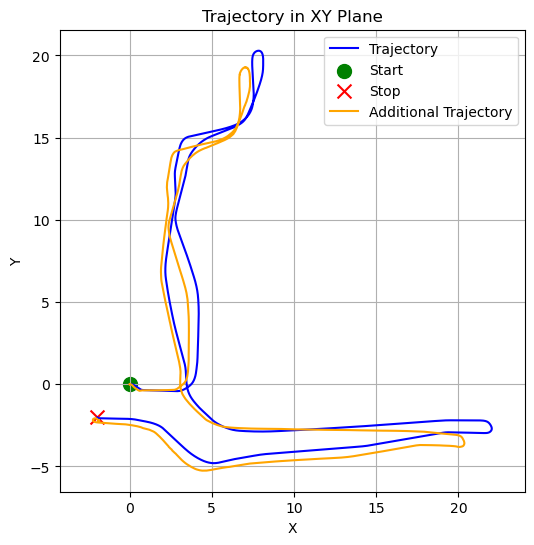

In [14]:
plot_trajectory(encoder_poses,icp_traj)

# occupancy grid

In [85]:
import numpy as np
import pr2_utils
# Initialize a grid map
MAP = {}
MAP['res'] = np.array([0.05, 0.05])    # meters
MAP['min'] = np.array([-20.0, -20.0])  # meters
MAP['max'] = np.array([30.0, 30.0])    # meters
MAP['size'] = np.ceil((MAP['max'] - MAP['min']) / MAP['res']).astype(int)
isEven = MAP['size']%2==0
MAP['size'][isEven] = MAP['size'][isEven]+1 # Make sure that the map has an odd size so that the origin is in the center cell
MAP['map'] = np.zeros(MAP['size'])

In [86]:
for idx in tqdm(range(encoder_ts.shape[-1]-1)):
    enc_ts = encoder_ts[idx]
    curr_pose= icp_traj[idx] @ lidar_body_pose
    
    curr_R, curr_p= ICP_stuff.get_R_and_P(curr_pose)

    lidar_range_val = lidar_ranges[:, lidar_sync_map[enc_ts]]
    lidar_pc= get_lidar_pc(lidar_range_val, lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    
    lidar_pc= ICP_stuff.rotate_pc(R=curr_R, pc=lidar_pc)+curr_p
    
    lidar_xy_pts= lidar_pc[:,:2]

    lidar_grid_pts= get_map_coords(lidar_xy_pts, MAP)-1
    
    lidar_grid_x= lidar_grid_pts[:,0]
    lidar_grid_y= lidar_grid_pts[:,1]

    start_pt=get_map_coords(curr_p[:2],MAP)

    for ii in range(lidar_grid_x.shape[0]):
        x,y = pr2_utils.bresenham2D(start_pt[0],start_pt[1], lidar_grid_x[ii], lidar_grid_y[ii])
        MAP['map'][y.astype(np.int32)[:-1], x.astype(np.int32)[:-1]] -= np.log(4)

    MAP['map'][lidar_grid_y, lidar_grid_x] += np.log(4)

    MAP['map'][np.where(MAP['map'] < -4*np.log(4))] = -4*np.log(4)
    MAP['map'][np.where(MAP['map'] > 4*np.log(4))] = 4*np.log(4)

100%|██████████| 4955/4955 [04:09<00:00, 19.85it/s]


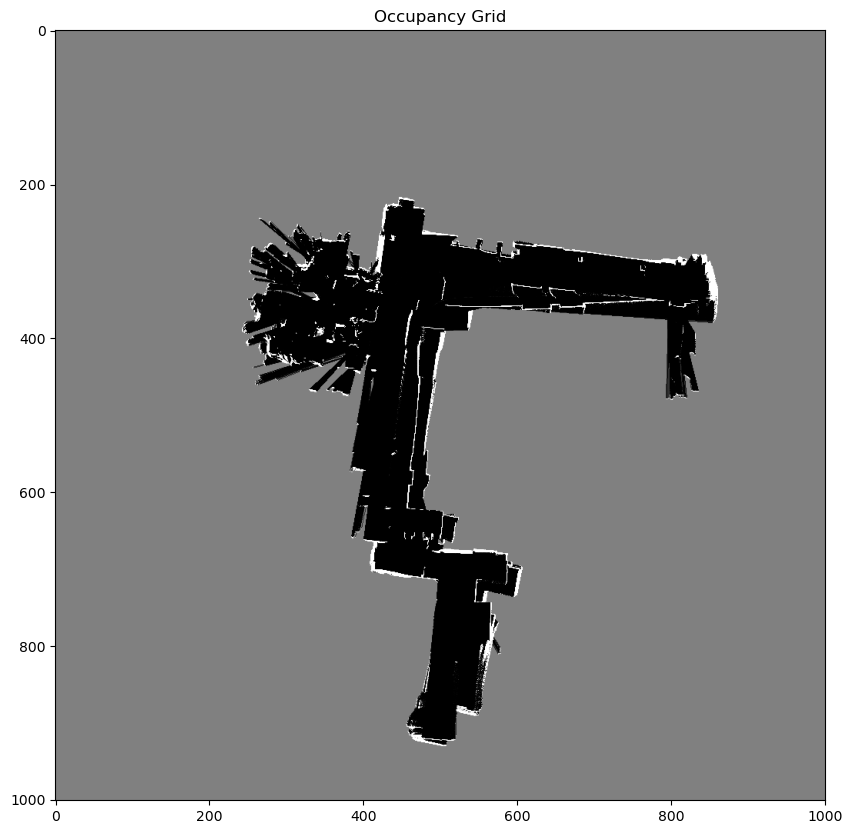

In [100]:
plt.figure(figsize=(10, 10))
plt.title('Occupancy Grid')
plt.imshow(1/(1+np.exp(-MAP['map'])), cmap='gray')
plt.savefig('./outputs/LiDAR_scan_dt_{}.jpg'.format(dataset_idx))
# plt.close()

In [43]:

def lidar_scan(index, trajectory, lidar_ts_mapped, encoder_stamps, map):
    '''
    index               Index for which the trajectory is to be plotted
    lidar_ts_mapped     Mapped values of the LiDAR
    encoder_stamps      Timestamps of encoder reading
    map                 The map in which scan has to be plotted and has all 
    '''

    # Transform LiDAR to world frame
    lidar_to_body = lidar_to_body_frame(
        lidar_ranges[:, lidar_ts_mapped[encoder_stamps[index]]])
    rotations = trajectory_to_rotation(trajectory[:, index])

    Y = np.dot(rotations, lidar_to_body)[:2, :]

    # Offset and scale coordinates to plot onto the map
    xis = np.ceil((Y[0] - MAP['xmin']) / MAP['res']).astype(np.int16)-1
    yis = np.ceil((Y[1] - MAP['ymin']) / MAP['res']).astype(np.int16)-1

    for j in range(xis.shape[-1]):
        # Find all coordinates from start to end points and plot into map with log values
        x, y = bresenham2D((trajectory[0, index] - MAP['xmin']) / MAP['res'],
                           (trajectory[1, index] - MAP['ymin']) / MAP['res'],
                           xis[j], yis[j])
        map[y.astype(np.int16)[:-1], x.astype(np.int16)[:-1]] -= np.log(4)
    map[yis, xis] += np.log(4)
    map[np.where(map < -4*np.log(4))] = -4*np.log(4)
    map[np.where(map > 4*np.log(4))] = 4*np.log(4)

    return map

array([359, 359, 359, ..., 376, 377, 377])

In [57]:
lidar_pc[:,:2]

(0.0, 0.0)

In [22]:
def get_grid_coords(lidar_XY, map_size_x, map_size_y, map_res):
    for (x, y) in lidar_XY:
        # Convert world coordinates to grid coordinates
        grid_x = int((x + map_size_x / 2) / resolution)
        grid_y = int((y + map_size_y / 2) / resolution)
    return np.column_stack((grid_x, grid_y))

def get_map_coords(xy, MAP):
    return np.floor((xy - MAP['min']) / MAP['res']).astype(int)

100%|██████████| 4955/4955 [00:01<00:00, 4699.85it/s]


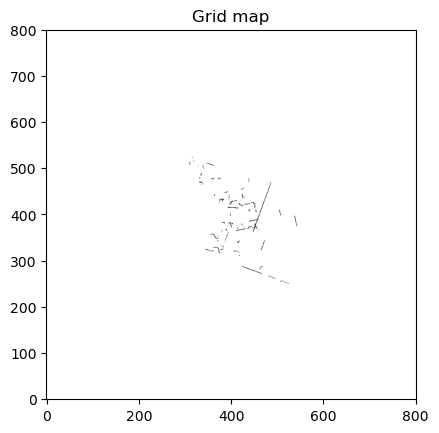

In [31]:
for idx in tqdm(range(encoder_ts.shape[-1]-1)):
    enc_ts = encoder_ts[idx]
    lidar_range_val = lidar_ranges[:, lidar_sync_map[enc_ts]]
    lidar_pc= get_lidar_pc(lidar_range_val_at_t, lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    lidar_xy_pts= lidar_pc[:,:2]
    points= lidar_xy_pts
    cells = np.floor((points - MAP['min']) / MAP['res']).astype(int)
    valid2 = np.all((cells >= 0) & (cells < MAP['size']),axis=1)
    MAP['map'][tuple(cells[valid2].T)] = 1
    robot_idx = get_map_coords(robot_pose[:2], MAP)
# Plot the Lidar points
fig1 = plt.figure()
plt.plot(points[:,0],points[:,1],'.k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lidar scan')
plt.axis('equal')

# Plot the grid map
fig2 = plt.figure()
pr2_utils.plot_map(MAP['map'],cmap='binary')
plt.title('Grid map')
plt.show()
    

In [26]:
.shape

(1080, 2)

In [95]:
!pip install matplotlib_scalebar

/opt/conda/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Defaulting to user installation because normal site-packages is not writeable
